<h3>Library Imports</h3>

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MaxAbsScaler
import chemprop
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, f1_score, confusion_matrix, accuracy_score, precision_score, recall_score

/projects/community/py-bigdata/2021/bd387/envs/DDisc/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<h3>Data Import</h3>

In [2]:
df = pd.read_csv("MLSMR_Deduped.csv")
df.head()

/tmp/ipykernel_28442/3982336487.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("MLSMR_Deduped.csv")


MoleculeName                                             SMILES  \
0  SMR000462435  COC(C[C@H]1O[C@H]1[C@@H](O)[C@@H](C)OCC1=CC=CC...   
1  SMR000150125  CN(CC(=O)OCC(=O)NC1=CC=CC=C1)S(=O)(=O)C1=CC=C(...   
2  SMR000364316    CC1=NN(C2=NC(=NC(O)=C12)C(Cl)(Cl)Cl)C1=CC=CC=C1   
3  SMR000199530  COC1=CC=C(C=C1)C(=O)NN1C(=O)C2=CC=CC=C2N=C1SCC...   
4       7947988              CN1C=C(CNC(=O)C2=CC=CC(Cl)=C2)C(C)=N1   

                                            RDKitMol  \
0  <rdkit.Chem.rdchem.Mol object at 0x000002C9398...   
1  <rdkit.Chem.rdchem.Mol object at 0x000002C9398...   
2  <rdkit.Chem.rdchem.Mol object at 0x000002C9428...   
3  <rdkit.Chem.rdchem.Mol object at 0x000002C9398...   
4  <rdkit.Chem.rdchem.Mol object at 0x000002C9398...   

                                         molStripped strippedSalts  \
0  COC(C[C@H]1O[C@H]1[C@@H](O)[C@@H](C)OCc1ccccc1)OC           NaN   
1    CN(CC(=O)OCC(=O)Nc1ccccc1)S(=O)(=O)c1ccc(Cl)cc1           NaN   
2          Cc1nn(-c2ccccc2)c2nc(C(Cl)(Cl)Cl)nc(O)c12           NaN   
3  COc1ccc(C(=O)Nn2c(SCc3ccc([N+](=O)[O-])cc3)nc3...           NaN   
4                     Cc1nn(C)cc1CNC(=O)c1cccc(Cl)c1           NaN   

   MtbH37Rv-Inhibition  Active  
0              -117.65       0  
1              -108.21       0  
2               -92.31       0  
3               -89.27       0  
4               -84.72       0

<h3>Missing and Duplicates Check</h3>

In [3]:
df.isna().sum().sort_values(ascending=False)
#Although strippedSalts has missing values, it does not contribute to the model so we can ignore that.

strippedSalts          214505
MoleculeName                0
SMILES                      0
RDKitMol                    0
molStripped                 0
MtbH37Rv-Inhibition         0
Active                      0
dtype: int64

In [4]:
df['molStripped'].duplicated().sum()
#There are no duplicate molecules

0

<h3>Balance Check</h3>

In [5]:
df['Active'].value_counts()

0    210628
1      3878
Name: Active, dtype: int64

In [6]:
df.duplicated(subset=['SMILES']).sum()

0

<h3>Data Processing</h3>

In [5]:
newdf = df[['molStripped','Active']]
newdf

molStripped  Active
0       COC(C[C@H]1O[C@H]1[C@@H](O)[C@@H](C)OCc1ccccc1)OC       0
1         CN(CC(=O)OCC(=O)Nc1ccccc1)S(=O)(=O)c1ccc(Cl)cc1       0
2               Cc1nn(-c2ccccc2)c2nc(C(Cl)(Cl)Cl)nc(O)c12       0
3       COc1ccc(C(=O)Nn2c(SCc3ccc([N+](=O)[O-])cc3)nc3...       0
4                          Cc1nn(C)cc1CNC(=O)c1cccc(Cl)c1       0
...                                                   ...     ...
214501                        O=C1C(=O)c2ccccc2-c2ccccc21       1
214502                CC(/N=N/c1nc2ccccc2s1)=N\Nc1ccccc1O       1
214503  CN(C)c1ccc(/C=C/c2ccc3c4ccccc4ccc3[n+]2-c2cccc...       1
214504         CCN1/C(=C/c2ccc3ccccc3[n+]2CC)C=Cc2ccccc21       1
214505           CSc1ccc(C(=O)C2CCCN(Cc3cnc(SC)nc3)C2)cc1       1

[214506 rows x 2 columns]

In [6]:
y = df[['Active']]

In [7]:
train, test = train_test_split(newdf ,stratify=y, test_size=0.20, shuffle=True, random_state=42)

In [8]:
train['Active'].value_counts()

0    168502
1      3102
Name: Active, dtype: int64

In [9]:
test['Active'].value_counts()

0    42126
1      776
Name: Active, dtype: int64

In [10]:
testmol=test[['molStripped']]
testmol.head()

molStripped
186510     O=C(Nc1cccc2c1CCCC2)c1ccc(Cl)c([N+](=O)[O-])c1
19109    CCOC(=O)CC1C(=O)NCCN1S(=O)(=O)c1cc(Cl)c(Cl)cc1Cl
13583                   CCS(=O)(=O)c1nc2ccccc2n1Cc1ccccn1
116361  COC(=O)C(CCCCNC(=O)c1ccc([N+](=O)[O-])cc1)NC(=...
145674     O=C(N/N=C1\CCCc2ccccc21)c1ccc([N+](=O)[O-])cc1

In [11]:
test_actuals = test[['Active']]
test_actuals.head()

Active
186510       0
19109        0
13583        0
116361       0
145674       0

In [12]:
testmol.to_csv('test.csv',index=False)
train.to_csv('train.csv',index=False)

<h3>MPN without rdkit</h3>

In [ ]:
parameters_opt = ['--data_path','train.csv', #location of the training data
                  '--dataset_type','classification', #Can also do regression, multiclass and spectra
                  '--loss_function','binary_cross_entropy', #Various loss functions available, since it's a binary classification I use binary cross entropy
                  '--num_folds','1', #Number of k-folds to do
                  '--extra_metrics','f1', #Other metrics to also calculate
                  '--metric','binary_cross_entropy', # The main metric used by Chemprop to optimize the training to minimize loss or maxmize accuracy depending on the metric used
                  '--epochs','100', #How many epochs to run
                  '--batch_size','32', #Default is 100 but I would increase in powers of 2
                  '--num_iters','20', # How many iterations of hyperparameter optimzations to run
                 # '--split_type','scaffold_balanced', 
                  '--class_balance', # Using this ensures balanced class is used for for batches, do not need if data is balanced already
                  '--features_generator','rdkit_2d', # Adds 2d rdkit features to the training aswell. Can also add morgan fingerprints
                 #'--no_features_scaling', # rdkit features are already scaled and normalized, can use this line if we need to use unscaled and unnormalized features instead
                  '--config_save_path','saveparam', # Save location of the best parameters
                 # '--seed','42',
                  '--num_workers','28' # How many CPUs to use
                 ]

In [ ]:
hyp = chemprop.hyperparameter_optimization.hyperopt(args=chemprop.args.HyperoptArgs().parse_args(parameters_opt))

In [13]:
chemprop_parameters = ['--data_path','train.csv',
                      '--dataset_type','classification',
                      '--loss_function','binary_cross_entropy',
                      '--num_folds','1',
                      '--extra_metrics','f1',
                      '--metric','binary_cross_entropy',
                      '--epochs','300',
                      '--batch_size','32',
                      #'--init_lr','0.0001',
                     # '--final_lr','0.0001',
                     # '--max_lr','0.001,
                      '--ffn_hidden_size','1200',
                      '--ffn_num_layers','3',
                      '--depth','2',
                      '--dropout','0.25',
                     # '--split_type','scaffold_balanced',
                      '--class_balance',
                      '--features_generator','rdkit_2d',
                     #'--no_features_scaling'
                      '--save_dir','checkpoints',
                      '--num_workers','25',
                      '--seed','42']

In [14]:
mpnn = chemprop.args.TrainArgs().parse_args(chemprop_parameters)

In [15]:
mean_score, std_score = chemprop.train.cross_validate(args=mpnn,train_func=chemprop.train.run_training)

Command line
python /projects/community/py-bigdata/2021/bd387/envs/DDisc/lib/python3.9/site-packages/ipykernel_launcher.py -f /cache/home/fkm11/.local/share/jupyter/runtime/kernel-f70a3f15-e5fc-42e7-a8e4-6d12e8932216.json
Args
{'activation': 'ReLU',
 'adding_h': False,
 'aggregation': 'mean',
 'aggregation_norm': 100,
 'atom_descriptor_scaling': True,
 'atom_descriptors': None,
 'atom_descriptors_path': None,
 'atom_descriptors_size': 0,
 'atom_features_size': 0,
 'atom_messages': False,
 'batch_size': 32,
 'bias': False,
 'bias_solvent': False,
 'bond_feature_scaling': True,
 'bond_features_path': None,
 'bond_features_size': 0,
 'cache_cutoff': 10000,
 'checkpoint_dir': None,
 'checkpoint_frzn': None,
 'checkpoint_path': None,
 'checkpoint_paths': None,
 'class_balance': True,
 'config_path': None,
 'crossval_index_dir': None,
 'crossval_index_file': None,
 'crossval_index_sets': None,
 'cuda': False,
 'data_path': 'train.csv',
 'data_weights_path': None,
 'dataset_type': 'classifica

 99%|█████████▉| 531/537 [00:39<00:00, 72.44it/s]
                                                 Validation binary_cross_entropy = 0.594513
Validation f1 = 0.074185
  0%|          | 1/300 [00:56<4:42:39, 56.72s/it]Epoch 1

  3%|▎         | 5/155 [00:03<00:53,  2.79it/s]Loss = 6.3610e-01, PNorm = 52.5486, GNorm = 3.5064, lr_0 = 1.1699e-04

  9%|▉         | 14/155 [00:04<00:19,  7.33it/s]Loss = 5.9524e-01, PNorm = 52.5508, GNorm = 3.9715, lr_0 = 1.1804e-04

 16%|█▌        | 25/155 [00:05<00:14,  9.16it/s]Loss = 5.5516e-01, PNorm = 52.5531, GNorm = 2.1536, lr_0 = 1.1909e-04

 23%|██▎       | 35/155 [00:06<00:13,  8.63it/s]Loss = 5.8255e-01, PNorm = 52.5548, GNorm = 1.9964, lr_0 = 1.2014e-04

 28%|██▊       | 44/155 [00:08<00:15,  7.20it/s]Loss = 6.1268e-01, PNorm = 52.5568, GNorm = 3.8207, lr_0 = 1.2119e-04

 35%|███▌      | 55/155 [00:09<00:12,  7.75it/s]Loss = 5.8875e-01, PNorm = 52.5586, GNorm = 2.3781, lr_0 = 1.2224e-04

 42%|████▏     | 65/155 [00:10<00:10,  8.77it/s]Loss = 6.0173e

 99%|█████████▊| 530/537 [00:42<00:00, 58.40it/s]
                                                 Validation binary_cross_entropy = 0.488524
Validation f1 = 0.097397
  1%|          | 2/300 [01:58<4:56:21, 59.67s/it]Epoch 2

  0%|          | 0/155 [00:00<?, ?it/s]Loss = 5.3990e-01, PNorm = 52.5840, GNorm = 1.9454, lr_0 = 1.3273e-04

  6%|▋         | 10/155 [00:03<00:25,  5.67it/s]Loss = 5.7539e-01, PNorm = 52.5867, GNorm = 2.2531, lr_0 = 1.3378e-04

 13%|█▎        | 20/155 [00:04<00:14,  9.30it/s]Loss = 5.9260e-01, PNorm = 52.5894, GNorm = 1.7738, lr_0 = 1.3483e-04

 19%|█▉        | 30/155 [00:06<00:21,  5.78it/s]Loss = 5.4480e-01, PNorm = 52.5925, GNorm = 2.1629, lr_0 = 1.3587e-04

 25%|██▌       | 39/155 [00:07<00:14,  7.96it/s]Loss = 5.8290e-01, PNorm = 52.5953, GNorm = 2.8138, lr_0 = 1.3692e-04

 32%|███▏      | 49/155 [00:08<00:11,  9.29it/s]Loss = 5.4740e-01, PNorm = 52.5982, GNorm = 1.5879, lr_0 = 1.3797e-04

 38%|███▊      | 59/155 [00:09<00:09, 10.13it/s]Loss = 5.8546e-01, PNo

 90%|█████████ | 140/155 [00:15<00:00, 19.55it/s]Loss = 5.3312e-01, PNorm = 52.6282, GNorm = 2.5666, lr_0 = 1.4741e-04

 96%|█████████▌| 149/155 [00:16<00:00, 22.43it/s]Loss = 5.5274e-01, PNorm = 52.6321, GNorm = 1.6686, lr_0 = 1.4846e-04

100%|██████████| 155/155 [00:16<00:00, 23.56it/s]
                                                 
100%|█████████▉| 536/537 [00:42<00:00, 44.70it/s]
                                                 Validation binary_cross_entropy = 0.566427
Validation f1 = 0.086022
  1%|          | 3/300 [02:57<4:54:03, 59.41s/it]Epoch 3

  3%|▎         | 5/155 [00:03<00:55,  2.68it/s]Loss = 5.7497e-01, PNorm = 52.6368, GNorm = 1.5953, lr_0 = 1.4951e-04

 10%|▉         | 15/155 [00:04<00:16,  8.43it/s]Loss = 5.5395e-01, PNorm = 52.6409, GNorm = 2.0817, lr_0 = 1.5056e-04

 15%|█▌        | 24/155 [00:05<00:15,  8.20it/s]Loss = 5.5387e-01, PNorm = 52.6438, GNorm = 1.6025, lr_0 = 1.5161e-04

 23%|██▎       | 35/155 [00:07<00:19,  6.12it/s]Loss = 5.3513e-01, PNorm = 52.6


 35%|███▌      | 55/155 [00:09<00:13,  7.54it/s]Loss = 6.2986e-01, PNorm = 52.6551, GNorm = 2.2394, lr_0 = 1.5476e-04

 41%|████▏     | 64/155 [00:10<00:10,  8.68it/s]Loss = 5.6350e-01, PNorm = 52.6591, GNorm = 1.7460, lr_0 = 1.5580e-04

 48%|████▊     | 75/155 [00:12<00:10,  7.93it/s]Loss = 5.2044e-01, PNorm = 52.6633, GNorm = 1.7018, lr_0 = 1.5685e-04

 55%|█████▍    | 85/155 [00:13<00:09,  7.76it/s]Loss = 5.8800e-01, PNorm = 52.6687, GNorm = 1.7798, lr_0 = 1.5790e-04

 61%|██████▏   | 95/155 [00:14<00:08,  7.44it/s]Loss = 5.6653e-01, PNorm = 52.6724, GNorm = 1.9364, lr_0 = 1.5895e-04

 68%|██████▊   | 105/155 [00:16<00:06,  7.27it/s]Loss = 5.2631e-01, PNorm = 52.6762, GNorm = 2.2331, lr_0 = 1.6000e-04

 74%|███████▎  | 114/155 [00:16<00:02, 18.20it/s]Loss = 5.2652e-01, PNorm = 52.6805, GNorm = 2.0615, lr_0 = 1.6105e-04

 81%|████████  | 125/155 [00:17<00:01, 17.03it/s]Loss = 5.8630e-01, PNorm = 52.6842, GNorm = 2.0236, lr_0 = 1.6210e-04

 86%|████████▋ | 134/155 [00:17<00:01, 18.40

100%|██████████| 537/537 [00:41<00:00, 59.54it/s]
                                                 Validation binary_cross_entropy = 0.632720
Validation f1 = 0.077771
  1%|▏         | 4/300 [03:58<4:55:58, 60.00s/it]Epoch 4

  0%|          | 0/155 [00:00<?, ?it/s]Loss = 5.1393e-01, PNorm = 52.6954, GNorm = 1.5101, lr_0 = 1.6524e-04

  6%|▋         | 10/155 [00:03<00:22,  6.59it/s]Loss = 5.4917e-01, PNorm = 52.6995, GNorm = 2.1359, lr_0 = 1.6629e-04

 13%|█▎        | 20/155 [00:05<00:17,  7.81it/s]Loss = 5.7153e-01, PNorm = 52.7032, GNorm = 1.8073, lr_0 = 1.6734e-04

 19%|█▉        | 30/155 [00:07<00:17,  7.22it/s]Loss = 5.1536e-01, PNorm = 52.7086, GNorm = 1.7776, lr_0 = 1.6839e-04

 26%|██▌       | 40/155 [00:08<00:13,  8.61it/s]Loss = 5.3353e-01, PNorm = 52.7145, GNorm = 1.6619, lr_0 = 1.6944e-04

 32%|███▏      | 50/155 [00:09<00:15,  6.94it/s]Loss = 5.4946e-01, PNorm = 52.7194, GNorm = 3.1635, lr_0 = 1.7049e-04

 39%|███▊      | 60/155 [00:11<00:14,  6.34it/s]Loss = 5.6316e-01, PNo


 99%|█████████▊| 153/155 [00:19<00:00, 20.75it/s]
                                                 
 99%|█████████▉| 532/537 [00:40<00:00, 58.40it/s]
                                                 Validation binary_cross_entropy = 0.554164
Validation f1 = 0.087095
  2%|▏         | 5/300 [04:59<4:57:09, 60.44s/it]Epoch 5

  3%|▎         | 5/155 [00:03<00:49,  3.02it/s]Loss = 5.0945e-01, PNorm = 52.7726, GNorm = 1.7761, lr_0 = 1.8203e-04

 10%|▉         | 15/155 [00:05<00:37,  3.74it/s]Loss = 5.5018e-01, PNorm = 52.7783, GNorm = 2.0365, lr_0 = 1.8308e-04

 16%|█▌        | 25/155 [00:06<00:14,  8.79it/s]Loss = 5.5660e-01, PNorm = 52.7839, GNorm = 1.7822, lr_0 = 1.8413e-04

 22%|██▏       | 34/155 [00:07<00:12,  9.75it/s]Loss = 5.0773e-01, PNorm = 52.7914, GNorm = 2.4720, lr_0 = 1.8517e-04

 28%|██▊       | 44/155 [00:08<00:11,  9.45it/s]Loss = 5.1015e-01, PNorm = 52.7983, GNorm = 1.3795, lr_0 = 1.8622e-04

 35%|███▌      | 55/155 [00:09<00:11,  8.93it/s]Loss = 5.3258e-01, PNorm = 52.80

 42%|████▏     | 65/155 [00:10<00:09,  9.11it/s]Loss = 5.2231e-01, PNorm = 52.8124, GNorm = 1.9599, lr_0 = 1.8832e-04

 48%|████▊     | 74/155 [00:11<00:07, 10.21it/s]Loss = 5.3467e-01, PNorm = 52.8190, GNorm = 1.9840, lr_0 = 1.8937e-04

 55%|█████▍    | 85/155 [00:12<00:06, 10.17it/s]Loss = 5.8182e-01, PNorm = 52.8241, GNorm = 1.6714, lr_0 = 1.9042e-04

 61%|██████▏   | 95/155 [00:13<00:06,  9.53it/s]Loss = 5.4514e-01, PNorm = 52.8297, GNorm = 1.5010, lr_0 = 1.9147e-04

 67%|██████▋   | 104/155 [00:14<00:05,  9.15it/s]Loss = 5.5261e-01, PNorm = 52.8353, GNorm = 2.2645, lr_0 = 1.9252e-04

 74%|███████▎  | 114/155 [00:15<00:02, 16.40it/s]Loss = 5.5834e-01, PNorm = 52.8412, GNorm = 2.1290, lr_0 = 1.9357e-04

 81%|████████  | 125/155 [00:15<00:01, 17.61it/s]Loss = 4.5128e-01, PNorm = 52.8498, GNorm = 1.7355, lr_0 = 1.9462e-04

 86%|████████▌ | 133/155 [00:16<00:01, 19.77it/s]Loss = 5.2983e-01, PNorm = 52.8584, GNorm = 1.7930, lr_0 = 1.9566e-04

 94%|█████████▎| 145/155 [00:17<00:00, 18.64

 99%|█████████▉| 534/537 [00:40<00:00, 50.02it/s]
                                                 Validation binary_cross_entropy = 0.624565
Validation f1 = 0.080843
  2%|▏         | 6/300 [05:58<4:52:55, 59.78s/it]Epoch 6

  1%|          | 1/155 [00:02<07:07,  2.77s/it]Loss = 6.3056e-01, PNorm = 52.8697, GNorm = 2.0778, lr_0 = 1.9787e-04

  7%|▋         | 11/155 [00:03<00:19,  7.33it/s]Loss = 5.7071e-01, PNorm = 52.8769, GNorm = 1.9214, lr_0 = 1.9892e-04

 14%|█▎        | 21/155 [00:05<00:15,  8.39it/s]Loss = 5.4478e-01, PNorm = 52.8824, GNorm = 1.5554, lr_0 = 1.9997e-04

 19%|█▉        | 30/155 [00:06<00:22,  5.52it/s]Loss = 5.3230e-01, PNorm = 52.8895, GNorm = 1.7557, lr_0 = 2.0101e-04

 26%|██▋       | 41/155 [00:08<00:13,  8.45it/s]Loss = 5.4078e-01, PNorm = 52.8964, GNorm = 1.9366, lr_0 = 2.0206e-04

 33%|███▎      | 51/155 [00:09<00:12,  8.19it/s]Loss = 5.0684e-01, PNorm = 52.9048, GNorm = 1.4427, lr_0 = 2.0311e-04

 39%|███▉      | 61/155 [00:10<00:12,  7.32it/s]Loss = 5.1556e

 99%|█████████▉| 534/537 [00:40<00:00, 57.72it/s]
                                                 Validation binary_cross_entropy = 0.630883
Validation f1 = 0.079495
  2%|▏         | 7/300 [06:58<4:52:27, 59.89s/it]Epoch 7

  3%|▎         | 5/155 [00:03<00:50,  2.97it/s]Loss = 5.4267e-01, PNorm = 52.9903, GNorm = 1.5765, lr_0 = 2.1465e-04

 10%|█         | 16/155 [00:04<00:16,  8.42it/s]Loss = 5.0873e-01, PNorm = 52.9988, GNorm = 2.0067, lr_0 = 2.1570e-04

 17%|█▋        | 26/155 [00:05<00:15,  8.22it/s]Loss = 5.2632e-01, PNorm = 53.0072, GNorm = 1.6086, lr_0 = 2.1675e-04

 23%|██▎       | 36/155 [00:07<00:15,  7.85it/s]Loss = 5.2440e-01, PNorm = 53.0153, GNorm = 2.9450, lr_0 = 2.1780e-04

 29%|██▉       | 45/155 [00:08<00:12,  9.05it/s]Loss = 5.7649e-01, PNorm = 53.0234, GNorm = 2.3379, lr_0 = 2.1885e-04

 36%|███▌      | 56/155 [00:09<00:10,  9.04it/s]Loss = 5.2836e-01, PNorm = 53.0309, GNorm = 1.5881, lr_0 = 2.1990e-04

 43%|████▎     | 66/155 [00:10<00:10,  8.80it/s]Loss = 5.5559e

 99%|█████████▉| 532/537 [00:39<00:00, 60.44it/s]
                                                 Validation binary_cross_entropy = 0.555587
Validation f1 = 0.089984
  3%|▎         | 8/300 [07:56<4:48:29, 59.28s/it]Epoch 8

  1%|          | 1/155 [00:02<06:38,  2.59s/it]Loss = 5.9203e-01, PNorm = 53.1212, GNorm = 2.0786, lr_0 = 2.3038e-04

  7%|▋         | 11/155 [00:04<00:25,  5.74it/s]Loss = 5.4682e-01, PNorm = 53.1293, GNorm = 1.5768, lr_0 = 2.3143e-04

 13%|█▎        | 20/155 [00:05<00:15,  8.86it/s]Loss = 5.3838e-01, PNorm = 53.1407, GNorm = 1.9151, lr_0 = 2.3248e-04

 19%|█▉        | 30/155 [00:06<00:16,  7.63it/s]Loss = 5.7385e-01, PNorm = 53.1589, GNorm = 1.6364, lr_0 = 2.3353e-04

 26%|██▋       | 41/155 [00:07<00:12,  8.93it/s]Loss = 4.9616e-01, PNorm = 53.1769, GNorm = 1.4801, lr_0 = 2.3458e-04

 33%|███▎      | 51/155 [00:09<00:15,  6.58it/s]Loss = 4.7953e-01, PNorm = 53.1921, GNorm = 1.8976, lr_0 = 2.3563e-04

 39%|███▉      | 61/155 [00:10<00:10,  8.60it/s]Loss = 5.1233e

 99%|█████████▉| 532/537 [00:42<00:00, 39.70it/s]
                                                 Validation binary_cross_entropy = 0.536965
Validation f1 = 0.089308
  3%|▎         | 9/300 [08:57<4:50:42, 59.94s/it]Epoch 9

  4%|▍         | 6/155 [00:03<00:42,  3.51it/s]Loss = 4.6844e-01, PNorm = 53.3109, GNorm = 2.7676, lr_0 = 2.4717e-04

 10%|█         | 16/155 [00:04<00:18,  7.37it/s]Loss = 4.7990e-01, PNorm = 53.3220, GNorm = 1.4467, lr_0 = 2.4822e-04

 17%|█▋        | 26/155 [00:05<00:20,  6.23it/s]Loss = 4.9183e-01, PNorm = 53.3318, GNorm = 1.7645, lr_0 = 2.4927e-04

 23%|██▎       | 36/155 [00:07<00:21,  5.66it/s]Loss = 4.4054e-01, PNorm = 53.3440, GNorm = 1.6984, lr_0 = 2.5031e-04

 30%|██▉       | 46/155 [00:08<00:11,  9.28it/s]Loss = 4.8307e-01, PNorm = 53.3551, GNorm = 1.6869, lr_0 = 2.5136e-04

 36%|███▌      | 56/155 [00:10<00:12,  8.06it/s]Loss = 5.3132e-01, PNorm = 53.3662, GNorm = 2.2149, lr_0 = 2.5241e-04

 42%|████▏     | 65/155 [00:11<00:11,  7.96it/s]Loss = 4.8961e

 68%|██████▊   | 106/155 [00:16<00:05,  9.40it/s]Loss = 5.7258e-01, PNorm = 53.4160, GNorm = 1.3022, lr_0 = 2.5766e-04

 74%|███████▎  | 114/155 [00:17<00:02, 17.23it/s]Loss = 5.0466e-01, PNorm = 53.4261, GNorm = 1.8542, lr_0 = 2.5871e-04

 81%|████████▏ | 126/155 [00:17<00:01, 17.81it/s]Loss = 4.7276e-01, PNorm = 53.4414, GNorm = 1.3255, lr_0 = 2.5976e-04

 87%|████████▋ | 135/155 [00:18<00:01, 18.99it/s]Loss = 5.0213e-01, PNorm = 53.4543, GNorm = 1.3616, lr_0 = 2.6080e-04

 93%|█████████▎| 144/155 [00:18<00:00, 20.84it/s]Loss = 5.2306e-01, PNorm = 53.4663, GNorm = 2.7536, lr_0 = 2.6185e-04

 99%|█████████▊| 153/155 [00:19<00:00, 21.67it/s]
                                                 
 99%|█████████▊| 530/537 [00:42<00:00, 64.64it/s]
                                                 Validation binary_cross_entropy = 0.502710
Validation f1 = 0.091825
  3%|▎         | 10/300 [10:00<4:53:40, 60.76s/it]Epoch 10

  1%|          | 1/155 [00:02<07:06,  2.77s/it]Loss = 4.3394e-01, PNorm =


 20%|██        | 31/155 [00:07<00:15,  8.10it/s]Loss = 4.8699e-01, PNorm = 53.5127, GNorm = 1.5603, lr_0 = 2.6605e-04

 26%|██▋       | 41/155 [00:08<00:13,  8.60it/s]Loss = 5.0236e-01, PNorm = 53.5243, GNorm = 1.4568, lr_0 = 2.6710e-04

 33%|███▎      | 51/155 [00:09<00:15,  6.91it/s]Loss = 5.6516e-01, PNorm = 53.5335, GNorm = 1.4702, lr_0 = 2.6815e-04

 39%|███▉      | 61/155 [00:10<00:14,  6.50it/s]Loss = 5.1012e-01, PNorm = 53.5471, GNorm = 1.9148, lr_0 = 2.6920e-04

 46%|████▌     | 71/155 [00:12<00:10,  8.03it/s]Loss = 5.4051e-01, PNorm = 53.5593, GNorm = 1.6176, lr_0 = 2.7024e-04

 52%|█████▏    | 81/155 [00:13<00:08,  8.45it/s]Loss = 5.0544e-01, PNorm = 53.5755, GNorm = 1.6400, lr_0 = 2.7129e-04

 59%|█████▊    | 91/155 [00:14<00:07,  8.82it/s]Loss = 5.3822e-01, PNorm = 53.5910, GNorm = 2.0616, lr_0 = 2.7234e-04

 65%|██████▌   | 101/155 [00:15<00:07,  7.15it/s]Loss = 4.9798e-01, PNorm = 53.6017, GNorm = 1.4552, lr_0 = 2.7339e-04

 71%|███████   | 110/155 [00:16<00:03, 13.60it

 99%|█████████▉| 534/537 [00:40<00:00, 39.82it/s]
                                                 Validation binary_cross_entropy = 0.469097
Validation f1 = 0.104654
  4%|▎         | 11/300 [10:59<4:51:02, 60.42s/it]Epoch 11

  5%|▍         | 7/155 [00:03<00:35,  4.18it/s]Loss = 5.1199e-01, PNorm = 53.6644, GNorm = 1.8702, lr_0 = 2.7979e-04

 11%|█         | 17/155 [00:05<00:36,  3.76it/s]Loss = 4.5418e-01, PNorm = 53.6777, GNorm = 1.4695, lr_0 = 2.8084e-04

 17%|█▋        | 27/155 [00:06<00:15,  8.31it/s]Loss = 4.7718e-01, PNorm = 53.6923, GNorm = 1.6679, lr_0 = 2.8189e-04

 23%|██▎       | 36/155 [00:07<00:13,  8.92it/s]Loss = 5.1114e-01, PNorm = 53.7052, GNorm = 1.8439, lr_0 = 2.8294e-04

 30%|███       | 47/155 [00:08<00:11,  9.67it/s]Loss = 5.0014e-01, PNorm = 53.7147, GNorm = 1.6813, lr_0 = 2.8399e-04

 36%|███▌      | 56/155 [00:09<00:11,  8.40it/s]Loss = 5.4261e-01, PNorm = 53.7287, GNorm = 1.3014, lr_0 = 2.8503e-04

 43%|████▎     | 67/155 [00:10<00:08, 10.20it/s]Loss = 5.036

 99%|█████████▊| 529/537 [00:45<00:00, 61.19it/s]
                                                 Validation binary_cross_entropy = 0.475588
Validation f1 = 0.100020
  4%|▍         | 12/300 [12:03<4:54:54, 61.44s/it]Epoch 12

  1%|          | 1/155 [00:02<06:44,  2.63s/it]Loss = 5.3954e-01, PNorm = 53.8529, GNorm = 1.7668, lr_0 = 2.9552e-04

  8%|▊         | 12/155 [00:03<00:20,  7.09it/s]Loss = 4.2965e-01, PNorm = 53.8697, GNorm = 1.8086, lr_0 = 2.9657e-04

 14%|█▍        | 22/155 [00:04<00:16,  8.31it/s]Loss = 5.0444e-01, PNorm = 53.8830, GNorm = 2.4743, lr_0 = 2.9762e-04

 21%|██        | 32/155 [00:06<00:14,  8.51it/s]Loss = 4.6571e-01, PNorm = 53.8970, GNorm = 1.9324, lr_0 = 2.9867e-04

 27%|██▋       | 42/155 [00:07<00:11,  9.56it/s]Loss = 4.7724e-01, PNorm = 53.9088, GNorm = 1.3958, lr_0 = 2.9972e-04

 34%|███▎      | 52/155 [00:08<00:14,  7.33it/s]Loss = 4.5322e-01, PNorm = 53.9246, GNorm = 1.5546, lr_0 = 3.0077e-04

 40%|████      | 62/155 [00:10<00:13,  6.83it/s]Loss = 4.857

 99%|█████████▉| 534/537 [00:42<00:00, 59.30it/s]
                                                 Validation binary_cross_entropy = 0.541960
Validation f1 = 0.091519
  4%|▍         | 13/300 [13:04<4:52:39, 61.18s/it]Epoch 13

  5%|▍         | 7/155 [00:03<00:32,  4.62it/s]Loss = 4.6519e-01, PNorm = 54.0985, GNorm = 1.6529, lr_0 = 3.1231e-04

 10%|█         | 16/155 [00:04<00:17,  7.85it/s]Loss = 4.5655e-01, PNorm = 54.1136, GNorm = 1.3346, lr_0 = 3.1336e-04

 17%|█▋        | 27/155 [00:05<00:17,  7.27it/s]Loss = 4.1285e-01, PNorm = 54.1329, GNorm = 1.9344, lr_0 = 3.1441e-04

 24%|██▍       | 37/155 [00:07<00:15,  7.85it/s]Loss = 4.7079e-01, PNorm = 54.1532, GNorm = 1.4983, lr_0 = 3.1545e-04

 30%|███       | 47/155 [00:08<00:12,  8.73it/s]Loss = 4.9042e-01, PNorm = 54.1665, GNorm = 1.6663, lr_0 = 3.1650e-04

 36%|███▌      | 56/155 [00:09<00:12,  7.99it/s]Loss = 4.8275e-01, PNorm = 54.1777, GNorm = 1.7061, lr_0 = 3.1755e-04

 43%|████▎     | 67/155 [00:10<00:10,  8.30it/s]Loss = 5.197


 88%|████████▊ | 137/155 [00:17<00:00, 19.27it/s]Loss = 4.8025e-01, PNorm = 54.2966, GNorm = 1.7848, lr_0 = 3.2594e-04

 94%|█████████▍| 146/155 [00:17<00:00, 20.49it/s]Loss = 4.5389e-01, PNorm = 54.3189, GNorm = 1.4610, lr_0 = 3.2699e-04

100%|██████████| 155/155 [00:18<00:00, 17.38it/s]
                                                 
 99%|█████████▉| 533/537 [00:42<00:00, 30.54it/s]
                                                 Validation binary_cross_entropy = 0.466889
Validation f1 = 0.106917
  5%|▍         | 14/300 [14:05<4:51:39, 61.19s/it]Epoch 14

  1%|▏         | 2/155 [00:02<03:05,  1.21s/it]Loss = 3.8766e-01, PNorm = 54.3393, GNorm = 1.7856, lr_0 = 3.2804e-04

  7%|▋         | 11/155 [00:04<00:23,  6.19it/s]Loss = 4.8039e-01, PNorm = 54.3553, GNorm = 1.9927, lr_0 = 3.2909e-04

 14%|█▍        | 22/155 [00:05<00:16,  7.89it/s]Loss = 4.6302e-01, PNorm = 54.3719, GNorm = 2.4339, lr_0 = 3.3014e-04

 21%|██        | 32/155 [00:07<00:18,  6.50it/s]Loss = 4.8339e-01, PNorm = 5

 27%|██▋       | 42/155 [00:08<00:12,  9.14it/s]Loss = 4.4396e-01, PNorm = 54.4074, GNorm = 1.2319, lr_0 = 3.3224e-04

 34%|███▎      | 52/155 [00:09<00:20,  5.06it/s]Loss = 4.8758e-01, PNorm = 54.4257, GNorm = 1.7445, lr_0 = 3.3329e-04

 40%|████      | 62/155 [00:11<00:13,  6.68it/s]Loss = 4.7442e-01, PNorm = 54.4464, GNorm = 1.6372, lr_0 = 3.3434e-04

 46%|████▋     | 72/155 [00:12<00:09,  9.02it/s]Loss = 4.6206e-01, PNorm = 54.4660, GNorm = 1.7127, lr_0 = 3.3538e-04

 53%|█████▎    | 82/155 [00:14<00:11,  6.39it/s]Loss = 4.7522e-01, PNorm = 54.4885, GNorm = 1.9565, lr_0 = 3.3643e-04

 59%|█████▉    | 92/155 [00:15<00:07,  8.13it/s]Loss = 4.7402e-01, PNorm = 54.5093, GNorm = 1.4955, lr_0 = 3.3748e-04

 66%|██████▌   | 102/155 [00:16<00:06,  7.68it/s]Loss = 4.3136e-01, PNorm = 54.5295, GNorm = 2.3769, lr_0 = 3.3853e-04

 71%|███████   | 110/155 [00:17<00:03, 14.38it/s]Loss = 4.8040e-01, PNorm = 54.5409, GNorm = 1.3641, lr_0 = 3.3958e-04

 79%|███████▊  | 122/155 [00:17<00:01, 21.11it

100%|██████████| 537/537 [00:41<00:00, 53.11it/s]
                                                 Validation binary_cross_entropy = 0.492418
Validation f1 = 0.101646
  5%|▌         | 15/300 [15:06<4:50:57, 61.25s/it]Epoch 15

  5%|▍         | 7/155 [00:03<00:32,  4.50it/s]Loss = 5.2278e-01, PNorm = 54.6395, GNorm = 1.6981, lr_0 = 3.4483e-04

 11%|█         | 17/155 [00:04<00:21,  6.55it/s]Loss = 4.6777e-01, PNorm = 54.6602, GNorm = 1.6023, lr_0 = 3.4587e-04

 17%|█▋        | 27/155 [00:06<00:21,  5.82it/s]Loss = 4.6366e-01, PNorm = 54.6858, GNorm = 1.6528, lr_0 = 3.4692e-04

 24%|██▍       | 37/155 [00:07<00:13,  8.72it/s]Loss = 4.5680e-01, PNorm = 54.7098, GNorm = 1.3815, lr_0 = 3.4797e-04

 30%|███       | 47/155 [00:08<00:13,  7.99it/s]Loss = 4.9484e-01, PNorm = 54.7302, GNorm = 3.9115, lr_0 = 3.4902e-04

 37%|███▋      | 57/155 [00:09<00:15,  6.36it/s]Loss = 4.5011e-01, PNorm = 54.7503, GNorm = 1.5788, lr_0 = 3.5007e-04

 43%|████▎     | 67/155 [00:11<00:13,  6.34it/s]Loss = 4.833

 99%|█████████▉| 534/537 [00:41<00:00, 59.81it/s]
                                                 Validation binary_cross_entropy = 0.506732
Validation f1 = 0.099143
  5%|▌         | 16/300 [16:08<4:50:23, 61.35s/it]Epoch 16

  1%|▏         | 2/155 [00:02<03:02,  1.19s/it]Loss = 4.4964e-01, PNorm = 54.9493, GNorm = 1.3685, lr_0 = 3.6056e-04

  8%|▊         | 12/155 [00:04<00:21,  6.52it/s]Loss = 5.0364e-01, PNorm = 54.9717, GNorm = 2.4727, lr_0 = 3.6161e-04

 14%|█▍        | 22/155 [00:05<00:18,  7.02it/s]Loss = 4.5174e-01, PNorm = 54.9976, GNorm = 1.5107, lr_0 = 3.6266e-04

 21%|██        | 32/155 [00:07<00:18,  6.79it/s]Loss = 4.1668e-01, PNorm = 55.0227, GNorm = 2.4888, lr_0 = 3.6371e-04

 27%|██▋       | 42/155 [00:09<00:39,  2.85it/s]Loss = 5.2356e-01, PNorm = 55.0349, GNorm = 1.7017, lr_0 = 3.6476e-04

 34%|███▎      | 52/155 [00:14<00:43,  2.36it/s]Loss = 4.1699e-01, PNorm = 55.0564, GNorm = 1.4162, lr_0 = 3.6580e-04

 40%|████      | 62/155 [00:19<01:01,  1.52it/s]Loss = 5.071

 99%|█████████▉| 533/537 [00:42<00:00, 34.41it/s]
                                                 Validation binary_cross_entropy = 0.390057
Validation f1 = 0.117772
  6%|▌         | 17/300 [17:22<5:07:49, 65.26s/it]Epoch 17

  5%|▌         | 8/155 [00:03<00:33,  4.41it/s]Loss = 4.3751e-01, PNorm = 55.3050, GNorm = 2.4554, lr_0 = 3.7745e-04

 12%|█▏        | 18/155 [00:04<00:17,  7.63it/s]Loss = 4.2745e-01, PNorm = 55.3223, GNorm = 1.3228, lr_0 = 3.7850e-04

 18%|█▊        | 28/155 [00:06<00:18,  6.80it/s]Loss = 4.7151e-01, PNorm = 55.3445, GNorm = 1.4725, lr_0 = 3.7955e-04

 25%|██▍       | 38/155 [00:07<00:13,  8.55it/s]Loss = 4.5890e-01, PNorm = 55.3653, GNorm = 2.1092, lr_0 = 3.8059e-04

 31%|███       | 48/155 [00:08<00:11,  9.03it/s]Loss = 4.4512e-01, PNorm = 55.3891, GNorm = 1.6942, lr_0 = 3.8164e-04

 37%|███▋      | 58/155 [00:09<00:11,  8.68it/s]Loss = 4.2209e-01, PNorm = 55.4205, GNorm = 1.6052, lr_0 = 3.8269e-04

 44%|████▍     | 68/155 [00:11<00:10,  8.65it/s]Loss = 5.307

 75%|███████▍  | 116/155 [00:16<00:02, 18.51it/s]Loss = 4.5752e-01, PNorm = 55.5542, GNorm = 2.0189, lr_0 = 3.8899e-04

 83%|████████▎ | 128/155 [00:17<00:01, 18.88it/s]Loss = 4.7450e-01, PNorm = 55.5814, GNorm = 1.5402, lr_0 = 3.9003e-04

 89%|████████▉ | 138/155 [00:17<00:00, 21.16it/s]Loss = 4.6440e-01, PNorm = 55.6050, GNorm = 1.3965, lr_0 = 3.9108e-04

 95%|█████████▍| 147/155 [00:18<00:00, 23.20it/s]Loss = 4.7106e-01, PNorm = 55.6339, GNorm = 1.8136, lr_0 = 3.9213e-04

 99%|█████████▊| 153/155 [00:18<00:00, 21.27it/s]
                                                 
100%|█████████▉| 536/537 [00:41<00:00, 52.58it/s]
                                                 Validation binary_cross_entropy = 0.374108
Validation f1 = 0.123491
  6%|▌         | 18/300 [18:23<5:00:38, 63.97s/it]Epoch 18

  2%|▏         | 3/155 [00:03<01:57,  1.29it/s]Loss = 4.8385e-01, PNorm = 55.6688, GNorm = 1.8351, lr_0 = 3.9318e-04

  8%|▊         | 12/155 [00:04<00:21,  6.81it/s]Loss = 4.4704e-01, PNorm = 

 28%|██▊       | 43/155 [00:07<00:11,  9.64it/s]Loss = 4.6521e-01, PNorm = 55.7680, GNorm = 1.6869, lr_0 = 3.9738e-04

 34%|███▍      | 53/155 [00:08<00:12,  8.32it/s]Loss = 4.8284e-01, PNorm = 55.7910, GNorm = 1.4512, lr_0 = 3.9843e-04

 41%|████      | 63/155 [00:09<00:10,  9.10it/s]Loss = 4.5167e-01, PNorm = 55.8165, GNorm = 1.4734, lr_0 = 3.9948e-04

 46%|████▋     | 72/155 [00:10<00:08, 10.25it/s]Loss = 4.8053e-01, PNorm = 55.8380, GNorm = 1.3148, lr_0 = 4.0052e-04

 54%|█████▎    | 83/155 [00:12<00:10,  6.97it/s]Loss = 4.3896e-01, PNorm = 55.8671, GNorm = 1.2540, lr_0 = 4.0157e-04

 59%|█████▉    | 92/155 [00:13<00:07,  8.92it/s]Loss = 4.5395e-01, PNorm = 55.8971, GNorm = 1.5067, lr_0 = 4.0262e-04

 66%|██████▌   | 102/155 [00:14<00:06,  8.26it/s]Loss = 4.2311e-01, PNorm = 55.9262, GNorm = 1.0820, lr_0 = 4.0367e-04

 73%|███████▎  | 113/155 [00:15<00:02, 17.01it/s]Loss = 4.6994e-01, PNorm = 55.9467, GNorm = 1.4317, lr_0 = 4.0472e-04

 79%|███████▊  | 122/155 [00:15<00:01, 22.42it

 99%|█████████▊| 529/537 [00:42<00:00, 59.05it/s]
                                                 Validation binary_cross_entropy = 0.525679
Validation f1 = 0.091046
  6%|▋         | 19/300 [19:23<4:53:49, 62.74s/it]Epoch 19

  5%|▌         | 8/155 [00:03<00:30,  4.81it/s]Loss = 4.4207e-01, PNorm = 56.0604, GNorm = 1.5505, lr_0 = 4.0997e-04

 12%|█▏        | 18/155 [00:04<00:17,  7.73it/s]Loss = 3.8850e-01, PNorm = 56.0910, GNorm = 1.3272, lr_0 = 4.1101e-04

 18%|█▊        | 28/155 [00:06<00:19,  6.63it/s]Loss = 4.6061e-01, PNorm = 56.1180, GNorm = 1.6571, lr_0 = 4.1206e-04

 25%|██▍       | 38/155 [00:07<00:13,  8.91it/s]Loss = 4.5440e-01, PNorm = 56.1477, GNorm = 1.6562, lr_0 = 4.1311e-04

 30%|███       | 47/155 [00:08<00:13,  8.08it/s]Loss = 4.0100e-01, PNorm = 56.1775, GNorm = 1.2835, lr_0 = 4.1416e-04

 37%|███▋      | 58/155 [00:09<00:12,  7.71it/s]Loss = 4.6424e-01, PNorm = 56.2079, GNorm = 1.9247, lr_0 = 4.1521e-04

 44%|████▍     | 68/155 [00:11<00:10,  8.57it/s]Loss = 4.200


 99%|█████████▊| 153/155 [00:19<00:00, 19.92it/s]
                                                 
100%|█████████▉| 535/537 [00:41<00:00, 55.47it/s]
                                                 Validation binary_cross_entropy = 0.428209
Validation f1 = 0.109983
  7%|▋         | 20/300 [20:24<4:50:38, 62.28s/it]Epoch 20

  2%|▏         | 3/155 [00:03<01:51,  1.37it/s]Loss = 4.0443e-01, PNorm = 56.4979, GNorm = 1.2315, lr_0 = 4.2570e-04

  8%|▊         | 13/155 [00:04<00:18,  7.57it/s]Loss = 4.4355e-01, PNorm = 56.5284, GNorm = 1.1522, lr_0 = 4.2675e-04

 15%|█▍        | 23/155 [00:05<00:14,  9.23it/s]Loss = 3.6089e-01, PNorm = 56.5648, GNorm = 1.2932, lr_0 = 4.2780e-04

 21%|██▏       | 33/155 [00:06<00:14,  8.25it/s]Loss = 4.4381e-01, PNorm = 56.5878, GNorm = 1.7191, lr_0 = 4.2885e-04

 27%|██▋       | 42/155 [00:07<00:11,  9.50it/s]Loss = 4.7626e-01, PNorm = 56.6130, GNorm = 1.2770, lr_0 = 4.2990e-04

 34%|███▍      | 53/155 [00:09<00:12,  8.25it/s]Loss = 4.0860e-01, PNorm = 56.


 41%|████      | 63/155 [00:10<00:22,  4.09it/s]Loss = 4.3923e-01, PNorm = 56.6740, GNorm = 1.5916, lr_0 = 4.3199e-04

 47%|████▋     | 73/155 [00:12<00:09,  8.72it/s]Loss = 4.4671e-01, PNorm = 56.7031, GNorm = 1.7719, lr_0 = 4.3304e-04

 54%|█████▎    | 83/155 [00:13<00:07,  9.18it/s]Loss = 4.0254e-01, PNorm = 56.7349, GNorm = 1.2764, lr_0 = 4.3409e-04

 60%|██████    | 93/155 [00:14<00:07,  8.70it/s]Loss = 4.4938e-01, PNorm = 56.7656, GNorm = 1.2043, lr_0 = 4.3514e-04

 66%|██████▋   | 103/155 [00:15<00:06,  7.73it/s]Loss = 4.3061e-01, PNorm = 56.7983, GNorm = 1.2517, lr_0 = 4.3619e-04

 73%|███████▎  | 113/155 [00:17<00:04,  8.88it/s]Loss = 4.2588e-01, PNorm = 56.8307, GNorm = 0.7599, lr_0 = 4.3724e-04

 78%|███████▊  | 121/155 [00:17<00:02, 13.99it/s]Loss = 4.2955e-01, PNorm = 56.8624, GNorm = 1.5812, lr_0 = 4.3829e-04

 86%|████████▌ | 133/155 [00:18<00:01, 17.57it/s]Loss = 4.9108e-01, PNorm = 56.8993, GNorm = 1.4586, lr_0 = 4.3934e-04

 92%|█████████▏| 142/155 [00:18<00:00, 21.3

 99%|█████████▊| 530/537 [00:40<00:00, 50.64it/s]
                                                 Validation binary_cross_entropy = 0.503489
Validation f1 = 0.101682
  7%|▋         | 21/300 [21:24<4:46:27, 61.60s/it]Epoch 21

  5%|▍         | 7/155 [00:03<00:32,  4.58it/s]Loss = 4.2882e-01, PNorm = 57.0120, GNorm = 2.2668, lr_0 = 4.4248e-04

 11%|█         | 17/155 [00:04<00:15,  8.96it/s]Loss = 4.8277e-01, PNorm = 57.0457, GNorm = 1.8763, lr_0 = 4.4353e-04

 18%|█▊        | 28/155 [00:05<00:16,  7.48it/s]Loss = 3.8807e-01, PNorm = 57.0781, GNorm = 1.1471, lr_0 = 4.4458e-04

 25%|██▍       | 38/155 [00:07<00:13,  8.59it/s]Loss = 4.5096e-01, PNorm = 57.1095, GNorm = 1.7945, lr_0 = 4.4563e-04

 31%|███       | 48/155 [00:08<00:10, 10.08it/s]Loss = 4.0534e-01, PNorm = 57.1465, GNorm = 2.3004, lr_0 = 4.4668e-04

 37%|███▋      | 58/155 [00:09<00:10,  9.38it/s]Loss = 3.8798e-01, PNorm = 57.1746, GNorm = 1.1198, lr_0 = 4.4773e-04

 44%|████▍     | 68/155 [00:10<00:09,  8.80it/s]Loss = 4.052

 99%|█████████▉| 531/537 [00:38<00:00, 64.63it/s]
                                                 Validation binary_cross_entropy = 0.574709
Validation f1 = 0.091002
  7%|▋         | 22/300 [22:21<4:38:05, 60.02s/it]Epoch 22

  3%|▎         | 4/155 [00:03<01:14,  2.02it/s]Loss = 4.8206e-01, PNorm = 57.5128, GNorm = 1.1529, lr_0 = 4.5832e-04

  9%|▉         | 14/155 [00:04<00:19,  7.10it/s]Loss = 4.0672e-01, PNorm = 57.5426, GNorm = 1.2477, lr_0 = 4.5937e-04

 15%|█▍        | 23/155 [00:05<00:16,  8.23it/s]Loss = 4.1691e-01, PNorm = 57.5719, GNorm = 1.6524, lr_0 = 4.6042e-04

 22%|██▏       | 34/155 [00:07<00:16,  7.26it/s]Loss = 4.1135e-01, PNorm = 57.6079, GNorm = 1.4348, lr_0 = 4.6147e-04

 28%|██▊       | 44/155 [00:08<00:13,  8.20it/s]Loss = 3.9777e-01, PNorm = 57.6411, GNorm = 1.6236, lr_0 = 4.6252e-04

 35%|███▍      | 54/155 [00:10<00:19,  5.26it/s]Loss = 3.9983e-01, PNorm = 57.6761, GNorm = 1.8779, lr_0 = 4.6357e-04

 41%|████▏     | 64/155 [00:11<00:10,  8.46it/s]Loss = 4.521

 99%|█████████▉| 533/537 [00:42<00:00, 44.41it/s]
                                                 Validation binary_cross_entropy = 0.512210
Validation f1 = 0.096823
  8%|▊         | 23/300 [23:24<4:41:26, 60.96s/it]Epoch 23

  5%|▌         | 8/155 [00:03<00:27,  5.42it/s]Loss = 4.1394e-01, PNorm = 58.0917, GNorm = 1.0647, lr_0 = 4.7510e-04

 12%|█▏        | 19/155 [00:04<00:16,  8.09it/s]Loss = 4.3559e-01, PNorm = 58.1319, GNorm = 1.6564, lr_0 = 4.7615e-04

 19%|█▊        | 29/155 [00:06<00:16,  7.79it/s]Loss = 4.3744e-01, PNorm = 58.1681, GNorm = 1.6400, lr_0 = 4.7720e-04

 25%|██▌       | 39/155 [00:07<00:12,  9.14it/s]Loss = 3.6889e-01, PNorm = 58.2039, GNorm = 1.4163, lr_0 = 4.7825e-04

 32%|███▏      | 49/155 [00:08<00:12,  8.51it/s]Loss = 4.5867e-01, PNorm = 58.2363, GNorm = 1.7644, lr_0 = 4.7930e-04

 37%|███▋      | 58/155 [00:09<00:12,  7.71it/s]Loss = 4.2156e-01, PNorm = 58.2767, GNorm = 1.7772, lr_0 = 4.8035e-04

 45%|████▍     | 69/155 [00:11<00:19,  4.47it/s]Loss = 3.841

100%|█████████▉| 535/537 [00:39<00:00, 61.52it/s]
                                                 Validation binary_cross_entropy = 0.438821
Validation f1 = 0.111882
  8%|▊         | 24/300 [24:22<4:36:03, 60.01s/it]Epoch 24

  2%|▏         | 3/155 [00:03<01:52,  1.35it/s]Loss = 4.4054e-01, PNorm = 58.6490, GNorm = 1.7273, lr_0 = 4.9084e-04

  9%|▉         | 14/155 [00:04<00:17,  7.89it/s]Loss = 3.8949e-01, PNorm = 58.6929, GNorm = 1.8423, lr_0 = 4.9189e-04

 15%|█▌        | 24/155 [00:05<00:16,  7.98it/s]Loss = 3.9410e-01, PNorm = 58.7319, GNorm = 1.7910, lr_0 = 4.9294e-04

 22%|██▏       | 34/155 [00:06<00:15,  7.64it/s]Loss = 3.9357e-01, PNorm = 58.7646, GNorm = 1.1725, lr_0 = 4.9399e-04

 28%|██▊       | 44/155 [00:08<00:18,  6.04it/s]Loss = 4.0841e-01, PNorm = 58.8089, GNorm = 1.4202, lr_0 = 4.9503e-04

 35%|███▍      | 54/155 [00:09<00:14,  6.90it/s]Loss = 4.0541e-01, PNorm = 58.8514, GNorm = 1.8325, lr_0 = 4.9608e-04

 41%|████▏     | 64/155 [00:10<00:10,  8.38it/s]Loss = 4.318

 66%|██████▋   | 103/155 [00:16<00:07,  6.66it/s]Loss = 4.0257e-01, PNorm = 59.0537, GNorm = 1.3840, lr_0 = 5.0133e-04

 74%|███████▎  | 114/155 [00:16<00:02, 16.05it/s]Loss = 4.5575e-01, PNorm = 59.0939, GNorm = 1.7140, lr_0 = 5.0238e-04

 79%|███████▉  | 123/155 [00:17<00:01, 20.95it/s]Loss = 4.1674e-01, PNorm = 59.1182, GNorm = 1.2533, lr_0 = 5.0343e-04

 85%|████████▌ | 132/155 [00:17<00:01, 21.24it/s]Loss = 3.7733e-01, PNorm = 59.1583, GNorm = 1.2896, lr_0 = 5.0448e-04

 93%|█████████▎| 144/155 [00:18<00:00, 21.98it/s]Loss = 4.0179e-01, PNorm = 59.1999, GNorm = 1.3875, lr_0 = 5.0552e-04

 99%|█████████▊| 153/155 [00:18<00:00, 21.17it/s]Loss = 4.5281e-01, PNorm = 59.2322, GNorm = 1.6545, lr_0 = 5.0657e-04

                                                 
 99%|█████████▊| 530/537 [00:42<00:00, 55.06it/s]
                                                 Validation binary_cross_entropy = 0.470509
Validation f1 = 0.106757
  8%|▊         | 25/300 [25:23<4:37:29, 60.54s/it]Epoch 25

  6

 19%|█▊        | 29/155 [00:06<00:15,  8.06it/s]Loss = 4.0444e-01, PNorm = 59.3604, GNorm = 2.0458, lr_0 = 5.0972e-04

 25%|██▌       | 39/155 [00:07<00:13,  8.58it/s]Loss = 3.7833e-01, PNorm = 59.4036, GNorm = 1.4533, lr_0 = 5.1077e-04

 32%|███▏      | 49/155 [00:08<00:11,  9.49it/s]Loss = 4.4904e-01, PNorm = 59.4429, GNorm = 1.6257, lr_0 = 5.1182e-04

 38%|███▊      | 59/155 [00:09<00:12,  7.60it/s]Loss = 4.0418e-01, PNorm = 59.4823, GNorm = 1.4849, lr_0 = 5.1287e-04

 45%|████▍     | 69/155 [00:11<00:10,  8.32it/s]Loss = 4.0774e-01, PNorm = 59.5253, GNorm = 1.4541, lr_0 = 5.1392e-04

 51%|█████     | 79/155 [00:12<00:11,  6.80it/s]Loss = 4.6318e-01, PNorm = 59.5687, GNorm = 1.4587, lr_0 = 5.1497e-04

 57%|█████▋    | 88/155 [00:13<00:07,  9.15it/s]Loss = 3.5649e-01, PNorm = 59.6081, GNorm = 1.3492, lr_0 = 5.1601e-04

 64%|██████▍   | 99/155 [00:15<00:07,  7.52it/s]Loss = 4.3623e-01, PNorm = 59.6416, GNorm = 1.4253, lr_0 = 5.1706e-04

 69%|██████▉   | 107/155 [00:16<00:04, 10.54it/s

 98%|█████████▊| 528/537 [00:40<00:00, 53.89it/s]
                                                 Validation binary_cross_entropy = 0.393746
Validation f1 = 0.122350
  9%|▊         | 26/300 [26:24<4:35:57, 60.43s/it]Epoch 26

  3%|▎         | 4/155 [00:03<01:12,  2.07it/s]Loss = 4.6670e-01, PNorm = 59.8778, GNorm = 1.4205, lr_0 = 5.2336e-04

  9%|▉         | 14/155 [00:04<00:18,  7.70it/s]Loss = 4.0925e-01, PNorm = 59.9244, GNorm = 1.5112, lr_0 = 5.2441e-04

 15%|█▍        | 23/155 [00:05<00:17,  7.70it/s]Loss = 3.5895e-01, PNorm = 59.9771, GNorm = 1.9932, lr_0 = 5.2545e-04

 22%|██▏       | 34/155 [00:07<00:16,  7.52it/s]Loss = 3.6948e-01, PNorm = 60.0251, GNorm = 1.2006, lr_0 = 5.2650e-04

 28%|██▊       | 44/155 [00:08<00:12,  8.91it/s]Loss = 4.3971e-01, PNorm = 60.0656, GNorm = 1.9601, lr_0 = 5.2755e-04

 35%|███▍      | 54/155 [00:09<00:13,  7.66it/s]Loss = 4.0473e-01, PNorm = 60.1216, GNorm = 0.9851, lr_0 = 5.2860e-04

 41%|████▏     | 64/155 [00:10<00:10,  8.55it/s]Loss = 4.600

 99%|█████████▉| 534/537 [00:40<00:00, 46.74it/s]
                                                 Validation binary_cross_entropy = 0.453914
Validation f1 = 0.109375
  9%|▉         | 27/300 [27:23<4:33:15, 60.06s/it]Epoch 27

  0%|          | 0/155 [00:00<?, ?it/s]Loss = 5.1887e-01, PNorm = 60.5726, GNorm = 1.6555, lr_0 = 5.3920e-04

  6%|▋         | 10/155 [00:03<00:26,  5.41it/s]Loss = 4.3304e-01, PNorm = 60.6151, GNorm = 1.8290, lr_0 = 5.4024e-04

 12%|█▏        | 19/155 [00:04<00:14,  9.09it/s]Loss = 3.9090e-01, PNorm = 60.6613, GNorm = 1.3083, lr_0 = 5.4129e-04

 19%|█▉        | 30/155 [00:06<00:15,  8.24it/s]Loss = 3.6744e-01, PNorm = 60.7138, GNorm = 1.1375, lr_0 = 5.4234e-04

 26%|██▌       | 40/155 [00:07<00:14,  7.89it/s]Loss = 4.1930e-01, PNorm = 60.7663, GNorm = 1.8632, lr_0 = 5.4339e-04

 32%|███▏      | 50/155 [00:08<00:11,  8.79it/s]Loss = 3.5205e-01, PNorm = 60.8108, GNorm = 0.9382, lr_0 = 5.4444e-04

 38%|███▊      | 59/155 [00:09<00:10,  9.47it/s]Loss = 4.5871e-01, P

100%|██████████| 537/537 [00:39<00:00, 58.30it/s]
                                                 Validation binary_cross_entropy = 0.517080
Validation f1 = 0.098751
  9%|▉         | 28/300 [28:22<4:30:52, 59.75s/it]Epoch 28

  3%|▎         | 5/155 [00:03<01:02,  2.38it/s]Loss = 3.5795e-01, PNorm = 61.3422, GNorm = 1.1909, lr_0 = 5.5598e-04

 10%|▉         | 15/155 [00:04<00:18,  7.52it/s]Loss = 3.9548e-01, PNorm = 61.4001, GNorm = 1.6261, lr_0 = 5.5703e-04

 16%|█▌        | 25/155 [00:05<00:15,  8.46it/s]Loss = 3.7659e-01, PNorm = 61.4495, GNorm = 1.6098, lr_0 = 5.5808e-04

 22%|██▏       | 34/155 [00:07<00:15,  8.01it/s]Loss = 4.2495e-01, PNorm = 61.5006, GNorm = 1.9190, lr_0 = 5.5913e-04

 29%|██▉       | 45/155 [00:08<00:12,  8.52it/s]Loss = 4.2620e-01, PNorm = 61.5544, GNorm = 1.8921, lr_0 = 5.6017e-04

 35%|███▌      | 55/155 [00:09<00:13,  7.50it/s]Loss = 3.6979e-01, PNorm = 61.5991, GNorm = 1.6761, lr_0 = 5.6122e-04

 41%|████▏     | 64/155 [00:10<00:11,  7.79it/s]Loss = 4.072

 99%|█████████▉| 154/155 [00:18<00:00, 21.82it/s]
                                                 
 99%|█████████▉| 531/537 [00:40<00:00, 59.97it/s]
                                                 Validation binary_cross_entropy = 0.497701
Validation f1 = 0.103173
 10%|▉         | 29/300 [29:21<4:29:35, 59.69s/it]Epoch 29

  0%|          | 0/155 [00:00<?, ?it/s]Loss = 2.1957e-01, PNorm = 62.1167, GNorm = 1.0669, lr_0 = 5.7171e-04

  6%|▋         | 10/155 [00:05<00:32,  4.49it/s]Loss = 3.2866e-01, PNorm = 62.1681, GNorm = 1.1820, lr_0 = 5.7276e-04

 13%|█▎        | 20/155 [00:06<00:14,  9.03it/s]Loss = 3.5850e-01, PNorm = 62.2189, GNorm = 1.6208, lr_0 = 5.7381e-04

 19%|█▉        | 30/155 [00:08<00:22,  5.50it/s]Loss = 4.2038e-01, PNorm = 62.2754, GNorm = 1.6087, lr_0 = 5.7486e-04

 25%|██▌       | 39/155 [00:09<00:19,  5.87it/s]Loss = 3.8369e-01, PNorm = 62.3310, GNorm = 1.4068, lr_0 = 5.7591e-04

 32%|███▏      | 50/155 [00:11<00:12,  8.15it/s]Loss = 4.0031e-01, PNorm = 62.3831, GNo

 45%|████▍     | 69/155 [00:14<00:15,  5.39it/s]Loss = 3.7044e-01, PNorm = 62.4936, GNorm = 1.6405, lr_0 = 5.7906e-04

 51%|█████     | 79/155 [00:15<00:08,  8.55it/s]Loss = 4.0522e-01, PNorm = 62.5497, GNorm = 2.1023, lr_0 = 5.8010e-04

 58%|█████▊    | 90/155 [00:16<00:06,  9.50it/s]Loss = 3.4195e-01, PNorm = 62.5977, GNorm = 1.3350, lr_0 = 5.8115e-04

 64%|██████▍   | 99/155 [00:17<00:06,  8.00it/s]Loss = 4.9438e-01, PNorm = 62.6481, GNorm = 2.5170, lr_0 = 5.8220e-04

 70%|███████   | 109/155 [00:18<00:03, 12.09it/s]Loss = 4.0152e-01, PNorm = 62.6987, GNorm = 1.3272, lr_0 = 5.8325e-04

 76%|███████▌  | 118/155 [00:19<00:01, 19.18it/s]Loss = 4.1502e-01, PNorm = 62.7477, GNorm = 1.5160, lr_0 = 5.8430e-04

 84%|████████▍ | 130/155 [00:19<00:01, 20.79it/s]Loss = 4.2050e-01, PNorm = 62.8034, GNorm = 0.9843, lr_0 = 5.8535e-04

 90%|████████▉ | 139/155 [00:20<00:00, 24.07it/s]Loss = 3.8171e-01, PNorm = 62.8556, GNorm = 1.1797, lr_0 = 5.8640e-04

 95%|█████████▌| 148/155 [00:20<00:00, 17.88

100%|██████████| 537/537 [00:42<00:00, 68.69it/s]
                                                 Validation binary_cross_entropy = 0.350888
Validation f1 = 0.134805
 10%|█         | 30/300 [30:26<4:35:14, 61.17s/it]Epoch 30

  3%|▎         | 4/155 [00:03<01:11,  2.13it/s]Loss = 4.1441e-01, PNorm = 62.9697, GNorm = 2.0378, lr_0 = 5.8850e-04

 10%|▉         | 15/155 [00:04<00:17,  8.20it/s]Loss = 3.6209e-01, PNorm = 63.0265, GNorm = 1.4075, lr_0 = 5.8955e-04

 15%|█▌        | 24/155 [00:05<00:14,  8.91it/s]Loss = 4.0941e-01, PNorm = 63.0731, GNorm = 1.2557, lr_0 = 5.9059e-04

 23%|██▎       | 35/155 [00:06<00:14,  8.46it/s]Loss = 3.8628e-01, PNorm = 63.1338, GNorm = 1.4098, lr_0 = 5.9164e-04

 29%|██▉       | 45/155 [00:07<00:13,  8.02it/s]Loss = 4.3193e-01, PNorm = 63.1823, GNorm = 1.8680, lr_0 = 5.9269e-04

 35%|███▍      | 54/155 [00:09<00:16,  6.05it/s]Loss = 3.4015e-01, PNorm = 63.2343, GNorm = 1.3447, lr_0 = 5.9374e-04

 41%|████▏     | 64/155 [00:11<00:12,  7.56it/s]Loss = 3.766

 99%|█████████▉| 531/537 [00:40<00:00, 44.69it/s]
                                                 Validation binary_cross_entropy = 0.466577
Validation f1 = 0.109060
 10%|█         | 31/300 [31:25<4:31:47, 60.62s/it]Epoch 31

  0%|          | 0/155 [00:00<?, ?it/s]Loss = 3.1954e-01, PNorm = 63.8295, GNorm = 1.1537, lr_0 = 6.0423e-04

  6%|▋         | 10/155 [00:03<00:25,  5.79it/s]Loss = 4.0821e-01, PNorm = 63.8829, GNorm = 1.5170, lr_0 = 6.0528e-04

 12%|█▏        | 19/155 [00:05<00:18,  7.38it/s]Loss = 3.9695e-01, PNorm = 63.9399, GNorm = 1.5308, lr_0 = 6.0633e-04

 19%|█▉        | 30/155 [00:06<00:16,  7.38it/s]Loss = 3.7616e-01, PNorm = 63.9999, GNorm = 2.7236, lr_0 = 6.0738e-04

 26%|██▌       | 40/155 [00:07<00:12,  9.26it/s]Loss = 3.4911e-01, PNorm = 64.0550, GNorm = 1.5511, lr_0 = 6.0843e-04

 32%|███▏      | 50/155 [00:09<00:11,  8.84it/s]Loss = 3.9457e-01, PNorm = 64.1061, GNorm = 1.3465, lr_0 = 6.0948e-04

 39%|███▊      | 60/155 [00:11<00:13,  6.87it/s]Loss = 3.6463e-01, P

100%|██████████| 537/537 [00:39<00:00, 51.91it/s]
                                                 Validation binary_cross_entropy = 0.421643
Validation f1 = 0.112611
 11%|█         | 32/300 [32:25<4:29:58, 60.44s/it]Epoch 32

  3%|▎         | 5/155 [00:03<01:02,  2.41it/s]Loss = 3.8874e-01, PNorm = 64.7647, GNorm = 0.9412, lr_0 = 6.2101e-04

 10%|▉         | 15/155 [00:04<00:20,  6.80it/s]Loss = 3.8674e-01, PNorm = 64.8368, GNorm = 1.4485, lr_0 = 6.2206e-04

 15%|█▌        | 24/155 [00:06<00:17,  7.34it/s]Loss = 3.5985e-01, PNorm = 64.8974, GNorm = 1.6974, lr_0 = 6.2311e-04

 23%|██▎       | 35/155 [00:07<00:15,  7.69it/s]Loss = 3.7750e-01, PNorm = 64.9469, GNorm = 1.7287, lr_0 = 6.2416e-04

 29%|██▉       | 45/155 [00:08<00:13,  8.23it/s]Loss = 3.7805e-01, PNorm = 65.0071, GNorm = 0.8877, lr_0 = 6.2521e-04

 35%|███▍      | 54/155 [00:10<00:24,  4.18it/s]Loss = 3.7701e-01, PNorm = 65.0639, GNorm = 1.3523, lr_0 = 6.2626e-04

 41%|████▏     | 64/155 [00:11<00:10,  8.74it/s]Loss = 3.400

 99%|█████████▉| 531/537 [00:40<00:00, 71.43it/s]
                                                 Validation binary_cross_entropy = 0.331082
Validation f1 = 0.136650
 11%|█         | 33/300 [33:26<4:28:42, 60.39s/it]Epoch 33

  1%|          | 1/155 [00:02<06:43,  2.62s/it]Loss = 4.6612e-01, PNorm = 65.6980, GNorm = 1.3804, lr_0 = 6.3685e-04

  7%|▋         | 11/155 [00:03<00:21,  6.57it/s]Loss = 3.3905e-01, PNorm = 65.7548, GNorm = 1.1633, lr_0 = 6.3790e-04

 13%|█▎        | 20/155 [00:05<00:15,  8.95it/s]Loss = 3.3723e-01, PNorm = 65.8163, GNorm = 1.6570, lr_0 = 6.3895e-04

 20%|██        | 31/155 [00:06<00:17,  7.28it/s]Loss = 4.0173e-01, PNorm = 65.8775, GNorm = 1.3863, lr_0 = 6.4000e-04

 26%|██▋       | 41/155 [00:07<00:12,  8.92it/s]Loss = 3.5668e-01, PNorm = 65.9504, GNorm = 1.2953, lr_0 = 6.4105e-04

 33%|███▎      | 51/155 [00:08<00:11,  9.14it/s]Loss = 3.7018e-01, PNorm = 66.0245, GNorm = 1.8569, lr_0 = 6.4210e-04

 39%|███▉      | 61/155 [00:10<00:25,  3.72it/s]Loss = 3.647

 72%|███████▏  | 111/155 [00:17<00:03, 11.94it/s]Loss = 3.6224e-01, PNorm = 66.4222, GNorm = 1.9335, lr_0 = 6.4839e-04

 78%|███████▊  | 121/155 [00:18<00:01, 17.15it/s]Loss = 3.6352e-01, PNorm = 66.5049, GNorm = 1.3441, lr_0 = 6.4944e-04

 85%|████████▍ | 131/155 [00:19<00:01, 16.41it/s]Loss = 4.2611e-01, PNorm = 66.5584, GNorm = 1.4930, lr_0 = 6.5049e-04

 90%|█████████ | 140/155 [00:19<00:00, 19.04it/s]Loss = 3.7432e-01, PNorm = 66.6200, GNorm = 0.9336, lr_0 = 6.5154e-04

 96%|█████████▌| 149/155 [00:19<00:00, 20.63it/s]Loss = 4.0739e-01, PNorm = 66.6945, GNorm = 1.5720, lr_0 = 6.5259e-04

100%|██████████| 155/155 [00:20<00:00, 21.46it/s]
                                                 
 99%|█████████▉| 534/537 [00:46<00:00, 57.49it/s]
                                                 Validation binary_cross_entropy = 0.486819
Validation f1 = 0.106499
 11%|█▏        | 34/300 [34:33<4:37:22, 62.57s/it]Epoch 34

  3%|▎         | 5/155 [00:03<01:03,  2.38it/s]Loss = 3.3548e-01, PNorm =

 23%|██▎       | 35/155 [00:06<00:14,  8.51it/s]Loss = 3.5261e-01, PNorm = 66.9320, GNorm = 1.3027, lr_0 = 6.5678e-04

 30%|██▉       | 46/155 [00:07<00:11,  9.47it/s]Loss = 3.5742e-01, PNorm = 67.0000, GNorm = 1.3068, lr_0 = 6.5783e-04

 36%|███▌      | 56/155 [00:08<00:11,  8.79it/s]Loss = 3.7674e-01, PNorm = 67.0643, GNorm = 2.0986, lr_0 = 6.5888e-04

 43%|████▎     | 66/155 [00:09<00:09,  9.30it/s]Loss = 4.1611e-01, PNorm = 67.1401, GNorm = 2.2878, lr_0 = 6.5993e-04

 49%|████▉     | 76/155 [00:11<00:08,  9.37it/s]Loss = 3.8367e-01, PNorm = 67.2122, GNorm = 1.7037, lr_0 = 6.6098e-04

 55%|█████▌    | 86/155 [00:12<00:07,  9.42it/s]Loss = 3.9100e-01, PNorm = 67.2916, GNorm = 1.2993, lr_0 = 6.6203e-04

 62%|██████▏   | 96/155 [00:13<00:06,  8.71it/s]Loss = 4.1400e-01, PNorm = 67.3585, GNorm = 1.6816, lr_0 = 6.6308e-04

 68%|██████▊   | 106/155 [00:14<00:04, 11.10it/s]Loss = 3.2288e-01, PNorm = 67.4337, GNorm = 2.6565, lr_0 = 6.6413e-04

 75%|███████▍  | 116/155 [00:14<00:02, 17.53it/

 99%|█████████▉| 531/537 [00:41<00:00, 45.88it/s]
                                                 Validation binary_cross_entropy = 0.497765
Validation f1 = 0.108053
 12%|█▏        | 35/300 [35:32<4:31:24, 61.45s/it]Epoch 35

  1%|          | 1/155 [00:02<07:21,  2.86s/it]Loss = 3.3709e-01, PNorm = 67.8017, GNorm = 1.4949, lr_0 = 6.6937e-04

  7%|▋         | 11/155 [00:04<00:23,  6.09it/s]Loss = 3.6456e-01, PNorm = 67.8688, GNorm = 1.1948, lr_0 = 6.7042e-04

 13%|█▎        | 20/155 [00:05<00:15,  8.55it/s]Loss = 3.7659e-01, PNorm = 67.9332, GNorm = 1.3260, lr_0 = 6.7147e-04

 20%|██        | 31/155 [00:07<00:14,  8.30it/s]Loss = 3.2428e-01, PNorm = 68.0090, GNorm = 0.9270, lr_0 = 6.7252e-04

 26%|██▋       | 41/155 [00:08<00:13,  8.52it/s]Loss = 4.0309e-01, PNorm = 68.0787, GNorm = 1.8551, lr_0 = 6.7357e-04

 33%|███▎      | 51/155 [00:09<00:14,  7.10it/s]Loss = 3.5952e-01, PNorm = 68.1431, GNorm = 1.1768, lr_0 = 6.7462e-04

 39%|███▉      | 61/155 [00:10<00:10,  8.97it/s]Loss = 3.815


 99%|█████████▊| 153/155 [00:18<00:00, 18.04it/s]
                                                 
 98%|█████████▊| 528/537 [00:41<00:00, 50.41it/s]
                                                 Validation binary_cross_entropy = 0.470617
Validation f1 = 0.110034
 12%|█▏        | 36/300 [36:33<4:29:18, 61.20s/it]Epoch 36

  4%|▍         | 6/155 [00:04<00:56,  2.65it/s]Loss = 3.8066e-01, PNorm = 68.8858, GNorm = 1.2274, lr_0 = 6.8615e-04

 10%|█         | 16/155 [00:05<00:16,  8.63it/s]Loss = 3.8655e-01, PNorm = 68.9545, GNorm = 1.2248, lr_0 = 6.8720e-04

 17%|█▋        | 26/155 [00:06<00:14,  8.95it/s]Loss = 3.3795e-01, PNorm = 69.0121, GNorm = 1.5871, lr_0 = 6.8825e-04

 23%|██▎       | 35/155 [00:07<00:12,  9.55it/s]Loss = 3.3704e-01, PNorm = 69.0755, GNorm = 0.8481, lr_0 = 6.8930e-04

 29%|██▉       | 45/155 [00:08<00:10, 10.85it/s]Loss = 3.5071e-01, PNorm = 69.1401, GNorm = 0.9665, lr_0 = 6.9035e-04

 35%|███▌      | 55/155 [00:09<00:11,  8.85it/s]Loss = 3.7673e-01, PNorm = 69.

 49%|████▉     | 76/155 [00:11<00:09,  8.28it/s]Loss = 3.9455e-01, PNorm = 69.3471, GNorm = 1.7920, lr_0 = 6.9350e-04

 55%|█████▌    | 86/155 [00:12<00:07,  9.00it/s]Loss = 3.4684e-01, PNorm = 69.4178, GNorm = 1.3761, lr_0 = 6.9455e-04

 62%|██████▏   | 96/155 [00:13<00:05, 10.44it/s]Loss = 4.2101e-01, PNorm = 69.4936, GNorm = 1.9384, lr_0 = 6.9559e-04

 68%|██████▊   | 105/155 [00:14<00:05,  8.64it/s]Loss = 3.7380e-01, PNorm = 69.5668, GNorm = 1.2983, lr_0 = 6.9664e-04

 74%|███████▎  | 114/155 [00:14<00:02, 17.10it/s]Loss = 3.2503e-01, PNorm = 69.6259, GNorm = 1.3822, lr_0 = 6.9769e-04

 81%|████████▏ | 126/155 [00:15<00:01, 18.44it/s]Loss = 4.1510e-01, PNorm = 69.6727, GNorm = 1.5481, lr_0 = 6.9874e-04

 87%|████████▋ | 135/155 [00:15<00:00, 21.12it/s]Loss = 3.4306e-01, PNorm = 69.7382, GNorm = 1.4771, lr_0 = 6.9979e-04

 93%|█████████▎| 144/155 [00:16<00:00, 20.33it/s]Loss = 3.8952e-01, PNorm = 69.7961, GNorm = 1.3995, lr_0 = 7.0084e-04

 99%|█████████▊| 153/155 [00:16<00:00, 21.4

  6%|▋         | 10/155 [00:03<00:21,  6.69it/s]Loss = 3.3797e-01, PNorm = 69.9415, GNorm = 1.4311, lr_0 = 7.0294e-04

 14%|█▎        | 21/155 [00:05<00:26,  5.03it/s]Loss = 3.2616e-01, PNorm = 70.0096, GNorm = 0.9693, lr_0 = 7.0399e-04

 19%|█▉        | 30/155 [00:06<00:16,  7.44it/s]Loss = 3.9535e-01, PNorm = 70.0835, GNorm = 1.0704, lr_0 = 7.0503e-04

 26%|██▋       | 41/155 [00:08<00:12,  8.80it/s]Loss = 3.6730e-01, PNorm = 70.1640, GNorm = 1.8315, lr_0 = 7.0608e-04

 33%|███▎      | 51/155 [00:09<00:14,  7.34it/s]Loss = 4.0605e-01, PNorm = 70.2397, GNorm = 1.6420, lr_0 = 7.0713e-04

 39%|███▉      | 61/155 [00:10<00:10,  8.96it/s]Loss = 3.3160e-01, PNorm = 70.3138, GNorm = 0.7313, lr_0 = 7.0818e-04

 46%|████▌     | 71/155 [00:12<00:10,  7.77it/s]Loss = 3.5774e-01, PNorm = 70.3816, GNorm = 1.4821, lr_0 = 7.0923e-04

 52%|█████▏    | 81/155 [00:13<00:09,  7.80it/s]Loss = 3.6221e-01, PNorm = 70.4544, GNorm = 1.1291, lr_0 = 7.1028e-04

 58%|█████▊    | 90/155 [00:14<00:07,  8.59it/s]

100%|█████████▉| 536/537 [00:40<00:00, 40.48it/s]
                                                 Validation binary_cross_entropy = 0.362931
Validation f1 = 0.132627
 13%|█▎        | 38/300 [38:30<4:21:38, 59.92s/it]Epoch 38

  5%|▍         | 7/155 [00:03<00:36,  4.06it/s]Loss = 3.4426e-01, PNorm = 71.0302, GNorm = 1.3178, lr_0 = 7.1878e-04

 11%|█         | 17/155 [00:04<00:16,  8.62it/s]Loss = 3.4695e-01, PNorm = 71.0977, GNorm = 1.2686, lr_0 = 7.1983e-04

 17%|█▋        | 27/155 [00:06<00:32,  4.00it/s]Loss = 3.3791e-01, PNorm = 71.1640, GNorm = 1.9376, lr_0 = 7.2087e-04

 24%|██▍       | 37/155 [00:07<00:14,  8.22it/s]Loss = 3.5046e-01, PNorm = 71.2219, GNorm = 1.3930, lr_0 = 7.2192e-04

 30%|██▉       | 46/155 [00:08<00:11,  9.68it/s]Loss = 4.2694e-01, PNorm = 71.2982, GNorm = 1.6039, lr_0 = 7.2297e-04

 36%|███▌      | 56/155 [00:09<00:10,  9.50it/s]Loss = 3.2327e-01, PNorm = 71.3887, GNorm = 1.2910, lr_0 = 7.2402e-04

 43%|████▎     | 66/155 [00:10<00:08, 10.14it/s]Loss = 3.983

 99%|█████████▉| 532/537 [00:46<00:00, 47.00it/s]
                                                 Validation binary_cross_entropy = 0.345494
Validation f1 = 0.139860
 13%|█▎        | 39/300 [39:34<4:25:59, 61.15s/it]Epoch 39

  1%|▏         | 2/155 [00:03<03:22,  1.32s/it]Loss = 3.3055e-01, PNorm = 72.1770, GNorm = 1.5925, lr_0 = 7.3451e-04

  8%|▊         | 12/155 [00:04<00:19,  7.33it/s]Loss = 3.1419e-01, PNorm = 72.2520, GNorm = 1.0493, lr_0 = 7.3556e-04

 14%|█▍        | 22/155 [00:05<00:19,  6.91it/s]Loss = 3.4674e-01, PNorm = 72.3241, GNorm = 1.8732, lr_0 = 7.3661e-04



 21%|██        | 32/155 [00:07<00:16,  7.30it/s]Loss = 3.3259e-01, PNorm = 72.4002, GNorm = 1.3502, lr_0 = 7.3766e-04

 27%|██▋       | 42/155 [00:08<00:14,  7.67it/s]Loss = 4.1680e-01, PNorm = 72.4686, GNorm = 1.8408, lr_0 = 7.3871e-04

 34%|███▎      | 52/155 [00:09<00:12,  8.34it/s]Loss = 3.4014e-01, PNorm = 72.5320, GNorm = 1.7275, lr_0 = 7.3976e-04

 40%|████      | 62/155 [00:10<00:10,  8.53it/s]Loss = 3.5213e-01, PNorm = 72.6055, GNorm = 3.4984, lr_0 = 7.4080e-04

 46%|████▋     | 72/155 [00:12<00:09,  8.34it/s]Loss = 3.3519e-01, PNorm = 72.6949, GNorm = 1.1362, lr_0 = 7.4185e-04

 53%|█████▎    | 82/155 [00:13<00:09,  7.64it/s]Loss = 3.3499e-01, PNorm = 72.7778, GNorm = 1.3933, lr_0 = 7.4290e-04

 59%|█████▉    | 92/155 [00:14<00:07,  8.96it/s]Loss = 3.4566e-01, PNorm = 72.8568, GNorm = 2.0406, lr_0 = 7.4395e-04

 66%|██████▌   | 102/155 [00:15<00:06,  7.89it/s]Loss = 3.3421e-01, PNorm = 72.9400, GNorm = 1.2698, lr_0 = 7.4500e-04

 71%|███████   | 110/155 [00:16<00:03, 13.11it

 99%|█████████▉| 531/537 [00:40<00:00, 53.05it/s]
                                                 Validation binary_cross_entropy = 0.368469
Validation f1 = 0.129159
 13%|█▎        | 40/300 [40:34<4:23:12, 60.74s/it]Epoch 40

  4%|▍         | 6/155 [00:03<00:46,  3.23it/s]Loss = 3.9333e-01, PNorm = 73.4423, GNorm = 1.6109, lr_0 = 7.5129e-04

 10%|█         | 16/155 [00:04<00:14,  9.32it/s]Loss = 3.0743e-01, PNorm = 73.5276, GNorm = 2.1028, lr_0 = 7.5234e-04

 17%|█▋        | 27/155 [00:05<00:16,  7.90it/s]Loss = 4.2365e-01, PNorm = 73.6022, GNorm = 1.6208, lr_0 = 7.5339e-04

 23%|██▎       | 36/155 [00:06<00:14,  8.19it/s]Loss = 3.9605e-01, PNorm = 73.6867, GNorm = 1.8503, lr_0 = 7.5444e-04

 30%|██▉       | 46/155 [00:07<00:11,  9.21it/s]Loss = 3.0917e-01, PNorm = 73.7731, GNorm = 1.0895, lr_0 = 7.5549e-04

 37%|███▋      | 57/155 [00:09<00:12,  7.59it/s]Loss = 3.6089e-01, PNorm = 73.8546, GNorm = 1.6308, lr_0 = 7.5654e-04

 43%|████▎     | 67/155 [00:10<00:09,  9.64it/s]Loss = 4.005


 87%|████████▋ | 135/155 [00:16<00:00, 20.42it/s]Loss = 3.5990e-01, PNorm = 74.4969, GNorm = 1.8065, lr_0 = 7.6493e-04

 95%|█████████▍| 147/155 [00:16<00:00, 20.70it/s]Loss = 3.5374e-01, PNorm = 74.5725, GNorm = 1.1216, lr_0 = 7.6598e-04

 99%|█████████▊| 153/155 [00:16<00:00, 21.03it/s]
                                                 
 99%|█████████▉| 534/537 [00:41<00:00, 42.80it/s]
                                                 Validation binary_cross_entropy = 0.367163
Validation f1 = 0.132566
 14%|█▎        | 41/300 [41:32<4:19:48, 60.19s/it]Epoch 41

  1%|▏         | 2/155 [00:03<03:13,  1.27s/it]Loss = 3.7783e-01, PNorm = 74.6542, GNorm = 1.3102, lr_0 = 7.6703e-04

  8%|▊         | 12/155 [00:04<00:22,  6.24it/s]Loss = 3.4253e-01, PNorm = 74.7372, GNorm = 1.0039, lr_0 = 7.6808e-04

 14%|█▎        | 21/155 [00:05<00:15,  8.66it/s]Loss = 3.3359e-01, PNorm = 74.8151, GNorm = 1.3289, lr_0 = 7.6913e-04

 21%|██        | 32/155 [00:07<00:15,  8.01it/s]Loss = 3.9705e-01, PNorm = 7

 34%|███▎      | 52/155 [00:09<00:13,  7.80it/s]Loss = 2.8558e-01, PNorm = 75.0503, GNorm = 1.0305, lr_0 = 7.7227e-04

 40%|████      | 62/155 [00:10<00:10,  8.65it/s]Loss = 3.7595e-01, PNorm = 75.1317, GNorm = 1.1860, lr_0 = 7.7332e-04

 46%|████▌     | 71/155 [00:11<00:10,  7.94it/s]Loss = 3.4364e-01, PNorm = 75.2142, GNorm = 0.8374, lr_0 = 7.7437e-04

 53%|█████▎    | 82/155 [00:13<00:12,  6.02it/s]Loss = 3.1443e-01, PNorm = 75.2872, GNorm = 0.7935, lr_0 = 7.7542e-04

 59%|█████▉    | 92/155 [00:14<00:07,  8.74it/s]Loss = 3.4009e-01, PNorm = 75.3673, GNorm = 1.6841, lr_0 = 7.7647e-04

 66%|██████▌   | 102/155 [00:16<00:07,  7.27it/s]Loss = 4.0115e-01, PNorm = 75.4424, GNorm = 0.8748, lr_0 = 7.7752e-04

 72%|███████▏  | 112/155 [00:16<00:03, 14.08it/s]Loss = 3.9874e-01, PNorm = 75.5267, GNorm = 1.3748, lr_0 = 7.7857e-04

 79%|███████▊  | 122/155 [00:17<00:02, 15.01it/s]Loss = 3.3192e-01, PNorm = 75.6047, GNorm = 1.8148, lr_0 = 7.7962e-04

 85%|████████▌ | 132/155 [00:18<00:01, 18.15i

100%|██████████| 537/537 [00:40<00:00, 51.59it/s]
                                                 Validation binary_cross_entropy = 0.341116
Validation f1 = 0.139318
 14%|█▍        | 42/300 [42:33<4:19:15, 60.29s/it]Epoch 42

  5%|▍         | 7/155 [00:04<00:49,  2.97it/s]Loss = 3.4084e-01, PNorm = 75.9343, GNorm = 1.0686, lr_0 = 7.8381e-04

 11%|█         | 17/155 [00:05<00:16,  8.56it/s]Loss = 3.0982e-01, PNorm = 76.0139, GNorm = 2.0666, lr_0 = 7.8486e-04

 17%|█▋        | 27/155 [00:06<00:15,  8.51it/s]Loss = 3.3712e-01, PNorm = 76.1011, GNorm = 2.0978, lr_0 = 7.8591e-04

 24%|██▍       | 37/155 [00:07<00:13,  8.57it/s]Loss = 3.1962e-01, PNorm = 76.1874, GNorm = 0.8225, lr_0 = 7.8696e-04

 30%|██▉       | 46/155 [00:08<00:12,  8.78it/s]Loss = 3.0951e-01, PNorm = 76.2700, GNorm = 0.9410, lr_0 = 7.8801e-04

 36%|███▌      | 56/155 [00:09<00:10,  9.04it/s]Loss = 3.3203e-01, PNorm = 76.3455, GNorm = 1.4216, lr_0 = 7.8906e-04

 43%|████▎     | 67/155 [00:10<00:08, 10.13it/s]Loss = 3.184

 98%|█████████▊| 527/537 [00:41<00:00, 52.05it/s]
                                                 Validation binary_cross_entropy = 0.404198
Validation f1 = 0.121726
 14%|█▍        | 43/300 [43:33<4:18:16, 60.30s/it]Epoch 43

  2%|▏         | 3/155 [00:03<02:07,  1.20it/s]Loss = 2.4943e-01, PNorm = 77.2441, GNorm = 0.8628, lr_0 = 7.9965e-04

  8%|▊         | 12/155 [00:05<00:24,  5.95it/s]Loss = 3.4951e-01, PNorm = 77.3271, GNorm = 0.8993, lr_0 = 8.0070e-04

 14%|█▍        | 22/155 [00:06<00:13,  9.51it/s]Loss = 3.5578e-01, PNorm = 77.4202, GNorm = 1.9261, lr_0 = 8.0175e-04

 21%|██        | 32/155 [00:08<00:42,  2.88it/s]Loss = 3.7536e-01, PNorm = 77.5080, GNorm = 1.1237, lr_0 = 8.0280e-04

 28%|██▊       | 43/155 [00:10<00:24,  4.56it/s]Loss = 3.6382e-01, PNorm = 77.5938, GNorm = 2.2660, lr_0 = 8.0385e-04

 34%|███▍      | 53/155 [00:14<00:54,  1.88it/s]Loss = 2.9142e-01, PNorm = 77.6863, GNorm = 1.2023, lr_0 = 8.0490e-04

 41%|████      | 63/155 [00:20<00:54,  1.69it/s]Loss = 3.131

 99%|█████████▉| 534/537 [00:39<00:00, 60.32it/s]
                                                 Validation binary_cross_entropy = 0.399992


Validation f1 = 0.123679
 15%|█▍        | 44/300 [44:44<4:31:02, 63.52s/it]Epoch 44

  5%|▌         | 8/155 [00:03<00:29,  5.03it/s]Loss = 2.9278e-01, PNorm = 78.6315, GNorm = 1.6306, lr_0 = 8.1643e-04

 12%|█▏        | 18/155 [00:04<00:15,  8.94it/s]Loss = 2.8999e-01, PNorm = 78.7105, GNorm = 1.2297, lr_0 = 8.1748e-04

 18%|█▊        | 28/155 [00:06<00:19,  6.63it/s]Loss = 3.5426e-01, PNorm = 78.7877, GNorm = 1.3830, lr_0 = 8.1853e-04

 25%|██▍       | 38/155 [00:07<00:12,  9.52it/s]Loss = 3.0811e-01, PNorm = 78.8652, GNorm = 1.1079, lr_0 = 8.1958e-04

 30%|███       | 47/155 [00:08<00:12,  9.00it/s]Loss = 3.2070e-01, PNorm = 78.9497, GNorm = 1.4827, lr_0 = 8.2063e-04

 37%|███▋      | 58/155 [00:09<00:13,  7.31it/s]Loss = 3.0492e-01, PNorm = 79.0320, GNorm = 1.3184, lr_0 = 8.2168e-04

 44%|████▍     | 68/155 [00:11<00:10,  8.30it/s]Loss = 3.1424e-01, PNorm = 79.1116, GNorm = 1.4765, lr_0 = 8.2273e-04

 50%|█████     | 78/155 [00:12<00:09,  7.86it/s]Loss = 3.6532e-01, PNorm = 79.2164,

 98%|█████████▊| 527/537 [00:40<00:00, 42.28it/s]
                                                 Validation binary_cross_entropy = 0.423930
Validation f1 = 0.121212
 15%|█▌        | 45/300 [45:43<4:24:03, 62.13s/it]Epoch 45

  2%|▏         | 3/155 [00:02<01:45,  1.44it/s]Loss = 2.9693e-01, PNorm = 79.9584, GNorm = 1.5122, lr_0 = 8.3217e-04

  8%|▊         | 13/155 [00:04<00:17,  8.34it/s]Loss = 3.0426e-01, PNorm = 80.0515, GNorm = 1.2712, lr_0 = 8.3322e-04

 14%|█▍        | 22/155 [00:05<00:16,  7.92it/s]Loss = 3.1161e-01, PNorm = 80.1378, GNorm = 1.4383, lr_0 = 8.3427e-04

 21%|██▏       | 33/155 [00:06<00:16,  7.48it/s]Loss = 3.8370e-01, PNorm = 80.2185, GNorm = 1.6835, lr_0 = 8.3531e-04

 28%|██▊       | 43/155 [00:07<00:15,  7.12it/s]Loss = 3.6131e-01, PNorm = 80.3158, GNorm = 1.7867, lr_0 = 8.3636e-04

 34%|███▍      | 53/155 [00:09<00:12,  7.88it/s]Loss = 3.2661e-01, PNorm = 80.4203, GNorm = 1.1611, lr_0 = 8.3741e-04

 41%|████      | 63/155 [00:10<00:12,  7.15it/s]Loss = 3.133

 99%|█████████▉| 534/537 [00:41<00:00, 52.70it/s]
                                                 Validation binary_cross_entropy = 0.372414
Validation f1 = 0.136720
 15%|█▌        | 46/300 [46:44<4:21:23, 61.74s/it]Epoch 46

  5%|▌         | 8/155 [00:03<00:31,  4.63it/s]Loss = 2.9980e-01, PNorm = 81.3794, GNorm = 0.8827, lr_0 = 8.4895e-04

 11%|█         | 17/155 [00:05<00:20,  6.58it/s]Loss = 2.7810e-01, PNorm = 81.4504, GNorm = 0.7694, lr_0 = 8.5000e-04

 18%|█▊        | 28/155 [00:06<00:17,  7.12it/s]Loss = 3.0475e-01, PNorm = 81.5197, GNorm = 1.0982, lr_0 = 8.5105e-04

 25%|██▍       | 38/155 [00:07<00:15,  7.57it/s]Loss = 3.0721e-01, PNorm = 81.6019, GNorm = 1.7552, lr_0 = 8.5210e-04

 31%|███       | 48/155 [00:08<00:10,  9.91it/s]Loss = 2.8396e-01, PNorm = 81.6701, GNorm = 1.8245, lr_0 = 8.5315e-04

 37%|███▋      | 58/155 [00:10<00:14,  6.88it/s]Loss = 3.1074e-01, PNorm = 81.7384, GNorm = 1.2868, lr_0 = 8.5420e-04

 44%|████▍     | 68/155 [00:11<00:10,  8.25it/s]Loss = 3.168

 98%|█████████▊| 528/537 [00:37<00:00, 61.39it/s]
                                                 Validation binary_cross_entropy = 0.381588
Validation f1 = 0.122590
 16%|█▌        | 47/300 [47:41<4:14:11, 60.28s/it]Epoch 47

  2%|▏         | 3/155 [00:03<02:04,  1.22it/s]Loss = 2.7652e-01, PNorm = 82.6556, GNorm = 1.0538, lr_0 = 8.6469e-04

  8%|▊         | 12/155 [00:03<00:22,  6.42it/s]Loss = 2.8388e-01, PNorm = 82.7459, GNorm = 1.7279, lr_0 = 8.6573e-04

 15%|█▍        | 23/155 [00:05<00:13,  9.89it/s]Loss = 3.4158e-01, PNorm = 82.8379, GNorm = 0.9657, lr_0 = 8.6678e-04

 21%|██▏       | 33/155 [00:06<00:22,  5.33it/s]Loss = 2.8863e-01, PNorm = 82.9297, GNorm = 1.5426, lr_0 = 8.6783e-04

 27%|██▋       | 42/155 [00:07<00:13,  8.55it/s]Loss = 3.2453e-01, PNorm = 83.0110, GNorm = 1.1950, lr_0 = 8.6888e-04

 34%|███▍      | 53/155 [00:09<00:15,  6.49it/s]Loss = 2.5530e-01, PNorm = 83.0832, GNorm = 2.2251, lr_0 = 8.6993e-04

 40%|████      | 62/155 [00:10<00:13,  6.96it/s]Loss = 3.232

 66%|██████▋   | 103/155 [00:16<00:08,  6.46it/s]Loss = 3.3922e-01, PNorm = 83.5501, GNorm = 1.1391, lr_0 = 8.7517e-04

 72%|███████▏  | 112/155 [00:17<00:03, 13.03it/s]Loss = 3.3142e-01, PNorm = 83.6457, GNorm = 1.2474, lr_0 = 8.7622e-04

 79%|███████▉  | 123/155 [00:17<00:01, 16.71it/s]Loss = 3.3480e-01, PNorm = 83.7401, GNorm = 1.0440, lr_0 = 8.7727e-04

 85%|████████▍ | 131/155 [00:18<00:01, 15.49it/s]Loss = 3.1841e-01, PNorm = 83.8388, GNorm = 1.2500, lr_0 = 8.7832e-04

 90%|█████████ | 140/155 [00:18<00:00, 21.81it/s]Loss = 3.4625e-01, PNorm = 83.9305, GNorm = 1.4553, lr_0 = 8.7937e-04

 99%|█████████▊| 153/155 [00:18<00:00, 24.33it/s]Loss = 3.1308e-01, PNorm = 84.0216, GNorm = 0.8901, lr_0 = 8.8042e-04

                                                 
 43%|████▎     | 233/537 [00:21<00:25, 11.81it/s]


 99%|█████████▉| 533/537 [00:42<00:00, 56.92it/s]
                                                 Validation binary_cross_entropy = 0.400908
Validation f1 = 0.125157
 16%|█▌        | 48/300 [48:43<4:15:30, 60.83s/it]Epoch 48

  5%|▌         | 8/155 [00:03<00:35,  4.17it/s]Loss = 2.8545e-01, PNorm = 84.1189, GNorm = 0.7578, lr_0 = 8.8147e-04

 12%|█▏        | 18/155 [00:05<00:17,  7.68it/s]Loss = 3.0645e-01, PNorm = 84.2051, GNorm = 1.5016, lr_0 = 8.8252e-04

 18%|█▊        | 28/155 [00:06<00:17,  7.36it/s]Loss = 3.2910e-01, PNorm = 84.2940, GNorm = 1.0254, lr_0 = 8.8357e-04

 25%|██▍       | 38/155 [00:07<00:15,  7.50it/s]Loss = 3.5615e-01, PNorm = 84.3967, GNorm = 2.1134, lr_0 = 8.8462e-04

 31%|███       | 48/155 [00:08<00:12,  8.67it/s]Loss = 3.2491e-01, PNorm = 84.4838, GNorm = 1.7124, lr_0 = 8.8566e-04

 37%|███▋      | 58/155 [00:10<00:13,  7.41it/s]Loss = 3.2544e-01, PNorm = 84.5758, GNorm = 1.1515, lr_0 = 8.8671e-04

 44%|████▍     | 68/155 [00:11<00:09,  8.84it/s]Loss = 3.514

 98%|█████████▊| 527/537 [00:41<00:00, 30.98it/s]
                                                 Validation binary_cross_entropy = 0.343110
Validation f1 = 0.140116
 16%|█▋        | 49/300 [49:44<4:14:22, 60.81s/it]Epoch 49

  3%|▎         | 4/155 [00:03<01:20,  1.87it/s]Loss = 3.3273e-01, PNorm = 85.5023, GNorm = 1.2785, lr_0 = 8.9731e-04

  9%|▉         | 14/155 [00:04<00:17,  7.93it/s]Loss = 3.8245e-01, PNorm = 85.5943, GNorm = 1.7288, lr_0 = 8.9836e-04

 15%|█▌        | 24/155 [00:05<00:15,  8.51it/s]Loss = 3.4045e-01, PNorm = 85.6817, GNorm = 1.0647, lr_0 = 8.9941e-04

 22%|██▏       | 34/155 [00:06<00:13,  8.70it/s]Loss = 3.4361e-01, PNorm = 85.7759, GNorm = 1.2479, lr_0 = 9.0045e-04

 28%|██▊       | 44/155 [00:07<00:12,  8.81it/s]Loss = 3.7645e-01, PNorm = 85.8649, GNorm = 1.8554, lr_0 = 9.0150e-04

 35%|███▍      | 54/155 [00:08<00:12,  8.31it/s]Loss = 2.9896e-01, PNorm = 85.9568, GNorm = 1.5499, lr_0 = 9.0255e-04

 41%|████▏     | 64/155 [00:10<00:09,  9.44it/s]Loss = 3.665

 79%|███████▉  | 123/155 [00:15<00:01, 20.01it/s]Loss = 3.0821e-01, PNorm = 86.5718, GNorm = 0.8018, lr_0 = 9.0990e-04

 85%|████████▌ | 132/155 [00:16<00:01, 19.37it/s]Loss = 3.4686e-01, PNorm = 86.6635, GNorm = 1.7242, lr_0 = 9.1094e-04

 93%|█████████▎| 144/155 [00:16<00:00, 22.87it/s]Loss = 2.7923e-01, PNorm = 86.7536, GNorm = 1.3758, lr_0 = 9.1199e-04

 99%|█████████▊| 153/155 [00:17<00:00, 20.84it/s]Loss = 3.5022e-01, PNorm = 86.8308, GNorm = 1.3782, lr_0 = 9.1304e-04

                                                 
100%|█████████▉| 535/537 [00:39<00:00, 53.50it/s]
                                                 Validation binary_cross_entropy = 0.353581
Validation f1 = 0.137872
 17%|█▋        | 50/300 [50:41<4:08:48, 59.71s/it]Epoch 50

  5%|▌         | 8/155 [00:03<00:29,  4.94it/s]Loss = 2.8435e-01, PNorm = 86.9126, GNorm = 0.9566, lr_0 = 9.1409e-04

 12%|█▏        | 19/155 [00:05<00:23,  5.80it/s]Loss = 3.0839e-01, PNorm = 87.0037, GNorm = 1.2540, lr_0 = 9.1514e-04

 18%|█

 31%|███       | 48/155 [00:09<00:14,  7.57it/s]Loss = 2.8220e-01, PNorm = 87.3095, GNorm = 0.6782, lr_0 = 9.1829e-04

 38%|███▊      | 59/155 [00:10<00:11,  8.54it/s]Loss = 2.8815e-01, PNorm = 87.4006, GNorm = 1.0660, lr_0 = 9.1934e-04

 44%|████▍     | 68/155 [00:11<00:09,  8.88it/s]Loss = 3.3219e-01, PNorm = 87.4811, GNorm = 1.9196, lr_0 = 9.2038e-04

 50%|█████     | 78/155 [00:12<00:09,  8.13it/s]Loss = 3.3091e-01, PNorm = 87.5707, GNorm = 1.3593, lr_0 = 9.2143e-04

 57%|█████▋    | 88/155 [00:13<00:06, 10.16it/s]Loss = 2.8450e-01, PNorm = 87.6603, GNorm = 2.1916, lr_0 = 9.2248e-04

 64%|██████▍   | 99/155 [00:14<00:06,  8.70it/s]Loss = 3.4815e-01, PNorm = 87.7615, GNorm = 3.6333, lr_0 = 9.2353e-04

 70%|██████▉   | 108/155 [00:15<00:04, 11.59it/s]Loss = 2.7683e-01, PNorm = 87.8791, GNorm = 2.1732, lr_0 = 9.2458e-04

 75%|███████▌  | 117/155 [00:16<00:01, 19.60it/s]Loss = 3.3414e-01, PNorm = 87.9710, GNorm = 1.1450, lr_0 = 9.2563e-04

 83%|████████▎ | 129/155 [00:16<00:01, 20.83it

 99%|█████████▉| 534/537 [00:39<00:00, 69.34it/s]
                                                 Validation binary_cross_entropy = 0.371539
Validation f1 = 0.133048
 17%|█▋        | 51/300 [51:39<4:05:02, 59.05s/it]Epoch 51

  3%|▎         | 4/155 [00:03<01:13,  2.06it/s]Loss = 2.6191e-01, PNorm = 88.3663, GNorm = 1.7869, lr_0 = 9.2983e-04

  9%|▉         | 14/155 [00:04<00:18,  7.75it/s]Loss = 3.5407e-01, PNorm = 88.4569, GNorm = 1.4985, lr_0 = 9.3087e-04

 15%|█▌        | 24/155 [00:05<00:25,  5.12it/s]Loss = 2.7690e-01, PNorm = 88.5366, GNorm = 0.7071, lr_0 = 9.3192e-04

 22%|██▏       | 34/155 [00:07<00:16,  7.30it/s]Loss = 2.8415e-01, PNorm = 88.6191, GNorm = 1.5621, lr_0 = 9.3297e-04

 28%|██▊       | 43/155 [00:08<00:13,  8.45it/s]Loss = 2.8397e-01, PNorm = 88.7056, GNorm = 0.9533, lr_0 = 9.3402e-04

 35%|███▍      | 54/155 [00:09<00:12,  7.83it/s]Loss = 3.3498e-01, PNorm = 88.8077, GNorm = 1.8765, lr_0 = 9.3507e-04

 41%|████      | 63/155 [00:10<00:11,  7.72it/s]Loss = 3.704

100%|█████████▉| 536/537 [00:40<00:00, 60.89it/s]
                                                 Validation binary_cross_entropy = 0.425850
Validation f1 = 0.121628
 17%|█▋        | 52/300 [52:38<4:04:54, 59.25s/it]Epoch 52

  6%|▌         | 9/155 [00:03<00:26,  5.50it/s]Loss = 3.3417e-01, PNorm = 89.9608, GNorm = 1.7563, lr_0 = 9.4661e-04

 12%|█▏        | 19/155 [00:04<00:14,  9.46it/s]Loss = 2.7009e-01, PNorm = 90.0596, GNorm = 1.4879, lr_0 = 9.4766e-04

 18%|█▊        | 28/155 [00:05<00:15,  8.44it/s]Loss = 3.1996e-01, PNorm = 90.1543, GNorm = 1.6343, lr_0 = 9.4871e-04

 25%|██▌       | 39/155 [00:06<00:13,  8.78it/s]Loss = 3.0483e-01, PNorm = 90.2554, GNorm = 1.0606, lr_0 = 9.4976e-04

 32%|███▏      | 49/155 [00:08<00:11,  9.13it/s]Loss = 3.4284e-01, PNorm = 90.3691, GNorm = 1.0323, lr_0 = 9.5080e-04

 38%|███▊      | 59/155 [00:09<00:10,  9.24it/s]Loss = 2.9455e-01, PNorm = 90.4632, GNorm = 1.4651, lr_0 = 9.5185e-04

 45%|████▍     | 69/155 [00:10<00:11,  7.38it/s]Loss = 2.796

 99%|█████████▉| 534/537 [00:48<00:00, 57.48it/s]
                                                 Validation binary_cross_entropy = 0.336307
Validation f1 = 0.145566
 18%|█▊        | 53/300 [53:44<4:12:19, 61.29s/it]Epoch 53

  3%|▎         | 4/155 [00:03<01:29,  1.68it/s]Loss = 3.4567e-01, PNorm = 91.4845, GNorm = 1.5209, lr_0 = 9.6234e-04

  9%|▉         | 14/155 [00:04<00:18,  7.58it/s]Loss = 3.0285e-01, PNorm = 91.5834, GNorm = 1.7483, lr_0 = 9.6339e-04

 15%|█▍        | 23/155 [00:06<00:24,  5.47it/s]Loss = 3.0042e-01, PNorm = 91.6900, GNorm = 0.7844, lr_0 = 9.6444e-04

 22%|██▏       | 34/155 [00:07<00:16,  7.28it/s]Loss = 3.0812e-01, PNorm = 91.7972, GNorm = 0.8458, lr_0 = 9.6549e-04

 28%|██▊       | 44/155 [00:08<00:11,  9.41it/s]Loss = 3.4227e-01, PNorm = 91.8836, GNorm = 1.3926, lr_0 = 9.6654e-04

 35%|███▍      | 54/155 [00:09<00:12,  8.40it/s]Loss = 3.0453e-01, PNorm = 91.9843, GNorm = 0.9108, lr_0 = 9.6759e-04

 41%|████      | 63/155 [00:10<00:09,  9.22it/s]Loss = 3.086

 99%|█████████▉| 532/537 [00:42<00:00, 36.90it/s]
                                                 Validation binary_cross_entropy = 0.255547
Validation f1 = 0.179361
 18%|█▊        | 54/300 [54:46<4:11:17, 61.29s/it]Epoch 54

  0%|          | 0/155 [00:00<?, ?it/s]Loss = 2.5648e-01, PNorm = 93.0068, GNorm = 1.0582, lr_0 = 9.7818e-04

  6%|▋         | 10/155 [00:04<00:26,  5.55it/s]Loss = 2.9915e-01, PNorm = 93.1021, GNorm = 1.1568, lr_0 = 9.7923e-04

 13%|█▎        | 20/155 [00:05<00:13,  9.80it/s]Loss = 2.8202e-01, PNorm = 93.2022, GNorm = 1.2609, lr_0 = 9.8028e-04

 19%|█▉        | 30/155 [00:06<00:18,  6.86it/s]Loss = 3.0222e-01, PNorm = 93.3010, GNorm = 1.0786, lr_0 = 9.8133e-04

 26%|██▌       | 40/155 [00:07<00:12,  8.92it/s]Loss = 2.9993e-01, PNorm = 93.4110, GNorm = 0.8512, lr_0 = 9.8238e-04

 32%|███▏      | 50/155 [00:08<00:12,  8.50it/s]Loss = 3.3916e-01, PNorm = 93.5249, GNorm = 1.0475, lr_0 = 9.8343e-04

 39%|███▊      | 60/155 [00:09<00:11,  8.32it/s]Loss = 3.2045e-01, P

 58%|█████▊    | 90/155 [00:13<00:07,  9.07it/s]Loss = 3.4652e-01, PNorm = 93.9353, GNorm = 1.2033, lr_0 = 9.8762e-04

 64%|██████▍   | 99/155 [00:14<00:06,  9.09it/s]Loss = 3.7120e-01, PNorm = 94.0569, GNorm = 1.3496, lr_0 = 9.8867e-04

 70%|███████   | 109/155 [00:15<00:03, 12.92it/s]Loss = 3.4554e-01, PNorm = 94.1760, GNorm = 1.1153, lr_0 = 9.8972e-04

 77%|███████▋  | 119/155 [00:16<00:02, 15.81it/s]Loss = 3.2373e-01, PNorm = 94.2962, GNorm = 1.4226, lr_0 = 9.9077e-04

 83%|████████▎ | 128/155 [00:16<00:01, 19.04it/s]Loss = 3.2329e-01, PNorm = 94.3956, GNorm = 1.8150, lr_0 = 9.9182e-04

 90%|█████████ | 140/155 [00:17<00:00, 21.94it/s]Loss = 3.1396e-01, PNorm = 94.5001, GNorm = 1.5968, lr_0 = 9.9287e-04

 96%|█████████▌| 149/155 [00:17<00:00, 22.90it/s]Loss = 3.3954e-01, PNorm = 94.5993, GNorm = 1.3368, lr_0 = 9.9392e-04

100%|██████████| 155/155 [00:17<00:00, 22.23it/s]
                                                 
 99%|█████████▊| 530/537 [00:41<00:00, 42.76it/s]
            

 10%|▉         | 15/155 [00:04<00:15,  8.80it/s]Loss = 2.3961e-01, PNorm = 94.7784, GNorm = 1.1527, lr_0 = 9.9601e-04

 16%|█▌        | 25/155 [00:05<00:16,  7.69it/s]Loss = 2.7283e-01, PNorm = 94.8587, GNorm = 0.8838, lr_0 = 9.9706e-04

 23%|██▎       | 35/155 [00:06<00:13,  9.01it/s]Loss = 3.1669e-01, PNorm = 94.9535, GNorm = 1.2450, lr_0 = 9.9811e-04

 29%|██▉       | 45/155 [00:07<00:13,  8.42it/s]Loss = 3.0354e-01, PNorm = 95.0622, GNorm = 1.3286, lr_0 = 9.9916e-04

 35%|███▌      | 55/155 [00:09<00:12,  8.02it/s]Loss = 3.0321e-01, PNorm = 95.1666, GNorm = 1.2958, lr_0 = 1.0000e-03

 42%|████▏     | 65/155 [00:10<00:10,  8.24it/s]Loss = 2.9183e-01, PNorm = 95.2784, GNorm = 3.0382, lr_0 = 9.9998e-04

 48%|████▊     | 75/155 [00:11<00:09,  8.38it/s]Loss = 2.6914e-01, PNorm = 95.3845, GNorm = 0.9814, lr_0 = 9.9996e-04

 55%|█████▍    | 85/155 [00:13<00:07,  9.21it/s]Loss = 3.1235e-01, PNorm = 95.5016, GNorm = 1.3151, lr_0 = 9.9994e-04

 61%|██████▏   | 95/155 [00:14<00:06,  9.10it/s]

 99%|█████████▊| 529/537 [00:39<00:00, 59.80it/s]
                                                 Validation binary_cross_entropy = 0.334279
Validation f1 = 0.140511
 19%|█▊        | 56/300 [56:43<4:03:07, 59.79s/it]Epoch 56

  0%|          | 0/155 [00:00<?, ?it/s]Loss = 4.0699e-01, PNorm = 96.2193, GNorm = 1.2244, lr_0 = 9.9982e-04

  6%|▋         | 10/155 [00:03<00:25,  5.78it/s]Loss = 2.9275e-01, PNorm = 96.3221, GNorm = 1.9736, lr_0 = 9.9980e-04

 13%|█▎        | 20/155 [00:04<00:14,  9.63it/s]Loss = 2.3583e-01, PNorm = 96.4252, GNorm = 1.3767, lr_0 = 9.9978e-04

 19%|█▉        | 30/155 [00:06<00:16,  7.63it/s]Loss = 2.9666e-01, PNorm = 96.5209, GNorm = 1.1596, lr_0 = 9.9976e-04

 25%|██▌       | 39/155 [00:07<00:13,  8.91it/s]Loss = 3.3057e-01, PNorm = 96.6155, GNorm = 1.1865, lr_0 = 9.9974e-04

 32%|███▏      | 50/155 [00:08<00:12,  8.51it/s]Loss = 3.4084e-01, PNorm = 96.7332, GNorm = 2.4758, lr_0 = 9.9973e-04

 39%|███▊      | 60/155 [00:09<00:09,  9.59it/s]Loss = 3.1260e-01, P

 98%|█████████▊| 526/537 [00:41<00:00, 36.54it/s]
                                                 Validation binary_cross_entropy = 0.366117
Validation f1 = 0.133180
 19%|█▉        | 57/300 [57:42<4:01:45, 59.69s/it]Epoch 57

  3%|▎         | 4/155 [00:03<01:20,  1.88it/s]Loss = 3.0915e-01, PNorm = 97.8460, GNorm = 1.2959, lr_0 = 9.9953e-04

 10%|▉         | 15/155 [00:05<00:19,  7.14it/s]Loss = 2.9694e-01, PNorm = 97.9421, GNorm = 1.2153, lr_0 = 9.9951e-04

 15%|█▌        | 24/155 [00:06<00:14,  8.80it/s]Loss = 2.8188e-01, PNorm = 98.0500, GNorm = 2.1777, lr_0 = 9.9949e-04



 22%|██▏       | 34/155 [00:08<00:23,  5.11it/s]Loss = 2.4891e-01, PNorm = 98.1655, GNorm = 1.2652, lr_0 = 9.9947e-04

 29%|██▉       | 45/155 [00:09<00:11,  9.27it/s]Loss = 3.5524e-01, PNorm = 98.2654, GNorm = 1.1498, lr_0 = 9.9946e-04

 35%|███▌      | 55/155 [00:10<00:13,  7.68it/s]Loss = 2.9183e-01, PNorm = 98.3629, GNorm = 1.7318, lr_0 = 9.9944e-04

 41%|████▏     | 64/155 [00:11<00:08, 10.30it/s]Loss = 3.1043e-01, PNorm = 98.4653, GNorm = 1.8202, lr_0 = 9.9942e-04

 48%|████▊     | 75/155 [00:12<00:08,  9.43it/s]Loss = 2.6130e-01, PNorm = 98.5640, GNorm = 1.3001, lr_0 = 9.9940e-04

 54%|█████▍    | 84/155 [00:14<00:11,  6.28it/s]Loss = 2.8003e-01, PNorm = 98.6587, GNorm = 1.5859, lr_0 = 9.9938e-04

 61%|██████▏   | 95/155 [00:15<00:07,  7.64it/s]Loss = 3.0218e-01, PNorm = 98.7551, GNorm = 1.6081, lr_0 = 9.9937e-04

 68%|██████▊   | 105/155 [00:16<00:06,  8.11it/s]Loss = 2.9568e-01, PNorm = 98.8528, GNorm = 1.5860, lr_0 = 9.9935e-04

 73%|███████▎  | 113/155 [00:16<00:02, 17.31it

 99%|█████████▊| 530/537 [00:42<00:00, 35.98it/s]
                                                 Validation binary_cross_entropy = 0.339582
Validation f1 = 0.144928
 19%|█▉        | 58/300 [58:44<4:03:34, 60.39s/it]Epoch 58

  0%|          | 0/155 [00:00<?, ?it/s]Loss = 1.5503e-01, PNorm = 99.3288, GNorm = 0.6609, lr_0 = 9.9926e-04

  6%|▋         | 10/155 [00:03<00:26,  5.55it/s]Loss = 3.1124e-01, PNorm = 99.4242, GNorm = 1.3362, lr_0 = 9.9924e-04

 13%|█▎        | 20/155 [00:04<00:14,  9.49it/s]Loss = 2.7115e-01, PNorm = 99.5081, GNorm = 0.7490, lr_0 = 9.9922e-04

 19%|█▊        | 29/155 [00:05<00:14,  8.66it/s]Loss = 3.0666e-01, PNorm = 99.5925, GNorm = 1.5016, lr_0 = 9.9920e-04

 26%|██▌       | 40/155 [00:07<00:12,  9.13it/s]Loss = 2.9516e-01, PNorm = 99.6909, GNorm = 1.4242, lr_0 = 9.9919e-04

 32%|███▏      | 49/155 [00:08<00:13,  8.02it/s]Loss = 2.7408e-01, PNorm = 99.7859, GNorm = 1.6198, lr_0 = 9.9917e-04

 39%|███▊      | 60/155 [00:09<00:12,  7.86it/s]Loss = 2.8426e-01, P

 95%|█████████▌| 148/155 [00:18<00:00, 21.44it/s]Loss = 2.8653e-01, PNorm = 100.7436, GNorm = 1.2897, lr_0 = 9.9899e-04

100%|██████████| 155/155 [00:18<00:00, 22.65it/s]
                                                 
 99%|█████████▉| 533/537 [00:42<00:00, 55.53it/s]
                                                 Validation binary_cross_entropy = 0.460002
Validation f1 = 0.117844
 20%|█▉        | 59/300 [59:46<4:04:18, 60.82s/it]Epoch 59

  4%|▍         | 6/155 [00:03<00:50,  2.93it/s]Loss = 3.0567e-01, PNorm = 100.8618, GNorm = 1.2564, lr_0 = 9.9897e-04

 10%|█         | 16/155 [00:05<00:15,  8.87it/s]Loss = 3.4356e-01, PNorm = 100.9834, GNorm = 1.3622, lr_0 = 9.9895e-04

 17%|█▋        | 26/155 [00:06<00:13,  9.27it/s]Loss = 2.5011e-01, PNorm = 101.0995, GNorm = 1.6792, lr_0 = 9.9893e-04

 23%|██▎       | 35/155 [00:07<00:14,  8.44it/s]Loss = 3.0982e-01, PNorm = 101.1931, GNorm = 1.1889, lr_0 = 9.9891e-04

 30%|██▉       | 46/155 [00:08<00:11,  9.43it/s]Loss = 2.3681e-01, PNorm 

 36%|███▌      | 56/155 [00:09<00:13,  7.53it/s]Loss = 2.9515e-01, PNorm = 101.3699, GNorm = 1.1909, lr_0 = 9.9888e-04

 43%|████▎     | 66/155 [00:10<00:09,  9.31it/s]Loss = 2.2908e-01, PNorm = 101.4716, GNorm = 1.2045, lr_0 = 9.9886e-04

 49%|████▉     | 76/155 [00:12<00:09,  7.97it/s]Loss = 3.5390e-01, PNorm = 101.5664, GNorm = 1.4803, lr_0 = 9.9884e-04

 55%|█████▌    | 86/155 [00:13<00:07,  9.25it/s]Loss = 3.1381e-01, PNorm = 101.6664, GNorm = 1.1988, lr_0 = 9.9882e-04

 62%|██████▏   | 96/155 [00:14<00:06,  8.55it/s]Loss = 2.7296e-01, PNorm = 101.7776, GNorm = 1.0154, lr_0 = 9.9881e-04

 68%|██████▊   | 106/155 [00:15<00:05,  9.08it/s]Loss = 3.3323e-01, PNorm = 101.8714, GNorm = 1.2158, lr_0 = 9.9879e-04

 74%|███████▎  | 114/155 [00:16<00:02, 15.98it/s]Loss = 3.1412e-01, PNorm = 101.9563, GNorm = 0.9774, lr_0 = 9.9877e-04

 81%|████████▏ | 126/155 [00:16<00:01, 19.94it/s]Loss = 2.7420e-01, PNorm = 102.0397, GNorm = 1.2407, lr_0 = 9.9875e-04

 86%|████████▋ | 134/155 [00:17<00:01

100%|██████████| 537/537 [00:42<00:00, 55.83it/s]
                                                 Validation binary_cross_entropy = 0.427355
Validation f1 = 0.129688
 20%|██        | 60/300 [1:00:47<4:03:54, 60.98s/it]Epoch 60

  1%|          | 1/155 [00:02<07:21,  2.87s/it]Loss = 3.3784e-01, PNorm = 102.3187, GNorm = 1.3211, lr_0 = 9.9870e-04

  7%|▋         | 11/155 [00:03<00:20,  7.05it/s]Loss = 2.7139e-01, PNorm = 102.4064, GNorm = 0.8497, lr_0 = 9.9868e-04

 13%|█▎        | 20/155 [00:04<00:14,  9.05it/s]Loss = 3.1968e-01, PNorm = 102.4970, GNorm = 1.3743, lr_0 = 9.9866e-04

 20%|██        | 31/155 [00:06<00:13,  9.37it/s]Loss = 3.0076e-01, PNorm = 102.5986, GNorm = 2.1887, lr_0 = 9.9864e-04

 26%|██▋       | 41/155 [00:07<00:11,  9.85it/s]Loss = 2.5292e-01, PNorm = 102.6935, GNorm = 0.9294, lr_0 = 9.9863e-04

 33%|███▎      | 51/155 [00:08<00:14,  7.41it/s]Loss = 2.7030e-01, PNorm = 102.7780, GNorm = 1.3303, lr_0 = 9.9861e-04

 39%|███▉      | 61/155 [00:09<00:09,  9.66it/s]Loss

100%|█████████▉| 535/537 [00:39<00:00, 61.79it/s]
                                                 Validation binary_cross_entropy = 0.334389
Validation f1 = 0.145176
 20%|██        | 61/300 [1:01:45<3:59:10, 60.05s/it]Epoch 61

  4%|▍         | 6/155 [00:03<00:49,  3.01it/s]Loss = 3.3947e-01, PNorm = 103.7868, GNorm = 1.9518, lr_0 = 9.9841e-04

 10%|█         | 16/155 [00:04<00:18,  7.64it/s]Loss = 3.1072e-01, PNorm = 103.8719, GNorm = 1.5575, lr_0 = 9.9839e-04

 17%|█▋        | 26/155 [00:05<00:16,  8.04it/s]Loss = 2.5566e-01, PNorm = 103.9588, GNorm = 1.3860, lr_0 = 9.9837e-04

 23%|██▎       | 36/155 [00:07<00:14,  8.12it/s]Loss = 3.0454e-01, PNorm = 104.0498, GNorm = 1.8343, lr_0 = 9.9836e-04

 29%|██▉       | 45/155 [00:08<00:13,  8.07it/s]Loss = 2.2119e-01, PNorm = 104.1302, GNorm = 0.5960, lr_0 = 9.9834e-04

 36%|███▌      | 56/155 [00:10<00:18,  5.30it/s]Loss = 2.4267e-01, PNorm = 104.2101, GNorm = 0.9859, lr_0 = 9.9832e-04

 43%|████▎     | 66/155 [00:11<00:11,  7.72it/s]Loss

 99%|█████████▉| 532/537 [00:44<00:00, 60.30it/s]
                                                 Validation binary_cross_entropy = 0.319307
Validation f1 = 0.151940
 21%|██        | 62/300 [1:02:50<4:03:53, 61.49s/it]Epoch 62

  1%|          | 1/155 [00:02<07:12,  2.81s/it]Loss = 1.5333e-01, PNorm = 105.0857, GNorm = 1.1091, lr_0 = 9.9814e-04

  7%|▋         | 11/155 [00:04<00:21,  6.68it/s]Loss = 2.5124e-01, PNorm = 105.1723, GNorm = 1.1506, lr_0 = 9.9812e-04

 14%|█▎        | 21/155 [00:05<00:14,  9.03it/s]Loss = 2.7100e-01, PNorm = 105.2617, GNorm = 1.5766, lr_0 = 9.9811e-04

 20%|██        | 31/155 [00:06<00:17,  7.13it/s]Loss = 2.8089e-01, PNorm = 105.3564, GNorm = 1.4138, lr_0 = 9.9809e-04

 26%|██▋       | 41/155 [00:07<00:13,  8.19it/s]Loss = 2.5876e-01, PNorm = 105.4444, GNorm = 1.2921, lr_0 = 9.9807e-04

 33%|███▎      | 51/155 [00:09<00:13,  7.50it/s]Loss = 3.3802e-01, PNorm = 105.5379, GNorm = 2.1793, lr_0 = 9.9805e-04

 39%|███▊      | 60/155 [00:10<00:11,  8.19it/s]Loss

 99%|█████████▊| 529/537 [00:41<00:00, 54.15it/s]
                                                 Validation binary_cross_entropy = 0.320822
Validation f1 = 0.157523
 21%|██        | 63/300 [1:03:52<4:03:08, 61.56s/it]Epoch 63

  4%|▍         | 6/155 [00:03<00:40,  3.64it/s]Loss = 2.8392e-01, PNorm = 106.5636, GNorm = 2.0034, lr_0 = 9.9785e-04

 10%|█         | 16/155 [00:04<00:16,  8.62it/s]Loss = 3.1104e-01, PNorm = 106.6545, GNorm = 1.1829, lr_0 = 9.9784e-04

 17%|█▋        | 26/155 [00:05<00:14,  8.98it/s]Loss = 2.9211e-01, PNorm = 106.7336, GNorm = 1.3741, lr_0 = 9.9782e-04

 23%|██▎       | 36/155 [00:07<00:13,  8.66it/s]Loss = 3.3909e-01, PNorm = 106.8154, GNorm = 1.2082, lr_0 = 9.9780e-04

 29%|██▉       | 45/155 [00:08<00:11,  9.24it/s]Loss = 2.3843e-01, PNorm = 106.8976, GNorm = 1.3905, lr_0 = 9.9778e-04

 36%|███▌      | 56/155 [00:09<00:11,  8.76it/s]Loss = 2.8356e-01, PNorm = 106.9789, GNorm = 1.0668, lr_0 = 9.9776e-04

 43%|████▎     | 66/155 [00:10<00:10,  8.17it/s]Loss

 49%|████▉     | 76/155 [00:11<00:09,  8.38it/s]Loss = 2.4192e-01, PNorm = 107.1473, GNorm = 1.5028, lr_0 = 9.9773e-04

 55%|█████▌    | 86/155 [00:13<00:08,  8.06it/s]Loss = 2.9257e-01, PNorm = 107.2312, GNorm = 1.3971, lr_0 = 9.9771e-04

 62%|██████▏   | 96/155 [00:14<00:07,  8.17it/s]Loss = 2.7417e-01, PNorm = 107.3310, GNorm = 1.7125, lr_0 = 9.9769e-04

 68%|██████▊   | 105/155 [00:16<00:14,  3.37it/s]Loss = 2.8994e-01, PNorm = 107.4222, GNorm = 1.4637, lr_0 = 9.9767e-04

 74%|███████▍  | 115/155 [00:16<00:03, 12.97it/s]Loss = 2.4985e-01, PNorm = 107.5126, GNorm = 1.0879, lr_0 = 9.9766e-04

 80%|████████  | 124/155 [00:16<00:01, 18.75it/s]Loss = 3.1839e-01, PNorm = 107.6107, GNorm = 1.5644, lr_0 = 9.9764e-04

 87%|████████▋ | 135/155 [00:17<00:01, 17.31it/s]Loss = 2.7136e-01, PNorm = 107.7107, GNorm = 1.5226, lr_0 = 9.9762e-04

 94%|█████████▍| 146/155 [00:18<00:00, 20.57it/s]Loss = 3.5011e-01, PNorm = 107.8167, GNorm = 1.3903, lr_0 = 9.9760e-04

100%|██████████| 155/155 [00:18<00:

100%|█████████▉| 535/537 [00:39<00:00, 48.18it/s]
                                                 Validation binary_cross_entropy = 0.316152
Validation f1 = 0.157124
 21%|██▏       | 64/300 [1:04:51<3:58:57, 60.75s/it]Epoch 64

  1%|          | 1/155 [00:02<07:22,  2.87s/it]Loss = 2.5053e-01, PNorm = 107.9189, GNorm = 1.3405, lr_0 = 9.9758e-04

  7%|▋         | 11/155 [00:04<00:21,  6.78it/s]Loss = 2.6726e-01, PNorm = 108.0052, GNorm = 2.4245, lr_0 = 9.9757e-04

 14%|█▎        | 21/155 [00:05<00:15,  8.90it/s]Loss = 2.3491e-01, PNorm = 108.1008, GNorm = 1.5045, lr_0 = 9.9755e-04

 20%|██        | 31/155 [00:06<00:15,  8.06it/s]Loss = 2.6357e-01, PNorm = 108.1797, GNorm = 0.8583, lr_0 = 9.9753e-04

 26%|██▋       | 41/155 [00:07<00:14,  7.88it/s]Loss = 2.7786e-01, PNorm = 108.2692, GNorm = 1.8118, lr_0 = 9.9751e-04

 33%|███▎      | 51/155 [00:09<00:13,  7.49it/s]Loss = 2.7839e-01, PNorm = 108.3624, GNorm = 1.2499, lr_0 = 9.9749e-04

 39%|███▊      | 60/155 [00:10<00:11,  8.45it/s]Loss

100%|█████████▉| 536/537 [00:39<00:00, 61.93it/s]
                                                 Validation binary_cross_entropy = 0.326203
Validation f1 = 0.144458
 22%|██▏       | 65/300 [1:05:50<3:56:10, 60.30s/it]Epoch 65

  5%|▍         | 7/155 [00:03<00:33,  4.46it/s]Loss = 3.1954e-01, PNorm = 109.3833, GNorm = 2.1254, lr_0 = 9.9729e-04

 11%|█         | 17/155 [00:04<00:15,  9.20it/s]Loss = 2.8384e-01, PNorm = 109.4790, GNorm = 0.6684, lr_0 = 9.9728e-04

 17%|█▋        | 27/155 [00:06<00:17,  7.15it/s]Loss = 3.2008e-01, PNorm = 109.5690, GNorm = 1.8352, lr_0 = 9.9726e-04

 24%|██▍       | 37/155 [00:07<00:13,  8.82it/s]Loss = 2.7219e-01, PNorm = 109.6626, GNorm = 1.0934, lr_0 = 9.9724e-04

 30%|███       | 47/155 [00:08<00:13,  8.07it/s]Loss = 2.7108e-01, PNorm = 109.7502, GNorm = 1.2128, lr_0 = 9.9722e-04

 37%|███▋      | 57/155 [00:09<00:13,  7.29it/s]Loss = 2.5630e-01, PNorm = 109.8336, GNorm = 1.5312, lr_0 = 9.9720e-04

 43%|████▎     | 67/155 [00:10<00:11,  7.95it/s]Loss

100%|█████████▉| 535/537 [00:40<00:00, 54.71it/s]
                                                 Validation binary_cross_entropy = 0.313322
Validation f1 = 0.158348
 22%|██▏       | 66/300 [1:06:49<3:54:24, 60.11s/it]Epoch 66

  1%|▏         | 2/155 [00:05<06:28,  2.54s/it]Loss = 2.4631e-01, PNorm = 110.7311, GNorm = 1.4495, lr_0 = 9.9703e-04

  8%|▊         | 12/155 [00:07<00:33,  4.32it/s]Loss = 3.3306e-01, PNorm = 110.8152, GNorm = 1.7856, lr_0 = 9.9701e-04

 14%|█▍        | 22/155 [00:08<00:18,  7.37it/s]Loss = 2.3772e-01, PNorm = 110.9036, GNorm = 1.2084, lr_0 = 9.9699e-04

 20%|██        | 31/155 [00:09<00:13,  9.03it/s]Loss = 2.5199e-01, PNorm = 110.9987, GNorm = 1.0007, lr_0 = 9.9697e-04

 27%|██▋       | 42/155 [00:10<00:12,  9.37it/s]Loss = 3.3962e-01, PNorm = 111.0862, GNorm = 1.4300, lr_0 = 9.9695e-04

 34%|███▎      | 52/155 [00:11<00:12,  8.51it/s]Loss = 3.5909e-01, PNorm = 111.1915, GNorm = 1.8659, lr_0 = 9.9694e-04

 40%|████      | 62/155 [00:12<00:11,  7.88it/s]Loss

 99%|█████████▉| 533/537 [00:42<00:00, 57.16it/s]
                                                 Validation binary_cross_entropy = 0.348057
Validation f1 = 0.153173
 22%|██▏       | 67/300 [1:07:54<3:58:04, 61.31s/it]Epoch 67

  4%|▍         | 6/155 [00:03<00:43,  3.45it/s]Loss = 3.0312e-01, PNorm = 112.2168, GNorm = 1.5203, lr_0 = 9.9674e-04

 11%|█         | 17/155 [00:04<00:16,  8.47it/s]Loss = 2.5025e-01, PNorm = 112.2912, GNorm = 0.8920, lr_0 = 9.9672e-04

 17%|█▋        | 27/155 [00:06<00:17,  7.33it/s]Loss = 2.5259e-01, PNorm = 112.3772, GNorm = 1.3851, lr_0 = 9.9670e-04

 24%|██▍       | 37/155 [00:07<00:14,  8.39it/s]Loss = 2.1176e-01, PNorm = 112.4525, GNorm = 1.5121, lr_0 = 9.9668e-04

 30%|███       | 47/155 [00:08<00:12,  8.37it/s]Loss = 2.2363e-01, PNorm = 112.5290, GNorm = 1.1805, lr_0 = 9.9667e-04

 37%|███▋      | 57/155 [00:09<00:12,  7.84it/s]Loss = 2.7683e-01, PNorm = 112.6060, GNorm = 1.6033, lr_0 = 9.9665e-04

 43%|████▎     | 67/155 [00:12<00:17,  5.08it/s]Loss

 62%|██████▏   | 96/155 [00:16<00:06,  8.84it/s]Loss = 2.5317e-01, PNorm = 112.9584, GNorm = 1.7579, lr_0 = 9.9658e-04

 68%|██████▊   | 106/155 [00:17<00:05,  9.54it/s]Loss = 2.5559e-01, PNorm = 113.0413, GNorm = 1.8123, lr_0 = 9.9656e-04

 74%|███████▍  | 115/155 [00:17<00:02, 19.39it/s]Loss = 2.7152e-01, PNorm = 113.1295, GNorm = 0.8609, lr_0 = 9.9654e-04

 82%|████████▏ | 127/155 [00:18<00:02, 12.63it/s]Loss = 2.5872e-01, PNorm = 113.2186, GNorm = 1.1959, lr_0 = 9.9652e-04

 88%|████████▊ | 137/155 [00:19<00:01, 16.67it/s]Loss = 2.7200e-01, PNorm = 113.3027, GNorm = 0.7576, lr_0 = 9.9650e-04

 94%|█████████▎| 145/155 [00:19<00:00, 19.20it/s]Loss = 2.4137e-01, PNorm = 113.3811, GNorm = 0.7974, lr_0 = 9.9649e-04

 99%|█████████▉| 154/155 [00:20<00:00, 17.63it/s]
                                                 
 98%|█████████▊| 528/537 [00:41<00:00, 52.61it/s]
                                                 Validation binary_cross_entropy = 0.279896
Validation f1 = 0.167212
 23%|██▎

 14%|█▎        | 21/155 [00:05<00:22,  5.91it/s]Loss = 2.4712e-01, PNorm = 113.6214, GNorm = 1.3679, lr_0 = 9.9643e-04

 21%|██        | 32/155 [00:07<00:17,  7.06it/s]Loss = 2.2522e-01, PNorm = 113.7053, GNorm = 1.4216, lr_0 = 9.9642e-04

 27%|██▋       | 42/155 [00:08<00:15,  7.48it/s]Loss = 3.1210e-01, PNorm = 113.8060, GNorm = 1.2323, lr_0 = 9.9640e-04

 34%|███▎      | 52/155 [00:09<00:14,  7.10it/s]Loss = 2.3366e-01, PNorm = 113.9151, GNorm = 0.8521, lr_0 = 9.9638e-04

 40%|████      | 62/155 [00:10<00:11,  7.79it/s]Loss = 2.8366e-01, PNorm = 114.0134, GNorm = 1.1543, lr_0 = 9.9636e-04

 46%|████▋     | 72/155 [00:12<00:14,  5.66it/s]Loss = 2.6309e-01, PNorm = 114.1035, GNorm = 1.2232, lr_0 = 9.9634e-04

 53%|█████▎    | 82/155 [00:14<00:08,  8.74it/s]Loss = 2.6081e-01, PNorm = 114.1968, GNorm = 1.3710, lr_0 = 9.9633e-04

 59%|█████▉    | 92/155 [00:15<00:08,  7.44it/s]Loss = 2.6830e-01, PNorm = 114.2991, GNorm = 1.0571, lr_0 = 9.9631e-04

 66%|██████▌   | 102/155 [00:16<00:06,  

 99%|█████████▉| 533/537 [00:41<00:00, 60.80it/s]
                                                 Validation binary_cross_entropy = 0.347581
Validation f1 = 0.146978
 23%|██▎       | 69/300 [1:09:58<3:57:23, 61.66s/it]Epoch 69

  5%|▍         | 7/155 [00:03<00:44,  3.35it/s]Loss = 2.5318e-01, PNorm = 114.9625, GNorm = 1.5793, lr_0 = 9.9618e-04

 11%|█         | 17/155 [00:04<00:15,  8.80it/s]Loss = 2.4155e-01, PNorm = 115.0434, GNorm = 1.2413, lr_0 = 9.9616e-04

 17%|█▋        | 26/155 [00:05<00:17,  7.38it/s]Loss = 2.5260e-01, PNorm = 115.1212, GNorm = 1.5221, lr_0 = 9.9615e-04

 24%|██▍       | 37/155 [00:06<00:13,  8.62it/s]Loss = 2.7844e-01, PNorm = 115.2086, GNorm = 1.7036, lr_0 = 9.9613e-04

 30%|██▉       | 46/155 [00:08<00:11,  9.35it/s]Loss = 2.2429e-01, PNorm = 115.3130, GNorm = 0.9459, lr_0 = 9.9611e-04

 37%|███▋      | 57/155 [00:09<00:12,  7.94it/s]Loss = 2.9449e-01, PNorm = 115.4138, GNorm = 1.6353, lr_0 = 9.9609e-04

 43%|████▎     | 66/155 [00:11<00:12,  7.29it/s]Loss

100%|█████████▉| 535/537 [00:41<00:00, 67.79it/s]
                                                 Validation binary_cross_entropy = 0.286750
Validation f1 = 0.168622
 23%|██▎       | 70/300 [1:10:58<3:55:05, 61.33s/it]Epoch 70

  2%|▏         | 3/155 [00:03<01:57,  1.30it/s]Loss = 2.7607e-01, PNorm = 116.2607, GNorm = 0.9478, lr_0 = 9.9591e-04

  8%|▊         | 13/155 [00:04<00:20,  6.89it/s]Loss = 3.1520e-01, PNorm = 116.3462, GNorm = 2.7438, lr_0 = 9.9589e-04

 15%|█▍        | 23/155 [00:05<00:14,  9.03it/s]Loss = 2.7430e-01, PNorm = 116.4273, GNorm = 1.4440, lr_0 = 9.9587e-04

 21%|██▏       | 33/155 [00:06<00:14,  8.58it/s]Loss = 3.3898e-01, PNorm = 116.5175, GNorm = 1.0512, lr_0 = 9.9586e-04

 27%|██▋       | 42/155 [00:07<00:12,  9.30it/s]Loss = 2.2652e-01, PNorm = 116.6094, GNorm = 1.2381, lr_0 = 9.9584e-04

 34%|███▍      | 53/155 [00:09<00:12,  8.13it/s]Loss = 2.3965e-01, PNorm = 116.6922, GNorm = 1.3627, lr_0 = 9.9582e-04

 41%|████      | 63/155 [00:11<00:12,  7.52it/s]Loss

 99%|█████████▊| 529/537 [00:42<00:00, 14.85it/s]
                                                 Validation binary_cross_entropy = 0.368684
Validation f1 = 0.141906
 24%|██▎       | 71/300 [1:11:59<3:53:53, 61.28s/it]Epoch 71

  5%|▌         | 8/155 [00:03<00:31,  4.73it/s]Loss = 2.3359e-01, PNorm = 117.6447, GNorm = 1.8976, lr_0 = 9.9562e-04

 12%|█▏        | 18/155 [00:04<00:15,  8.82it/s]Loss = 2.0502e-01, PNorm = 117.7333, GNorm = 1.6490, lr_0 = 9.9561e-04

 17%|█▋        | 27/155 [00:05<00:15,  8.13it/s]Loss = 2.5868e-01, PNorm = 117.8191, GNorm = 0.8082, lr_0 = 9.9559e-04

 25%|██▍       | 38/155 [00:07<00:13,  8.78it/s]Loss = 2.9177e-01, PNorm = 117.9141, GNorm = 2.9398, lr_0 = 9.9557e-04

 31%|███       | 48/155 [00:08<00:30,  3.52it/s]Loss = 2.5508e-01, PNorm = 118.0089, GNorm = 1.4941, lr_0 = 9.9555e-04

 37%|███▋      | 58/155 [00:10<00:13,  7.15it/s]Loss = 2.7613e-01, PNorm = 118.1017, GNorm = 0.6559, lr_0 = 9.9553e-04

 44%|████▍     | 68/155 [00:11<00:09,  8.71it/s]Loss


 95%|█████████▍| 147/155 [00:17<00:00, 20.51it/s]Loss = 3.1620e-01, PNorm = 118.8535, GNorm = 2.6467, lr_0 = 9.9537e-04

 99%|█████████▊| 153/155 [00:18<00:00, 20.94it/s]
                                                 
 99%|█████████▊| 529/537 [00:40<00:00, 39.20it/s]
                                                 Validation binary_cross_entropy = 0.332098
Validation f1 = 0.146096
 24%|██▍       | 72/300 [1:12:58<3:50:11, 60.58s/it]Epoch 72

  2%|▏         | 3/155 [00:03<01:55,  1.32it/s]Loss = 3.2144e-01, PNorm = 118.9378, GNorm = 1.4937, lr_0 = 9.9535e-04

  8%|▊         | 12/155 [00:04<00:19,  7.34it/s]Loss = 2.5638e-01, PNorm = 119.0319, GNorm = 1.3458, lr_0 = 9.9534e-04

 15%|█▍        | 23/155 [00:05<00:18,  7.30it/s]Loss = 2.3732e-01, PNorm = 119.1158, GNorm = 1.8838, lr_0 = 9.9532e-04

 21%|██▏       | 33/155 [00:06<00:14,  8.36it/s]Loss = 2.5956e-01, PNorm = 119.1913, GNorm = 1.5905, lr_0 = 9.9530e-04

 28%|██▊       | 43/155 [00:07<00:12,  9.13it/s]Loss = 2.1001e-01, PNo


 41%|████      | 63/155 [00:10<00:14,  6.35it/s]Loss = 2.9419e-01, PNorm = 119.3959, GNorm = 1.3815, lr_0 = 9.9525e-04

 47%|████▋     | 73/155 [00:11<00:09,  8.47it/s]Loss = 2.4050e-01, PNorm = 119.4792, GNorm = 0.8037, lr_0 = 9.9523e-04

 54%|█████▎    | 83/155 [00:12<00:09,  7.48it/s]Loss = 3.0927e-01, PNorm = 119.5661, GNorm = 1.7767, lr_0 = 9.9521e-04

 60%|██████    | 93/155 [00:13<00:07,  8.76it/s]Loss = 2.7399e-01, PNorm = 119.6627, GNorm = 1.0718, lr_0 = 9.9519e-04

 66%|██████▋   | 103/155 [00:16<00:14,  3.56it/s]Loss = 2.6516e-01, PNorm = 119.7400, GNorm = 2.0411, lr_0 = 9.9518e-04

 73%|███████▎  | 113/155 [00:16<00:03, 12.56it/s]Loss = 2.9157e-01, PNorm = 119.8226, GNorm = 1.3631, lr_0 = 9.9516e-04

 79%|███████▊  | 122/155 [00:17<00:01, 19.09it/s]Loss = 2.2487e-01, PNorm = 119.9131, GNorm = 1.3493, lr_0 = 9.9514e-04

 85%|████████▌ | 132/155 [00:17<00:01, 19.76it/s]Loss = 2.9444e-01, PNorm = 120.0148, GNorm = 1.4304, lr_0 = 9.9512e-04

 91%|█████████ | 141/155 [00:17<00:

 99%|█████████▉| 532/537 [00:39<00:00, 68.44it/s]
                                                 Validation binary_cross_entropy = 0.261705
Validation f1 = 0.180080
 24%|██▍       | 73/300 [1:13:57<3:46:58, 59.99s/it]Epoch 73

  5%|▌         | 8/155 [00:03<00:28,  5.16it/s]Loss = 2.5410e-01, PNorm = 120.2533, GNorm = 0.9517, lr_0 = 9.9507e-04

 12%|█▏        | 18/155 [00:04<00:15,  9.11it/s]Loss = 2.7808e-01, PNorm = 120.3224, GNorm = 2.2457, lr_0 = 9.9505e-04

 18%|█▊        | 28/155 [00:05<00:14,  8.59it/s]Loss = 2.2540e-01, PNorm = 120.4035, GNorm = 1.2025, lr_0 = 9.9503e-04

 25%|██▍       | 38/155 [00:07<00:13,  8.91it/s]Loss = 2.3599e-01, PNorm = 120.4838, GNorm = 0.8322, lr_0 = 9.9501e-04

 30%|███       | 47/155 [00:08<00:13,  8.07it/s]Loss = 2.2397e-01, PNorm = 120.5567, GNorm = 0.9244, lr_0 = 9.9500e-04

 37%|███▋      | 58/155 [00:09<00:12,  7.67it/s]Loss = 2.1498e-01, PNorm = 120.6311, GNorm = 1.0096, lr_0 = 9.9498e-04

 44%|████▍     | 68/155 [00:11<00:18,  4.72it/s]Loss

 98%|█████████▊| 526/537 [00:39<00:00, 67.03it/s]
                                                 Validation binary_cross_entropy = 0.306761
Validation f1 = 0.163180
 25%|██▍       | 74/300 [1:14:55<3:43:56, 59.45s/it]Epoch 74

  2%|▏         | 3/155 [00:03<01:53,  1.34it/s]Loss = 2.3834e-01, PNorm = 121.4168, GNorm = 1.1968, lr_0 = 9.9480e-04

  8%|▊         | 12/155 [00:04<00:20,  7.10it/s]Loss = 2.3993e-01, PNorm = 121.5016, GNorm = 1.0170, lr_0 = 9.9478e-04

 15%|█▍        | 23/155 [00:05<00:13,  9.66it/s]Loss = 2.7889e-01, PNorm = 121.5830, GNorm = 1.8455, lr_0 = 9.9476e-04

 21%|██        | 32/155 [00:06<00:14,  8.41it/s]Loss = 2.4529e-01, PNorm = 121.6679, GNorm = 0.6516, lr_0 = 9.9475e-04

 28%|██▊       | 43/155 [00:07<00:13,  8.61it/s]Loss = 2.5287e-01, PNorm = 121.7503, GNorm = 1.6519, lr_0 = 9.9473e-04

 34%|███▍      | 53/155 [00:08<00:13,  7.58it/s]Loss = 3.1108e-01, PNorm = 121.8336, GNorm = 2.0868, lr_0 = 9.9471e-04

 40%|████      | 62/155 [00:09<00:09,  9.47it/s]Loss

100%|█████████▉| 536/537 [00:41<00:00, 62.70it/s]
                                                 Validation binary_cross_entropy = 0.288828
Validation f1 = 0.166916
 25%|██▌       | 75/300 [1:15:55<3:43:55, 59.71s/it]Epoch 75

  6%|▌         | 9/155 [00:03<00:26,  5.45it/s]Loss = 2.3508e-01, PNorm = 122.6919, GNorm = 0.8365, lr_0 = 9.9451e-04

 12%|█▏        | 19/155 [00:04<00:14,  9.50it/s]Loss = 2.0633e-01, PNorm = 122.7658, GNorm = 0.6680, lr_0 = 9.9449e-04

 19%|█▊        | 29/155 [00:06<00:14,  8.81it/s]Loss = 2.6397e-01, PNorm = 122.8368, GNorm = 1.0400, lr_0 = 9.9448e-04

 25%|██▍       | 38/155 [00:06<00:11, 10.38it/s]Loss = 1.8070e-01, PNorm = 122.9096, GNorm = 2.4803, lr_0 = 9.9446e-04

 32%|███▏      | 49/155 [00:08<00:13,  7.94it/s]Loss = 2.4692e-01, PNorm = 122.9870, GNorm = 0.5944, lr_0 = 9.9444e-04

 37%|███▋      | 58/155 [00:09<00:11,  8.15it/s]Loss = 2.4743e-01, PNorm = 123.0699, GNorm = 1.1334, lr_0 = 9.9442e-04

 44%|████▍     | 68/155 [00:10<00:10,  7.92it/s]Loss

 99%|█████████▉| 532/537 [00:40<00:00, 46.62it/s]
                                                 Validation binary_cross_entropy = 0.348865
Validation f1 = 0.146568
 25%|██▌       | 76/300 [1:16:55<3:42:54, 59.71s/it]Epoch 76

  3%|▎         | 4/155 [00:03<01:24,  1.79it/s]Loss = 2.4979e-01, PNorm = 123.8853, GNorm = 1.5234, lr_0 = 9.9424e-04

  9%|▉         | 14/155 [00:04<00:17,  8.18it/s]Loss = 2.7574e-01, PNorm = 123.9666, GNorm = 1.1691, lr_0 = 9.9422e-04

 15%|█▍        | 23/155 [00:05<00:14,  9.03it/s]Loss = 1.9887e-01, PNorm = 124.0400, GNorm = 1.8023, lr_0 = 9.9421e-04

 22%|██▏       | 34/155 [00:06<00:13,  8.77it/s]Loss = 2.7026e-01, PNorm = 124.1072, GNorm = 1.9896, lr_0 = 9.9419e-04

 28%|██▊       | 44/155 [00:08<00:12,  9.24it/s]Loss = 2.3996e-01, PNorm = 124.1882, GNorm = 1.1405, lr_0 = 9.9417e-04

 35%|███▍      | 54/155 [00:09<00:14,  6.88it/s]Loss = 2.4189e-01, PNorm = 124.2740, GNorm = 4.5710, lr_0 = 9.9415e-04

 41%|████▏     | 64/155 [00:10<00:11,  7.88it/s]Loss

 61%|██████    | 94/155 [00:14<00:07,  7.79it/s]Loss = 1.6553e-01, PNorm = 124.5880, GNorm = 0.7338, lr_0 = 9.9408e-04

 66%|██████▋   | 103/155 [00:16<00:06,  8.43it/s]Loss = 2.2237e-01, PNorm = 124.6528, GNorm = 1.5748, lr_0 = 9.9406e-04

 73%|███████▎  | 113/155 [00:16<00:02, 16.45it/s]Loss = 2.7309e-01, PNorm = 124.7327, GNorm = 2.1151, lr_0 = 9.9405e-04

 79%|███████▊  | 122/155 [00:16<00:01, 21.41it/s]Loss = 2.3855e-01, PNorm = 124.8191, GNorm = 0.7645, lr_0 = 9.9403e-04

 86%|████████▋ | 134/155 [00:17<00:00, 21.98it/s]Loss = 2.9273e-01, PNorm = 124.8970, GNorm = 1.4775, lr_0 = 9.9401e-04

 92%|█████████▏| 143/155 [00:17<00:00, 22.67it/s]Loss = 2.8193e-01, PNorm = 124.9834, GNorm = 1.3172, lr_0 = 9.9399e-04

 98%|█████████▊| 152/155 [00:18<00:00, 21.72it/s]Loss = 2.5311e-01, PNorm = 125.0664, GNorm = 3.0442, lr_0 = 9.9397e-04

100%|██████████| 155/155 [00:18<00:00, 21.59it/s]
                                                 
 99%|█████████▉| 533/537 [00:39<00:00, 47.83it/s]
    

 12%|█▏        | 19/155 [00:04<00:17,  7.91it/s]Loss = 1.9305e-01, PNorm = 125.2130, GNorm = 2.0199, lr_0 = 9.9394e-04

 19%|█▊        | 29/155 [00:06<00:17,  7.09it/s]Loss = 2.5064e-01, PNorm = 125.2942, GNorm = 0.9319, lr_0 = 9.9392e-04

 25%|██▌       | 39/155 [00:07<00:15,  7.31it/s]Loss = 2.4838e-01, PNorm = 125.3888, GNorm = 1.8180, lr_0 = 9.9390e-04

 31%|███       | 48/155 [00:08<00:12,  8.76it/s]Loss = 2.8308e-01, PNorm = 125.4722, GNorm = 1.9992, lr_0 = 9.9388e-04

 38%|███▊      | 59/155 [00:10<00:11,  8.06it/s]Loss = 3.1336e-01, PNorm = 125.5660, GNorm = 1.7478, lr_0 = 9.9387e-04

 45%|████▍     | 69/155 [00:11<00:09,  8.68it/s]Loss = 2.2482e-01, PNorm = 125.6518, GNorm = 0.7937, lr_0 = 9.9385e-04

 50%|█████     | 78/155 [00:12<00:11,  6.42it/s]Loss = 2.3338e-01, PNorm = 125.7301, GNorm = 1.8564, lr_0 = 9.9383e-04

 57%|█████▋    | 89/155 [00:13<00:08,  8.09it/s]Loss = 2.4638e-01, PNorm = 125.8122, GNorm = 1.3359, lr_0 = 9.9381e-04

 64%|██████▍   | 99/155 [00:15<00:07,  7

 99%|█████████▉| 534/537 [00:38<00:00, 36.45it/s]
                                                 Validation binary_cross_entropy = 0.201594
Validation f1 = 0.212833
 26%|██▌       | 78/300 [1:18:51<3:37:51, 58.88s/it]Epoch 78

  3%|▎         | 4/155 [00:03<01:15,  2.00it/s]Loss = 2.7126e-01, PNorm = 126.3865, GNorm = 1.0540, lr_0 = 9.9369e-04

  9%|▉         | 14/155 [00:04<00:19,  7.25it/s]Loss = 2.8060e-01, PNorm = 126.4742, GNorm = 1.7047, lr_0 = 9.9367e-04

 15%|█▌        | 24/155 [00:05<00:14,  9.32it/s]Loss = 2.1573e-01, PNorm = 126.5666, GNorm = 1.2932, lr_0 = 9.9365e-04

 22%|██▏       | 34/155 [00:06<00:14,  8.52it/s]Loss = 2.1761e-01, PNorm = 126.6353, GNorm = 0.9913, lr_0 = 9.9363e-04

 28%|██▊       | 44/155 [00:08<00:12,  8.54it/s]Loss = 2.4840e-01, PNorm = 126.6975, GNorm = 1.0188, lr_0 = 9.9362e-04

 35%|███▍      | 54/155 [00:09<00:15,  6.46it/s]Loss = 2.8747e-01, PNorm = 126.7732, GNorm = 1.0735, lr_0 = 9.9360e-04

 41%|████▏     | 64/155 [00:10<00:10,  8.54it/s]Loss

 99%|█████████▊| 530/537 [00:41<00:00, 37.68it/s]
                                                 Validation binary_cross_entropy = 0.246378
Validation f1 = 0.196095
 26%|██▋       | 79/300 [1:19:52<3:38:31, 59.33s/it]Epoch 79

  6%|▌         | 9/155 [00:03<00:29,  4.99it/s]Loss = 2.3949e-01, PNorm = 127.5824, GNorm = 1.8248, lr_0 = 9.9340e-04

 12%|█▏        | 19/155 [00:05<00:15,  8.60it/s]Loss = 2.1374e-01, PNorm = 127.6591, GNorm = 1.3877, lr_0 = 9.9338e-04

 18%|█▊        | 28/155 [00:06<00:15,  8.01it/s]Loss = 2.1645e-01, PNorm = 127.7327, GNorm = 0.9205, lr_0 = 9.9337e-04

 25%|██▍       | 38/155 [00:07<00:12,  9.08it/s]Loss = 2.3914e-01, PNorm = 127.8117, GNorm = 0.6524, lr_0 = 9.9335e-04

 32%|███▏      | 49/155 [00:08<00:11,  9.58it/s]Loss = 2.4610e-01, PNorm = 127.8844, GNorm = 2.1225, lr_0 = 9.9333e-04

 37%|███▋      | 58/155 [00:09<00:11,  8.34it/s]Loss = 2.5848e-01, PNorm = 127.9658, GNorm = 1.3189, lr_0 = 9.9331e-04

 45%|████▍     | 69/155 [00:11<00:11,  7.57it/s]Loss

 99%|█████████▉| 534/537 [00:41<00:00, 57.60it/s]
                                                 Validation binary_cross_entropy = 0.284886
Validation f1 = 0.168161
 27%|██▋       | 80/300 [1:20:52<3:38:39, 59.64s/it]Epoch 80

  2%|▏         | 3/155 [00:03<01:57,  1.30it/s]Loss = 1.7627e-01, PNorm = 128.7421, GNorm = 0.7418, lr_0 = 9.9313e-04

  8%|▊         | 13/155 [00:04<00:20,  7.07it/s]Loss = 2.6324e-01, PNorm = 128.8165, GNorm = 1.7910, lr_0 = 9.9311e-04

 15%|█▍        | 23/155 [00:05<00:14,  8.97it/s]Loss = 2.3056e-01, PNorm = 128.8971, GNorm = 1.4681, lr_0 = 9.9310e-04

 21%|██▏       | 33/155 [00:06<00:13,  8.94it/s]Loss = 2.5072e-01, PNorm = 128.9777, GNorm = 1.5411, lr_0 = 9.9308e-04

 28%|██▊       | 43/155 [00:07<00:11,  9.94it/s]Loss = 2.0572e-01, PNorm = 129.0550, GNorm = 1.6348, lr_0 = 9.9306e-04

 34%|███▍      | 53/155 [00:08<00:12,  8.48it/s]Loss = 2.4952e-01, PNorm = 129.1301, GNorm = 0.9807, lr_0 = 9.9304e-04

 41%|████      | 63/155 [00:09<00:09, 10.12it/s]Loss

 92%|█████████▏| 142/155 [00:17<00:00, 16.04it/s]Loss = 2.6379e-01, PNorm = 129.7399, GNorm = 1.3686, lr_0 = 9.9288e-04

 99%|█████████▉| 154/155 [00:17<00:00, 21.01it/s]
                                                 
 99%|█████████▊| 529/537 [00:41<00:00, 53.19it/s]
                                                 Validation binary_cross_entropy = 0.218471
Validation f1 = 0.197087
 27%|██▋       | 81/300 [1:21:52<3:38:12, 59.78s/it]Epoch 81

  0%|          | 0/155 [00:00<?, ?it/s]Loss = 2.2183e-01, PNorm = 129.8292, GNorm = 1.5020, lr_0 = 9.9286e-04

  6%|▌         | 9/155 [00:03<00:25,  5.84it/s]Loss = 2.5342e-01, PNorm = 129.9126, GNorm = 0.5850, lr_0 = 9.9284e-04

 13%|█▎        | 20/155 [00:05<00:15,  8.62it/s]Loss = 2.1089e-01, PNorm = 129.9973, GNorm = 0.9594, lr_0 = 9.9283e-04

 19%|█▉        | 30/155 [00:06<00:15,  8.10it/s]Loss = 1.5710e-01, PNorm = 130.0650, GNorm = 1.0042, lr_0 = 9.9281e-04

 26%|██▌       | 40/155 [00:07<00:12,  8.94it/s]Loss = 1.8983e-01, PNorm = 130.1

 32%|███▏      | 50/155 [00:08<00:12,  8.12it/s]Loss = 1.9080e-01, PNorm = 130.1765, GNorm = 1.3904, lr_0 = 9.9277e-04

 39%|███▊      | 60/155 [00:10<00:11,  8.33it/s]Loss = 2.9242e-01, PNorm = 130.2411, GNorm = 1.7542, lr_0 = 9.9276e-04

 45%|████▌     | 70/155 [00:11<00:09,  8.89it/s]Loss = 2.1549e-01, PNorm = 130.3272, GNorm = 1.6037, lr_0 = 9.9274e-04

 52%|█████▏    | 80/155 [00:12<00:09,  7.68it/s]Loss = 2.1355e-01, PNorm = 130.4132, GNorm = 2.1503, lr_0 = 9.9272e-04

 58%|█████▊    | 90/155 [00:13<00:08,  8.04it/s]Loss = 2.7216e-01, PNorm = 130.5057, GNorm = 0.3631, lr_0 = 9.9270e-04

 65%|██████▍   | 100/155 [00:15<00:06,  8.22it/s]Loss = 2.6600e-01, PNorm = 130.5750, GNorm = 1.7081, lr_0 = 9.9268e-04

 70%|███████   | 109/155 [00:16<00:06,  7.35it/s]Loss = 3.0168e-01, PNorm = 130.6474, GNorm = 1.2219, lr_0 = 9.9267e-04

 77%|███████▋  | 119/155 [00:17<00:02, 16.48it/s]Loss = 2.9402e-01, PNorm = 130.7371, GNorm = 1.4702, lr_0 = 9.9265e-04

 83%|████████▎ | 128/155 [00:17<00:01

 99%|█████████▊| 529/537 [00:42<00:00, 63.45it/s]
                                                 Validation binary_cross_entropy = 0.296750
Validation f1 = 0.161103
 27%|██▋       | 82/300 [1:22:54<3:39:19, 60.37s/it]Epoch 82

  3%|▎         | 5/155 [00:03<00:57,  2.62it/s]Loss = 2.0815e-01, PNorm = 131.0035, GNorm = 0.7647, lr_0 = 9.9258e-04

 10%|▉         | 15/155 [00:04<00:19,  7.33it/s]Loss = 2.3069e-01, PNorm = 131.0699, GNorm = 1.4172, lr_0 = 9.9256e-04

 16%|█▌        | 25/155 [00:06<00:17,  7.38it/s]Loss = 1.6738e-01, PNorm = 131.1341, GNorm = 1.1122, lr_0 = 9.9254e-04

 23%|██▎       | 35/155 [00:07<00:13,  8.77it/s]Loss = 1.7874e-01, PNorm = 131.1885, GNorm = 1.0074, lr_0 = 9.9252e-04

 29%|██▉       | 45/155 [00:08<00:14,  7.39it/s]Loss = 2.0246e-01, PNorm = 131.2417, GNorm = 1.4430, lr_0 = 9.9250e-04

 35%|███▌      | 55/155 [00:10<00:12,  7.84it/s]Loss = 1.9699e-01, PNorm = 131.3028, GNorm = 1.2562, lr_0 = 9.9249e-04

 42%|████▏     | 65/155 [00:11<00:13,  6.52it/s]Loss


 87%|████████▋ | 135/155 [00:18<00:00, 23.81it/s]Loss = 2.3330e-01, PNorm = 131.8547, GNorm = 1.1987, lr_0 = 9.9234e-04

 93%|█████████▎| 144/155 [00:18<00:00, 20.97it/s]Loss = 2.3848e-01, PNorm = 131.9373, GNorm = 1.2220, lr_0 = 9.9233e-04

 99%|█████████▊| 153/155 [00:19<00:00, 22.35it/s]
                                                 
 99%|█████████▊| 530/537 [00:41<00:00, 54.93it/s]
                                                 Validation binary_cross_entropy = 0.286933
Validation f1 = 0.173062
 28%|██▊       | 83/300 [1:23:56<3:39:42, 60.75s/it]Epoch 83

  0%|          | 0/155 [00:00<?, ?it/s]Loss = 6.9500e-02, PNorm = 132.0069, GNorm = 0.5297, lr_0 = 9.9231e-04

  6%|▌         | 9/155 [00:03<00:27,  5.29it/s]Loss = 2.2942e-01, PNorm = 132.0751, GNorm = 1.9827, lr_0 = 9.9229e-04

 13%|█▎        | 20/155 [00:05<00:16,  8.01it/s]Loss = 2.1313e-01, PNorm = 132.1401, GNorm = 1.3215, lr_0 = 9.9227e-04

 19%|█▊        | 29/155 [00:06<00:14,  8.57it/s]Loss = 2.1299e-01, PNorm = 132

 32%|███▏      | 49/155 [00:08<00:10, 10.16it/s]Loss = 2.4669e-01, PNorm = 132.3495, GNorm = 1.4922, lr_0 = 9.9222e-04

 38%|███▊      | 59/155 [00:09<00:11,  8.48it/s]Loss = 1.9262e-01, PNorm = 132.4233, GNorm = 0.7670, lr_0 = 9.9220e-04

 45%|████▌     | 70/155 [00:10<00:10,  8.13it/s]Loss = 2.5358e-01, PNorm = 132.5052, GNorm = 1.0701, lr_0 = 9.9218e-04

 52%|█████▏    | 80/155 [00:11<00:08,  8.40it/s]Loss = 2.1880e-01, PNorm = 132.5796, GNorm = 1.6290, lr_0 = 9.9217e-04

 58%|█████▊    | 90/155 [00:13<00:10,  6.00it/s]Loss = 2.3657e-01, PNorm = 132.6431, GNorm = 1.0765, lr_0 = 9.9215e-04

 65%|██████▍   | 100/155 [00:15<00:08,  6.54it/s]Loss = 1.8612e-01, PNorm = 132.7150, GNorm = 1.2839, lr_0 = 9.9213e-04

 70%|███████   | 109/155 [00:16<00:03, 12.11it/s]Loss = 2.6215e-01, PNorm = 132.7904, GNorm = 1.7838, lr_0 = 9.9211e-04

 77%|███████▋  | 120/155 [00:16<00:02, 16.33it/s]Loss = 2.1193e-01, PNorm = 132.8660, GNorm = 1.6654, lr_0 = 9.9209e-04

 83%|████████▎ | 129/155 [00:17<00:01

100%|██████████| 537/537 [00:41<00:00, 66.09it/s]
                                                 Validation binary_cross_entropy = 0.215265
Validation f1 = 0.209466
 28%|██▊       | 84/300 [1:24:57<3:38:46, 60.77s/it]Epoch 84

  3%|▎         | 5/155 [00:03<00:53,  2.82it/s]Loss = 2.3013e-01, PNorm = 133.1918, GNorm = 1.6397, lr_0 = 9.9202e-04

  9%|▉         | 14/155 [00:04<00:26,  5.29it/s]Loss = 2.1068e-01, PNorm = 133.2807, GNorm = 0.9426, lr_0 = 9.9200e-04

 16%|█▌        | 25/155 [00:05<00:14,  8.99it/s]Loss = 1.5712e-01, PNorm = 133.3536, GNorm = 1.4411, lr_0 = 9.9199e-04

 23%|██▎       | 35/155 [00:06<00:14,  8.02it/s]Loss = 2.0224e-01, PNorm = 133.4057, GNorm = 0.9523, lr_0 = 9.9197e-04

 28%|██▊       | 44/155 [00:07<00:12,  8.66it/s]Loss = 1.8152e-01, PNorm = 133.4721, GNorm = 1.3309, lr_0 = 9.9195e-04

 35%|███▌      | 55/155 [00:09<00:11,  8.72it/s]Loss = 2.2235e-01, PNorm = 133.5486, GNorm = 1.3028, lr_0 = 9.9193e-04

 42%|████▏     | 65/155 [00:10<00:09,  9.02it/s]Loss

100%|██████████| 537/537 [00:43<00:00, 38.56it/s]
                                                 Validation binary_cross_entropy = 0.285888
Validation f1 = 0.179000
 28%|██▊       | 85/300 [1:25:59<3:39:04, 61.14s/it]Epoch 85

  0%|          | 0/155 [00:00<?, ?it/s]Loss = 3.3696e-01, PNorm = 134.3062, GNorm = 1.5406, lr_0 = 9.9175e-04

  6%|▋         | 10/155 [00:03<00:27,  5.26it/s]Loss = 2.5558e-01, PNorm = 134.3829, GNorm = 1.8398, lr_0 = 9.9174e-04

 12%|█▏        | 19/155 [00:05<00:15,  8.58it/s]Loss = 2.0106e-01, PNorm = 134.4527, GNorm = 3.4202, lr_0 = 9.9172e-04

 19%|█▉        | 30/155 [00:06<00:16,  7.62it/s]Loss = 2.5802e-01, PNorm = 134.5254, GNorm = 0.5162, lr_0 = 9.9170e-04

 25%|██▌       | 39/155 [00:07<00:13,  8.86it/s]Loss = 2.5719e-01, PNorm = 134.6034, GNorm = 1.2756, lr_0 = 9.9168e-04

 32%|███▏      | 50/155 [00:08<00:10,  9.57it/s]Loss = 2.3823e-01, PNorm = 134.6793, GNorm = 1.5973, lr_0 = 9.9167e-04

 39%|███▊      | 60/155 [00:09<00:09,  9.53it/s]Loss = 1.965

100%|█████████▉| 536/537 [00:40<00:00, 36.86it/s]
                                                 Validation binary_cross_entropy = 0.248014
Validation f1 = 0.195830
 29%|██▊       | 86/300 [1:26:57<3:35:42, 60.48s/it]Epoch 86

  4%|▍         | 6/155 [00:03<00:41,  3.58it/s]Loss = 2.0172e-01, PNorm = 135.4431, GNorm = 0.5550, lr_0 = 9.9147e-04

 10%|█         | 16/155 [00:04<00:17,  8.03it/s]Loss = 2.7606e-01, PNorm = 135.5266, GNorm = 2.3609, lr_0 = 9.9145e-04

 17%|█▋        | 26/155 [00:05<00:19,  6.58it/s]Loss = 2.1299e-01, PNorm = 135.6040, GNorm = 1.0415, lr_0 = 9.9143e-04

 23%|██▎       | 36/155 [00:07<00:13,  9.15it/s]Loss = 2.7862e-01, PNorm = 135.6829, GNorm = 1.2497, lr_0 = 9.9141e-04

 30%|██▉       | 46/155 [00:08<00:14,  7.42it/s]Loss = 2.4510e-01, PNorm = 135.7615, GNorm = 1.1586, lr_0 = 9.9140e-04

 36%|███▌      | 56/155 [00:09<00:12,  7.63it/s]Loss = 1.8533e-01, PNorm = 135.8327, GNorm = 1.4673, lr_0 = 9.9138e-04

 43%|████▎     | 66/155 [00:11<00:19,  4.52it/s]Loss

 99%|█████████▉| 534/537 [00:41<00:00, 52.55it/s]
                                                 Validation binary_cross_entropy = 0.392293
Validation f1 = 0.145672
 29%|██▉       | 87/300 [1:27:59<3:35:37, 60.74s/it]Epoch 87

  1%|          | 1/155 [00:02<07:19,  2.86s/it]Loss = 1.0767e-01, PNorm = 136.5121, GNorm = 1.6895, lr_0 = 9.9120e-04

  7%|▋         | 11/155 [00:04<00:23,  6.20it/s]Loss = 2.2648e-01, PNorm = 136.5967, GNorm = 0.9944, lr_0 = 9.9118e-04

 14%|█▎        | 21/155 [00:05<00:16,  8.28it/s]Loss = 3.1017e-01, PNorm = 136.6762, GNorm = 1.2623, lr_0 = 9.9116e-04

 20%|██        | 31/155 [00:06<00:15,  8.26it/s]Loss = 2.6393e-01, PNorm = 136.7598, GNorm = 1.9614, lr_0 = 9.9115e-04

 26%|██▋       | 41/155 [00:08<00:13,  8.41it/s]Loss = 1.7554e-01, PNorm = 136.8295, GNorm = 0.9099, lr_0 = 9.9113e-04

 33%|███▎      | 51/155 [00:09<00:15,  6.83it/s]Loss = 2.6152e-01, PNorm = 136.8877, GNorm = 2.1565, lr_0 = 9.9111e-04

 39%|███▉      | 61/155 [00:11<00:12,  7.70it/s]Loss

 59%|█████▊    | 91/155 [00:15<00:08,  7.66it/s]Loss = 2.5322e-01, PNorm = 137.1738, GNorm = 1.0821, lr_0 = 9.9104e-04

 65%|██████▌   | 101/155 [00:16<00:07,  7.14it/s]Loss = 2.1633e-01, PNorm = 137.2421, GNorm = 0.9247, lr_0 = 9.9102e-04

 70%|███████   | 109/155 [00:17<00:03, 11.77it/s]Loss = 2.1805e-01, PNorm = 137.3068, GNorm = 1.1048, lr_0 = 9.9100e-04

 77%|███████▋  | 120/155 [00:17<00:01, 20.25it/s]Loss = 2.2214e-01, PNorm = 137.3655, GNorm = 1.5683, lr_0 = 9.9098e-04

 83%|████████▎ | 129/155 [00:18<00:01, 20.42it/s]Loss = 2.5386e-01, PNorm = 137.4219, GNorm = 1.5309, lr_0 = 9.9097e-04

 90%|█████████ | 140/155 [00:19<00:01, 11.09it/s]Loss = 2.2867e-01, PNorm = 137.4804, GNorm = 0.7790, lr_0 = 9.9095e-04

 97%|█████████▋| 151/155 [00:20<00:00, 16.74it/s]Loss = 2.1528e-01, PNorm = 137.5518, GNorm = 0.9171, lr_0 = 9.9093e-04

 99%|█████████▉| 154/155 [00:20<00:00, 17.20it/s]
                                                 
 99%|█████████▉| 531/537 [00:40<00:00, 56.05it/s]
    

  4%|▍         | 6/155 [00:03<00:42,  3.53it/s]Loss = 2.1685e-01, PNorm = 137.6261, GNorm = 1.0655, lr_0 = 9.9091e-04

 10%|█         | 16/155 [00:04<00:17,  7.93it/s]Loss = 2.1015e-01, PNorm = 137.6941, GNorm = 1.0834, lr_0 = 9.9090e-04

 17%|█▋        | 26/155 [00:05<00:14,  8.79it/s]Loss = 2.3632e-01, PNorm = 137.7560, GNorm = 0.9383, lr_0 = 9.9088e-04

 23%|██▎       | 35/155 [00:06<00:13,  8.94it/s]Loss = 2.2135e-01, PNorm = 137.8179, GNorm = 1.3251, lr_0 = 9.9086e-04

 30%|██▉       | 46/155 [00:08<00:18,  5.84it/s]Loss = 1.9793e-01, PNorm = 137.8872, GNorm = 1.3908, lr_0 = 9.9084e-04

 36%|███▌      | 56/155 [00:10<00:11,  8.42it/s]Loss = 2.5256e-01, PNorm = 137.9586, GNorm = 2.2310, lr_0 = 9.9082e-04

 43%|████▎     | 66/155 [00:11<00:11,  7.87it/s]Loss = 1.9882e-01, PNorm = 138.0380, GNorm = 1.1059, lr_0 = 9.9081e-04

 49%|████▉     | 76/155 [00:12<00:10,  7.54it/s]Loss = 2.4668e-01, PNorm = 138.1099, GNorm = 0.9864, lr_0 = 9.9079e-04

 55%|█████▌    | 86/155 [00:13<00:07,  8.

100%|█████████▉| 536/537 [00:42<00:00, 49.16it/s]
                                                 Validation binary_cross_entropy = 0.230335
Validation f1 = 0.199259
 30%|██▉       | 89/300 [1:30:03<3:35:59, 61.42s/it]Epoch 89

  1%|          | 1/155 [00:02<07:00,  2.73s/it]Loss = 3.6095e-01, PNorm = 138.6115, GNorm = 1.4476, lr_0 = 9.9065e-04

  7%|▋         | 11/155 [00:04<00:25,  5.73it/s]Loss = 2.2771e-01, PNorm = 138.6889, GNorm = 0.9062, lr_0 = 9.9063e-04

 14%|█▎        | 21/155 [00:05<00:16,  7.93it/s]Loss = 1.7628e-01, PNorm = 138.7551, GNorm = 0.5252, lr_0 = 9.9061e-04

 20%|██        | 31/155 [00:07<00:16,  7.39it/s]Loss = 1.4859e-01, PNorm = 138.8177, GNorm = 0.7905, lr_0 = 9.9059e-04

 26%|██▋       | 41/155 [00:08<00:14,  8.07it/s]Loss = 2.1180e-01, PNorm = 138.8692, GNorm = 1.2894, lr_0 = 9.9057e-04

 33%|███▎      | 51/155 [00:09<00:11,  8.91it/s]Loss = 2.1473e-01, PNorm = 138.9264, GNorm = 1.3922, lr_0 = 9.9056e-04

 39%|███▉      | 61/155 [00:10<00:11,  8.12it/s]Loss


 59%|█████▊    | 91/155 [00:14<00:07,  8.86it/s]Loss = 2.1093e-01, PNorm = 139.2128, GNorm = 2.1767, lr_0 = 9.9049e-04

 65%|██████▌   | 101/155 [00:15<00:06,  8.48it/s]Loss = 2.2888e-01, PNorm = 139.2993, GNorm = 1.3166, lr_0 = 9.9047e-04

 72%|███████▏  | 111/155 [00:16<00:03, 13.23it/s]Loss = 3.0202e-01, PNorm = 139.3841, GNorm = 1.8502, lr_0 = 9.9045e-04

 77%|███████▋  | 120/155 [00:17<00:01, 18.99it/s]Loss = 2.3683e-01, PNorm = 139.4701, GNorm = 1.8171, lr_0 = 9.9043e-04

 83%|████████▎ | 129/155 [00:17<00:01, 20.38it/s]Loss = 2.5310e-01, PNorm = 139.5438, GNorm = 1.3233, lr_0 = 9.9041e-04

 91%|█████████ | 141/155 [00:18<00:00, 20.24it/s]Loss = 3.0179e-01, PNorm = 139.6195, GNorm = 1.8048, lr_0 = 9.9040e-04

 97%|█████████▋| 150/155 [00:18<00:00, 21.93it/s]Loss = 2.2432e-01, PNorm = 139.6918, GNorm = 1.4983, lr_0 = 9.9038e-04

 99%|█████████▊| 153/155 [00:18<00:00, 21.47it/s]
                                                 
 99%|█████████▉| 532/537 [00:37<00:00, 55.83it/s]
   

 10%|█         | 16/155 [00:04<00:17,  7.91it/s]Loss = 1.9578e-01, PNorm = 139.8234, GNorm = 0.8575, lr_0 = 9.9034e-04

 17%|█▋        | 26/155 [00:05<00:14,  9.12it/s]Loss = 2.3601e-01, PNorm = 139.8986, GNorm = 0.8341, lr_0 = 9.9032e-04

 23%|██▎       | 36/155 [00:06<00:14,  8.28it/s]Loss = 1.9776e-01, PNorm = 139.9670, GNorm = 0.7902, lr_0 = 9.9031e-04

 30%|██▉       | 46/155 [00:07<00:13,  8.10it/s]Loss = 2.4222e-01, PNorm = 140.0282, GNorm = 0.6443, lr_0 = 9.9029e-04

 35%|███▌      | 55/155 [00:09<00:17,  5.75it/s]Loss = 2.1191e-01, PNorm = 140.0969, GNorm = 0.9745, lr_0 = 9.9027e-04

 43%|████▎     | 66/155 [00:10<00:10,  8.35it/s]Loss = 2.2784e-01, PNorm = 140.1586, GNorm = 0.9049, lr_0 = 9.9025e-04

 49%|████▉     | 76/155 [00:11<00:08,  9.51it/s]Loss = 2.5349e-01, PNorm = 140.2203, GNorm = 2.0726, lr_0 = 9.9024e-04

 55%|█████▍    | 85/155 [00:13<00:08,  8.07it/s]Loss = 1.8738e-01, PNorm = 140.2839, GNorm = 1.5983, lr_0 = 9.9022e-04

 62%|██████▏   | 96/155 [00:14<00:06,  8

 99%|█████████▉| 532/537 [00:42<00:00, 57.25it/s]
                                                 Validation binary_cross_entropy = 0.281422
Validation f1 = 0.176684
 30%|███       | 91/300 [1:32:01<3:30:10, 60.34s/it]Epoch 91

  1%|▏         | 2/155 [00:02<03:12,  1.26s/it]Loss = 2.3424e-01, PNorm = 140.7688, GNorm = 3.1608, lr_0 = 9.9009e-04

  8%|▊         | 12/155 [00:04<00:22,  6.45it/s]Loss = 2.5167e-01, PNorm = 140.8437, GNorm = 2.4595, lr_0 = 9.9007e-04

 14%|█▍        | 22/155 [00:05<00:20,  6.45it/s]Loss = 2.4821e-01, PNorm = 140.9080, GNorm = 1.3891, lr_0 = 9.9006e-04

 21%|██        | 32/155 [00:07<00:15,  8.11it/s]Loss = 2.4100e-01, PNorm = 140.9859, GNorm = 0.7378, lr_0 = 9.9004e-04

 27%|██▋       | 42/155 [00:09<00:17,  6.31it/s]Loss = 2.6398e-01, PNorm = 141.0684, GNorm = 1.2393, lr_0 = 9.9002e-04

 34%|███▎      | 52/155 [00:10<00:13,  7.79it/s]Loss = 1.9437e-01, PNorm = 141.1448, GNorm = 1.1531, lr_0 = 9.9000e-04

 40%|████      | 62/155 [00:11<00:09,  9.57it/s]Loss

100%|██████████| 537/537 [00:38<00:00, 67.57it/s]
                                                 Validation binary_cross_entropy = 0.237123
Validation f1 = 0.204503
 31%|███       | 92/300 [1:32:59<3:27:12, 59.77s/it]Epoch 92

  5%|▍         | 7/155 [00:03<00:37,  3.92it/s]Loss = 1.9109e-01, PNorm = 141.9122, GNorm = 1.0706, lr_0 = 9.8981e-04

 11%|█         | 17/155 [00:04<00:14,  9.41it/s]Loss = 1.9877e-01, PNorm = 141.9792, GNorm = 1.2427, lr_0 = 9.8979e-04

 17%|█▋        | 27/155 [00:05<00:17,  7.51it/s]Loss = 1.6478e-01, PNorm = 142.0368, GNorm = 0.7508, lr_0 = 9.8977e-04

 23%|██▎       | 36/155 [00:06<00:15,  7.55it/s]Loss = 2.7980e-01, PNorm = 142.0947, GNorm = 2.9718, lr_0 = 9.8975e-04

 30%|███       | 47/155 [00:08<00:13,  8.26it/s]Loss = 2.3196e-01, PNorm = 142.1635, GNorm = 0.6319, lr_0 = 9.8973e-04

 37%|███▋      | 57/155 [00:09<00:23,  4.25it/s]Loss = 2.0414e-01, PNorm = 142.2268, GNorm = 1.9356, lr_0 = 9.8972e-04

 43%|████▎     | 67/155 [00:11<00:09,  9.13it/s]Loss

 99%|█████████▊| 529/537 [00:41<00:00, 55.10it/s]
                                                 Validation binary_cross_entropy = 0.226335
Validation f1 = 0.203604
 31%|███       | 93/300 [1:34:00<3:27:07, 60.04s/it]Epoch 93

  1%|▏         | 2/155 [00:03<03:18,  1.30s/it]Loss = 3.7987e-01, PNorm = 142.8650, GNorm = 0.6791, lr_0 = 9.8954e-04

  8%|▊         | 12/155 [00:04<00:20,  6.87it/s]Loss = 1.9676e-01, PNorm = 142.9359, GNorm = 0.5217, lr_0 = 9.8952e-04

 14%|█▍        | 22/155 [00:05<00:13,  9.61it/s]Loss = 2.0177e-01, PNorm = 143.0020, GNorm = 0.5981, lr_0 = 9.8950e-04

 20%|██        | 31/155 [00:06<00:15,  8.20it/s]Loss = 2.0049e-01, PNorm = 143.0674, GNorm = 0.7945, lr_0 = 9.8948e-04

 26%|██▋       | 41/155 [00:07<00:13,  8.45it/s]Loss = 1.9014e-01, PNorm = 143.1304, GNorm = 1.6742, lr_0 = 9.8947e-04

 34%|███▎      | 52/155 [00:09<00:22,  4.60it/s]Loss = 2.2606e-01, PNorm = 143.1790, GNorm = 0.6838, lr_0 = 9.8945e-04

 40%|████      | 62/155 [00:10<00:11,  8.39it/s]Loss

 77%|███████▋  | 120/155 [00:16<00:01, 20.28it/s]Loss = 1.9966e-01, PNorm = 143.6753, GNorm = 0.8553, lr_0 = 9.8932e-04

 85%|████████▌ | 132/155 [00:17<00:01, 22.55it/s]Loss = 2.5933e-01, PNorm = 143.7392, GNorm = 0.7184, lr_0 = 9.8931e-04

 91%|█████████ | 141/155 [00:17<00:00, 21.14it/s]Loss = 2.2183e-01, PNorm = 143.8089, GNorm = 1.3255, lr_0 = 9.8929e-04

 97%|█████████▋| 150/155 [00:18<00:00, 21.53it/s]Loss = 1.9151e-01, PNorm = 143.8831, GNorm = 1.3900, lr_0 = 9.8927e-04

 99%|█████████▊| 153/155 [00:18<00:00, 22.34it/s]
                                                 
 99%|█████████▉| 533/537 [00:44<00:00, 58.88it/s]
                                                 Validation binary_cross_entropy = 0.222069
Validation f1 = 0.209486
 31%|███▏      | 94/300 [1:35:04<3:29:55, 61.14s/it]Epoch 94

  5%|▍         | 7/155 [00:03<00:37,  3.91it/s]Loss = 1.9913e-01, PNorm = 143.9404, GNorm = 0.8896, lr_0 = 9.8925e-04

 11%|█         | 17/155 [00:04<00:17,  7.70it/s]Loss = 1.3665e-01, P

 17%|█▋        | 26/155 [00:06<00:20,  6.34it/s]Loss = 2.0318e-01, PNorm = 144.0308, GNorm = 1.8723, lr_0 = 9.8922e-04

 24%|██▍       | 37/155 [00:08<00:15,  7.47it/s]Loss = 1.8377e-01, PNorm = 144.0833, GNorm = 1.3986, lr_0 = 9.8920e-04

 30%|██▉       | 46/155 [00:09<00:12,  8.58it/s]Loss = 1.8989e-01, PNorm = 144.1364, GNorm = 0.6786, lr_0 = 9.8918e-04

 36%|███▌      | 56/155 [00:10<00:11,  8.32it/s]Loss = 2.0659e-01, PNorm = 144.1975, GNorm = 1.6379, lr_0 = 9.8916e-04

 43%|████▎     | 67/155 [00:11<00:10,  8.26it/s]Loss = 2.0586e-01, PNorm = 144.2705, GNorm = 1.5708, lr_0 = 9.8915e-04

 50%|████▉     | 77/155 [00:12<00:10,  7.69it/s]Loss = 1.9648e-01, PNorm = 144.3513, GNorm = 1.4593, lr_0 = 9.8913e-04

 56%|█████▌    | 87/155 [00:13<00:08,  8.35it/s]Loss = 1.8850e-01, PNorm = 144.4260, GNorm = 0.8053, lr_0 = 9.8911e-04

 63%|██████▎   | 97/155 [00:15<00:06,  8.48it/s]Loss = 1.3872e-01, PNorm = 144.4805, GNorm = 1.1852, lr_0 = 9.8909e-04

 69%|██████▉   | 107/155 [00:16<00:04, 1

100%|█████████▉| 536/537 [00:41<00:00, 66.40it/s]
                                                 Validation binary_cross_entropy = 0.229702
Validation f1 = 0.205912
 32%|███▏      | 95/300 [1:36:05<3:28:43, 61.09s/it]Epoch 95

  1%|▏         | 2/155 [00:02<03:12,  1.26s/it]Loss = 2.2590e-01, PNorm = 144.8297, GNorm = 1.3265, lr_0 = 9.8899e-04

  8%|▊         | 12/155 [00:04<00:21,  6.73it/s]Loss = 1.9171e-01, PNorm = 144.9050, GNorm = 0.6205, lr_0 = 9.8897e-04

 14%|█▍        | 22/155 [00:05<00:16,  8.06it/s]Loss = 1.5717e-01, PNorm = 144.9717, GNorm = 1.1739, lr_0 = 9.8895e-04

 21%|██        | 32/155 [00:07<00:15,  8.01it/s]Loss = 2.5680e-01, PNorm = 145.0364, GNorm = 1.4476, lr_0 = 9.8893e-04

 27%|██▋       | 42/155 [00:08<00:13,  8.57it/s]Loss = 2.2568e-01, PNorm = 145.0992, GNorm = 1.9129, lr_0 = 9.8891e-04

 34%|███▎      | 52/155 [00:09<00:09, 10.42it/s]Loss = 2.0967e-01, PNorm = 145.1635, GNorm = 1.2513, lr_0 = 9.8890e-04

 40%|████      | 62/155 [00:10<00:08, 10.46it/s]Loss


 98%|█████████▊| 152/155 [00:17<00:00, 20.15it/s]Loss = 2.1003e-01, PNorm = 145.8476, GNorm = 1.5806, lr_0 = 9.8872e-04

100%|██████████| 155/155 [00:17<00:00, 19.25it/s]
                                                 
 99%|█████████▊| 530/537 [00:41<00:00, 51.41it/s]
                                                 Validation binary_cross_entropy = 0.227056
Validation f1 = 0.212425
 32%|███▏      | 96/300 [1:37:05<3:26:52, 60.85s/it]Epoch 96

  5%|▍         | 7/155 [00:03<00:37,  3.93it/s]Loss = 2.1541e-01, PNorm = 145.9069, GNorm = 0.8574, lr_0 = 9.8870e-04

 11%|█         | 17/155 [00:05<00:22,  6.15it/s]Loss = 1.8254e-01, PNorm = 145.9591, GNorm = 1.2401, lr_0 = 9.8868e-04

 17%|█▋        | 27/155 [00:06<00:15,  8.14it/s]Loss = 1.7395e-01, PNorm = 146.0171, GNorm = 0.9622, lr_0 = 9.8867e-04

 24%|██▍       | 37/155 [00:07<00:11,  9.97it/s]Loss = 2.1767e-01, PNorm = 146.0755, GNorm = 1.4874, lr_0 = 9.8865e-04

 30%|██▉       | 46/155 [00:08<00:11,  9.85it/s]Loss = 1.7289e-01, PNo

 37%|███▋      | 57/155 [00:09<00:10,  9.41it/s]Loss = 1.9983e-01, PNorm = 146.1880, GNorm = 2.5342, lr_0 = 9.8861e-04

 43%|████▎     | 67/155 [00:10<00:09,  8.90it/s]Loss = 2.1219e-01, PNorm = 146.2532, GNorm = 0.4655, lr_0 = 9.8859e-04

 50%|████▉     | 77/155 [00:12<00:09,  8.57it/s]Loss = 2.0481e-01, PNorm = 146.3176, GNorm = 0.8792, lr_0 = 9.8858e-04

 55%|█████▌    | 86/155 [00:12<00:06, 10.01it/s]Loss = 2.3549e-01, PNorm = 146.3914, GNorm = 0.6660, lr_0 = 9.8856e-04

 63%|██████▎   | 97/155 [00:14<00:06,  9.65it/s]Loss = 2.1357e-01, PNorm = 146.4704, GNorm = 2.4475, lr_0 = 9.8854e-04

 68%|██████▊   | 105/155 [00:15<00:06,  7.22it/s]Loss = 1.9780e-01, PNorm = 146.5391, GNorm = 1.1462, lr_0 = 9.8852e-04

 75%|███████▌  | 117/155 [00:15<00:02, 14.41it/s]Loss = 2.0875e-01, PNorm = 146.6179, GNorm = 0.4736, lr_0 = 9.8851e-04

 81%|████████  | 125/155 [00:16<00:01, 19.51it/s]Loss = 2.0888e-01, PNorm = 146.6881, GNorm = 1.7301, lr_0 = 9.8849e-04

 88%|████████▊ | 137/155 [00:16<00:00

 99%|█████████▉| 532/537 [00:41<00:00, 45.95it/s]
                                                 Validation binary_cross_entropy = 0.238918
Validation f1 = 0.196308
 32%|███▏      | 97/300 [1:38:04<3:24:27, 60.43s/it]Epoch 97

  2%|▏         | 3/155 [00:03<02:00,  1.26it/s]Loss = 1.6757e-01, PNorm = 146.8912, GNorm = 0.8546, lr_0 = 9.8843e-04

  8%|▊         | 13/155 [00:04<00:21,  6.66it/s]Loss = 1.9334e-01, PNorm = 146.9519, GNorm = 1.9149, lr_0 = 9.8841e-04

 15%|█▍        | 23/155 [00:06<00:17,  7.50it/s]Loss = 2.5369e-01, PNorm = 147.0151, GNorm = 1.2216, lr_0 = 9.8840e-04

 21%|██▏       | 33/155 [00:07<00:14,  8.30it/s]Loss = 1.9610e-01, PNorm = 147.0828, GNorm = 0.5471, lr_0 = 9.8838e-04

 28%|██▊       | 43/155 [00:08<00:13,  8.21it/s]Loss = 1.8372e-01, PNorm = 147.1462, GNorm = 2.1587, lr_0 = 9.8836e-04

 34%|███▍      | 53/155 [00:09<00:10,  9.46it/s]Loss = 1.7780e-01, PNorm = 147.2074, GNorm = 2.2078, lr_0 = 9.8834e-04

 40%|████      | 62/155 [00:10<00:09,  9.93it/s]Loss

100%|█████████▉| 536/537 [00:41<00:00, 74.66it/s]
                                                 Validation binary_cross_entropy = 0.277065
Validation f1 = 0.179612
 33%|███▎      | 98/300 [1:39:06<3:24:02, 60.60s/it]Epoch 98

  5%|▌         | 8/155 [00:04<00:54,  2.70it/s]Loss = 1.3679e-01, PNorm = 147.9556, GNorm = 0.8722, lr_0 = 9.8815e-04

 11%|█         | 17/155 [00:05<00:19,  7.16it/s]Loss = 2.1702e-01, PNorm = 148.0224, GNorm = 1.0301, lr_0 = 9.8813e-04

 18%|█▊        | 28/155 [00:06<00:15,  8.01it/s]Loss = 2.1559e-01, PNorm = 148.0918, GNorm = 1.3628, lr_0 = 9.8811e-04

 25%|██▍       | 38/155 [00:08<00:13,  8.47it/s]Loss = 2.0976e-01, PNorm = 148.1585, GNorm = 2.4783, lr_0 = 9.8809e-04

 31%|███       | 48/155 [00:09<00:11,  9.47it/s]Loss = 1.9564e-01, PNorm = 148.2177, GNorm = 1.0984, lr_0 = 9.8808e-04

 37%|███▋      | 58/155 [00:10<00:11,  8.28it/s]Loss = 2.1150e-01, PNorm = 148.2869, GNorm = 1.4401, lr_0 = 9.8806e-04

 43%|████▎     | 67/155 [00:11<00:09,  8.93it/s]Loss

100%|█████████▉| 535/537 [00:41<00:00, 74.34it/s]
                                                 Validation binary_cross_entropy = 0.242878
Validation f1 = 0.192975
 33%|███▎      | 99/300 [1:40:06<3:23:09, 60.64s/it]Epoch 99

  2%|▏         | 3/155 [00:03<02:35,  1.02s/it]Loss = 2.2919e-01, PNorm = 148.9877, GNorm = 1.7324, lr_0 = 9.8788e-04

  8%|▊         | 12/155 [00:04<00:20,  7.04it/s]Loss = 2.5451e-01, PNorm = 149.0675, GNorm = 1.7676, lr_0 = 9.8786e-04

 15%|█▍        | 23/155 [00:05<00:14,  8.90it/s]Loss = 1.9981e-01, PNorm = 149.1423, GNorm = 0.9514, lr_0 = 9.8784e-04

 21%|██▏       | 33/155 [00:07<00:13,  9.13it/s]Loss = 1.6887e-01, PNorm = 149.1968, GNorm = 0.8056, lr_0 = 9.8783e-04

 28%|██▊       | 43/155 [00:08<00:12,  9.04it/s]Loss = 1.6993e-01, PNorm = 149.2535, GNorm = 0.9155, lr_0 = 9.8781e-04

 34%|███▍      | 53/155 [00:09<00:13,  7.48it/s]Loss = 2.5190e-01, PNorm = 149.3119, GNorm = 1.5582, lr_0 = 9.8779e-04

 41%|████      | 63/155 [00:11<00:20,  4.59it/s]Loss

 99%|█████████▉| 533/537 [00:42<00:00, 53.07it/s]
                                                 Validation binary_cross_entropy = 0.258112
Validation f1 = 0.183105
 33%|███▎      | 100/300 [1:41:09<3:24:23, 61.32s/it]Epoch 100

  5%|▌         | 8/155 [00:03<00:34,  4.31it/s]Loss = 1.1799e-01, PNorm = 150.0471, GNorm = 0.6991, lr_0 = 9.8760e-04

 11%|█         | 17/155 [00:05<00:19,  7.18it/s]Loss = 1.6500e-01, PNorm = 150.1028, GNorm = 0.8736, lr_0 = 9.8758e-04

 17%|█▋        | 27/155 [00:06<00:26,  4.90it/s]Loss = 1.7022e-01, PNorm = 150.1600, GNorm = 0.9770, lr_0 = 9.8756e-04

 25%|██▍       | 38/155 [00:07<00:12,  9.23it/s]Loss = 2.0385e-01, PNorm = 150.2240, GNorm = 0.9893, lr_0 = 9.8754e-04

 31%|███       | 48/155 [00:09<00:18,  5.82it/s]Loss = 2.1694e-01, PNorm = 150.2973, GNorm = 1.1436, lr_0 = 9.8752e-04

 37%|███▋      | 58/155 [00:11<00:14,  6.86it/s]Loss = 2.1380e-01, PNorm = 150.3627, GNorm = 2.3434, lr_0 = 9.8751e-04

 44%|████▍     | 68/155 [00:12<00:10,  8.17it/s]Lo

 63%|██████▎   | 98/155 [00:15<00:06,  9.29it/s]Loss = 2.1866e-01, PNorm = 150.6385, GNorm = 1.6031, lr_0 = 9.8744e-04

 68%|██████▊   | 106/155 [00:16<00:05,  9.54it/s]Loss = 2.0675e-01, PNorm = 150.7084, GNorm = 0.6616, lr_0 = 9.8742e-04

 75%|███████▌  | 117/155 [00:17<00:02, 18.85it/s]Loss = 2.1725e-01, PNorm = 150.7800, GNorm = 1.5254, lr_0 = 9.8740e-04

 83%|████████▎ | 128/155 [00:17<00:01, 18.26it/s]Loss = 1.8037e-01, PNorm = 150.8488, GNorm = 1.5643, lr_0 = 9.8738e-04

 88%|████████▊ | 137/155 [00:18<00:00, 21.65it/s]Loss = 2.1530e-01, PNorm = 150.9172, GNorm = 1.6186, lr_0 = 9.8736e-04

 94%|█████████▍| 146/155 [00:18<00:00, 22.55it/s]Loss = 1.4478e-01, PNorm = 150.9758, GNorm = 1.8730, lr_0 = 9.8735e-04

100%|██████████| 155/155 [00:18<00:00, 22.75it/s]
                                                 
 99%|█████████▉| 534/537 [00:42<00:00, 55.12it/s]
                                                 Validation binary_cross_entropy = 0.308719
Validation f1 = 0.164354
 34%|███

 15%|█▍        | 23/155 [00:05<00:14,  8.97it/s]Loss = 2.1160e-01, PNorm = 151.1700, GNorm = 1.9260, lr_0 = 9.8729e-04

 21%|██▏       | 33/155 [00:06<00:13,  8.96it/s]Loss = 2.8280e-01, PNorm = 151.2359, GNorm = 1.8652, lr_0 = 9.8728e-04

 27%|██▋       | 42/155 [00:07<00:12,  9.11it/s]Loss = 1.8402e-01, PNorm = 151.2938, GNorm = 1.5978, lr_0 = 9.8726e-04

 34%|███▍      | 53/155 [00:09<00:12,  8.10it/s]Loss = 2.3437e-01, PNorm = 151.3461, GNorm = 1.6356, lr_0 = 9.8724e-04

 41%|████      | 63/155 [00:10<00:10,  8.56it/s]Loss = 1.5448e-01, PNorm = 151.4136, GNorm = 0.9016, lr_0 = 9.8722e-04

 47%|████▋     | 73/155 [00:11<00:09,  8.40it/s]Loss = 2.1471e-01, PNorm = 151.4747, GNorm = 2.5571, lr_0 = 9.8720e-04

 54%|█████▎    | 83/155 [00:12<00:08,  8.38it/s]Loss = 2.0381e-01, PNorm = 151.5426, GNorm = 0.6185, lr_0 = 9.8719e-04

 60%|██████    | 93/155 [00:13<00:07,  8.29it/s]Loss = 1.3462e-01, PNorm = 151.6061, GNorm = 0.5829, lr_0 = 9.8717e-04

 66%|██████▋   | 103/155 [00:15<00:08,  

 99%|█████████▉| 532/537 [00:43<00:00, 48.08it/s]
                                                 Validation binary_cross_entropy = 0.273048
Validation f1 = 0.195943
 34%|███▍      | 102/300 [1:43:13<3:23:16, 61.60s/it]Epoch 102

  6%|▌         | 9/155 [00:03<00:27,  5.30it/s]Loss = 2.5188e-01, PNorm = 151.9809, GNorm = 1.7409, lr_0 = 9.8704e-04

 12%|█▏        | 19/155 [00:05<00:14,  9.18it/s]Loss = 1.8623e-01, PNorm = 152.0500, GNorm = 1.3392, lr_0 = 9.8703e-04

 19%|█▊        | 29/155 [00:06<00:15,  8.33it/s]Loss = 1.8404e-01, PNorm = 152.1149, GNorm = 1.1925, lr_0 = 9.8701e-04

 25%|██▌       | 39/155 [00:08<00:14,  7.89it/s]Loss = 1.9475e-01, PNorm = 152.1706, GNorm = 1.5050, lr_0 = 9.8699e-04

 32%|███▏      | 49/155 [00:09<00:12,  8.42it/s]Loss = 2.6351e-01, PNorm = 152.2389, GNorm = 1.5041, lr_0 = 9.8697e-04

 38%|███▊      | 59/155 [00:10<00:11,  8.59it/s]Loss = 1.9406e-01, PNorm = 152.3090, GNorm = 0.7249, lr_0 = 9.8695e-04

 45%|████▍     | 69/155 [00:11<00:09,  9.55it/s]Lo


 77%|███████▋  | 119/155 [00:16<00:01, 19.30it/s]Loss = 2.5029e-01, PNorm = 152.6952, GNorm = 2.1091, lr_0 = 9.8685e-04

 83%|████████▎ | 128/155 [00:16<00:01, 19.27it/s]Loss = 1.8491e-01, PNorm = 152.7572, GNorm = 0.5359, lr_0 = 9.8683e-04

 90%|████████▉ | 139/155 [00:17<00:00, 19.33it/s]Loss = 2.2237e-01, PNorm = 152.8123, GNorm = 0.6445, lr_0 = 9.8681e-04

 95%|█████████▌| 148/155 [00:17<00:00, 22.22it/s]Loss = 1.5918e-01, PNorm = 152.8594, GNorm = 1.0515, lr_0 = 9.8679e-04

 99%|█████████▉| 154/155 [00:17<00:00, 21.27it/s]
                                                 
 98%|█████████▊| 527/537 [00:39<00:00, 59.08it/s]
                                                 Validation binary_cross_entropy = 0.219083
Validation f1 = 0.210580
 34%|███▍      | 103/300 [1:44:12<3:19:15, 60.69s/it]Epoch 103

  3%|▎         | 4/155 [00:03<01:19,  1.89it/s]Loss = 1.6211e-01, PNorm = 152.9145, GNorm = 0.9926, lr_0 = 9.8678e-04

  9%|▉         | 14/155 [00:04<00:19,  7.11it/s]Loss = 2.5947e-01

 22%|██▏       | 34/155 [00:07<00:16,  7.45it/s]Loss = 1.6303e-01, PNorm = 153.1012, GNorm = 0.6442, lr_0 = 9.8672e-04

 28%|██▊       | 44/155 [00:08<00:12,  8.79it/s]Loss = 1.7557e-01, PNorm = 153.1581, GNorm = 1.1380, lr_0 = 9.8671e-04

 35%|███▍      | 54/155 [00:10<00:18,  5.51it/s]Loss = 1.6973e-01, PNorm = 153.2181, GNorm = 0.8727, lr_0 = 9.8669e-04

 41%|████▏     | 64/155 [00:11<00:12,  7.05it/s]Loss = 1.6132e-01, PNorm = 153.2669, GNorm = 0.9039, lr_0 = 9.8667e-04

 48%|████▊     | 74/155 [00:13<00:16,  4.95it/s]Loss = 2.1625e-01, PNorm = 153.3218, GNorm = 0.3242, lr_0 = 9.8665e-04

 54%|█████▍    | 84/155 [00:14<00:11,  6.12it/s]Loss = 2.0888e-01, PNorm = 153.3774, GNorm = 2.3074, lr_0 = 9.8663e-04

 61%|██████    | 94/155 [00:16<00:07,  7.79it/s]Loss = 2.0869e-01, PNorm = 153.4353, GNorm = 1.3100, lr_0 = 9.8662e-04

 67%|██████▋   | 104/155 [00:17<00:08,  5.77it/s]Loss = 1.9270e-01, PNorm = 153.5060, GNorm = 0.2275, lr_0 = 9.8660e-04

 72%|███████▏  | 112/155 [00:18<00:02, 

 99%|█████████▉| 533/537 [00:41<00:00, 49.57it/s]
                                                 Validation binary_cross_entropy = 0.217673
Validation f1 = 0.222461
 35%|███▍      | 104/300 [1:45:14<3:19:54, 61.20s/it]Epoch 104

  6%|▌         | 9/155 [00:03<00:26,  5.47it/s]Loss = 2.2560e-01, PNorm = 153.8784, GNorm = 1.5244, lr_0 = 9.8649e-04

 12%|█▏        | 19/155 [00:04<00:14,  9.46it/s]Loss = 1.8195e-01, PNorm = 153.9446, GNorm = 0.4941, lr_0 = 9.8647e-04

 19%|█▊        | 29/155 [00:06<00:15,  8.09it/s]Loss = 1.9070e-01, PNorm = 154.0112, GNorm = 0.6975, lr_0 = 9.8646e-04

 25%|██▍       | 38/155 [00:07<00:18,  6.36it/s]Loss = 1.6228e-01, PNorm = 154.0690, GNorm = 0.6486, lr_0 = 9.8644e-04

 31%|███       | 48/155 [00:08<00:14,  7.34it/s]Loss = 2.3281e-01, PNorm = 154.1277, GNorm = 0.7928, lr_0 = 9.8642e-04

 38%|███▊      | 59/155 [00:09<00:13,  7.20it/s]Loss = 1.5346e-01, PNorm = 154.1845, GNorm = 0.6552, lr_0 = 9.8640e-04

 45%|████▍     | 69/155 [00:11<00:10,  8.46it/s]Lo

 99%|█████████▉| 533/537 [00:41<00:00, 47.37it/s]
                                                 Validation binary_cross_entropy = 0.266863
Validation f1 = 0.184810
 35%|███▌      | 105/300 [1:46:14<3:17:57, 60.91s/it]Epoch 105

  3%|▎         | 4/155 [00:03<01:19,  1.89it/s]Loss = 1.6479e-01, PNorm = 154.8237, GNorm = 0.5337, lr_0 = 9.8623e-04

  9%|▉         | 14/155 [00:04<00:17,  8.23it/s]Loss = 2.1834e-01, PNorm = 154.8920, GNorm = 1.1140, lr_0 = 9.8621e-04

 15%|█▌        | 24/155 [00:05<00:14,  9.25it/s]Loss = 1.7062e-01, PNorm = 154.9460, GNorm = 0.8109, lr_0 = 9.8619e-04

 22%|██▏       | 34/155 [00:06<00:15,  7.79it/s]Loss = 1.5877e-01, PNorm = 154.9904, GNorm = 0.7599, lr_0 = 9.8617e-04

 28%|██▊       | 44/155 [00:07<00:12,  8.63it/s]Loss = 2.1424e-01, PNorm = 155.0499, GNorm = 0.8561, lr_0 = 9.8615e-04

 35%|███▍      | 54/155 [00:09<00:13,  7.73it/s]Loss = 2.0467e-01, PNorm = 155.1062, GNorm = 1.2811, lr_0 = 9.8614e-04

 41%|████▏     | 64/155 [00:10<00:11,  7.96it/s]Lo

100%|█████████▉| 535/537 [00:42<00:00, 62.66it/s]
                                                 Validation binary_cross_entropy = 0.237775
Validation f1 = 0.196488
 35%|███▌      | 106/300 [1:47:16<3:17:34, 61.11s/it]Epoch 106

  6%|▌         | 9/155 [00:03<00:27,  5.23it/s]Loss = 2.0061e-01, PNorm = 155.7866, GNorm = 1.4173, lr_0 = 9.8594e-04

 12%|█▏        | 19/155 [00:05<00:15,  8.65it/s]Loss = 1.9002e-01, PNorm = 155.8554, GNorm = 1.7590, lr_0 = 9.8592e-04

 19%|█▊        | 29/155 [00:06<00:22,  5.65it/s]Loss = 2.1658e-01, PNorm = 155.9148, GNorm = 0.8205, lr_0 = 9.8591e-04

 25%|██▌       | 39/155 [00:07<00:14,  7.91it/s]Loss = 1.3338e-01, PNorm = 155.9740, GNorm = 0.5779, lr_0 = 9.8589e-04

 32%|███▏      | 49/155 [00:09<00:12,  8.52it/s]Loss = 2.4463e-01, PNorm = 156.0212, GNorm = 2.2808, lr_0 = 9.8587e-04

 38%|███▊      | 59/155 [00:10<00:22,  4.19it/s]Loss = 1.5214e-01, PNorm = 156.0753, GNorm = 0.7417, lr_0 = 9.8585e-04

 44%|████▍     | 68/155 [00:13<00:26,  3.27it/s]Lo

 83%|████████▎ | 128/155 [00:23<00:02, 12.70it/s]Loss = 2.0347e-01, PNorm = 156.4857, GNorm = 1.2595, lr_0 = 9.8573e-04

 90%|████████▉ | 139/155 [00:24<00:00, 16.05it/s]Loss = 1.8093e-01, PNorm = 156.5482, GNorm = 1.6966, lr_0 = 9.8571e-04

 96%|█████████▌| 149/155 [00:25<00:00, 13.16it/s]Loss = 2.1990e-01, PNorm = 156.6087, GNorm = 2.1181, lr_0 = 9.8569e-04

100%|██████████| 155/155 [00:25<00:00, 17.40it/s]
                                                 
100%|█████████▉| 535/537 [00:40<00:00, 41.06it/s]
                                                 Validation binary_cross_entropy = 0.245814
Validation f1 = 0.199538
 36%|███▌      | 107/300 [1:48:22<3:21:33, 62.66s/it]Epoch 107

  3%|▎         | 5/155 [00:03<00:56,  2.65it/s]Loss = 1.8638e-01, PNorm = 156.6723, GNorm = 0.8960, lr_0 = 9.8567e-04

 10%|▉         | 15/155 [00:04<00:18,  7.52it/s]Loss = 1.7629e-01, PNorm = 156.7232, GNorm = 1.5376, lr_0 = 9.8566e-04

 15%|█▌        | 24/155 [00:05<00:13,  9.73it/s]Loss = 1.9745e-01, 

 29%|██▉       | 45/155 [00:07<00:12,  8.92it/s]Loss = 1.5672e-01, PNorm = 156.8816, GNorm = 0.7290, lr_0 = 9.8560e-04

 35%|███▌      | 55/155 [00:09<00:11,  8.72it/s]Loss = 1.5628e-01, PNorm = 156.9282, GNorm = 0.6687, lr_0 = 9.8558e-04

 42%|████▏     | 65/155 [00:10<00:09,  9.04it/s]Loss = 1.7817e-01, PNorm = 156.9806, GNorm = 1.5094, lr_0 = 9.8557e-04

 48%|████▊     | 75/155 [00:11<00:09,  8.03it/s]Loss = 2.1016e-01, PNorm = 157.0445, GNorm = 1.5922, lr_0 = 9.8555e-04

 55%|█████▍    | 85/155 [00:12<00:09,  7.76it/s]Loss = 1.4818e-01, PNorm = 157.1256, GNorm = 1.0268, lr_0 = 9.8553e-04

 61%|██████▏   | 95/155 [00:13<00:06,  8.59it/s]Loss = 1.9131e-01, PNorm = 157.1978, GNorm = 3.3457, lr_0 = 9.8551e-04

 68%|██████▊   | 105/155 [00:15<00:05,  8.51it/s]Loss = 2.0651e-01, PNorm = 157.2689, GNorm = 0.7040, lr_0 = 9.8550e-04

 74%|███████▎  | 114/155 [00:15<00:02, 16.15it/s]Loss = 1.9017e-01, PNorm = 157.3329, GNorm = 1.0311, lr_0 = 9.8548e-04

 80%|████████  | 124/155 [00:16<00:01,

 99%|█████████▉| 531/537 [00:41<00:00, 48.78it/s]
                                                 Validation binary_cross_entropy = 0.284140
Validation f1 = 0.180820
 36%|███▌      | 108/300 [1:49:22<3:17:29, 61.72s/it]Epoch 108

  0%|          | 0/155 [00:00<?, ?it/s]Loss = 3.4390e-01, PNorm = 157.5883, GNorm = 1.8192, lr_0 = 9.8541e-04

  6%|▌         | 9/155 [00:03<00:28,  5.12it/s]Loss = 2.1047e-01, PNorm = 157.6637, GNorm = 1.4263, lr_0 = 9.8539e-04

 13%|█▎        | 20/155 [00:05<00:16,  8.05it/s]Loss = 1.9763e-01, PNorm = 157.7246, GNorm = 0.9143, lr_0 = 9.8537e-04

 19%|█▉        | 30/155 [00:06<00:16,  7.46it/s]Loss = 2.0395e-01, PNorm = 157.7916, GNorm = 1.1837, lr_0 = 9.8535e-04

 26%|██▌       | 40/155 [00:07<00:13,  8.60it/s]Loss = 1.8366e-01, PNorm = 157.8683, GNorm = 2.1060, lr_0 = 9.8534e-04

 32%|███▏      | 49/155 [00:08<00:12,  8.64it/s]Loss = 1.8438e-01, PNorm = 157.9336, GNorm = 1.1288, lr_0 = 9.8532e-04

 39%|███▊      | 60/155 [00:09<00:11,  7.92it/s]Loss = 2.24

 99%|█████████▉| 531/537 [00:39<00:00, 61.96it/s]
                                                 Validation binary_cross_entropy = 0.232565
Validation f1 = 0.199801
 36%|███▋      | 109/300 [1:50:19<3:12:34, 60.49s/it]Epoch 109

  3%|▎         | 5/155 [00:03<00:53,  2.79it/s]Loss = 2.6538e-01, PNorm = 158.5827, GNorm = 1.6790, lr_0 = 9.8512e-04

 10%|▉         | 15/155 [00:04<00:25,  5.54it/s]Loss = 2.2157e-01, PNorm = 158.6497, GNorm = 1.4348, lr_0 = 9.8511e-04

 16%|█▌        | 25/155 [00:05<00:14,  9.03it/s]Loss = 1.8028e-01, PNorm = 158.7169, GNorm = 2.1528, lr_0 = 9.8509e-04

 23%|██▎       | 35/155 [00:07<00:17,  6.76it/s]Loss = 1.9927e-01, PNorm = 158.7840, GNorm = 1.0607, lr_0 = 9.8507e-04

 29%|██▉       | 45/155 [00:08<00:12,  8.95it/s]Loss = 1.7052e-01, PNorm = 158.8377, GNorm = 0.6118, lr_0 = 9.8505e-04

 35%|███▍      | 54/155 [00:09<00:13,  7.72it/s]Loss = 2.2159e-01, PNorm = 158.8879, GNorm = 1.1117, lr_0 = 9.8503e-04

 42%|████▏     | 65/155 [00:11<00:13,  6.82it/s]Lo

 99%|█████████▉| 534/537 [00:41<00:00, 60.65it/s]
                                                 Validation binary_cross_entropy = 0.249219
Validation f1 = 0.187188
 37%|███▋      | 110/300 [1:51:21<3:12:23, 60.76s/it]Epoch 110

  0%|          | 0/155 [00:00<?, ?it/s]Loss = 1.5560e-01, PNorm = 159.5381, GNorm = 0.8519, lr_0 = 9.8486e-04

  6%|▋         | 10/155 [00:03<00:26,  5.52it/s]Loss = 2.5197e-01, PNorm = 159.6040, GNorm = 1.7562, lr_0 = 9.8484e-04

 12%|█▏        | 19/155 [00:04<00:15,  8.81it/s]Loss = 2.2664e-01, PNorm = 159.6624, GNorm = 0.8136, lr_0 = 9.8482e-04

 19%|█▉        | 30/155 [00:06<00:17,  6.97it/s]Loss = 1.5684e-01, PNorm = 159.7135, GNorm = 1.1897, lr_0 = 9.8480e-04

 25%|██▌       | 39/155 [00:07<00:13,  8.64it/s]Loss = 1.1539e-01, PNorm = 159.7612, GNorm = 0.7518, lr_0 = 9.8479e-04

 32%|███▏      | 50/155 [00:08<00:11,  9.32it/s]Loss = 2.2044e-01, PNorm = 159.8055, GNorm = 2.0706, lr_0 = 9.8477e-04

 39%|███▊      | 60/155 [00:10<00:11,  8.03it/s]Loss = 1.8

100%|██████████| 155/155 [00:18<00:00, 21.53it/s]
                                                 
 99%|█████████▉| 534/537 [00:39<00:00, 46.94it/s]
                                                 Validation binary_cross_entropy = 0.222824
Validation f1 = 0.221762
 37%|███▋      | 111/300 [1:52:20<3:09:55, 60.29s/it]Epoch 111

  3%|▎         | 4/155 [00:03<01:16,  1.97it/s]Loss = 1.3202e-01, PNorm = 160.4345, GNorm = 1.2795, lr_0 = 9.8457e-04

  9%|▉         | 14/155 [00:04<00:17,  8.24it/s]Loss = 2.1259e-01, PNorm = 160.4915, GNorm = 0.4821, lr_0 = 9.8456e-04

 15%|█▌        | 24/155 [00:05<00:13,  9.41it/s]Loss = 1.9972e-01, PNorm = 160.5472, GNorm = 0.9543, lr_0 = 9.8454e-04

 23%|██▎       | 35/155 [00:06<00:16,  7.24it/s]Loss = 2.1678e-01, PNorm = 160.5971, GNorm = 2.1343, lr_0 = 9.8452e-04

 29%|██▉       | 45/155 [00:07<00:13,  8.32it/s]Loss = 2.3279e-01, PNorm = 160.6527, GNorm = 1.6703, lr_0 = 9.8450e-04

 35%|███▌      | 55/155 [00:09<00:12,  8.17it/s]Loss = 2.3394e-01, PNo

 42%|████▏     | 65/155 [00:10<00:10,  8.20it/s]Loss = 1.8348e-01, PNorm = 160.7767, GNorm = 1.2916, lr_0 = 9.8447e-04

 48%|████▊     | 75/155 [00:11<00:10,  7.51it/s]Loss = 1.7608e-01, PNorm = 160.8291, GNorm = 1.2932, lr_0 = 9.8445e-04

 55%|█████▍    | 85/155 [00:12<00:07,  8.91it/s]Loss = 1.6773e-01, PNorm = 160.8797, GNorm = 0.8304, lr_0 = 9.8443e-04

 61%|██████▏   | 95/155 [00:14<00:07,  8.54it/s]Loss = 9.7940e-02, PNorm = 160.9217, GNorm = 0.4062, lr_0 = 9.8441e-04

 68%|██████▊   | 105/155 [00:15<00:06,  7.88it/s]Loss = 1.8772e-01, PNorm = 160.9592, GNorm = 1.4390, lr_0 = 9.8440e-04

 74%|███████▎  | 114/155 [00:16<00:02, 14.88it/s]Loss = 1.5717e-01, PNorm = 161.0011, GNorm = 0.4690, lr_0 = 9.8438e-04

 81%|████████  | 125/155 [00:16<00:01, 21.16it/s]Loss = 1.9978e-01, PNorm = 161.0476, GNorm = 1.3249, lr_0 = 9.8436e-04

 86%|████████▋ | 134/155 [00:16<00:00, 21.85it/s]Loss = 2.3338e-01, PNorm = 161.1064, GNorm = 1.4580, lr_0 = 9.8434e-04

 92%|█████████▏| 143/155 [00:17<00:0

 98%|█████████▊| 527/537 [00:41<00:00, 61.51it/s]
                                                 Validation binary_cross_entropy = 0.258974
Validation f1 = 0.184336
 37%|███▋      | 112/300 [1:53:19<3:08:12, 60.07s/it]Epoch 112

  0%|          | 0/155 [00:00<?, ?it/s]Loss = 1.4902e-01, PNorm = 161.2181, GNorm = 0.9083, lr_0 = 9.8431e-04

  6%|▋         | 10/155 [00:03<00:25,  5.74it/s]Loss = 1.3798e-01, PNorm = 161.2621, GNorm = 0.8428, lr_0 = 9.8429e-04

 13%|█▎        | 20/155 [00:04<00:15,  8.70it/s]Loss = 1.4210e-01, PNorm = 161.3032, GNorm = 1.8510, lr_0 = 9.8427e-04

 19%|█▊        | 29/155 [00:07<00:21,  5.93it/s]Loss = 1.8123e-01, PNorm = 161.3452, GNorm = 1.6879, lr_0 = 9.8425e-04

 25%|██▌       | 39/155 [00:08<00:12,  9.25it/s]Loss = 1.4496e-01, PNorm = 161.3900, GNorm = 0.6705, lr_0 = 9.8424e-04

 32%|███▏      | 50/155 [00:09<00:11,  9.09it/s]Loss = 2.1291e-01, PNorm = 161.4384, GNorm = 1.0683, lr_0 = 9.8422e-04

 39%|███▊      | 60/155 [00:10<00:11,  8.48it/s]Loss = 1.7

 99%|█████████▉| 533/537 [00:41<00:00, 64.33it/s]
                                                 Validation binary_cross_entropy = 0.217874
Validation f1 = 0.214026
 38%|███▊      | 113/300 [1:54:20<3:07:57, 60.31s/it]Epoch 113

  4%|▍         | 6/155 [00:03<00:41,  3.55it/s]Loss = 1.4865e-01, PNorm = 162.0889, GNorm = 0.6522, lr_0 = 9.8402e-04

 10%|▉         | 15/155 [00:04<00:16,  8.70it/s]Loss = 1.5008e-01, PNorm = 162.1406, GNorm = 1.1099, lr_0 = 9.8400e-04

 17%|█▋        | 26/155 [00:05<00:13,  9.47it/s]Loss = 1.6187e-01, PNorm = 162.1867, GNorm = 0.7889, lr_0 = 9.8399e-04

 23%|██▎       | 36/155 [00:06<00:16,  7.37it/s]Loss = 1.6877e-01, PNorm = 162.2337, GNorm = 2.5414, lr_0 = 9.8397e-04

 30%|██▉       | 46/155 [00:08<00:12,  8.73it/s]Loss = 1.9887e-01, PNorm = 162.2938, GNorm = 2.1995, lr_0 = 9.8395e-04

 36%|███▌      | 56/155 [00:09<00:10,  9.32it/s]Loss = 1.7090e-01, PNorm = 162.3647, GNorm = 1.0567, lr_0 = 9.8393e-04

 43%|████▎     | 66/155 [00:10<00:09,  9.36it/s]Lo

 98%|█████████▊| 528/537 [00:39<00:00, 56.92it/s]
                                                 Validation binary_cross_entropy = 0.244920
Validation f1 = 0.194848
 38%|███▊      | 114/300 [1:55:17<3:03:30, 59.19s/it]Epoch 114

  1%|          | 1/155 [00:03<08:00,  3.12s/it]Loss = 2.4885e-01, PNorm = 162.9512, GNorm = 1.7345, lr_0 = 9.8376e-04

  6%|▋         | 10/155 [00:04<00:24,  5.97it/s]Loss = 1.9506e-01, PNorm = 163.0002, GNorm = 1.4726, lr_0 = 9.8374e-04

 13%|█▎        | 20/155 [00:05<00:13,  9.78it/s]Loss = 1.3270e-01, PNorm = 163.0516, GNorm = 0.6889, lr_0 = 9.8372e-04

 20%|██        | 31/155 [00:06<00:14,  8.68it/s]Loss = 1.8830e-01, PNorm = 163.1082, GNorm = 1.7192, lr_0 = 9.8370e-04

 26%|██▌       | 40/155 [00:07<00:11,  9.84it/s]Loss = 1.5096e-01, PNorm = 163.1665, GNorm = 1.0714, lr_0 = 9.8368e-04

 33%|███▎      | 51/155 [00:08<00:14,  7.05it/s]Loss = 2.0622e-01, PNorm = 163.2302, GNorm = 0.8695, lr_0 = 9.8367e-04

 39%|███▊      | 60/155 [00:09<00:10,  8.93it/s]Lo

100%|█████████▉| 535/537 [00:41<00:00, 71.12it/s]
                                                 Validation binary_cross_entropy = 0.236336
Validation f1 = 0.215270
 38%|███▊      | 115/300 [1:56:17<3:03:17, 59.45s/it]Epoch 115

  4%|▍         | 6/155 [00:03<00:44,  3.37it/s]Loss = 1.5537e-01, PNorm = 163.8785, GNorm = 0.8028, lr_0 = 9.8347e-04

 10%|█         | 16/155 [00:04<00:15,  8.72it/s]Loss = 1.2766e-01, PNorm = 163.9332, GNorm = 0.9496, lr_0 = 9.8345e-04

 17%|█▋        | 26/155 [00:05<00:14,  8.75it/s]Loss = 1.8220e-01, PNorm = 163.9893, GNorm = 1.0613, lr_0 = 9.8344e-04

 23%|██▎       | 35/155 [00:06<00:13,  9.23it/s]Loss = 1.9074e-01, PNorm = 164.0502, GNorm = 0.8385, lr_0 = 9.8342e-04

 29%|██▉       | 45/155 [00:07<00:11,  9.42it/s]Loss = 1.7313e-01, PNorm = 164.1169, GNorm = 1.0715, lr_0 = 9.8340e-04

 36%|███▌      | 56/155 [00:08<00:11,  8.86it/s]Loss = 2.1405e-01, PNorm = 164.1874, GNorm = 0.7173, lr_0 = 9.8338e-04

 43%|████▎     | 66/155 [00:10<00:10,  8.18it/s]Lo

 75%|███████▍  | 116/155 [00:15<00:02, 17.17it/s]Loss = 1.1378e-01, PNorm = 164.5433, GNorm = 0.7886, lr_0 = 9.8328e-04

 80%|████████  | 124/155 [00:15<00:01, 19.21it/s]Loss = 2.0667e-01, PNorm = 164.6072, GNorm = 1.2450, lr_0 = 9.8326e-04

 86%|████████▋ | 134/155 [00:16<00:01, 18.02it/s]Loss = 2.2739e-01, PNorm = 164.6562, GNorm = 1.8164, lr_0 = 9.8324e-04

 94%|█████████▍| 146/155 [00:17<00:00, 20.75it/s]Loss = 2.5538e-01, PNorm = 164.7152, GNorm = 1.3175, lr_0 = 9.8322e-04

 99%|█████████▉| 154/155 [00:17<00:00, 18.88it/s]
                                                 
 99%|█████████▉| 534/537 [00:40<00:00, 48.44it/s]
                                                 Validation binary_cross_entropy = 0.249728
Validation f1 = 0.203405
 39%|███▊      | 116/300 [1:57:16<3:01:48, 59.29s/it]Epoch 116

  1%|          | 1/155 [00:02<07:07,  2.78s/it]Loss = 1.2647e-01, PNorm = 164.7732, GNorm = 1.5905, lr_0 = 9.8321e-04

  7%|▋         | 11/155 [00:03<00:22,  6.48it/s]Loss = 1.9695e-01,

 26%|██▋       | 41/155 [00:07<00:12,  9.31it/s]Loss = 1.5670e-01, PNorm = 164.9764, GNorm = 1.1554, lr_0 = 9.8314e-04

 33%|███▎      | 51/155 [00:08<00:11,  9.17it/s]Loss = 1.7672e-01, PNorm = 165.0207, GNorm = 1.8061, lr_0 = 9.8312e-04

 39%|███▉      | 61/155 [00:09<00:10,  8.76it/s]Loss = 1.7427e-01, PNorm = 165.0669, GNorm = 0.5769, lr_0 = 9.8310e-04

 46%|████▌     | 71/155 [00:10<00:08, 10.37it/s]Loss = 1.8952e-01, PNorm = 165.1174, GNorm = 2.0858, lr_0 = 9.8308e-04

 52%|█████▏    | 81/155 [00:12<00:09,  8.20it/s]Loss = 1.6055e-01, PNorm = 165.1786, GNorm = 1.4263, lr_0 = 9.8307e-04

 59%|█████▊    | 91/155 [00:13<00:08,  7.81it/s]Loss = 1.6383e-01, PNorm = 165.2284, GNorm = 0.8801, lr_0 = 9.8305e-04

 65%|██████▌   | 101/155 [00:14<00:06,  8.70it/s]Loss = 2.1233e-01, PNorm = 165.2735, GNorm = 1.7355, lr_0 = 9.8303e-04

 72%|███████▏  | 111/155 [00:15<00:03, 13.76it/s]Loss = 1.5917e-01, PNorm = 165.3272, GNorm = 0.7770, lr_0 = 9.8301e-04

 77%|███████▋  | 119/155 [00:15<00:02,

 99%|█████████▉| 534/537 [00:40<00:00, 55.50it/s]
                                                 Validation binary_cross_entropy = 0.228165
Validation f1 = 0.207490
 39%|███▉      | 117/300 [1:58:14<3:00:17, 59.11s/it]Epoch 117

  4%|▍         | 6/155 [00:03<00:42,  3.47it/s]Loss = 1.7157e-01, PNorm = 165.6251, GNorm = 1.5315, lr_0 = 9.8292e-04

 10%|█         | 16/155 [00:04<00:16,  8.24it/s]Loss = 2.1895e-01, PNorm = 165.6809, GNorm = 1.3639, lr_0 = 9.8291e-04

 16%|█▌        | 25/155 [00:05<00:13,  9.41it/s]Loss = 1.1682e-01, PNorm = 165.7332, GNorm = 1.4726, lr_0 = 9.8289e-04

 23%|██▎       | 36/155 [00:06<00:12,  9.30it/s]Loss = 2.1384e-01, PNorm = 165.7814, GNorm = 1.9492, lr_0 = 9.8287e-04

 30%|██▉       | 46/155 [00:07<00:11,  9.73it/s]Loss = 1.2478e-01, PNorm = 165.8405, GNorm = 1.4049, lr_0 = 9.8285e-04

 35%|███▌      | 55/155 [00:08<00:12,  7.83it/s]Loss = 1.5814e-01, PNorm = 165.8890, GNorm = 0.8944, lr_0 = 9.8283e-04

 42%|████▏     | 65/155 [00:09<00:09,  9.49it/s]Lo

 98%|█████████▊| 528/537 [00:39<00:00, 50.76it/s]
                                                 Validation binary_cross_entropy = 0.218143
Validation f1 = 0.207478
 39%|███▉      | 118/300 [1:59:12<2:58:11, 58.75s/it]Epoch 118

  1%|▏         | 2/155 [00:03<03:15,  1.28s/it]Loss = 1.3106e-01, PNorm = 166.4447, GNorm = 1.4237, lr_0 = 9.8266e-04

  8%|▊         | 12/155 [00:04<00:19,  7.31it/s]Loss = 1.5340e-01, PNorm = 166.5014, GNorm = 0.7950, lr_0 = 9.8264e-04

 14%|█▍        | 22/155 [00:05<00:15,  8.40it/s]Loss = 1.7186e-01, PNorm = 166.5522, GNorm = 1.6050, lr_0 = 9.8262e-04

 21%|██        | 32/155 [00:06<00:16,  7.36it/s]Loss = 1.5289e-01, PNorm = 166.6059, GNorm = 1.1549, lr_0 = 9.8260e-04

 27%|██▋       | 42/155 [00:07<00:13,  8.65it/s]Loss = 1.4839e-01, PNorm = 166.6550, GNorm = 1.2515, lr_0 = 9.8259e-04

 34%|███▎      | 52/155 [00:09<00:14,  6.92it/s]Loss = 2.0716e-01, PNorm = 166.7069, GNorm = 1.3793, lr_0 = 9.8257e-04

 40%|████      | 62/155 [00:10<00:11,  7.82it/s]Lo

100%|██████████| 537/537 [00:41<00:00, 44.04it/s]
                                                 Validation binary_cross_entropy = 0.184662
Validation f1 = 0.249841
 40%|███▉      | 119/300 [2:00:13<2:58:37, 59.21s/it]Epoch 119

  5%|▍         | 7/155 [00:03<00:40,  3.64it/s]Loss = 1.9708e-01, PNorm = 167.2706, GNorm = 1.0753, lr_0 = 9.8237e-04

 11%|█         | 17/155 [00:04<00:15,  8.97it/s]Loss = 1.7831e-01, PNorm = 167.3242, GNorm = 0.5075, lr_0 = 9.8236e-04

 17%|█▋        | 27/155 [00:05<00:17,  7.46it/s]Loss = 2.1839e-01, PNorm = 167.3869, GNorm = 1.4128, lr_0 = 9.8234e-04

 24%|██▍       | 37/155 [00:06<00:14,  8.38it/s]Loss = 1.4634e-01, PNorm = 167.4515, GNorm = 0.5890, lr_0 = 9.8232e-04

 30%|███       | 47/155 [00:08<00:15,  6.89it/s]Loss = 1.1818e-01, PNorm = 167.5039, GNorm = 0.4590, lr_0 = 9.8230e-04

 37%|███▋      | 57/155 [00:09<00:12,  7.83it/s]Loss = 2.1856e-01, PNorm = 167.5530, GNorm = 1.6074, lr_0 = 9.8228e-04

 43%|████▎     | 67/155 [00:10<00:10,  8.73it/s]Lo

 99%|█████████▉| 532/537 [00:43<00:00, 54.15it/s]
                                                 Validation binary_cross_entropy = 0.240542
Validation f1 = 0.209404
 40%|████      | 120/300 [2:01:14<2:59:57, 59.99s/it]Epoch 120

  1%|▏         | 2/155 [00:02<03:12,  1.26s/it]Loss = 1.9425e-01, PNorm = 168.0615, GNorm = 1.5773, lr_0 = 9.8211e-04

  8%|▊         | 12/155 [00:04<00:21,  6.66it/s]Loss = 1.4054e-01, PNorm = 168.1133, GNorm = 1.0475, lr_0 = 9.8209e-04

 14%|█▎        | 21/155 [00:05<00:15,  8.76it/s]Loss = 1.4180e-01, PNorm = 168.1698, GNorm = 0.9620, lr_0 = 9.8207e-04

 20%|██        | 31/155 [00:06<00:16,  7.43it/s]Loss = 1.4640e-01, PNorm = 168.2200, GNorm = 1.1731, lr_0 = 9.8205e-04

 27%|██▋       | 42/155 [00:07<00:13,  8.50it/s]Loss = 2.1892e-01, PNorm = 168.2680, GNorm = 2.0329, lr_0 = 9.8204e-04

 34%|███▎      | 52/155 [00:08<00:15,  6.85it/s]Loss = 1.6989e-01, PNorm = 168.3200, GNorm = 1.2059, lr_0 = 9.8202e-04

 40%|████      | 62/155 [00:10<00:10,  8.62it/s]Lo

 53%|█████▎    | 82/155 [00:12<00:08,  8.59it/s]Loss = 1.7555e-01, PNorm = 168.4661, GNorm = 1.4359, lr_0 = 9.8197e-04

 59%|█████▉    | 92/155 [00:13<00:07,  8.03it/s]Loss = 1.5460e-01, PNorm = 168.5286, GNorm = 0.6798, lr_0 = 9.8195e-04

 66%|██████▌   | 102/155 [00:15<00:07,  6.84it/s]Loss = 1.8784e-01, PNorm = 168.5782, GNorm = 1.7188, lr_0 = 9.8193e-04

 71%|███████   | 110/155 [00:15<00:03, 13.83it/s]Loss = 1.9991e-01, PNorm = 168.6349, GNorm = 1.4292, lr_0 = 9.8191e-04

 78%|███████▊  | 121/155 [00:16<00:01, 18.26it/s]Loss = 1.4852e-01, PNorm = 168.6979, GNorm = 0.5698, lr_0 = 9.8190e-04

 85%|████████▍ | 131/155 [00:16<00:01, 18.52it/s]Loss = 1.5749e-01, PNorm = 168.7562, GNorm = 0.5299, lr_0 = 9.8188e-04

 90%|█████████ | 140/155 [00:17<00:00, 20.75it/s]Loss = 1.7915e-01, PNorm = 168.8204, GNorm = 1.1692, lr_0 = 9.8186e-04

 98%|█████████▊| 152/155 [00:17<00:00, 21.44it/s]Loss = 1.4319e-01, PNorm = 168.8745, GNorm = 1.5929, lr_0 = 9.8184e-04

100%|██████████| 155/155 [00:17<00

 98%|█████████▊| 527/537 [00:39<00:00, 58.11it/s]
                                                 Validation binary_cross_entropy = 0.250476
Validation f1 = 0.210120
 40%|████      | 121/300 [2:02:12<2:57:01, 59.34s/it]Epoch 121

  5%|▍         | 7/155 [00:03<00:36,  4.06it/s]Loss = 1.5843e-01, PNorm = 168.9257, GNorm = 1.0332, lr_0 = 9.8182e-04

 11%|█         | 17/155 [00:05<00:19,  6.99it/s]Loss = 1.0519e-01, PNorm = 168.9729, GNorm = 0.9275, lr_0 = 9.8181e-04

 17%|█▋        | 27/155 [00:06<00:17,  7.52it/s]Loss = 2.2986e-01, PNorm = 169.0277, GNorm = 0.9326, lr_0 = 9.8179e-04

 24%|██▍       | 37/155 [00:07<00:14,  7.89it/s]Loss = 2.1165e-01, PNorm = 169.0969, GNorm = 1.1242, lr_0 = 9.8177e-04

 30%|███       | 47/155 [00:08<00:12,  8.52it/s]Loss = 1.4832e-01, PNorm = 169.1548, GNorm = 2.2530, lr_0 = 9.8175e-04

 37%|███▋      | 57/155 [00:09<00:11,  8.48it/s]Loss = 2.0666e-01, PNorm = 169.2111, GNorm = 1.0019, lr_0 = 9.8174e-04

 43%|████▎     | 67/155 [00:11<00:10,  8.80it/s]Lo

100%|█████████▉| 535/537 [00:41<00:00, 54.58it/s]
                                                 Validation binary_cross_entropy = 0.199504
Validation f1 = 0.229994
 41%|████      | 122/300 [2:03:12<2:56:49, 59.61s/it]Epoch 122

  1%|▏         | 2/155 [00:02<03:05,  1.22s/it]Loss = 1.9400e-01, PNorm = 169.7725, GNorm = 1.7726, lr_0 = 9.8156e-04

  8%|▊         | 12/155 [00:04<00:19,  7.49it/s]Loss = 2.0220e-01, PNorm = 169.8275, GNorm = 0.4712, lr_0 = 9.8154e-04

 14%|█▎        | 21/155 [00:04<00:15,  8.84it/s]Loss = 2.0390e-01, PNorm = 169.8846, GNorm = 1.6575, lr_0 = 9.8152e-04

 21%|██        | 32/155 [00:06<00:14,  8.46it/s]Loss = 2.1197e-01, PNorm = 169.9353, GNorm = 1.5922, lr_0 = 9.8151e-04

 27%|██▋       | 42/155 [00:07<00:11,  9.84it/s]Loss = 2.1325e-01, PNorm = 169.9951, GNorm = 0.2544, lr_0 = 9.8149e-04

 33%|███▎      | 51/155 [00:08<00:14,  7.13it/s]Loss = 1.5580e-01, PNorm = 170.0622, GNorm = 2.3520, lr_0 = 9.8147e-04

 40%|████      | 62/155 [00:09<00:10,  9.02it/s]Lo

100%|█████████▉| 535/537 [00:42<00:00, 48.40it/s]
                                                 Validation binary_cross_entropy = 0.206149
Validation f1 = 0.234402
 41%|████      | 123/300 [2:04:13<2:57:01, 60.01s/it]Epoch 123

  5%|▌         | 8/155 [00:03<00:31,  4.72it/s]Loss = 2.4871e-01, PNorm = 170.6448, GNorm = 2.6206, lr_0 = 9.8127e-04

 11%|█         | 17/155 [00:04<00:20,  6.88it/s]Loss = 3.0128e-01, PNorm = 170.7106, GNorm = 0.5609, lr_0 = 9.8126e-04

 18%|█▊        | 28/155 [00:06<00:15,  8.08it/s]Loss = 1.4344e-01, PNorm = 170.7722, GNorm = 2.1048, lr_0 = 9.8124e-04

 25%|██▍       | 38/155 [00:07<00:13,  8.60it/s]Loss = 1.6706e-01, PNorm = 170.8251, GNorm = 0.8539, lr_0 = 9.8122e-04

 30%|███       | 47/155 [00:08<00:12,  8.42it/s]Loss = 1.8117e-01, PNorm = 170.8818, GNorm = 1.1729, lr_0 = 9.8120e-04

 37%|███▋      | 58/155 [00:09<00:11,  8.24it/s]Loss = 1.7946e-01, PNorm = 170.9412, GNorm = 0.9300, lr_0 = 9.8119e-04

 43%|████▎     | 67/155 [00:11<00:13,  6.52it/s]Lo

 99%|█████████▊| 529/537 [00:41<00:00, 68.80it/s]
                                                 Validation binary_cross_entropy = 0.187969
Validation f1 = 0.231353
 41%|████▏     | 124/300 [2:05:14<2:56:12, 60.07s/it]Epoch 124

  2%|▏         | 3/155 [00:03<02:04,  1.22it/s]Loss = 1.5781e-01, PNorm = 171.4861, GNorm = 0.6006, lr_0 = 9.8101e-04

  8%|▊         | 13/155 [00:04<00:20,  7.03it/s]Loss = 1.8173e-01, PNorm = 171.5452, GNorm = 1.3302, lr_0 = 9.8099e-04

 15%|█▍        | 23/155 [00:05<00:15,  8.32it/s]Loss = 1.6169e-01, PNorm = 171.5958, GNorm = 0.7199, lr_0 = 9.8097e-04

 21%|██▏       | 33/155 [00:06<00:14,  8.35it/s]Loss = 1.9052e-01, PNorm = 171.6464, GNorm = 1.2741, lr_0 = 9.8096e-04

 28%|██▊       | 43/155 [00:07<00:12,  8.89it/s]Loss = 2.0500e-01, PNorm = 171.7012, GNorm = 1.2784, lr_0 = 9.8094e-04

 34%|███▍      | 53/155 [00:08<00:12,  8.21it/s]Loss = 1.8855e-01, PNorm = 171.7587, GNorm = 1.3838, lr_0 = 9.8092e-04

 41%|████      | 63/155 [00:09<00:09, 10.12it/s]Lo

 73%|███████▎  | 113/155 [00:15<00:02, 16.75it/s]Loss = 1.7452e-01, PNorm = 172.0630, GNorm = 0.8703, lr_0 = 9.8082e-04

 79%|███████▊  | 122/155 [00:15<00:01, 19.84it/s]Loss = 2.1038e-01, PNorm = 172.1032, GNorm = 1.2118, lr_0 = 9.8080e-04

 85%|████████▍ | 131/155 [00:15<00:01, 20.08it/s]Loss = 1.7924e-01, PNorm = 172.1512, GNorm = 0.7771, lr_0 = 9.8078e-04

 92%|█████████▏| 143/155 [00:16<00:00, 21.63it/s]Loss = 1.8669e-01, PNorm = 172.1964, GNorm = 2.1038, lr_0 = 9.8076e-04

 98%|█████████▊| 152/155 [00:16<00:00, 21.80it/s]Loss = 1.3262e-01, PNorm = 172.2383, GNorm = 0.3838, lr_0 = 9.8074e-04

100%|██████████| 155/155 [00:17<00:00, 19.80it/s]
                                                 
100%|██████████| 537/537 [00:42<00:00, 47.41it/s]
                                                 Validation binary_cross_entropy = 0.212591
Validation f1 = 0.228732
 42%|████▏     | 125/300 [2:06:13<2:54:49, 59.94s/it]Epoch 125

  5%|▌         | 8/155 [00:03<00:28,  5.21it/s]Loss = 1.4299e-01

 25%|██▍       | 38/155 [00:07<00:12,  9.06it/s]Loss = 1.7093e-01, PNorm = 172.4097, GNorm = 0.7382, lr_0 = 9.8067e-04

 31%|███       | 48/155 [00:08<00:14,  7.63it/s]Loss = 1.6476e-01, PNorm = 172.4564, GNorm = 1.6074, lr_0 = 9.8066e-04

 37%|███▋      | 58/155 [00:09<00:12,  7.77it/s]Loss = 2.0501e-01, PNorm = 172.5007, GNorm = 0.8266, lr_0 = 9.8064e-04

 44%|████▍     | 68/155 [00:10<00:09,  9.07it/s]Loss = 1.8515e-01, PNorm = 172.5509, GNorm = 0.9448, lr_0 = 9.8062e-04

 50%|█████     | 78/155 [00:12<00:11,  6.62it/s]Loss = 1.9944e-01, PNorm = 172.6145, GNorm = 1.6755, lr_0 = 9.8060e-04

 57%|█████▋    | 88/155 [00:13<00:07,  9.09it/s]Loss = 1.7500e-01, PNorm = 172.6726, GNorm = 1.7311, lr_0 = 9.8059e-04

 63%|██████▎   | 98/155 [00:14<00:06,  9.38it/s]Loss = 1.4016e-01, PNorm = 172.7289, GNorm = 0.8117, lr_0 = 9.8057e-04

 68%|██████▊   | 106/155 [00:15<00:04, 10.10it/s]Loss = 1.8329e-01, PNorm = 172.7740, GNorm = 0.4156, lr_0 = 9.8055e-04

 75%|███████▌  | 117/155 [00:15<00:02, 

 99%|█████████▊| 529/537 [00:41<00:00, 54.89it/s]
                                                 Validation binary_cross_entropy = 0.242365
Validation f1 = 0.207299
 42%|████▏     | 126/300 [2:07:13<2:53:57, 59.98s/it]Epoch 126

  2%|▏         | 3/155 [00:03<02:06,  1.20it/s]Loss = 1.8650e-01, PNorm = 173.0038, GNorm = 0.4201, lr_0 = 9.8046e-04

  8%|▊         | 13/155 [00:04<00:19,  7.11it/s]Loss = 1.4066e-01, PNorm = 173.0512, GNorm = 1.1568, lr_0 = 9.8044e-04

 15%|█▍        | 23/155 [00:05<00:14,  9.22it/s]Loss = 1.3968e-01, PNorm = 173.0913, GNorm = 1.9612, lr_0 = 9.8043e-04

 21%|██        | 32/155 [00:06<00:15,  7.97it/s]Loss = 1.7259e-01, PNorm = 173.1308, GNorm = 0.8608, lr_0 = 9.8041e-04

 27%|██▋       | 42/155 [00:07<00:12,  9.20it/s]Loss = 1.4314e-01, PNorm = 173.1721, GNorm = 1.7461, lr_0 = 9.8039e-04

 34%|███▍      | 53/155 [00:09<00:14,  6.99it/s]Loss = 1.2767e-01, PNorm = 173.2161, GNorm = 0.5730, lr_0 = 9.8037e-04

 41%|████      | 63/155 [00:10<00:09,  9.31it/s]Lo


 98%|█████████▊| 152/155 [00:17<00:00, 21.87it/s]Loss = 2.2306e-01, PNorm = 173.7280, GNorm = 1.7946, lr_0 = 9.8020e-04

100%|██████████| 155/155 [00:17<00:00, 22.23it/s]
                                                 
100%|█████████▉| 535/537 [00:41<00:00, 50.65it/s]
                                                 Validation binary_cross_entropy = 0.231615
Validation f1 = 0.214919
 42%|████▏     | 127/300 [2:08:13<2:53:00, 60.00s/it]Epoch 127

  5%|▌         | 8/155 [00:03<00:32,  4.59it/s]Loss = 1.9051e-01, PNorm = 173.7909, GNorm = 1.4369, lr_0 = 9.8018e-04

 12%|█▏        | 18/155 [00:04<00:15,  8.66it/s]Loss = 1.4180e-01, PNorm = 173.8513, GNorm = 1.5769, lr_0 = 9.8016e-04

 18%|█▊        | 28/155 [00:05<00:17,  7.29it/s]Loss = 1.7284e-01, PNorm = 173.9070, GNorm = 1.7047, lr_0 = 9.8014e-04

 25%|██▍       | 38/155 [00:07<00:14,  7.94it/s]Loss = 2.0761e-01, PNorm = 173.9618, GNorm = 1.7066, lr_0 = 9.8013e-04

 30%|███       | 47/155 [00:08<00:12,  8.48it/s]Loss = 1.6606e-01, P

 37%|███▋      | 58/155 [00:09<00:10,  8.89it/s]Loss = 1.7433e-01, PNorm = 174.0624, GNorm = 1.7740, lr_0 = 9.8009e-04

 43%|████▎     | 67/155 [00:10<00:09,  9.49it/s]Loss = 1.9772e-01, PNorm = 174.1170, GNorm = 1.6331, lr_0 = 9.8007e-04

 50%|█████     | 78/155 [00:11<00:09,  7.93it/s]Loss = 2.0625e-01, PNorm = 174.1765, GNorm = 1.1884, lr_0 = 9.8006e-04

 57%|█████▋    | 88/155 [00:12<00:07,  8.99it/s]Loss = 1.4543e-01, PNorm = 174.2297, GNorm = 0.8792, lr_0 = 9.8004e-04

 63%|██████▎   | 98/155 [00:14<00:06,  8.88it/s]Loss = 1.3472e-01, PNorm = 174.2815, GNorm = 1.0022, lr_0 = 9.8002e-04

 70%|██████▉   | 108/155 [00:16<00:08,  5.64it/s]Loss = 1.3261e-01, PNorm = 174.3281, GNorm = 1.8178, lr_0 = 9.8000e-04

 75%|███████▌  | 117/155 [00:16<00:02, 13.98it/s]Loss = 2.1524e-01, PNorm = 174.3731, GNorm = 1.1689, lr_0 = 9.7999e-04

 82%|████████▏ | 127/155 [00:17<00:01, 17.33it/s]Loss = 2.4777e-01, PNorm = 174.4378, GNorm = 1.6369, lr_0 = 9.7997e-04

 88%|████████▊ | 137/155 [00:17<00:00

 99%|█████████▉| 532/537 [00:40<00:00, 65.84it/s]
                                                 Validation binary_cross_entropy = 0.220307
Validation f1 = 0.232202
 43%|████▎     | 128/300 [2:09:14<2:52:15, 60.09s/it]Epoch 128

  2%|▏         | 3/155 [00:03<01:55,  1.31it/s]Loss = 1.9541e-01, PNorm = 174.6262, GNorm = 1.2958, lr_0 = 9.7991e-04

  8%|▊         | 13/155 [00:04<00:23,  6.06it/s]Loss = 1.9638e-01, PNorm = 174.6845, GNorm = 0.9949, lr_0 = 9.7990e-04

 15%|█▍        | 23/155 [00:05<00:15,  8.66it/s]Loss = 1.3582e-01, PNorm = 174.7336, GNorm = 1.0365, lr_0 = 9.7988e-04

 21%|██▏       | 33/155 [00:06<00:13,  8.90it/s]Loss = 1.9606e-01, PNorm = 174.7783, GNorm = 1.0606, lr_0 = 9.7986e-04

 28%|██▊       | 43/155 [00:08<00:13,  8.23it/s]Loss = 2.0772e-01, PNorm = 174.8327, GNorm = 1.6488, lr_0 = 9.7984e-04

 34%|███▍      | 53/155 [00:09<00:13,  7.71it/s]Loss = 1.5241e-01, PNorm = 174.8853, GNorm = 1.0561, lr_0 = 9.7983e-04

 41%|████      | 63/155 [00:10<00:10,  8.38it/s]Lo

 98%|█████████▊| 528/537 [00:42<00:00, 37.18it/s]
                                                 Validation binary_cross_entropy = 0.226544
Validation f1 = 0.221502
 43%|████▎     | 129/300 [2:10:15<2:52:14, 60.43s/it]Epoch 129

  6%|▌         | 9/155 [00:03<00:27,  5.32it/s]Loss = 1.7827e-01, PNorm = 175.4504, GNorm = 0.8227, lr_0 = 9.7963e-04

 12%|█▏        | 19/155 [00:05<00:17,  7.71it/s]Loss = 1.9493e-01, PNorm = 175.5027, GNorm = 1.7570, lr_0 = 9.7961e-04

 19%|█▊        | 29/155 [00:06<00:16,  7.85it/s]Loss = 1.3149e-01, PNorm = 175.5557, GNorm = 0.9931, lr_0 = 9.7960e-04

 25%|██▌       | 39/155 [00:08<00:27,  4.20it/s]Loss = 1.1886e-01, PNorm = 175.6003, GNorm = 1.5227, lr_0 = 9.7958e-04

 32%|███▏      | 49/155 [00:09<00:14,  7.52it/s]Loss = 1.3680e-01, PNorm = 175.6439, GNorm = 1.0196, lr_0 = 9.7956e-04

 38%|███▊      | 59/155 [00:10<00:12,  7.41it/s]Loss = 1.1607e-01, PNorm = 175.6812, GNorm = 1.4670, lr_0 = 9.7954e-04

 45%|████▍     | 69/155 [00:12<00:10,  8.21it/s]Lo

 99%|█████████▉| 531/537 [00:40<00:00, 57.97it/s]
                                                 Validation binary_cross_entropy = 0.222266
Validation f1 = 0.222584
 43%|████▎     | 130/300 [2:11:15<2:51:12, 60.42s/it]Epoch 130

  3%|▎         | 4/155 [00:03<01:14,  2.01it/s]Loss = 1.5329e-01, PNorm = 176.1474, GNorm = 0.9597, lr_0 = 9.7937e-04

  9%|▉         | 14/155 [00:04<00:18,  7.65it/s]Loss = 1.5377e-01, PNorm = 176.1903, GNorm = 1.0674, lr_0 = 9.7935e-04

 15%|█▌        | 24/155 [00:05<00:18,  7.08it/s]Loss = 1.3723e-01, PNorm = 176.2275, GNorm = 1.1532, lr_0 = 9.7933e-04

 22%|██▏       | 34/155 [00:07<00:15,  7.68it/s]Loss = 2.4147e-01, PNorm = 176.2746, GNorm = 1.1750, lr_0 = 9.7931e-04

 28%|██▊       | 44/155 [00:08<00:15,  7.05it/s]Loss = 1.9816e-01, PNorm = 176.3317, GNorm = 3.2352, lr_0 = 9.7930e-04

 35%|███▍      | 54/155 [00:10<00:15,  6.52it/s]Loss = 1.6498e-01, PNorm = 176.3916, GNorm = 1.2788, lr_0 = 9.7928e-04

 41%|████▏     | 64/155 [00:11<00:10,  8.50it/s]Lo

 99%|█████████▊| 530/537 [00:40<00:00, 55.40it/s]
                                                 Validation binary_cross_entropy = 0.218883
Validation f1 = 0.219634
 44%|████▎     | 131/300 [2:12:16<2:50:06, 60.39s/it]Epoch 131

  6%|▌         | 9/155 [00:03<00:25,  5.75it/s]Loss = 1.3477e-01, PNorm = 177.0338, GNorm = 1.6389, lr_0 = 9.7908e-04

 12%|█▏        | 19/155 [00:05<00:17,  7.81it/s]Loss = 1.6367e-01, PNorm = 177.0832, GNorm = 1.6031, lr_0 = 9.7907e-04

 18%|█▊        | 28/155 [00:06<00:19,  6.41it/s]Loss = 1.2222e-01, PNorm = 177.1339, GNorm = 0.6941, lr_0 = 9.7905e-04

 25%|██▌       | 39/155 [00:07<00:15,  7.39it/s]Loss = 1.6567e-01, PNorm = 177.1820, GNorm = 1.2554, lr_0 = 9.7903e-04

 32%|███▏      | 49/155 [00:09<00:12,  8.28it/s]Loss = 1.6883e-01, PNorm = 177.2379, GNorm = 1.1933, lr_0 = 9.7901e-04

 38%|███▊      | 59/155 [00:10<00:11,  8.31it/s]Loss = 1.8322e-01, PNorm = 177.2813, GNorm = 2.1638, lr_0 = 9.7900e-04

 45%|████▍     | 69/155 [00:11<00:10,  7.97it/s]Lo


 51%|█████     | 79/155 [00:12<00:10,  7.52it/s]Loss = 1.8024e-01, PNorm = 177.3638, GNorm = 1.0939, lr_0 = 9.7896e-04

 57%|█████▋    | 88/155 [00:14<00:08,  7.61it/s]Loss = 1.9338e-01, PNorm = 177.4074, GNorm = 0.8899, lr_0 = 9.7894e-04

 64%|██████▍   | 99/155 [00:15<00:06,  9.14it/s]Loss = 1.5602e-01, PNorm = 177.4563, GNorm = 1.7688, lr_0 = 9.7893e-04

 70%|██████▉   | 108/155 [00:16<00:03, 11.80it/s]Loss = 1.7925e-01, PNorm = 177.5089, GNorm = 0.8772, lr_0 = 9.7891e-04

 75%|███████▌  | 117/155 [00:16<00:01, 19.85it/s]Loss = 1.8682e-01, PNorm = 177.5577, GNorm = 0.4793, lr_0 = 9.7889e-04

 83%|████████▎ | 128/155 [00:17<00:01, 18.90it/s]Loss = 1.4866e-01, PNorm = 177.6024, GNorm = 0.6223, lr_0 = 9.7887e-04

 88%|████████▊ | 137/155 [00:17<00:00, 22.92it/s]Loss = 1.1681e-01, PNorm = 177.6571, GNorm = 1.4522, lr_0 = 9.7885e-04

 96%|█████████▌| 149/155 [00:18<00:00, 22.08it/s]Loss = 2.0340e-01, PNorm = 177.7092, GNorm = 0.3367, lr_0 = 9.7884e-04

100%|██████████| 155/155 [00:18<00

 99%|█████████▉| 533/537 [00:40<00:00, 71.89it/s]
                                                 Validation binary_cross_entropy = 0.276391
Validation f1 = 0.194407
 44%|████▍     | 132/300 [2:13:15<2:48:09, 60.06s/it]Epoch 132

  3%|▎         | 4/155 [00:03<01:16,  1.97it/s]Loss = 1.2453e-01, PNorm = 177.7560, GNorm = 2.2496, lr_0 = 9.7882e-04

  9%|▉         | 14/155 [00:04<00:19,  7.38it/s]Loss = 1.4991e-01, PNorm = 177.7974, GNorm = 1.8933, lr_0 = 9.7880e-04

 15%|█▌        | 24/155 [00:05<00:14,  9.11it/s]Loss = 2.3356e-01, PNorm = 177.8482, GNorm = 1.0748, lr_0 = 9.7878e-04

 22%|██▏       | 34/155 [00:07<00:15,  7.95it/s]Loss = 1.3511e-01, PNorm = 177.9050, GNorm = 0.9708, lr_0 = 9.7877e-04

 28%|██▊       | 44/155 [00:08<00:11,  9.41it/s]Loss = 1.2738e-01, PNorm = 177.9494, GNorm = 1.5844, lr_0 = 9.7875e-04

 35%|███▍      | 54/155 [00:09<00:13,  7.37it/s]Loss = 1.7392e-01, PNorm = 177.9883, GNorm = 1.1592, lr_0 = 9.7873e-04

 41%|████▏     | 64/155 [00:10<00:11,  8.22it/s]Lo

 99%|█████████▉| 533/537 [00:39<00:00, 49.44it/s]
                                                 Validation binary_cross_entropy = 0.203734
Validation f1 = 0.232868
 44%|████▍     | 133/300 [2:14:14<2:46:37, 59.86s/it]Epoch 133

  6%|▌         | 9/155 [00:03<00:25,  5.84it/s]Loss = 1.5571e-01, PNorm = 178.5228, GNorm = 1.3690, lr_0 = 9.7854e-04

 12%|█▏        | 19/155 [00:05<00:16,  8.41it/s]Loss = 1.6196e-01, PNorm = 178.5688, GNorm = 0.9596, lr_0 = 9.7852e-04

 19%|█▊        | 29/155 [00:06<00:17,  7.09it/s]Loss = 1.6215e-01, PNorm = 178.6167, GNorm = 0.6279, lr_0 = 9.7850e-04

 25%|██▌       | 39/155 [00:07<00:13,  8.62it/s]Loss = 1.7804e-01, PNorm = 178.6664, GNorm = 2.1393, lr_0 = 9.7848e-04

 32%|███▏      | 49/155 [00:08<00:13,  7.65it/s]Loss = 1.7494e-01, PNorm = 178.7241, GNorm = 0.8782, lr_0 = 9.7847e-04

 38%|███▊      | 59/155 [00:09<00:10,  9.03it/s]Loss = 1.0246e-01, PNorm = 178.7778, GNorm = 0.8401, lr_0 = 9.7845e-04

 44%|████▍     | 68/155 [00:10<00:09,  9.19it/s]Lo

 99%|█████████▉| 532/537 [00:45<00:00, 34.03it/s]
                                                 Validation binary_cross_entropy = 0.203556
Validation f1 = 0.230996
 45%|████▍     | 134/300 [2:15:19<2:49:16, 61.19s/it]Epoch 134

  3%|▎         | 5/155 [00:03<01:01,  2.45it/s]Loss = 1.5717e-01, PNorm = 179.2603, GNorm = 1.4475, lr_0 = 9.7827e-04

  9%|▉         | 14/155 [00:04<00:18,  7.61it/s]Loss = 1.7572e-01, PNorm = 179.3039, GNorm = 2.3750, lr_0 = 9.7825e-04

 16%|█▌        | 25/155 [00:05<00:14,  9.28it/s]Loss = 1.1260e-01, PNorm = 179.3467, GNorm = 0.7589, lr_0 = 9.7824e-04

 23%|██▎       | 35/155 [00:06<00:14,  8.45it/s]Loss = 1.7329e-01, PNorm = 179.3899, GNorm = 1.1259, lr_0 = 9.7822e-04

 29%|██▉       | 45/155 [00:08<00:13,  8.10it/s]Loss = 1.3489e-01, PNorm = 179.4387, GNorm = 1.7980, lr_0 = 9.7820e-04

 35%|███▌      | 55/155 [00:09<00:16,  6.11it/s]Loss = 1.7978e-01, PNorm = 179.4817, GNorm = 1.1753, lr_0 = 9.7818e-04

 42%|████▏     | 65/155 [00:11<00:12,  7.27it/s]Lo

 99%|█████████▊| 530/537 [00:42<00:00, 48.46it/s]
                                                 Validation binary_cross_entropy = 0.216901
Validation f1 = 0.222593
 45%|████▌     | 135/300 [2:16:20<2:48:17, 61.20s/it]Epoch 135

  0%|          | 0/155 [00:00<?, ?it/s]Loss = 1.1966e-01, PNorm = 179.9334, GNorm = 1.3565, lr_0 = 9.7801e-04

  6%|▋         | 10/155 [00:04<00:23,  6.30it/s]Loss = 1.8908e-01, PNorm = 179.9837, GNorm = 0.7766, lr_0 = 9.7799e-04

 13%|█▎        | 20/155 [00:05<00:16,  8.26it/s]Loss = 1.4495e-01, PNorm = 180.0298, GNorm = 1.0248, lr_0 = 9.7797e-04

 19%|█▉        | 30/155 [00:06<00:17,  7.06it/s]Loss = 2.3447e-01, PNorm = 180.0740, GNorm = 1.4154, lr_0 = 9.7795e-04

 26%|██▌       | 40/155 [00:07<00:14,  8.18it/s]Loss = 1.7818e-01, PNorm = 180.1199, GNorm = 1.6461, lr_0 = 9.7794e-04

 32%|███▏      | 50/155 [00:08<00:12,  8.34it/s]Loss = 1.7089e-01, PNorm = 180.1739, GNorm = 1.9679, lr_0 = 9.7792e-04

 39%|███▊      | 60/155 [00:10<00:10,  9.06it/s]Loss = 2.1

 45%|████▌     | 70/155 [00:11<00:10,  8.08it/s]Loss = 1.2094e-01, PNorm = 180.2878, GNorm = 0.5646, lr_0 = 9.7788e-04

 51%|█████     | 79/155 [00:12<00:10,  7.00it/s]Loss = 1.4167e-01, PNorm = 180.3344, GNorm = 1.2488, lr_0 = 9.7787e-04

 58%|█████▊    | 90/155 [00:13<00:06,  9.50it/s]Loss = 1.6654e-01, PNorm = 180.3831, GNorm = 0.7824, lr_0 = 9.7785e-04

 65%|██████▍   | 100/155 [00:15<00:07,  7.73it/s]Loss = 1.9157e-01, PNorm = 180.4299, GNorm = 1.7256, lr_0 = 9.7783e-04

 71%|███████   | 110/155 [00:16<00:03, 12.96it/s]Loss = 2.2814e-01, PNorm = 180.4855, GNorm = 2.2183, lr_0 = 9.7781e-04

 77%|███████▋  | 120/155 [00:16<00:01, 19.22it/s]Loss = 2.2153e-01, PNorm = 180.5527, GNorm = 2.2343, lr_0 = 9.7780e-04

 83%|████████▎ | 129/155 [00:17<00:01, 18.78it/s]Loss = 1.5053e-01, PNorm = 180.6155, GNorm = 2.6180, lr_0 = 9.7778e-04

 89%|████████▉ | 138/155 [00:17<00:00, 19.76it/s]Loss = 1.7154e-01, PNorm = 180.6756, GNorm = 0.5033, lr_0 = 9.7776e-04

 97%|█████████▋| 150/155 [00:18<00:

100%|█████████▉| 535/537 [00:42<00:00, 45.90it/s]
                                                 Validation binary_cross_entropy = 0.199323
Validation f1 = 0.248184
 45%|████▌     | 136/300 [2:17:21<2:47:13, 61.18s/it]Epoch 136

  3%|▎         | 5/155 [00:03<00:55,  2.73it/s]Loss = 1.5930e-01, PNorm = 180.7634, GNorm = 2.3000, lr_0 = 9.7773e-04

 10%|▉         | 15/155 [00:04<00:18,  7.73it/s]Loss = 1.4128e-01, PNorm = 180.8094, GNorm = 1.0097, lr_0 = 9.7771e-04

 16%|█▌        | 25/155 [00:05<00:17,  7.57it/s]Loss = 1.3684e-01, PNorm = 180.8592, GNorm = 1.5545, lr_0 = 9.7769e-04

 23%|██▎       | 35/155 [00:07<00:16,  7.48it/s]Loss = 1.6501e-01, PNorm = 180.9075, GNorm = 1.6441, lr_0 = 9.7767e-04

 29%|██▉       | 45/155 [00:08<00:15,  7.30it/s]Loss = 1.4779e-01, PNorm = 180.9706, GNorm = 0.6662, lr_0 = 9.7765e-04

 35%|███▌      | 55/155 [00:10<00:13,  7.45it/s]Loss = 1.7382e-01, PNorm = 181.0292, GNorm = 1.3791, lr_0 = 9.7764e-04

 42%|████▏     | 65/155 [00:11<00:12,  7.45it/s]Lo

 99%|█████████▉| 532/537 [00:40<00:00, 47.02it/s]
                                                 Validation binary_cross_entropy = 0.195432
Validation f1 = 0.255657
 46%|████▌     | 137/300 [2:18:22<2:45:46, 61.02s/it]Epoch 137

  0%|          | 0/155 [00:00<?, ?it/s]Loss = 9.2617e-02, PNorm = 181.5077, GNorm = 1.4524, lr_0 = 9.7746e-04

  6%|▋         | 10/155 [00:04<00:23,  6.25it/s]Loss = 1.6055e-01, PNorm = 181.5533, GNorm = 1.3289, lr_0 = 9.7744e-04

 13%|█▎        | 20/155 [00:05<00:18,  7.46it/s]Loss = 1.7574e-01, PNorm = 181.5998, GNorm = 0.8188, lr_0 = 9.7743e-04

 19%|█▉        | 30/155 [00:06<00:14,  8.62it/s]Loss = 1.5100e-01, PNorm = 181.6573, GNorm = 1.5704, lr_0 = 9.7741e-04

 25%|██▌       | 39/155 [00:07<00:11,  9.83it/s]Loss = 1.6903e-01, PNorm = 181.7048, GNorm = 2.5005, lr_0 = 9.7739e-04

 32%|███▏      | 50/155 [00:08<00:11,  8.82it/s]Loss = 1.0734e-01, PNorm = 181.7488, GNorm = 1.2815, lr_0 = 9.7737e-04

 39%|███▊      | 60/155 [00:11<00:23,  4.01it/s]Loss = 1.7

 98%|█████████▊| 524/537 [00:41<00:00, 43.35it/s]
                                                 Validation binary_cross_entropy = 0.191442
Validation f1 = 0.237745
 46%|████▌     | 138/300 [2:19:23<2:44:44, 61.02s/it]Epoch 138

  3%|▎         | 5/155 [00:03<00:55,  2.72it/s]Loss = 1.3370e-01, PNorm = 182.2930, GNorm = 0.5353, lr_0 = 9.7718e-04

 10%|▉         | 15/155 [00:04<00:17,  7.87it/s]Loss = 1.4407e-01, PNorm = 182.3384, GNorm = 1.4667, lr_0 = 9.7716e-04

 16%|█▌        | 25/155 [00:05<00:13,  9.34it/s]Loss = 1.4423e-01, PNorm = 182.3856, GNorm = 1.1371, lr_0 = 9.7714e-04

 23%|██▎       | 35/155 [00:06<00:13,  8.88it/s]Loss = 2.0762e-01, PNorm = 182.4427, GNorm = 1.3264, lr_0 = 9.7713e-04

 29%|██▉       | 45/155 [00:07<00:13,  8.16it/s]Loss = 1.3861e-01, PNorm = 182.4998, GNorm = 1.7068, lr_0 = 9.7711e-04

 35%|███▌      | 55/155 [00:09<00:12,  8.04it/s]Loss = 2.0315e-01, PNorm = 182.5590, GNorm = 2.0908, lr_0 = 9.7709e-04

 42%|████▏     | 65/155 [00:10<00:10,  8.88it/s]Lo

100%|██████████| 537/537 [00:39<00:00, 67.30it/s]
                                                 Validation binary_cross_entropy = 0.226869
Validation f1 = 0.216641
 46%|████▋     | 139/300 [2:20:20<2:40:53, 59.96s/it]Epoch 139

  1%|          | 1/155 [00:02<07:12,  2.81s/it]Loss = 1.6131e-01, PNorm = 183.0885, GNorm = 1.7755, lr_0 = 9.7691e-04

  7%|▋         | 11/155 [00:03<00:20,  6.89it/s]Loss = 1.2823e-01, PNorm = 183.1284, GNorm = 0.6086, lr_0 = 9.7690e-04

 14%|█▎        | 21/155 [00:05<00:17,  7.83it/s]Loss = 2.2615e-01, PNorm = 183.1720, GNorm = 0.7638, lr_0 = 9.7688e-04

 20%|██        | 31/155 [00:06<00:15,  7.85it/s]Loss = 2.4880e-01, PNorm = 183.2290, GNorm = 0.4381, lr_0 = 9.7686e-04

 26%|██▋       | 41/155 [00:07<00:12,  9.26it/s]Loss = 1.9192e-01, PNorm = 183.2930, GNorm = 0.9716, lr_0 = 9.7684e-04

 33%|███▎      | 51/155 [00:08<00:12,  8.16it/s]Loss = 1.7137e-01, PNorm = 183.3478, GNorm = 1.4121, lr_0 = 9.7683e-04

 39%|███▉      | 61/155 [00:10<00:11,  8.35it/s]Lo

 65%|██████▌   | 101/155 [00:15<00:06,  8.01it/s]Loss = 1.5865e-01, PNorm = 183.5717, GNorm = 1.0874, lr_0 = 9.7674e-04

 72%|███████▏  | 111/155 [00:15<00:02, 15.16it/s]Loss = 1.9349e-01, PNorm = 183.6160, GNorm = 0.6012, lr_0 = 9.7672e-04

 77%|███████▋  | 120/155 [00:16<00:02, 16.70it/s]Loss = 1.5777e-01, PNorm = 183.6707, GNorm = 1.2788, lr_0 = 9.7670e-04

 84%|████████▍ | 130/155 [00:16<00:01, 19.95it/s]Loss = 1.4109e-01, PNorm = 183.7147, GNorm = 1.6206, lr_0 = 9.7669e-04

 90%|████████▉ | 139/155 [00:17<00:00, 19.58it/s]Loss = 1.7441e-01, PNorm = 183.7578, GNorm = 0.9120, lr_0 = 9.7667e-04

 97%|█████████▋| 151/155 [00:17<00:00, 18.50it/s]Loss = 1.5243e-01, PNorm = 183.7945, GNorm = 1.9213, lr_0 = 9.7665e-04

 99%|█████████▊| 153/155 [00:18<00:00, 18.81it/s]
                                                 
 99%|█████████▉| 532/537 [00:39<00:00, 54.49it/s]
                                                 Validation binary_cross_entropy = 0.229498
Validation f1 = 0.219436
 47%|██

 10%|█         | 16/155 [00:04<00:19,  7.10it/s]Loss = 1.6229e-01, PNorm = 183.8734, GNorm = 0.6341, lr_0 = 9.7661e-04

 17%|█▋        | 26/155 [00:05<00:15,  8.12it/s]Loss = 1.1013e-01, PNorm = 183.9157, GNorm = 1.6867, lr_0 = 9.7660e-04

 23%|██▎       | 35/155 [00:06<00:13,  8.63it/s]Loss = 1.4936e-01, PNorm = 183.9462, GNorm = 1.8995, lr_0 = 9.7658e-04

 30%|██▉       | 46/155 [00:08<00:10, 10.18it/s]Loss = 1.2031e-01, PNorm = 183.9813, GNorm = 1.0784, lr_0 = 9.7656e-04

 36%|███▌      | 56/155 [00:09<00:11,  8.82it/s]Loss = 1.0817e-01, PNorm = 184.0254, GNorm = 1.0929, lr_0 = 9.7654e-04

 42%|████▏     | 65/155 [00:10<00:10,  8.51it/s]Loss = 1.7801e-01, PNorm = 184.0691, GNorm = 0.5268, lr_0 = 9.7653e-04

 49%|████▉     | 76/155 [00:11<00:10,  7.76it/s]Loss = 1.0167e-01, PNorm = 184.1215, GNorm = 0.4773, lr_0 = 9.7651e-04

 55%|█████▌    | 86/155 [00:12<00:07,  9.84it/s]Loss = 2.0550e-01, PNorm = 184.1690, GNorm = 0.8838, lr_0 = 9.7649e-04

 62%|██████▏   | 96/155 [00:13<00:05, 10

100%|██████████| 537/537 [00:40<00:00, 67.97it/s]
                                                 Validation binary_cross_entropy = 0.216531
Validation f1 = 0.227762
 47%|████▋     | 141/300 [2:22:17<2:36:29, 59.05s/it]Epoch 141

  1%|          | 1/155 [00:02<07:25,  2.89s/it]Loss = 3.6031e-01, PNorm = 184.5196, GNorm = 2.0110, lr_0 = 9.7637e-04

  7%|▋         | 11/155 [00:04<00:33,  4.34it/s]Loss = 1.1898e-01, PNorm = 184.5729, GNorm = 0.7716, lr_0 = 9.7635e-04

 14%|█▎        | 21/155 [00:05<00:21,  6.12it/s]Loss = 1.5069e-01, PNorm = 184.6196, GNorm = 1.4075, lr_0 = 9.7633e-04

 20%|██        | 31/155 [00:07<00:17,  7.25it/s]Loss = 1.8022e-01, PNorm = 184.6660, GNorm = 1.6511, lr_0 = 9.7632e-04

 26%|██▋       | 41/155 [00:08<00:13,  8.44it/s]Loss = 1.4600e-01, PNorm = 184.7069, GNorm = 1.7827, lr_0 = 9.7630e-04

 33%|███▎      | 51/155 [00:09<00:12,  8.18it/s]Loss = 2.6299e-01, PNorm = 184.7580, GNorm = 1.4096, lr_0 = 9.7628e-04

 39%|███▉      | 61/155 [00:10<00:11,  8.51it/s]Lo

 99%|█████████▉| 531/537 [00:39<00:00, 64.58it/s]
                                                 Validation binary_cross_entropy = 0.233597
Validation f1 = 0.217437
 47%|████▋     | 142/300 [2:23:16<2:35:30, 59.06s/it]Epoch 142

  4%|▍         | 6/155 [00:03<00:45,  3.27it/s]Loss = 9.7861e-02, PNorm = 185.2897, GNorm = 1.3199, lr_0 = 9.7609e-04

 10%|█         | 16/155 [00:04<00:15,  8.97it/s]Loss = 1.8642e-01, PNorm = 185.3345, GNorm = 0.3188, lr_0 = 9.7607e-04

 16%|█▌        | 25/155 [00:05<00:15,  8.32it/s]Loss = 1.7495e-01, PNorm = 185.3802, GNorm = 2.0053, lr_0 = 9.7605e-04

 23%|██▎       | 36/155 [00:07<00:14,  8.49it/s]Loss = 1.8590e-01, PNorm = 185.4256, GNorm = 1.7118, lr_0 = 9.7603e-04

 30%|██▉       | 46/155 [00:08<00:13,  7.81it/s]Loss = 2.2133e-01, PNorm = 185.4723, GNorm = 1.5504, lr_0 = 9.7602e-04

 36%|███▌      | 56/155 [00:09<00:12,  7.95it/s]Loss = 1.6806e-01, PNorm = 185.5249, GNorm = 1.5233, lr_0 = 9.7600e-04

 43%|████▎     | 66/155 [00:11<00:10,  8.85it/s]Lo

 98%|█████████▊| 525/537 [00:42<00:00, 22.82it/s]
                                                 Validation binary_cross_entropy = 0.245980
Validation f1 = 0.215842
 48%|████▊     | 143/300 [2:24:19<2:37:33, 60.22s/it]Epoch 143

  1%|          | 1/155 [00:02<07:31,  2.93s/it]Loss = 2.5331e-01, PNorm = 186.0521, GNorm = 1.5228, lr_0 = 9.7582e-04

  7%|▋         | 11/155 [00:04<00:23,  6.17it/s]Loss = 1.7565e-01, PNorm = 186.0964, GNorm = 2.5304, lr_0 = 9.7581e-04

 14%|█▎        | 21/155 [00:05<00:13,  9.67it/s]Loss = 1.4701e-01, PNorm = 186.1397, GNorm = 0.4299, lr_0 = 9.7579e-04

 20%|██        | 31/155 [00:06<00:15,  8.13it/s]Loss = 1.4943e-01, PNorm = 186.1883, GNorm = 0.9154, lr_0 = 9.7577e-04

 26%|██▋       | 41/155 [00:07<00:14,  7.81it/s]Loss = 1.4163e-01, PNorm = 186.2362, GNorm = 1.0078, lr_0 = 9.7575e-04

 33%|███▎      | 51/155 [00:09<00:19,  5.36it/s]Loss = 1.7570e-01, PNorm = 186.2765, GNorm = 1.2700, lr_0 = 9.7574e-04

 39%|███▊      | 60/155 [00:10<00:12,  7.66it/s]Lo


 78%|███████▊  | 121/155 [00:17<00:01, 17.87it/s]Loss = 1.5616e-01, PNorm = 186.6289, GNorm = 1.7983, lr_0 = 9.7561e-04

 83%|████████▎ | 129/155 [00:17<00:01, 16.56it/s]Loss = 1.5363e-01, PNorm = 186.6865, GNorm = 1.3696, lr_0 = 9.7560e-04

 91%|█████████ | 141/155 [00:18<00:00, 21.81it/s]Loss = 1.3127e-01, PNorm = 186.7273, GNorm = 0.9894, lr_0 = 9.7558e-04

 97%|█████████▋| 150/155 [00:18<00:00, 20.93it/s]Loss = 1.3714e-01, PNorm = 186.7648, GNorm = 0.6486, lr_0 = 9.7556e-04

 99%|█████████▊| 153/155 [00:18<00:00, 18.65it/s]
                                                 
 98%|█████████▊| 526/537 [00:40<00:00, 55.70it/s]
                                                 Validation binary_cross_entropy = 0.197843
Validation f1 = 0.241212
 48%|████▊     | 144/300 [2:25:18<2:36:06, 60.04s/it]Epoch 144

  3%|▎         | 5/155 [00:03<00:59,  2.51it/s]Loss = 9.9363e-02, PNorm = 186.8081, GNorm = 0.8325, lr_0 = 9.7554e-04

 10%|█         | 16/155 [00:04<00:18,  7.53it/s]Loss = 1.4397e-01

 23%|██▎       | 36/155 [00:07<00:19,  6.15it/s]Loss = 1.6450e-01, PNorm = 186.9322, GNorm = 1.2504, lr_0 = 9.7549e-04

 30%|██▉       | 46/155 [00:08<00:13,  8.17it/s]Loss = 1.4144e-01, PNorm = 186.9755, GNorm = 0.4201, lr_0 = 9.7547e-04

 36%|███▌      | 56/155 [00:10<00:13,  7.42it/s]Loss = 1.6615e-01, PNorm = 187.0168, GNorm = 1.8976, lr_0 = 9.7545e-04

 43%|████▎     | 66/155 [00:11<00:10,  8.15it/s]Loss = 1.0479e-01, PNorm = 187.0628, GNorm = 1.3004, lr_0 = 9.7544e-04

 49%|████▉     | 76/155 [00:12<00:09,  8.12it/s]Loss = 1.9502e-01, PNorm = 187.1091, GNorm = 0.8325, lr_0 = 9.7542e-04

 55%|█████▌    | 86/155 [00:13<00:07,  9.26it/s]Loss = 1.8470e-01, PNorm = 187.1597, GNorm = 0.4471, lr_0 = 9.7540e-04

 62%|██████▏   | 96/155 [00:15<00:06,  8.75it/s]Loss = 1.8586e-01, PNorm = 187.2179, GNorm = 1.6712, lr_0 = 9.7538e-04

 68%|██████▊   | 105/155 [00:16<00:07,  7.08it/s]Loss = 1.4303e-01, PNorm = 187.2648, GNorm = 1.1547, lr_0 = 9.7537e-04

 75%|███████▍  | 116/155 [00:16<00:02, 

 99%|█████████▉| 531/537 [00:41<00:00, 71.20it/s]
                                                 Validation binary_cross_entropy = 0.215011
Validation f1 = 0.235028
 48%|████▊     | 145/300 [2:26:19<2:35:44, 60.29s/it]Epoch 145

  1%|▏         | 2/155 [00:03<03:21,  1.32s/it]Loss = 1.4442e-01, PNorm = 187.5208, GNorm = 0.7889, lr_0 = 9.7528e-04

  8%|▊         | 12/155 [00:04<00:21,  6.55it/s]Loss = 1.7797e-01, PNorm = 187.5644, GNorm = 1.2365, lr_0 = 9.7526e-04

 14%|█▎        | 21/155 [00:05<00:15,  8.78it/s]Loss = 1.4840e-01, PNorm = 187.6072, GNorm = 0.6774, lr_0 = 9.7524e-04

 20%|██        | 31/155 [00:06<00:17,  7.23it/s]Loss = 1.5016e-01, PNorm = 187.6515, GNorm = 0.1746, lr_0 = 9.7522e-04

 27%|██▋       | 42/155 [00:07<00:13,  8.67it/s]Loss = 1.6189e-01, PNorm = 187.6932, GNorm = 2.8116, lr_0 = 9.7521e-04

 34%|███▎      | 52/155 [00:09<00:15,  6.83it/s]Loss = 1.4533e-01, PNorm = 187.7446, GNorm = 1.8302, lr_0 = 9.7519e-04

 40%|████      | 62/155 [00:10<00:11,  8.37it/s]Lo


 92%|█████████▏| 142/155 [00:17<00:00, 21.51it/s]Loss = 1.5354e-01, PNorm = 188.1122, GNorm = 0.4501, lr_0 = 9.7503e-04

 97%|█████████▋| 151/155 [00:18<00:00, 18.80it/s]Loss = 1.1853e-01, PNorm = 188.1518, GNorm = 1.5620, lr_0 = 9.7501e-04

 99%|█████████▉| 154/155 [00:18<00:00, 19.77it/s]
                                                 
100%|█████████▉| 536/537 [00:42<00:00, 76.45it/s]
                                                 Validation binary_cross_entropy = 0.226423
Validation f1 = 0.230270
 49%|████▊     | 146/300 [2:27:20<2:35:07, 60.44s/it]Epoch 146

  4%|▍         | 6/155 [00:03<00:47,  3.15it/s]Loss = 1.0067e-01, PNorm = 188.1895, GNorm = 0.8758, lr_0 = 9.7500e-04

 11%|█         | 17/155 [00:05<00:22,  6.02it/s]Loss = 1.3792e-01, PNorm = 188.2285, GNorm = 0.8594, lr_0 = 9.7498e-04

 17%|█▋        | 26/155 [00:06<00:18,  6.89it/s]Loss = 2.6053e-01, PNorm = 188.2737, GNorm = 1.0227, lr_0 = 9.7496e-04

 24%|██▍       | 37/155 [00:07<00:18,  6.42it/s]Loss = 1.0991e-01, 


 37%|███▋      | 57/155 [00:10<00:12,  7.82it/s]Loss = 1.4980e-01, PNorm = 188.3950, GNorm = 0.4327, lr_0 = 9.7491e-04

 43%|████▎     | 67/155 [00:11<00:10,  8.72it/s]Loss = 1.7149e-01, PNorm = 188.4380, GNorm = 1.1545, lr_0 = 9.7489e-04

 50%|████▉     | 77/155 [00:12<00:10,  7.52it/s]Loss = 1.6489e-01, PNorm = 188.4897, GNorm = 0.3851, lr_0 = 9.7487e-04

 56%|█████▌    | 87/155 [00:14<00:08,  7.83it/s]Loss = 2.1345e-01, PNorm = 188.5443, GNorm = 1.6681, lr_0 = 9.7486e-04

 63%|██████▎   | 97/155 [00:15<00:06,  8.82it/s]Loss = 2.1947e-01, PNorm = 188.5971, GNorm = 1.4961, lr_0 = 9.7484e-04

 68%|██████▊   | 106/155 [00:16<00:05,  9.76it/s]Loss = 1.8623e-01, PNorm = 188.6549, GNorm = 1.3917, lr_0 = 9.7482e-04

 75%|███████▌  | 117/155 [00:16<00:02, 18.31it/s]Loss = 2.1772e-01, PNorm = 188.7098, GNorm = 1.6662, lr_0 = 9.7480e-04

 81%|████████  | 125/155 [00:17<00:01, 20.59it/s]Loss = 1.6983e-01, PNorm = 188.7635, GNorm = 1.8924, lr_0 = 9.7479e-04

 88%|████████▊ | 137/155 [00:17<00:0

100%|█████████▉| 536/537 [00:40<00:00, 65.46it/s]
                                                 Validation binary_cross_entropy = 0.217237
Validation f1 = 0.229178
 49%|████▉     | 147/300 [2:28:19<2:33:21, 60.14s/it]Epoch 147

  1%|▏         | 2/155 [00:02<03:14,  1.27s/it]Loss = 2.0663e-01, PNorm = 188.9122, GNorm = 1.8233, lr_0 = 9.7473e-04

  8%|▊         | 12/155 [00:04<00:18,  7.84it/s]Loss = 1.0101e-01, PNorm = 188.9585, GNorm = 0.8873, lr_0 = 9.7472e-04

 14%|█▍        | 22/155 [00:05<00:14,  9.13it/s]Loss = 1.4281e-01, PNorm = 189.0001, GNorm = 1.7360, lr_0 = 9.7470e-04

 20%|██        | 31/155 [00:06<00:13,  9.15it/s]Loss = 1.7036e-01, PNorm = 189.0376, GNorm = 0.6174, lr_0 = 9.7468e-04

 27%|██▋       | 42/155 [00:07<00:12,  8.81it/s]Loss = 1.7603e-01, PNorm = 189.0798, GNorm = 1.3043, lr_0 = 9.7466e-04

 34%|███▎      | 52/155 [00:08<00:12,  8.34it/s]Loss = 1.7209e-01, PNorm = 189.1221, GNorm = 1.2979, lr_0 = 9.7464e-04

 40%|████      | 62/155 [00:09<00:11,  8.06it/s]Lo


 97%|█████████▋| 150/155 [00:18<00:00, 20.09it/s]Loss = 1.4294e-01, PNorm = 189.5866, GNorm = 1.3420, lr_0 = 9.7447e-04

 99%|█████████▊| 153/155 [00:18<00:00, 20.63it/s]
                                                 
100%|██████████| 537/537 [00:44<00:00, 71.00it/s]
                                                 Validation binary_cross_entropy = 0.224128
Validation f1 = 0.223677
 49%|████▉     | 148/300 [2:29:23<2:34:46, 61.09s/it]Epoch 148

  4%|▍         | 6/155 [00:03<00:40,  3.68it/s]Loss = 2.1914e-01, PNorm = 189.6411, GNorm = 1.8507, lr_0 = 9.7445e-04

 11%|█         | 17/155 [00:04<00:14,  9.21it/s]Loss = 1.9740e-01, PNorm = 189.6891, GNorm = 0.6946, lr_0 = 9.7443e-04

 17%|█▋        | 27/155 [00:05<00:16,  7.76it/s]Loss = 1.3008e-01, PNorm = 189.7365, GNorm = 1.0127, lr_0 = 9.7442e-04

 23%|██▎       | 36/155 [00:06<00:13,  8.83it/s]Loss = 1.4488e-01, PNorm = 189.7819, GNorm = 1.2101, lr_0 = 9.7440e-04

 30%|███       | 47/155 [00:07<00:11,  9.72it/s]Loss = 1.2837e-01, P

 37%|███▋      | 57/155 [00:09<00:12,  8.03it/s]Loss = 1.5481e-01, PNorm = 189.8598, GNorm = 2.0239, lr_0 = 9.7436e-04

 43%|████▎     | 67/155 [00:10<00:10,  8.14it/s]Loss = 1.8306e-01, PNorm = 189.9093, GNorm = 1.7896, lr_0 = 9.7435e-04

 50%|████▉     | 77/155 [00:11<00:08,  8.75it/s]Loss = 2.0280e-01, PNorm = 189.9598, GNorm = 1.3777, lr_0 = 9.7433e-04

 56%|█████▌    | 87/155 [00:12<00:07,  8.91it/s]Loss = 1.6345e-01, PNorm = 190.0111, GNorm = 1.2451, lr_0 = 9.7431e-04

 62%|██████▏   | 96/155 [00:13<00:06,  9.29it/s]Loss = 1.3153e-01, PNorm = 190.0562, GNorm = 1.4596, lr_0 = 9.7429e-04

 69%|██████▉   | 107/155 [00:14<00:04, 10.06it/s]Loss = 2.1470e-01, PNorm = 190.0960, GNorm = 1.5951, lr_0 = 9.7428e-04

 74%|███████▍  | 115/155 [00:15<00:02, 16.25it/s]Loss = 1.5139e-01, PNorm = 190.1387, GNorm = 1.0470, lr_0 = 9.7426e-04

 82%|████████▏ | 127/155 [00:15<00:01, 16.62it/s]Loss = 2.3337e-01, PNorm = 190.1775, GNorm = 2.1316, lr_0 = 9.7424e-04

 88%|████████▊ | 136/155 [00:16<00:01

100%|██████████| 537/537 [00:38<00:00, 56.90it/s]
                                                 Validation binary_cross_entropy = 0.235145
Validation f1 = 0.212874
 50%|████▉     | 149/300 [2:30:19<2:30:01, 59.62s/it]Epoch 149

  1%|▏         | 2/155 [00:03<03:17,  1.29s/it]Loss = 2.3002e-01, PNorm = 190.3160, GNorm = 2.2537, lr_0 = 9.7419e-04

  7%|▋         | 11/155 [00:04<00:25,  5.73it/s]Loss = 1.7282e-01, PNorm = 190.3578, GNorm = 0.9153, lr_0 = 9.7417e-04

 14%|█▍        | 22/155 [00:05<00:16,  7.86it/s]Loss = 1.3770e-01, PNorm = 190.4014, GNorm = 1.8215, lr_0 = 9.7415e-04

 21%|██        | 32/155 [00:06<00:13,  9.36it/s]Loss = 1.4550e-01, PNorm = 190.4426, GNorm = 1.7558, lr_0 = 9.7414e-04

 27%|██▋       | 42/155 [00:07<00:15,  7.36it/s]Loss = 1.5994e-01, PNorm = 190.4842, GNorm = 1.0168, lr_0 = 9.7412e-04

 34%|███▎      | 52/155 [00:09<00:11,  8.94it/s]Loss = 1.7291e-01, PNorm = 190.5254, GNorm = 0.1596, lr_0 = 9.7410e-04

 40%|████      | 62/155 [00:10<00:11,  8.01it/s]Lo

 98%|█████████▊| 528/537 [00:40<00:00, 54.98it/s]
                                                 Validation binary_cross_entropy = 0.226613
Validation f1 = 0.225275
 50%|█████     | 150/300 [2:31:18<2:28:43, 59.49s/it]Epoch 150

  5%|▍         | 7/155 [00:03<00:33,  4.38it/s]Loss = 1.5184e-01, PNorm = 191.0559, GNorm = 1.3756, lr_0 = 9.7391e-04

 12%|█▏        | 18/155 [00:04<00:17,  7.87it/s]Loss = 1.7205e-01, PNorm = 191.1026, GNorm = 2.0025, lr_0 = 9.7389e-04

 18%|█▊        | 28/155 [00:06<00:17,  7.42it/s]Loss = 1.6643e-01, PNorm = 191.1557, GNorm = 1.5979, lr_0 = 9.7387e-04

 25%|██▍       | 38/155 [00:07<00:12,  9.03it/s]Loss = 2.1298e-01, PNorm = 191.2042, GNorm = 1.5524, lr_0 = 9.7385e-04

 31%|███       | 48/155 [00:08<00:13,  7.82it/s]Loss = 1.4406e-01, PNorm = 191.2517, GNorm = 0.9329, lr_0 = 9.7384e-04

 37%|███▋      | 58/155 [00:10<00:11,  8.42it/s]Loss = 1.7233e-01, PNorm = 191.3009, GNorm = 0.7267, lr_0 = 9.7382e-04



 44%|████▍     | 68/155 [00:11<00:08,  9.89it/s]Loss = 2.2411e-01, PNorm = 191.3598, GNorm = 1.4485, lr_0 = 9.7380e-04

 50%|████▉     | 77/155 [00:12<00:09,  8.01it/s]Loss = 9.6834e-02, PNorm = 191.4118, GNorm = 0.6846, lr_0 = 9.7378e-04

 57%|█████▋    | 88/155 [00:13<00:06,  9.74it/s]Loss = 1.2568e-01, PNorm = 191.4563, GNorm = 1.9349, lr_0 = 9.7377e-04

 63%|██████▎   | 97/155 [00:14<00:06,  9.26it/s]Loss = 2.1092e-01, PNorm = 191.5014, GNorm = 1.7286, lr_0 = 9.7375e-04

 68%|██████▊   | 106/155 [00:15<00:04, 10.12it/s]Loss = 1.7813e-01, PNorm = 191.5503, GNorm = 0.7733, lr_0 = 9.7373e-04

 76%|███████▌  | 118/155 [00:15<00:02, 17.57it/s]Loss = 1.6792e-01, PNorm = 191.5949, GNorm = 2.0840, lr_0 = 9.7371e-04

 82%|████████▏ | 127/155 [00:16<00:01, 16.48it/s]Loss = 1.3570e-01, PNorm = 191.6482, GNorm = 1.7148, lr_0 = 9.7370e-04

 88%|████████▊ | 137/155 [00:16<00:00, 19.28it/s]Loss = 1.5240e-01, PNorm = 191.7055, GNorm = 2.5132, lr_0 = 9.7368e-04

 94%|█████████▍| 146/155 [00:17<00:

 98%|█████████▊| 526/537 [00:41<00:00, 43.16it/s]
                                                 Validation binary_cross_entropy = 0.258588
Validation f1 = 0.213073
 50%|█████     | 151/300 [2:32:18<2:28:14, 59.69s/it]Epoch 151

  2%|▏         | 3/155 [00:03<01:51,  1.36it/s]Loss = 1.9182e-01, PNorm = 191.8235, GNorm = 1.3864, lr_0 = 9.7364e-04

  8%|▊         | 13/155 [00:04<00:22,  6.18it/s]Loss = 1.7306e-01, PNorm = 191.8772, GNorm = 1.7868, lr_0 = 9.7363e-04

 14%|█▍        | 22/155 [00:05<00:16,  8.24it/s]Loss = 2.0282e-01, PNorm = 191.9201, GNorm = 4.4696, lr_0 = 9.7361e-04

 21%|██▏       | 33/155 [00:06<00:15,  7.75it/s]Loss = 1.7269e-01, PNorm = 191.9562, GNorm = 1.6989, lr_0 = 9.7359e-04

 28%|██▊       | 43/155 [00:08<00:19,  5.74it/s]Loss = 1.4205e-01, PNorm = 191.9951, GNorm = 1.2799, lr_0 = 9.7357e-04

 34%|███▍      | 53/155 [00:09<00:16,  6.02it/s]Loss = 1.1398e-01, PNorm = 192.0329, GNorm = 0.4788, lr_0 = 9.7356e-04

 41%|████      | 63/155 [00:11<00:13,  6.95it/s]Lo

 99%|█████████▊| 529/537 [00:39<00:00, 46.64it/s]
                                                 Validation binary_cross_entropy = 0.200691
Validation f1 = 0.236938
 51%|█████     | 152/300 [2:33:17<2:26:40, 59.46s/it]Epoch 152

  5%|▌         | 8/155 [00:03<00:27,  5.35it/s]Loss = 2.4423e-01, PNorm = 192.5376, GNorm = 2.0050, lr_0 = 9.7336e-04

 12%|█▏        | 18/155 [00:04<00:17,  7.64it/s]Loss = 1.7028e-01, PNorm = 192.5962, GNorm = 0.9958, lr_0 = 9.7334e-04

 18%|█▊        | 28/155 [00:05<00:14,  8.59it/s]Loss = 1.4731e-01, PNorm = 192.6522, GNorm = 0.1855, lr_0 = 9.7333e-04

 25%|██▍       | 38/155 [00:07<00:12,  9.26it/s]Loss = 1.4463e-01, PNorm = 192.7021, GNorm = 1.4939, lr_0 = 9.7331e-04

 31%|███       | 48/155 [00:08<00:11,  9.09it/s]Loss = 1.4549e-01, PNorm = 192.7537, GNorm = 1.2602, lr_0 = 9.7329e-04

 37%|███▋      | 58/155 [00:09<00:11,  8.40it/s]Loss = 1.0447e-01, PNorm = 192.8060, GNorm = 0.9451, lr_0 = 9.7327e-04

 44%|████▍     | 68/155 [00:10<00:11,  7.48it/s]Lo

100%|██████████| 537/537 [00:42<00:00, 33.28it/s]
                                                 Validation binary_cross_entropy = 0.201441
Validation f1 = 0.241546
 51%|█████     | 153/300 [2:34:19<2:27:19, 60.13s/it]Epoch 153

  1%|▏         | 2/155 [00:03<03:24,  1.33s/it]Loss = 1.2377e-01, PNorm = 193.2488, GNorm = 0.5854, lr_0 = 9.7310e-04

  8%|▊         | 13/155 [00:04<00:20,  6.81it/s]Loss = 1.7584e-01, PNorm = 193.2998, GNorm = 0.3582, lr_0 = 9.7308e-04

 15%|█▍        | 23/155 [00:06<00:16,  8.14it/s]Loss = 2.1298e-01, PNorm = 193.3477, GNorm = 0.8528, lr_0 = 9.7306e-04

 21%|██▏       | 33/155 [00:07<00:14,  8.17it/s]Loss = 1.2082e-01, PNorm = 193.3922, GNorm = 0.5367, lr_0 = 9.7305e-04

 28%|██▊       | 43/155 [00:08<00:15,  7.31it/s]Loss = 1.9528e-01, PNorm = 193.4288, GNorm = 3.0616, lr_0 = 9.7303e-04

 34%|███▎      | 52/155 [00:09<00:14,  7.27it/s]Loss = 1.4189e-01, PNorm = 193.4679, GNorm = 1.1283, lr_0 = 9.7301e-04

 41%|████      | 63/155 [00:11<00:12,  7.21it/s]Lo

 99%|█████████▉| 533/537 [00:39<00:00, 52.90it/s]
                                                 Validation binary_cross_entropy = 0.190485
Validation f1 = 0.248139
 51%|█████▏    | 154/300 [2:35:18<2:25:46, 59.91s/it]Epoch 154

  5%|▌         | 8/155 [00:03<00:30,  4.77it/s]Loss = 1.5996e-01, PNorm = 193.9559, GNorm = 0.8868, lr_0 = 9.7282e-04

 12%|█▏        | 18/155 [00:04<00:16,  8.27it/s]Loss = 1.4223e-01, PNorm = 193.9912, GNorm = 1.6453, lr_0 = 9.7280e-04

 18%|█▊        | 28/155 [00:06<00:15,  8.37it/s]Loss = 1.6418e-01, PNorm = 194.0231, GNorm = 0.9853, lr_0 = 9.7278e-04

 25%|██▍       | 38/155 [00:07<00:13,  8.58it/s]Loss = 1.9860e-01, PNorm = 194.0638, GNorm = 2.1583, lr_0 = 9.7277e-04

 31%|███       | 48/155 [00:08<00:15,  6.75it/s]Loss = 1.2803e-01, PNorm = 194.1060, GNorm = 2.3605, lr_0 = 9.7275e-04

 37%|███▋      | 58/155 [00:09<00:11,  8.45it/s]Loss = 1.7540e-01, PNorm = 194.1553, GNorm = 1.7632, lr_0 = 9.7273e-04

 44%|████▍     | 68/155 [00:11<00:10,  8.11it/s]Lo

 50%|█████     | 78/155 [00:12<00:09,  8.44it/s]Loss = 1.3729e-01, PNorm = 194.2543, GNorm = 0.6018, lr_0 = 9.7270e-04

 57%|█████▋    | 88/155 [00:13<00:07,  9.44it/s]Loss = 1.7601e-01, PNorm = 194.2882, GNorm = 0.7611, lr_0 = 9.7268e-04

 63%|██████▎   | 98/155 [00:14<00:06,  8.52it/s]Loss = 1.5700e-01, PNorm = 194.3235, GNorm = 2.0131, lr_0 = 9.7266e-04

 70%|██████▉   | 108/155 [00:15<00:04, 10.98it/s]Loss = 1.3636e-01, PNorm = 194.3651, GNorm = 1.8628, lr_0 = 9.7264e-04

 75%|███████▌  | 117/155 [00:16<00:01, 19.67it/s]Loss = 1.9433e-01, PNorm = 194.4151, GNorm = 2.5465, lr_0 = 9.7263e-04

 81%|████████▏ | 126/155 [00:16<00:01, 17.45it/s]Loss = 1.0520e-01, PNorm = 194.4595, GNorm = 0.9454, lr_0 = 9.7261e-04

 88%|████████▊ | 137/155 [00:17<00:00, 22.05it/s]Loss = 1.5886e-01, PNorm = 194.5094, GNorm = 0.6581, lr_0 = 9.7259e-04

 94%|█████████▍| 146/155 [00:17<00:00, 19.30it/s]Loss = 1.1268e-01, PNorm = 194.5643, GNorm = 1.4385, lr_0 = 9.7257e-04

 99%|█████████▊| 153/155 [00:18<00:

 99%|█████████▉| 531/537 [00:40<00:00, 39.41it/s]
                                                 Validation binary_cross_entropy = 0.200568
Validation f1 = 0.237410
 52%|█████▏    | 155/300 [2:36:18<2:24:31, 59.80s/it]Epoch 155

  3%|▎         | 4/155 [00:03<01:17,  1.95it/s]Loss = 8.8578e-02, PNorm = 194.6165, GNorm = 0.5407, lr_0 = 9.7255e-04

  9%|▉         | 14/155 [00:04<00:19,  7.29it/s]Loss = 1.3162e-01, PNorm = 194.6530, GNorm = 0.9178, lr_0 = 9.7254e-04

 15%|█▌        | 24/155 [00:05<00:15,  8.37it/s]Loss = 1.3404e-01, PNorm = 194.6896, GNorm = 0.4055, lr_0 = 9.7252e-04

 22%|██▏       | 34/155 [00:06<00:14,  8.63it/s]Loss = 1.9388e-01, PNorm = 194.7361, GNorm = 0.6871, lr_0 = 9.7250e-04

 28%|██▊       | 44/155 [00:08<00:11,  9.29it/s]Loss = 1.7159e-01, PNorm = 194.7883, GNorm = 0.6121, lr_0 = 9.7248e-04

 35%|███▍      | 54/155 [00:09<00:11,  9.10it/s]Loss = 1.5716e-01, PNorm = 194.8382, GNorm = 1.0012, lr_0 = 9.7247e-04

 41%|████▏     | 64/155 [00:10<00:10,  9.01it/s]Lo

 99%|█████████▉| 534/537 [00:41<00:00, 63.05it/s]
                                                 Validation binary_cross_entropy = 0.200799
Validation f1 = 0.244200
 52%|█████▏    | 156/300 [2:37:17<2:23:28, 59.78s/it]Epoch 156

  6%|▌         | 9/155 [00:03<00:28,  5.19it/s]Loss = 1.5131e-01, PNorm = 195.3496, GNorm = 2.0599, lr_0 = 9.7227e-04

 12%|█▏        | 19/155 [00:05<00:18,  7.47it/s]Loss = 2.2605e-01, PNorm = 195.3913, GNorm = 1.5594, lr_0 = 9.7226e-04

 19%|█▊        | 29/155 [00:06<00:16,  7.54it/s]Loss = 1.7469e-01, PNorm = 195.4374, GNorm = 2.3779, lr_0 = 9.7224e-04

 25%|██▌       | 39/155 [00:07<00:14,  8.06it/s]Loss = 1.3339e-01, PNorm = 195.4836, GNorm = 1.5175, lr_0 = 9.7222e-04

 31%|███       | 48/155 [00:08<00:12,  8.42it/s]Loss = 1.1944e-01, PNorm = 195.5238, GNorm = 0.4504, lr_0 = 9.7220e-04

 38%|███▊      | 59/155 [00:10<00:12,  7.82it/s]Loss = 1.8414e-01, PNorm = 195.5575, GNorm = 2.0672, lr_0 = 9.7219e-04

 45%|████▍     | 69/155 [00:11<00:10,  7.95it/s]Lo


 57%|█████▋    | 89/155 [00:15<00:10,  6.04it/s]Loss = 1.1559e-01, PNorm = 195.7073, GNorm = 0.6738, lr_0 = 9.7213e-04

 64%|██████▍   | 99/155 [00:16<00:06,  8.37it/s]Loss = 1.6196e-01, PNorm = 195.7663, GNorm = 0.5724, lr_0 = 9.7212e-04

 69%|██████▉   | 107/155 [00:17<00:04, 10.45it/s]Loss = 1.2779e-01, PNorm = 195.8106, GNorm = 1.9392, lr_0 = 9.7210e-04

 75%|███████▌  | 117/155 [00:17<00:02, 16.97it/s]Loss = 1.4367e-01, PNorm = 195.8523, GNorm = 0.6176, lr_0 = 9.7208e-04

 83%|████████▎ | 129/155 [00:18<00:01, 17.51it/s]Loss = 1.2934e-01, PNorm = 195.8926, GNorm = 0.9569, lr_0 = 9.7206e-04

 90%|████████▉ | 139/155 [00:19<00:00, 16.13it/s]Loss = 1.4295e-01, PNorm = 195.9384, GNorm = 1.1730, lr_0 = 9.7205e-04

 96%|█████████▌| 149/155 [00:19<00:00, 15.55it/s]Loss = 1.3779e-01, PNorm = 195.9804, GNorm = 1.4444, lr_0 = 9.7203e-04

100%|██████████| 155/155 [00:20<00:00, 19.08it/s]
                                                 
 98%|█████████▊| 526/537 [00:38<00:00, 34.49it/s]
    

  3%|▎         | 4/155 [00:03<01:15,  2.01it/s]Loss = 1.1246e-01, PNorm = 196.0260, GNorm = 0.9261, lr_0 = 9.7201e-04

  9%|▉         | 14/155 [00:04<00:17,  7.94it/s]Loss = 1.9559e-01, PNorm = 196.0720, GNorm = 1.9734, lr_0 = 9.7199e-04

 15%|█▍        | 23/155 [00:05<00:16,  8.03it/s]Loss = 1.3666e-01, PNorm = 196.1139, GNorm = 0.5700, lr_0 = 9.7198e-04

 22%|██▏       | 34/155 [00:07<00:14,  8.29it/s]Loss = 1.0350e-01, PNorm = 196.1485, GNorm = 0.9068, lr_0 = 9.7196e-04

 28%|██▊       | 43/155 [00:08<00:13,  8.10it/s]Loss = 1.9062e-01, PNorm = 196.1864, GNorm = 2.0706, lr_0 = 9.7194e-04

 35%|███▍      | 54/155 [00:09<00:12,  8.20it/s]Loss = 2.0173e-01, PNorm = 196.2367, GNorm = 1.5125, lr_0 = 9.7192e-04

 41%|████▏     | 64/155 [00:10<00:10,  8.38it/s]Loss = 1.4374e-01, PNorm = 196.2912, GNorm = 1.3186, lr_0 = 9.7191e-04

 48%|████▊     | 74/155 [00:11<00:09,  8.77it/s]Loss = 2.1745e-01, PNorm = 196.3426, GNorm = 2.1386, lr_0 = 9.7189e-04

 54%|█████▎    | 83/155 [00:13<00:10,  7.

 99%|█████████▊| 530/537 [00:36<00:00, 59.41it/s]
                                                 Validation binary_cross_entropy = 0.253659
Validation f1 = 0.214499
 53%|█████▎    | 158/300 [2:39:12<2:18:15, 58.42s/it]Epoch 158

  6%|▌         | 9/155 [00:04<00:36,  3.96it/s]Loss = 1.3548e-01, PNorm = 196.7542, GNorm = 0.2581, lr_0 = 9.7173e-04

 12%|█▏        | 18/155 [00:05<00:15,  8.88it/s]Loss = 1.1876e-01, PNorm = 196.8041, GNorm = 1.2928, lr_0 = 9.7171e-04

 18%|█▊        | 28/155 [00:06<00:22,  5.69it/s]Loss = 1.7453e-01, PNorm = 196.8396, GNorm = 1.7620, lr_0 = 9.7170e-04

 25%|██▌       | 39/155 [00:07<00:13,  8.33it/s]Loss = 1.7654e-01, PNorm = 196.8730, GNorm = 0.5576, lr_0 = 9.7168e-04

 32%|███▏      | 49/155 [00:08<00:11,  9.15it/s]Loss = 1.6415e-01, PNorm = 196.9123, GNorm = 1.6875, lr_0 = 9.7166e-04

 37%|███▋      | 58/155 [00:10<00:10,  8.92it/s]Loss = 1.4813e-01, PNorm = 196.9585, GNorm = 1.8762, lr_0 = 9.7164e-04

 45%|████▍     | 69/155 [00:11<00:08,  9.61it/s]Lo

 99%|█████████▊| 530/537 [00:41<00:00, 65.65it/s]
                                                 Validation binary_cross_entropy = 0.209556
Validation f1 = 0.228671
 53%|█████▎    | 159/300 [2:40:13<2:18:37, 58.99s/it]Epoch 159

  3%|▎         | 4/155 [00:03<01:19,  1.90it/s]Loss = 1.6732e-01, PNorm = 197.4356, GNorm = 1.4691, lr_0 = 9.7147e-04

  8%|▊         | 13/155 [00:04<00:18,  7.63it/s]Loss = 1.7591e-01, PNorm = 197.4774, GNorm = 1.7803, lr_0 = 9.7145e-04

 15%|█▍        | 23/155 [00:05<00:16,  8.20it/s]Loss = 1.4414e-01, PNorm = 197.5200, GNorm = 0.8010, lr_0 = 9.7143e-04

 21%|██▏       | 33/155 [00:06<00:15,  8.10it/s]Loss = 2.1910e-01, PNorm = 197.5639, GNorm = 1.1768, lr_0 = 9.7142e-04

 28%|██▊       | 43/155 [00:07<00:11, 10.16it/s]Loss = 1.2929e-01, PNorm = 197.6185, GNorm = 0.8876, lr_0 = 9.7140e-04

 35%|███▍      | 54/155 [00:08<00:11,  9.07it/s]Loss = 1.6841e-01, PNorm = 197.6704, GNorm = 0.6684, lr_0 = 9.7138e-04

 41%|████▏     | 64/155 [00:09<00:11,  7.85it/s]Lo

 99%|█████████▊| 530/537 [00:39<00:00, 65.56it/s]
                                                 Validation binary_cross_entropy = 0.199509
Validation f1 = 0.243784
 53%|█████▎    | 160/300 [2:41:10<2:16:23, 58.45s/it]Epoch 160

  6%|▌         | 9/155 [00:04<00:32,  4.44it/s]Loss = 1.5887e-01, PNorm = 198.1836, GNorm = 1.0932, lr_0 = 9.7119e-04

 12%|█▏        | 19/155 [00:05<00:16,  8.30it/s]Loss = 1.4470e-01, PNorm = 198.2211, GNorm = 1.4635, lr_0 = 9.7117e-04

 19%|█▊        | 29/155 [00:07<00:18,  6.99it/s]Loss = 1.5721e-01, PNorm = 198.2572, GNorm = 1.5830, lr_0 = 9.7115e-04

 25%|██▌       | 39/155 [00:08<00:14,  8.15it/s]Loss = 1.0446e-01, PNorm = 198.2891, GNorm = 0.6234, lr_0 = 9.7114e-04

 32%|███▏      | 49/155 [00:09<00:11,  9.07it/s]Loss = 1.1489e-01, PNorm = 198.3253, GNorm = 1.7459, lr_0 = 9.7112e-04

 38%|███▊      | 59/155 [00:10<00:10,  8.87it/s]Loss = 1.5362e-01, PNorm = 198.3618, GNorm = 3.4945, lr_0 = 9.7110e-04

 45%|████▍     | 69/155 [00:11<00:09,  9.46it/s]Lo

 90%|████████▉ | 139/155 [00:18<00:01, 14.97it/s]Loss = 1.4322e-01, PNorm = 198.7076, GNorm = 1.0089, lr_0 = 9.7096e-04

 95%|█████████▌| 148/155 [00:19<00:00, 17.75it/s]Loss = 1.7136e-01, PNorm = 198.7523, GNorm = 2.3965, lr_0 = 9.7094e-04

 99%|█████████▊| 153/155 [00:19<00:00, 19.49it/s]
                                                 
100%|██████████| 537/537 [00:41<00:00, 65.84it/s]
                                                 Validation binary_cross_entropy = 0.175560
Validation f1 = 0.260747
 54%|█████▎    | 161/300 [2:42:12<2:17:47, 59.48s/it]Epoch 161

  3%|▎         | 5/155 [00:03<00:56,  2.65it/s]Loss = 1.5816e-01, PNorm = 198.8023, GNorm = 2.6863, lr_0 = 9.7093e-04

 10%|▉         | 15/155 [00:04<00:21,  6.53it/s]Loss = 2.0299e-01, PNorm = 198.8496, GNorm = 2.7132, lr_0 = 9.7091e-04

 15%|█▌        | 24/155 [00:05<00:14,  8.80it/s]Loss = 1.4246e-01, PNorm = 198.9041, GNorm = 0.4936, lr_0 = 9.7089e-04

 23%|██▎       | 35/155 [00:06<00:15,  7.82it/s]Loss = 1.0629e-01, P

 35%|███▌      | 55/155 [00:09<00:11,  8.61it/s]Loss = 1.5370e-01, PNorm = 199.0315, GNorm = 0.9599, lr_0 = 9.7084e-04

 42%|████▏     | 65/155 [00:10<00:10,  8.31it/s]Loss = 1.6934e-01, PNorm = 199.0677, GNorm = 2.6513, lr_0 = 9.7082e-04

 48%|████▊     | 75/155 [00:12<00:10,  7.74it/s]Loss = 2.0538e-01, PNorm = 199.1208, GNorm = 1.2681, lr_0 = 9.7080e-04

 55%|█████▍    | 85/155 [00:13<00:07,  8.87it/s]Loss = 1.3991e-01, PNorm = 199.1683, GNorm = 0.8523, lr_0 = 9.7079e-04

 61%|██████    | 94/155 [00:14<00:10,  5.91it/s]Loss = 1.4364e-01, PNorm = 199.2147, GNorm = 0.6185, lr_0 = 9.7077e-04

 68%|██████▊   | 105/155 [00:16<00:05,  8.47it/s]Loss = 1.4180e-01, PNorm = 199.2561, GNorm = 0.6792, lr_0 = 9.7075e-04

 74%|███████▍  | 115/155 [00:16<00:02, 18.28it/s]Loss = 1.4633e-01, PNorm = 199.2956, GNorm = 0.9448, lr_0 = 9.7073e-04

 80%|████████  | 124/155 [00:17<00:01, 20.86it/s]Loss = 1.4205e-01, PNorm = 199.3403, GNorm = 1.6427, lr_0 = 9.7072e-04

 86%|████████▌ | 133/155 [00:17<00:01

100%|██████████| 537/537 [00:42<00:00, 68.07it/s]
                                                 Validation binary_cross_entropy = 0.215810
Validation f1 = 0.232586
 54%|█████▍    | 162/300 [2:43:13<2:18:11, 60.08s/it]Epoch 162

  0%|          | 0/155 [00:00<?, ?it/s]Loss = 1.4027e-01, PNorm = 199.4867, GNorm = 1.2055, lr_0 = 9.7066e-04

  6%|▋         | 10/155 [00:03<00:25,  5.79it/s]Loss = 1.8641e-01, PNorm = 199.5294, GNorm = 2.2200, lr_0 = 9.7065e-04

 13%|█▎        | 20/155 [00:05<00:14,  9.06it/s]Loss = 1.2479e-01, PNorm = 199.5824, GNorm = 0.9816, lr_0 = 9.7063e-04

 19%|█▉        | 30/155 [00:06<00:14,  8.61it/s]Loss = 1.2878e-01, PNorm = 199.6284, GNorm = 1.3759, lr_0 = 9.7061e-04

 26%|██▌       | 40/155 [00:07<00:13,  8.33it/s]Loss = 8.0304e-02, PNorm = 199.6667, GNorm = 0.2987, lr_0 = 9.7059e-04

 32%|███▏      | 50/155 [00:08<00:12,  8.33it/s]Loss = 1.2898e-01, PNorm = 199.6978, GNorm = 1.4215, lr_0 = 9.7058e-04

 39%|███▊      | 60/155 [00:10<00:12,  7.79it/s]Loss = 1.4

 98%|█████████▊| 525/537 [00:39<00:00, 32.26it/s]
                                                 Validation binary_cross_entropy = 0.160752
Validation f1 = 0.278075
 54%|█████▍    | 163/300 [2:44:12<2:16:04, 59.59s/it]Epoch 163

  3%|▎         | 5/155 [00:03<00:56,  2.64it/s]Loss = 8.4831e-02, PNorm = 200.1512, GNorm = 0.9618, lr_0 = 9.7038e-04

 10%|▉         | 15/155 [00:04<00:18,  7.71it/s]Loss = 1.1539e-01, PNorm = 200.1814, GNorm = 0.8714, lr_0 = 9.7037e-04

 16%|█▌        | 25/155 [00:05<00:17,  7.49it/s]Loss = 1.2073e-01, PNorm = 200.2138, GNorm = 0.9730, lr_0 = 9.7035e-04

 22%|██▏       | 34/155 [00:06<00:13,  9.12it/s]Loss = 2.0078e-01, PNorm = 200.2530, GNorm = 1.0880, lr_0 = 9.7033e-04

 29%|██▉       | 45/155 [00:07<00:11,  9.85it/s]Loss = 1.3934e-01, PNorm = 200.2978, GNorm = 1.7627, lr_0 = 9.7031e-04

 35%|███▌      | 55/155 [00:09<00:15,  6.33it/s]Loss = 1.5876e-01, PNorm = 200.3432, GNorm = 1.0681, lr_0 = 9.7030e-04

 42%|████▏     | 65/155 [00:10<00:11,  8.14it/s]Lo

100%|█████████▉| 536/537 [00:41<00:00, 73.53it/s]
                                                 Validation binary_cross_entropy = 0.196222
Validation f1 = 0.250301
 55%|█████▍    | 164/300 [2:45:11<2:15:09, 59.63s/it]Epoch 164

  0%|          | 0/155 [00:00<?, ?it/s]Loss = 1.3325e-01, PNorm = 200.7607, GNorm = 2.2839, lr_0 = 9.7012e-04

  6%|▋         | 10/155 [00:03<00:22,  6.43it/s]Loss = 2.1318e-01, PNorm = 200.7950, GNorm = 0.7901, lr_0 = 9.7010e-04

 13%|█▎        | 20/155 [00:05<00:16,  8.28it/s]Loss = 1.8735e-01, PNorm = 200.8370, GNorm = 0.7576, lr_0 = 9.7009e-04

 19%|█▉        | 30/155 [00:06<00:14,  8.43it/s]Loss = 1.4417e-01, PNorm = 200.8815, GNorm = 1.3628, lr_0 = 9.7007e-04

 26%|██▌       | 40/155 [00:07<00:15,  7.36it/s]Loss = 8.8138e-02, PNorm = 200.9212, GNorm = 0.7372, lr_0 = 9.7005e-04

 32%|███▏      | 49/155 [00:08<00:12,  8.54it/s]Loss = 1.8502e-01, PNorm = 200.9558, GNorm = 1.0684, lr_0 = 9.7003e-04

 39%|███▊      | 60/155 [00:10<00:11,  7.93it/s]Loss = 1.4

 99%|█████████▉| 531/537 [00:41<00:00, 55.49it/s]
                                                 Validation binary_cross_entropy = 0.213915
Validation f1 = 0.238873
 55%|█████▌    | 165/300 [2:46:12<2:14:54, 59.96s/it]Epoch 165

  3%|▎         | 5/155 [00:03<00:57,  2.63it/s]Loss = 1.5040e-01, PNorm = 201.4154, GNorm = 1.7029, lr_0 = 9.6984e-04

  9%|▉         | 14/155 [00:04<00:18,  7.79it/s]Loss = 1.3631e-01, PNorm = 201.4563, GNorm = 0.9819, lr_0 = 9.6982e-04

 16%|█▌        | 25/155 [00:05<00:13,  9.88it/s]Loss = 6.9416e-02, PNorm = 201.4883, GNorm = 0.9002, lr_0 = 9.6981e-04

 23%|██▎       | 35/155 [00:06<00:16,  7.27it/s]Loss = 1.4326e-01, PNorm = 201.5190, GNorm = 1.3444, lr_0 = 9.6979e-04

 28%|██▊       | 44/155 [00:07<00:11,  9.98it/s]Loss = 2.0830e-01, PNorm = 201.5646, GNorm = 2.4332, lr_0 = 9.6977e-04

 35%|███▍      | 54/155 [00:08<00:12,  8.26it/s]Loss = 1.1008e-01, PNorm = 201.6069, GNorm = 0.6360, lr_0 = 9.6975e-04

 41%|████▏     | 64/155 [00:09<00:10,  9.07it/s]Lo

 55%|█████▍    | 85/155 [00:12<00:08,  7.81it/s]Loss = 1.4284e-01, PNorm = 201.7173, GNorm = 0.4274, lr_0 = 9.6970e-04

 61%|██████▏   | 95/155 [00:13<00:06,  8.94it/s]Loss = 1.1435e-01, PNorm = 201.7594, GNorm = 0.8279, lr_0 = 9.6968e-04

 68%|██████▊   | 105/155 [00:14<00:06,  7.98it/s]Loss = 1.9607e-01, PNorm = 201.8046, GNorm = 1.1575, lr_0 = 9.6967e-04

 74%|███████▎  | 114/155 [00:15<00:02, 15.60it/s]Loss = 1.6570e-01, PNorm = 201.8483, GNorm = 2.0585, lr_0 = 9.6965e-04

 80%|████████  | 124/155 [00:15<00:01, 19.91it/s]Loss = 1.9058e-01, PNorm = 201.8900, GNorm = 1.4455, lr_0 = 9.6963e-04

 87%|████████▋ | 135/155 [00:16<00:01, 19.38it/s]Loss = 1.5978e-01, PNorm = 201.9358, GNorm = 2.0379, lr_0 = 9.6961e-04

 93%|█████████▎| 144/155 [00:16<00:00, 20.37it/s]Loss = 1.4609e-01, PNorm = 201.9920, GNorm = 2.0923, lr_0 = 9.6960e-04

 99%|█████████▊| 153/155 [00:17<00:00, 20.06it/s]
                                                 
 96%|█████████▌| 515/537 [00:45<00:00, 22.10it/s]


100%|██████████| 537/537 [00:45<00:00, 49.48it/s]
                                                 Validation binary_cross_entropy = 0.253532
Validation f1 = 0.211869
 55%|█████▌    | 166/300 [2:47:16<2:16:25, 61.09s/it]Epoch 166

  1%|          | 1/155 [00:02<07:14,  2.82s/it]Loss = 1.3734e-01, PNorm = 202.0348, GNorm = 1.2479, lr_0 = 9.6958e-04

  6%|▋         | 10/155 [00:03<00:28,  5.02it/s]Loss = 1.9490e-01, PNorm = 202.0843, GNorm = 0.9309, lr_0 = 9.6956e-04

 14%|█▎        | 21/155 [00:05<00:17,  7.65it/s]Loss = 1.2871e-01, PNorm = 202.1335, GNorm = 1.8342, lr_0 = 9.6954e-04

 20%|██        | 31/155 [00:06<00:14,  8.28it/s]Loss = 1.0090e-01, PNorm = 202.1704, GNorm = 0.7607, lr_0 = 9.6953e-04

 26%|██▋       | 41/155 [00:07<00:12,  9.20it/s]Loss = 1.2051e-01, PNorm = 202.1914, GNorm = 0.7017, lr_0 = 9.6951e-04

 33%|███▎      | 51/155 [00:08<00:14,  7.32it/s]Loss = 1.2376e-01, PNorm = 202.2194, GNorm = 0.8243, lr_0 = 9.6949e-04

 39%|███▉      | 61/155 [00:10<00:11,  8.13it/s]Lo

 99%|█████████▊| 530/537 [00:41<00:00, 51.34it/s]
                                                 Validation binary_cross_entropy = 0.213482
Validation f1 = 0.243787
 56%|█████▌    | 167/300 [2:48:16<2:14:50, 60.83s/it]Epoch 167

  4%|▍         | 6/155 [00:03<00:42,  3.50it/s]Loss = 1.7540e-01, PNorm = 202.6462, GNorm = 2.2556, lr_0 = 9.6930e-04

 10%|█         | 16/155 [00:04<00:15,  8.77it/s]Loss = 1.2866e-01, PNorm = 202.6808, GNorm = 0.8675, lr_0 = 9.6928e-04

 17%|█▋        | 26/155 [00:05<00:16,  7.71it/s]Loss = 1.1635e-01, PNorm = 202.7241, GNorm = 1.1689, lr_0 = 9.6926e-04

 23%|██▎       | 36/155 [00:07<00:13,  8.73it/s]Loss = 1.3859e-01, PNorm = 202.7698, GNorm = 0.9254, lr_0 = 9.6925e-04

 30%|██▉       | 46/155 [00:08<00:12,  8.77it/s]Loss = 1.7861e-01, PNorm = 202.8147, GNorm = 2.2679, lr_0 = 9.6923e-04

 35%|███▌      | 55/155 [00:09<00:12,  8.29it/s]Loss = 1.2130e-01, PNorm = 202.8580, GNorm = 1.2706, lr_0 = 9.6921e-04

 43%|████▎     | 66/155 [00:10<00:09,  9.50it/s]Lo


 55%|█████▌    | 86/155 [00:13<00:09,  7.30it/s]Loss = 1.8650e-01, PNorm = 203.0077, GNorm = 1.5102, lr_0 = 9.6916e-04

 62%|██████▏   | 96/155 [00:14<00:07,  8.37it/s]Loss = 1.1288e-01, PNorm = 203.0587, GNorm = 0.7495, lr_0 = 9.6914e-04

 68%|██████▊   | 106/155 [00:15<00:05,  9.45it/s]Loss = 1.2017e-01, PNorm = 203.0997, GNorm = 0.7586, lr_0 = 9.6912e-04

 74%|███████▍  | 115/155 [00:15<00:02, 15.86it/s]Loss = 1.2498e-01, PNorm = 203.1324, GNorm = 1.2169, lr_0 = 9.6911e-04

 81%|████████▏ | 126/155 [00:16<00:01, 18.35it/s]Loss = 1.3362e-01, PNorm = 203.1650, GNorm = 0.7428, lr_0 = 9.6909e-04

 86%|████████▋ | 134/155 [00:16<00:01, 20.44it/s]Loss = 1.3337e-01, PNorm = 203.2070, GNorm = 0.5707, lr_0 = 9.6907e-04

 94%|█████████▍| 146/155 [00:17<00:00, 22.78it/s]Loss = 1.3968e-01, PNorm = 203.2537, GNorm = 1.3521, lr_0 = 9.6905e-04

100%|██████████| 155/155 [00:17<00:00, 22.58it/s]
                                                 
 99%|█████████▉| 533/537 [00:41<00:00, 34.63it/s]
    

  1%|          | 1/155 [00:02<07:34,  2.95s/it]Loss = 1.2480e-01, PNorm = 203.2962, GNorm = 1.1336, lr_0 = 9.6904e-04

  7%|▋         | 11/155 [00:04<00:21,  6.56it/s]Loss = 1.3756e-01, PNorm = 203.3385, GNorm = 1.3055, lr_0 = 9.6902e-04

 14%|█▎        | 21/155 [00:05<00:14,  9.56it/s]Loss = 1.5248e-01, PNorm = 203.3827, GNorm = 0.6256, lr_0 = 9.6900e-04

 19%|█▉        | 30/155 [00:06<00:14,  8.50it/s]Loss = 1.9198e-01, PNorm = 203.4326, GNorm = 1.1994, lr_0 = 9.6898e-04

 26%|██▌       | 40/155 [00:07<00:12,  8.98it/s]Loss = 1.4120e-01, PNorm = 203.4875, GNorm = 1.2236, lr_0 = 9.6897e-04

 33%|███▎      | 51/155 [00:08<00:15,  6.80it/s]Loss = 1.0690e-01, PNorm = 203.5266, GNorm = 1.8817, lr_0 = 9.6895e-04

 39%|███▉      | 61/155 [00:09<00:09,  9.59it/s]Loss = 2.2848e-01, PNorm = 203.5721, GNorm = 1.7759, lr_0 = 9.6893e-04

 46%|████▌     | 71/155 [00:11<00:09,  8.83it/s]Loss = 1.9190e-01, PNorm = 203.6188, GNorm = 2.8840, lr_0 = 9.6891e-04

 52%|█████▏    | 81/155 [00:12<00:09,  7.

 98%|█████████▊| 525/537 [00:41<00:00, 46.42it/s]
                                                 Validation binary_cross_entropy = 0.168899
Validation f1 = 0.278336
 56%|█████▋    | 169/300 [2:50:16<2:11:39, 60.30s/it]Epoch 169

  4%|▍         | 6/155 [00:03<00:43,  3.40it/s]Loss = 2.1970e-01, PNorm = 204.0102, GNorm = 2.6944, lr_0 = 9.6876e-04

 10%|█         | 16/155 [00:04<00:17,  7.87it/s]Loss = 9.6959e-02, PNorm = 204.0556, GNorm = 0.5658, lr_0 = 9.6874e-04

 17%|█▋        | 26/155 [00:06<00:20,  6.39it/s]Loss = 1.5674e-01, PNorm = 204.1013, GNorm = 2.4581, lr_0 = 9.6872e-04

 23%|██▎       | 35/155 [00:07<00:14,  8.19it/s]Loss = 8.5799e-02, PNorm = 204.1409, GNorm = 1.2379, lr_0 = 9.6871e-04

 30%|██▉       | 46/155 [00:08<00:14,  7.52it/s]Loss = 1.8341e-01, PNorm = 204.1765, GNorm = 2.3063, lr_0 = 9.6869e-04

 36%|███▌      | 56/155 [00:10<00:12,  7.65it/s]Loss = 1.3732e-01, PNorm = 204.2188, GNorm = 1.1748, lr_0 = 9.6867e-04

 43%|████▎     | 66/155 [00:11<00:10,  8.58it/s]Lo

100%|█████████▉| 535/537 [00:40<00:00, 59.65it/s]
                                                 Validation binary_cross_entropy = 0.173500
Validation f1 = 0.275035
 57%|█████▋    | 170/300 [2:51:17<2:11:02, 60.48s/it]Epoch 170

  1%|          | 1/155 [00:03<07:46,  3.03s/it]Loss = 1.6606e-01, PNorm = 204.6277, GNorm = 0.4641, lr_0 = 9.6850e-04

  7%|▋         | 11/155 [00:04<00:25,  5.63it/s]Loss = 1.3530e-01, PNorm = 204.6792, GNorm = 0.7191, lr_0 = 9.6848e-04

 14%|█▎        | 21/155 [00:05<00:15,  8.48it/s]Loss = 1.2545e-01, PNorm = 204.7274, GNorm = 1.1170, lr_0 = 9.6846e-04

 20%|██        | 31/155 [00:06<00:16,  7.39it/s]Loss = 1.0624e-01, PNorm = 204.7763, GNorm = 0.3567, lr_0 = 9.6844e-04

 26%|██▋       | 41/155 [00:08<00:18,  6.07it/s]Loss = 1.2968e-01, PNorm = 204.8151, GNorm = 1.6816, lr_0 = 9.6843e-04

 32%|███▏      | 50/155 [00:09<00:13,  8.03it/s]Loss = 1.6154e-01, PNorm = 204.8599, GNorm = 1.8229, lr_0 = 9.6841e-04

 39%|███▉      | 61/155 [00:10<00:10,  8.60it/s]Lo

 99%|█████████▉| 532/537 [00:41<00:00, 69.77it/s]
                                                 Validation binary_cross_entropy = 0.208634
Validation f1 = 0.241277
 57%|█████▋    | 171/300 [2:52:18<2:10:45, 60.81s/it]Epoch 171

  5%|▍         | 7/155 [00:03<00:33,  4.43it/s]Loss = 1.5512e-01, PNorm = 205.3648, GNorm = 0.7544, lr_0 = 9.6821e-04

 11%|█         | 17/155 [00:04<00:16,  8.41it/s]Loss = 2.1531e-01, PNorm = 205.4191, GNorm = 0.7816, lr_0 = 9.6820e-04

 17%|█▋        | 27/155 [00:06<00:19,  6.69it/s]Loss = 2.1991e-01, PNorm = 205.4693, GNorm = 1.3214, lr_0 = 9.6818e-04

 24%|██▍       | 37/155 [00:07<00:18,  6.50it/s]Loss = 2.0770e-01, PNorm = 205.5180, GNorm = 1.2826, lr_0 = 9.6816e-04

 30%|███       | 47/155 [00:08<00:12,  8.32it/s]Loss = 1.8141e-01, PNorm = 205.5639, GNorm = 2.8030, lr_0 = 9.6815e-04

 37%|███▋      | 57/155 [00:10<00:11,  8.22it/s]Loss = 1.0287e-01, PNorm = 205.5992, GNorm = 1.5386, lr_0 = 9.6813e-04

 43%|████▎     | 67/155 [00:11<00:09,  8.86it/s]Lo

 56%|█████▌    | 87/155 [00:13<00:08,  8.00it/s]Loss = 1.5745e-01, PNorm = 205.7100, GNorm = 1.7266, lr_0 = 9.6808e-04

 63%|██████▎   | 97/155 [00:15<00:06,  8.93it/s]Loss = 1.2470e-01, PNorm = 205.7427, GNorm = 1.2833, lr_0 = 9.6806e-04

 68%|██████▊   | 105/155 [00:16<00:06,  8.07it/s]Loss = 1.1510e-01, PNorm = 205.7781, GNorm = 1.0574, lr_0 = 9.6804e-04

 75%|███████▍  | 116/155 [00:16<00:02, 17.77it/s]Loss = 1.3534e-01, PNorm = 205.8111, GNorm = 0.7400, lr_0 = 9.6802e-04

 81%|████████  | 125/155 [00:16<00:01, 21.14it/s]Loss = 1.2150e-01, PNorm = 205.8426, GNorm = 0.9491, lr_0 = 9.6801e-04

 88%|████████▊ | 136/155 [00:17<00:01, 18.46it/s]Loss = 1.2527e-01, PNorm = 205.8805, GNorm = 1.3959, lr_0 = 9.6799e-04

 95%|█████████▍| 147/155 [00:18<00:00, 19.48it/s]Loss = 1.2611e-01, PNorm = 205.9202, GNorm = 1.2147, lr_0 = 9.6797e-04

 99%|█████████▊| 153/155 [00:18<00:00, 20.65it/s]
                                                 
 98%|█████████▊| 527/537 [00:40<00:00, 60.69it/s]
     

  8%|▊         | 12/155 [00:04<00:20,  7.03it/s]Loss = 1.5510e-01, PNorm = 206.0152, GNorm = 0.8553, lr_0 = 9.6794e-04

 14%|█▍        | 22/155 [00:05<00:18,  7.21it/s]Loss = 1.5265e-01, PNorm = 206.0505, GNorm = 0.6254, lr_0 = 9.6792e-04

 21%|██        | 32/155 [00:07<00:15,  7.75it/s]Loss = 1.7775e-01, PNorm = 206.0928, GNorm = 0.7254, lr_0 = 9.6790e-04

 27%|██▋       | 42/155 [00:08<00:13,  8.61it/s]Loss = 1.3862e-01, PNorm = 206.1362, GNorm = 1.7894, lr_0 = 9.6788e-04

 34%|███▎      | 52/155 [00:09<00:16,  6.17it/s]Loss = 1.7715e-01, PNorm = 206.1785, GNorm = 0.7110, lr_0 = 9.6787e-04

 40%|████      | 62/155 [00:11<00:13,  6.91it/s]Loss = 1.6160e-01, PNorm = 206.2221, GNorm = 1.4301, lr_0 = 9.6785e-04

 46%|████▋     | 72/155 [00:12<00:12,  6.47it/s]Loss = 1.0468e-01, PNorm = 206.2609, GNorm = 0.9773, lr_0 = 9.6783e-04

 53%|█████▎    | 82/155 [00:13<00:07,  9.26it/s]Loss = 1.0408e-01, PNorm = 206.2963, GNorm = 0.4674, lr_0 = 9.6781e-04

 59%|█████▉    | 92/155 [00:15<00:09,  6

100%|█████████▉| 535/537 [00:41<00:00, 72.75it/s]
                                                 Validation binary_cross_entropy = 0.197474
Validation f1 = 0.252111
 58%|█████▊    | 173/300 [2:54:21<2:09:41, 61.27s/it]Epoch 173

  5%|▍         | 7/155 [00:03<00:42,  3.49it/s]Loss = 1.3150e-01, PNorm = 206.6260, GNorm = 1.7600, lr_0 = 9.6767e-04

 11%|█         | 17/155 [00:05<00:17,  7.99it/s]Loss = 1.1136e-01, PNorm = 206.6591, GNorm = 0.9245, lr_0 = 9.6766e-04

 17%|█▋        | 27/155 [00:06<00:17,  7.44it/s]Loss = 9.5609e-02, PNorm = 206.6928, GNorm = 1.0397, lr_0 = 9.6764e-04

 24%|██▍       | 37/155 [00:07<00:14,  8.10it/s]Loss = 1.6026e-01, PNorm = 206.7297, GNorm = 0.9757, lr_0 = 9.6762e-04

 30%|███       | 47/155 [00:08<00:12,  8.39it/s]Loss = 1.3544e-01, PNorm = 206.7650, GNorm = 1.7266, lr_0 = 9.6760e-04

 37%|███▋      | 57/155 [00:10<00:11,  8.59it/s]Loss = 2.1099e-01, PNorm = 206.8069, GNorm = 0.9921, lr_0 = 9.6759e-04

 43%|████▎     | 67/155 [00:11<00:11,  7.50it/s]Lo


 56%|█████▌    | 87/155 [00:14<00:10,  6.73it/s]Loss = 1.7867e-01, PNorm = 206.9261, GNorm = 1.4405, lr_0 = 9.6753e-04

 63%|██████▎   | 97/155 [00:15<00:06,  8.68it/s]Loss = 1.8871e-01, PNorm = 206.9711, GNorm = 2.0518, lr_0 = 9.6752e-04

 68%|██████▊   | 106/155 [00:17<00:05,  9.32it/s]Loss = 1.3589e-01, PNorm = 207.0178, GNorm = 0.5595, lr_0 = 9.6750e-04

 75%|███████▍  | 116/155 [00:17<00:02, 18.15it/s]Loss = 1.2406e-01, PNorm = 207.0580, GNorm = 1.8852, lr_0 = 9.6748e-04

 81%|████████  | 125/155 [00:17<00:01, 19.27it/s]Loss = 1.5571e-01, PNorm = 207.0955, GNorm = 1.3639, lr_0 = 9.6747e-04

 88%|████████▊ | 136/155 [00:18<00:00, 19.91it/s]Loss = 1.3118e-01, PNorm = 207.1350, GNorm = 0.5421, lr_0 = 9.6745e-04

 94%|█████████▎| 145/155 [00:18<00:00, 20.79it/s]Loss = 1.8380e-01, PNorm = 207.1742, GNorm = 1.7212, lr_0 = 9.6743e-04

 99%|█████████▉| 154/155 [00:19<00:00, 23.24it/s]
                                                 
100%|█████████▉| 536/537 [00:42<00:00, 47.13it/s]
    

  1%|▏         | 2/155 [00:03<03:25,  1.34s/it]Loss = 1.6544e-01, PNorm = 207.2155, GNorm = 0.7253, lr_0 = 9.6741e-04

  7%|▋         | 11/155 [00:04<00:26,  5.42it/s]Loss = 1.1534e-01, PNorm = 207.2531, GNorm = 0.8888, lr_0 = 9.6740e-04

 14%|█▎        | 21/155 [00:05<00:18,  7.09it/s]Loss = 1.0538e-01, PNorm = 207.2870, GNorm = 1.0493, lr_0 = 9.6738e-04

 21%|██        | 32/155 [00:07<00:26,  4.58it/s]Loss = 1.5474e-01, PNorm = 207.3289, GNorm = 1.0764, lr_0 = 9.6736e-04

 26%|██▋       | 41/155 [00:08<00:12,  9.19it/s]Loss = 1.4196e-01, PNorm = 207.3692, GNorm = 1.1704, lr_0 = 9.6734e-04

 34%|███▎      | 52/155 [00:10<00:16,  6.30it/s]Loss = 8.7855e-02, PNorm = 207.4028, GNorm = 2.0131, lr_0 = 9.6733e-04

 39%|███▉      | 61/155 [00:11<00:11,  8.08it/s]Loss = 1.5151e-01, PNorm = 207.4388, GNorm = 1.0413, lr_0 = 9.6731e-04

 46%|████▋     | 72/155 [00:12<00:11,  7.23it/s]Loss = 1.3958e-01, PNorm = 207.4838, GNorm = 2.1297, lr_0 = 9.6729e-04

 52%|█████▏    | 81/155 [00:13<00:07,  9.

 99%|█████████▉| 533/537 [00:40<00:00, 61.31it/s]
                                                 Validation binary_cross_entropy = 0.198081
Validation f1 = 0.254206
 58%|█████▊    | 175/300 [2:56:24<2:07:29, 61.20s/it]Epoch 175

  4%|▍         | 6/155 [00:05<01:15,  1.97it/s]Loss = 1.3821e-01, PNorm = 207.8525, GNorm = 0.6115, lr_0 = 9.6713e-04

 11%|█         | 17/155 [00:07<00:21,  6.49it/s]Loss = 1.4156e-01, PNorm = 207.8883, GNorm = 0.7415, lr_0 = 9.6712e-04

 17%|█▋        | 27/155 [00:09<00:17,  7.33it/s]Loss = 1.0175e-01, PNorm = 207.9301, GNorm = 1.0348, lr_0 = 9.6710e-04

 24%|██▍       | 37/155 [00:13<00:47,  2.47it/s]Loss = 1.0759e-01, PNorm = 207.9715, GNorm = 0.6151, lr_0 = 9.6708e-04

 30%|███       | 47/155 [00:18<01:01,  1.77it/s]Loss = 1.6070e-01, PNorm = 208.0189, GNorm = 1.0974, lr_0 = 9.6706e-04

 36%|███▌      | 56/155 [00:22<00:45,  2.18it/s]Loss = 1.5114e-01, PNorm = 208.0682, GNorm = 1.6379, lr_0 = 9.6705e-04

 43%|████▎     | 66/155 [00:23<00:12,  7.40it/s]Lo


 68%|██████▊   | 106/155 [00:27<00:04, 10.06it/s]Loss = 1.4910e-01, PNorm = 208.3085, GNorm = 0.8837, lr_0 = 9.6696e-04

 75%|███████▍  | 116/155 [00:28<00:02, 18.32it/s]Loss = 1.3099e-01, PNorm = 208.3473, GNorm = 1.4480, lr_0 = 9.6694e-04

 81%|████████  | 125/155 [00:28<00:01, 21.82it/s]Loss = 1.5899e-01, PNorm = 208.3891, GNorm = 1.1633, lr_0 = 9.6693e-04

 88%|████████▊ | 137/155 [00:29<00:00, 19.67it/s]Loss = 1.7207e-01, PNorm = 208.4385, GNorm = 1.0872, lr_0 = 9.6691e-04

 94%|█████████▍| 146/155 [00:29<00:00, 21.97it/s]Loss = 1.4325e-01, PNorm = 208.4872, GNorm = 1.9902, lr_0 = 9.6689e-04

100%|██████████| 155/155 [00:29<00:00, 22.24it/s]
                                                 
 99%|█████████▉| 531/537 [00:40<00:00, 52.40it/s]
                                                 Validation binary_cross_entropy = 0.181697
Validation f1 = 0.261921
 59%|█████▊    | 176/300 [2:57:35<2:12:47, 64.26s/it]Epoch 176

  1%|▏         | 2/155 [00:03<03:16,  1.28s/it]Loss = 1.0406e-0

 20%|██        | 31/155 [00:06<00:13,  8.87it/s]Loss = 1.8453e-01, PNorm = 208.6377, GNorm = 1.4943, lr_0 = 9.6682e-04

 27%|██▋       | 42/155 [00:07<00:12,  9.33it/s]Loss = 8.8731e-02, PNorm = 208.6763, GNorm = 0.3094, lr_0 = 9.6680e-04

 34%|███▎      | 52/155 [00:08<00:16,  6.40it/s]Loss = 1.5192e-01, PNorm = 208.7106, GNorm = 1.5388, lr_0 = 9.6679e-04

 40%|████      | 62/155 [00:10<00:12,  7.18it/s]Loss = 1.4117e-01, PNorm = 208.7439, GNorm = 1.0595, lr_0 = 9.6677e-04

 46%|████▋     | 72/155 [00:11<00:08,  9.55it/s]Loss = 1.6017e-01, PNorm = 208.7839, GNorm = 1.5329, lr_0 = 9.6675e-04

 53%|█████▎    | 82/155 [00:12<00:09,  7.72it/s]Loss = 1.6121e-01, PNorm = 208.8240, GNorm = 1.1090, lr_0 = 9.6673e-04

 59%|█████▊    | 91/155 [00:13<00:07,  8.91it/s]Loss = 1.2092e-01, PNorm = 208.8586, GNorm = 0.6745, lr_0 = 9.6672e-04

 66%|██████▌   | 102/155 [00:15<00:06,  7.59it/s]Loss = 1.4054e-01, PNorm = 208.8916, GNorm = 0.9036, lr_0 = 9.6670e-04

 71%|███████   | 110/155 [00:15<00:03, 

 98%|█████████▊| 528/537 [00:43<00:00, 46.37it/s]
                                                 Validation binary_cross_entropy = 0.212263
Validation f1 = 0.249851
 59%|█████▉    | 177/300 [2:58:37<2:10:26, 63.63s/it]Epoch 177

  5%|▌         | 8/155 [00:03<00:29,  4.98it/s]Loss = 1.8455e-01, PNorm = 209.1232, GNorm = 0.9117, lr_0 = 9.6659e-04

 12%|█▏        | 18/155 [00:05<00:19,  7.19it/s]Loss = 1.3332e-01, PNorm = 209.1640, GNorm = 0.4300, lr_0 = 9.6658e-04

 18%|█▊        | 28/155 [00:07<00:39,  3.25it/s]Loss = 1.2943e-01, PNorm = 209.2038, GNorm = 2.2542, lr_0 = 9.6656e-04

 24%|██▍       | 37/155 [00:08<00:14,  8.21it/s]Loss = 1.2166e-01, PNorm = 209.2435, GNorm = 1.4332, lr_0 = 9.6654e-04

 31%|███       | 48/155 [00:09<00:10,  9.86it/s]Loss = 1.6655e-01, PNorm = 209.2751, GNorm = 2.3519, lr_0 = 9.6652e-04

 37%|███▋      | 58/155 [00:10<00:10,  9.54it/s]Loss = 9.7719e-02, PNorm = 209.3111, GNorm = 1.0547, lr_0 = 9.6651e-04

 44%|████▍     | 68/155 [00:11<00:10,  8.34it/s]Lo

 99%|█████████▉| 531/537 [00:40<00:00, 59.80it/s]
                                                 Validation binary_cross_entropy = 0.184522
Validation f1 = 0.262183
 59%|█████▉    | 178/300 [2:59:38<2:07:26, 62.67s/it]Epoch 178

  2%|▏         | 3/155 [00:03<01:54,  1.33it/s]Loss = 1.2950e-01, PNorm = 209.7318, GNorm = 1.2896, lr_0 = 9.6633e-04

  8%|▊         | 13/155 [00:04<00:18,  7.48it/s]Loss = 1.4887e-01, PNorm = 209.7722, GNorm = 1.6056, lr_0 = 9.6631e-04

 15%|█▍        | 23/155 [00:05<00:19,  6.61it/s]Loss = 1.1221e-01, PNorm = 209.8126, GNorm = 0.9896, lr_0 = 9.6630e-04

 21%|██▏       | 33/155 [00:07<00:17,  6.92it/s]Loss = 1.7400e-01, PNorm = 209.8548, GNorm = 0.4723, lr_0 = 9.6628e-04

 28%|██▊       | 43/155 [00:08<00:15,  7.29it/s]Loss = 1.3191e-01, PNorm = 209.8970, GNorm = 1.1046, lr_0 = 9.6626e-04

 34%|███▎      | 52/155 [00:09<00:12,  7.98it/s]Loss = 1.8213e-01, PNorm = 209.9426, GNorm = 0.8398, lr_0 = 9.6624e-04

 41%|████      | 63/155 [00:11<00:09,  9.43it/s]Lo

100%|██████████| 537/537 [00:41<00:00, 54.97it/s]
                                                 Validation binary_cross_entropy = 0.207982
Validation f1 = 0.254639
 60%|█████▉    | 179/300 [3:00:39<2:05:23, 62.18s/it]Epoch 179

  5%|▌         | 8/155 [00:03<00:29,  4.93it/s]Loss = 1.0027e-01, PNorm = 210.3599, GNorm = 0.2688, lr_0 = 9.6605e-04

 12%|█▏        | 18/155 [00:04<00:14,  9.59it/s]Loss = 1.2395e-01, PNorm = 210.3926, GNorm = 1.7426, lr_0 = 9.6604e-04

 17%|█▋        | 27/155 [00:06<00:30,  4.17it/s]Loss = 1.3398e-01, PNorm = 210.4412, GNorm = 0.8197, lr_0 = 9.6602e-04

 25%|██▍       | 38/155 [00:07<00:13,  8.82it/s]Loss = 1.4963e-01, PNorm = 210.4820, GNorm = 0.2735, lr_0 = 9.6600e-04

 30%|███       | 47/155 [00:08<00:12,  8.46it/s]Loss = 1.1566e-01, PNorm = 210.5153, GNorm = 1.5629, lr_0 = 9.6598e-04

 37%|███▋      | 58/155 [00:09<00:10,  8.83it/s]Loss = 1.6253e-01, PNorm = 210.5492, GNorm = 1.4368, lr_0 = 9.6597e-04

 44%|████▍     | 68/155 [00:11<00:10,  8.25it/s]Lo

 99%|█████████▉| 154/155 [00:18<00:00, 23.22it/s]
                                                 
 99%|█████████▉| 533/537 [00:44<00:00, 34.48it/s]
                                                 Validation binary_cross_entropy = 0.181675
Validation f1 = 0.260238
 60%|██████    | 180/300 [3:01:42<2:04:45, 62.38s/it]Epoch 180

  1%|▏         | 2/155 [00:03<03:32,  1.39s/it]Loss = 7.9170e-02, PNorm = 210.8832, GNorm = 0.9962, lr_0 = 9.6579e-04

  8%|▊         | 13/155 [00:04<00:21,  6.75it/s]Loss = 1.2493e-01, PNorm = 210.9116, GNorm = 2.0371, lr_0 = 9.6577e-04

 14%|█▍        | 22/155 [00:05<00:18,  7.38it/s]Loss = 1.6460e-01, PNorm = 210.9411, GNorm = 2.0629, lr_0 = 9.6576e-04

 21%|██        | 32/155 [00:06<00:15,  8.14it/s]Loss = 1.0604e-01, PNorm = 210.9761, GNorm = 0.8800, lr_0 = 9.6574e-04

 28%|██▊       | 43/155 [00:08<00:15,  7.09it/s]Loss = 1.4198e-01, PNorm = 211.0097, GNorm = 2.3331, lr_0 = 9.6572e-04



 34%|███▎      | 52/155 [00:09<00:14,  7.28it/s]Loss = 1.2837e-01, PNorm = 211.0402, GNorm = 1.0590, lr_0 = 9.6571e-04

 41%|████      | 63/155 [00:10<00:10,  8.84it/s]Loss = 1.5661e-01, PNorm = 211.0702, GNorm = 0.2166, lr_0 = 9.6569e-04

 47%|████▋     | 73/155 [00:12<00:09,  8.21it/s]Loss = 1.3341e-01, PNorm = 211.1082, GNorm = 1.4471, lr_0 = 9.6567e-04

 54%|█████▎    | 83/155 [00:13<00:12,  5.82it/s]Loss = 1.1460e-01, PNorm = 211.1482, GNorm = 0.7526, lr_0 = 9.6565e-04

 60%|██████    | 93/155 [00:14<00:09,  6.41it/s]Loss = 1.6595e-01, PNorm = 211.1900, GNorm = 1.5808, lr_0 = 9.6564e-04

 66%|██████▋   | 103/155 [00:16<00:07,  7.28it/s]Loss = 1.4616e-01, PNorm = 211.2414, GNorm = 1.0827, lr_0 = 9.6562e-04

 72%|███████▏  | 111/155 [00:16<00:03, 13.71it/s]Loss = 1.6098e-01, PNorm = 211.2908, GNorm = 1.1223, lr_0 = 9.6560e-04

 79%|███████▉  | 123/155 [00:17<00:01, 16.60it/s]Loss = 1.4863e-01, PNorm = 211.3400, GNorm = 0.7894, lr_0 = 9.6558e-04

 85%|████████▌ | 132/155 [00:18<00:01

 99%|█████████▊| 530/537 [00:41<00:00, 62.85it/s]
                                                 Validation binary_cross_entropy = 0.183242
Validation f1 = 0.256784
 60%|██████    | 181/300 [3:02:43<2:03:11, 62.11s/it]Epoch 181

  5%|▌         | 8/155 [00:03<00:31,  4.62it/s]Loss = 1.9451e-01, PNorm = 211.5478, GNorm = 0.8925, lr_0 = 9.6551e-04

 12%|█▏        | 18/155 [00:04<00:14,  9.22it/s]Loss = 1.4717e-01, PNorm = 211.5903, GNorm = 1.0042, lr_0 = 9.6550e-04

 18%|█▊        | 28/155 [00:05<00:15,  8.01it/s]Loss = 1.4012e-01, PNorm = 211.6343, GNorm = 0.9353, lr_0 = 9.6548e-04

 24%|██▍       | 37/155 [00:07<00:13,  8.76it/s]Loss = 1.7971e-01, PNorm = 211.6763, GNorm = 3.1900, lr_0 = 9.6546e-04

 31%|███       | 48/155 [00:08<00:11,  9.02it/s]Loss = 1.1890e-01, PNorm = 211.7146, GNorm = 1.5709, lr_0 = 9.6544e-04

 37%|███▋      | 58/155 [00:09<00:11,  8.42it/s]Loss = 1.3329e-01, PNorm = 211.7510, GNorm = 1.1540, lr_0 = 9.6543e-04

 43%|████▎     | 67/155 [00:10<00:10,  8.62it/s]Lo


 95%|█████████▌| 148/155 [00:17<00:00, 20.47it/s]Loss = 1.7205e-01, PNorm = 212.1223, GNorm = 0.8919, lr_0 = 9.6527e-04

 99%|█████████▉| 154/155 [00:17<00:00, 22.05it/s]
                                                 
 99%|█████████▊| 530/537 [00:41<00:00, 53.64it/s]
                                                 Validation binary_cross_entropy = 0.166880
Validation f1 = 0.284091
 61%|██████    | 182/300 [3:03:43<2:00:57, 61.51s/it]Epoch 182

  2%|▏         | 3/155 [00:03<01:51,  1.36it/s]Loss = 1.0332e-01, PNorm = 212.1632, GNorm = 0.9897, lr_0 = 9.6525e-04

  9%|▉         | 14/155 [00:04<00:17,  7.93it/s]Loss = 1.3630e-01, PNorm = 212.1971, GNorm = 1.5750, lr_0 = 9.6523e-04

 15%|█▌        | 24/155 [00:05<00:14,  9.26it/s]Loss = 1.0557e-01, PNorm = 212.2264, GNorm = 0.6636, lr_0 = 9.6522e-04

 22%|██▏       | 34/155 [00:06<00:13,  8.73it/s]Loss = 8.8742e-02, PNorm = 212.2554, GNorm = 1.0116, lr_0 = 9.6520e-04

 28%|██▊       | 44/155 [00:07<00:11,  9.51it/s]Loss = 1.1624e-01, P

 35%|███▍      | 54/155 [00:08<00:11,  8.73it/s]Loss = 1.5024e-01, PNorm = 212.3174, GNorm = 1.1757, lr_0 = 9.6516e-04

 41%|████▏     | 64/155 [00:09<00:10,  8.43it/s]Loss = 1.5485e-01, PNorm = 212.3481, GNorm = 1.6893, lr_0 = 9.6515e-04

 48%|████▊     | 74/155 [00:10<00:08,  9.38it/s]Loss = 1.1340e-01, PNorm = 212.3857, GNorm = 0.8583, lr_0 = 9.6513e-04

 54%|█████▎    | 83/155 [00:12<00:08,  8.50it/s]Loss = 1.4594e-01, PNorm = 212.4224, GNorm = 1.4057, lr_0 = 9.6511e-04

 60%|██████    | 93/155 [00:13<00:07,  8.28it/s]Loss = 1.7787e-01, PNorm = 212.4607, GNorm = 1.9728, lr_0 = 9.6509e-04

 67%|██████▋   | 104/155 [00:14<00:05,  8.89it/s]Loss = 1.4537e-01, PNorm = 212.5082, GNorm = 5.5824, lr_0 = 9.6508e-04

 73%|███████▎  | 113/155 [00:14<00:02, 15.35it/s]Loss = 1.9737e-01, PNorm = 212.5547, GNorm = 1.3292, lr_0 = 9.6506e-04

 80%|████████  | 124/155 [00:15<00:01, 20.09it/s]Loss = 2.0147e-01, PNorm = 212.5966, GNorm = 0.4190, lr_0 = 9.6504e-04

 86%|████████▋ | 134/155 [00:16<00:01

 99%|█████████▊| 529/537 [00:42<00:00, 36.51it/s]
                                                 Validation binary_cross_entropy = 0.187309
Validation f1 = 0.256705
 61%|██████    | 183/300 [3:04:43<1:59:06, 61.08s/it]Epoch 183

  5%|▌         | 8/155 [00:03<00:28,  5.16it/s]Loss = 1.2276e-01, PNorm = 212.7552, GNorm = 0.3460, lr_0 = 9.6497e-04

 12%|█▏        | 19/155 [00:05<00:15,  8.83it/s]Loss = 1.8734e-01, PNorm = 212.7999, GNorm = 1.0247, lr_0 = 9.6496e-04

 19%|█▊        | 29/155 [00:06<00:15,  8.06it/s]Loss = 1.2024e-01, PNorm = 212.8489, GNorm = 0.5994, lr_0 = 9.6494e-04

 25%|██▌       | 39/155 [00:07<00:12,  9.12it/s]Loss = 1.3853e-01, PNorm = 212.8864, GNorm = 0.6549, lr_0 = 9.6492e-04

 32%|███▏      | 49/155 [00:08<00:12,  8.22it/s]Loss = 1.1699e-01, PNorm = 212.9267, GNorm = 2.9679, lr_0 = 9.6490e-04

 38%|███▊      | 59/155 [00:09<00:10,  9.07it/s]Loss = 1.2759e-01, PNorm = 212.9674, GNorm = 1.3265, lr_0 = 9.6489e-04

 45%|████▍     | 69/155 [00:11<00:09,  8.93it/s]Lo

100%|█████████▉| 535/537 [00:41<00:00, 43.54it/s]
                                                 Validation binary_cross_entropy = 0.184872
Validation f1 = 0.263048
 61%|██████▏   | 184/300 [3:05:43<1:57:09, 60.60s/it]Epoch 184

  3%|▎         | 4/155 [00:03<01:24,  1.78it/s]Loss = 1.2085e-01, PNorm = 213.3418, GNorm = 1.9740, lr_0 = 9.6471e-04

  9%|▉         | 14/155 [00:04<00:17,  7.97it/s]Loss = 1.2873e-01, PNorm = 213.3716, GNorm = 1.0769, lr_0 = 9.6470e-04

 15%|█▌        | 24/155 [00:05<00:15,  8.47it/s]Loss = 1.0327e-01, PNorm = 213.4049, GNorm = 1.2509, lr_0 = 9.6468e-04

 22%|██▏       | 34/155 [00:06<00:14,  8.29it/s]Loss = 1.3559e-01, PNorm = 213.4439, GNorm = 0.7397, lr_0 = 9.6466e-04

 28%|██▊       | 43/155 [00:07<00:11, 10.05it/s]Loss = 1.1978e-01, PNorm = 213.4789, GNorm = 1.9204, lr_0 = 9.6464e-04

 35%|███▍      | 54/155 [00:09<00:11,  8.84it/s]Loss = 1.4217e-01, PNorm = 213.5182, GNorm = 1.5254, lr_0 = 9.6463e-04

 41%|████▏     | 64/155 [00:10<00:10,  8.61it/s]Lo

 99%|█████████▉| 532/537 [00:41<00:00, 35.37it/s]
                                                 Validation binary_cross_entropy = 0.175227
Validation f1 = 0.278090
 62%|██████▏   | 185/300 [3:06:43<1:56:01, 60.53s/it]Epoch 185

  6%|▌         | 9/155 [00:03<00:25,  5.80it/s]Loss = 1.6388e-01, PNorm = 213.9955, GNorm = 1.2524, lr_0 = 9.6443e-04

 12%|█▏        | 19/155 [00:05<00:17,  7.88it/s]Loss = 2.1835e-01, PNorm = 214.0457, GNorm = 2.3642, lr_0 = 9.6442e-04

 19%|█▊        | 29/155 [00:06<00:16,  7.86it/s]Loss = 9.7451e-02, PNorm = 214.0936, GNorm = 0.4429, lr_0 = 9.6440e-04

 25%|██▌       | 39/155 [00:07<00:13,  8.82it/s]Loss = 1.4430e-01, PNorm = 214.1263, GNorm = 1.0797, lr_0 = 9.6438e-04

 32%|███▏      | 49/155 [00:08<00:11,  9.26it/s]Loss = 1.2797e-01, PNorm = 214.1599, GNorm = 0.9165, lr_0 = 9.6437e-04

 38%|███▊      | 59/155 [00:10<00:15,  6.24it/s]Loss = 1.3145e-01, PNorm = 214.1947, GNorm = 0.8657, lr_0 = 9.6435e-04

 45%|████▍     | 69/155 [00:11<00:10,  8.36it/s]Lo

 99%|█████████▉| 532/537 [00:41<00:00, 53.62it/s]
                                                 Validation binary_cross_entropy = 0.206212
Validation f1 = 0.251104
 62%|██████▏   | 186/300 [3:07:44<1:55:09, 60.61s/it]Epoch 186

  3%|▎         | 4/155 [00:03<01:22,  1.82it/s]Loss = 1.8492e-01, PNorm = 214.5486, GNorm = 1.3921, lr_0 = 9.6417e-04

  9%|▉         | 14/155 [00:04<00:18,  7.51it/s]Loss = 1.6343e-01, PNorm = 214.5862, GNorm = 0.3637, lr_0 = 9.6416e-04

 15%|█▌        | 24/155 [00:05<00:15,  8.69it/s]Loss = 1.7054e-01, PNorm = 214.6289, GNorm = 2.2769, lr_0 = 9.6414e-04

 22%|██▏       | 34/155 [00:07<00:14,  8.20it/s]Loss = 1.2700e-01, PNorm = 214.6710, GNorm = 2.4840, lr_0 = 9.6412e-04

 28%|██▊       | 44/155 [00:08<00:12,  8.71it/s]Loss = 1.6862e-01, PNorm = 214.7128, GNorm = 1.6722, lr_0 = 9.6410e-04

 34%|███▍      | 53/155 [00:09<00:12,  8.04it/s]Loss = 2.2347e-01, PNorm = 214.7518, GNorm = 0.9109, lr_0 = 9.6409e-04

 41%|████▏     | 64/155 [00:10<00:11,  8.18it/s]Lo

 48%|████▊     | 74/155 [00:11<00:09,  8.91it/s]Loss = 1.6285e-01, PNorm = 214.8380, GNorm = 1.7838, lr_0 = 9.6405e-04

 54%|█████▍    | 84/155 [00:13<00:12,  5.73it/s]Loss = 1.4057e-01, PNorm = 214.8764, GNorm = 0.7489, lr_0 = 9.6404e-04

 61%|██████    | 94/155 [00:14<00:07,  8.44it/s]Loss = 1.1925e-01, PNorm = 214.9082, GNorm = 2.4343, lr_0 = 9.6402e-04

 67%|██████▋   | 104/155 [00:16<00:07,  6.73it/s]Loss = 1.6122e-01, PNorm = 214.9505, GNorm = 1.1828, lr_0 = 9.6400e-04

 72%|███████▏  | 112/155 [00:16<00:02, 14.39it/s]Loss = 1.5764e-01, PNorm = 214.9908, GNorm = 1.7765, lr_0 = 9.6398e-04

 80%|████████  | 124/155 [00:17<00:01, 18.86it/s]Loss = 1.6278e-01, PNorm = 215.0235, GNorm = 0.8848, lr_0 = 9.6397e-04

 85%|████████▌ | 132/155 [00:17<00:01, 20.83it/s]Loss = 1.5054e-01, PNorm = 215.0572, GNorm = 1.0564, lr_0 = 9.6395e-04

 93%|█████████▎| 144/155 [00:18<00:00, 20.31it/s]Loss = 1.4858e-01, PNorm = 215.0923, GNorm = 0.5099, lr_0 = 9.6393e-04

 99%|█████████▊| 153/155 [00:18<00:

100%|█████████▉| 536/537 [00:40<00:00, 62.94it/s]
                                                 Validation binary_cross_entropy = 0.172365
Validation f1 = 0.276157
 62%|██████▏   | 187/300 [3:08:44<1:53:57, 60.51s/it]Epoch 187

  0%|          | 0/155 [00:00<?, ?it/s]Loss = 4.3855e-02, PNorm = 215.1240, GNorm = 0.7250, lr_0 = 9.6391e-04

  6%|▋         | 10/155 [00:03<00:25,  5.73it/s]Loss = 1.2965e-01, PNorm = 215.1535, GNorm = 0.9701, lr_0 = 9.6389e-04

 13%|█▎        | 20/155 [00:05<00:20,  6.70it/s]Loss = 1.7584e-01, PNorm = 215.1910, GNorm = 1.6212, lr_0 = 9.6388e-04

 19%|█▉        | 30/155 [00:06<00:16,  7.46it/s]Loss = 7.9367e-02, PNorm = 215.2297, GNorm = 0.9930, lr_0 = 9.6386e-04

 26%|██▌       | 40/155 [00:07<00:15,  7.26it/s]Loss = 1.4379e-01, PNorm = 215.2652, GNorm = 2.9740, lr_0 = 9.6384e-04

 32%|███▏      | 50/155 [00:09<00:14,  7.22it/s]Loss = 1.3443e-01, PNorm = 215.3026, GNorm = 0.7091, lr_0 = 9.6383e-04

 39%|███▊      | 60/155 [00:10<00:15,  6.30it/s]Loss = 1.6

 99%|█████████▉| 534/537 [00:42<00:00, 30.21it/s]
                                                 Validation binary_cross_entropy = 0.183765
Validation f1 = 0.255738
 63%|██████▎   | 188/300 [3:09:46<1:53:33, 60.83s/it]Epoch 188

  3%|▎         | 5/155 [00:03<01:01,  2.44it/s]Loss = 8.3209e-02, PNorm = 215.8105, GNorm = 0.3199, lr_0 = 9.6363e-04

  9%|▉         | 14/155 [00:04<00:17,  8.27it/s]Loss = 1.4850e-01, PNorm = 215.8438, GNorm = 0.8846, lr_0 = 9.6362e-04

 16%|█▌        | 25/155 [00:05<00:14,  8.96it/s]Loss = 1.1804e-01, PNorm = 215.8736, GNorm = 1.5153, lr_0 = 9.6360e-04

 23%|██▎       | 35/155 [00:07<00:14,  8.55it/s]Loss = 1.0803e-01, PNorm = 215.8998, GNorm = 1.7709, lr_0 = 9.6358e-04

 29%|██▉       | 45/155 [00:08<00:13,  8.46it/s]Loss = 1.6089e-01, PNorm = 215.9321, GNorm = 1.1473, lr_0 = 9.6356e-04

 35%|███▌      | 55/155 [00:09<00:13,  7.54it/s]Loss = 1.2978e-01, PNorm = 215.9699, GNorm = 2.5611, lr_0 = 9.6355e-04

 42%|████▏     | 65/155 [00:10<00:10,  8.98it/s]Lo

 99%|█████████▊| 529/537 [00:40<00:00, 47.95it/s]
                                                 Validation binary_cross_entropy = 0.205781
Validation f1 = 0.250600
 63%|██████▎   | 189/300 [3:10:45<1:51:24, 60.22s/it]Epoch 189

  0%|          | 0/155 [00:00<?, ?it/s]Loss = 7.0935e-02, PNorm = 216.3231, GNorm = 0.7504, lr_0 = 9.6337e-04

  6%|▋         | 10/155 [00:04<00:25,  5.61it/s]Loss = 1.1496e-01, PNorm = 216.3574, GNorm = 0.9536, lr_0 = 9.6336e-04

 13%|█▎        | 20/155 [00:05<00:17,  7.79it/s]Loss = 1.0019e-01, PNorm = 216.3845, GNorm = 0.3155, lr_0 = 9.6334e-04

 19%|█▉        | 30/155 [00:06<00:15,  7.83it/s]Loss = 1.2152e-01, PNorm = 216.4132, GNorm = 1.9269, lr_0 = 9.6332e-04

 26%|██▌       | 40/155 [00:07<00:12,  9.02it/s]Loss = 1.4849e-01, PNorm = 216.4515, GNorm = 1.4377, lr_0 = 9.6330e-04

 32%|███▏      | 50/155 [00:09<00:14,  7.45it/s]Loss = 1.3517e-01, PNorm = 216.4939, GNorm = 1.1274, lr_0 = 9.6329e-04

 39%|███▊      | 60/155 [00:10<00:11,  8.46it/s]Loss = 1.0

 98%|█████████▊| 525/537 [00:40<00:00, 48.05it/s]
                                                 Validation binary_cross_entropy = 0.262591
Validation f1 = 0.213439
 63%|██████▎   | 190/300 [3:11:45<1:50:30, 60.28s/it]Epoch 190

  3%|▎         | 4/155 [00:03<01:21,  1.85it/s]Loss = 1.2514e-01, PNorm = 216.8907, GNorm = 0.4900, lr_0 = 9.6310e-04

 10%|▉         | 15/155 [00:04<00:17,  7.88it/s]Loss = 1.4067e-01, PNorm = 216.9373, GNorm = 1.9354, lr_0 = 9.6308e-04

 16%|█▌        | 25/155 [00:05<00:19,  6.70it/s]Loss = 1.2221e-01, PNorm = 216.9778, GNorm = 1.2835, lr_0 = 9.6306e-04

 23%|██▎       | 35/155 [00:07<00:13,  9.19it/s]Loss = 1.4349e-01, PNorm = 217.0117, GNorm = 2.1629, lr_0 = 9.6304e-04

 29%|██▉       | 45/155 [00:08<00:13,  7.95it/s]Loss = 1.6225e-01, PNorm = 217.0408, GNorm = 1.4668, lr_0 = 9.6303e-04

 35%|███▍      | 54/155 [00:09<00:16,  6.13it/s]Loss = 1.6540e-01, PNorm = 217.0795, GNorm = 1.6254, lr_0 = 9.6301e-04

 42%|████▏     | 65/155 [00:10<00:10,  8.79it/s]Lo


 61%|██████    | 94/155 [00:14<00:07,  8.51it/s]Loss = 1.5558e-01, PNorm = 217.2300, GNorm = 2.1474, lr_0 = 9.6294e-04

 67%|██████▋   | 104/155 [00:16<00:09,  5.63it/s]Loss = 1.3976e-01, PNorm = 217.2676, GNorm = 0.5115, lr_0 = 9.6292e-04

 74%|███████▎  | 114/155 [00:16<00:02, 15.03it/s]Loss = 1.9584e-01, PNorm = 217.3074, GNorm = 1.2735, lr_0 = 9.6291e-04

 81%|████████  | 125/155 [00:17<00:01, 20.29it/s]Loss = 9.7307e-02, PNorm = 217.3410, GNorm = 1.1594, lr_0 = 9.6289e-04

 87%|████████▋ | 135/155 [00:17<00:01, 17.74it/s]Loss = 1.5808e-01, PNorm = 217.3718, GNorm = 1.4957, lr_0 = 9.6287e-04

 92%|█████████▏| 143/155 [00:18<00:00, 20.17it/s]Loss = 1.2804e-01, PNorm = 217.4053, GNorm = 0.7223, lr_0 = 9.6285e-04

100%|██████████| 155/155 [00:18<00:00, 20.75it/s]
                                                 
 99%|█████████▊| 530/537 [00:42<00:00, 39.18it/s]
                                                 Validation binary_cross_entropy = 0.185339
Validation f1 = 0.246593
 64%|██

  6%|▋         | 10/155 [00:04<00:23,  6.10it/s]Loss = 1.1045e-01, PNorm = 217.4661, GNorm = 1.6519, lr_0 = 9.6282e-04

 13%|█▎        | 20/155 [00:05<00:15,  8.77it/s]Loss = 1.1893e-01, PNorm = 217.4960, GNorm = 1.4489, lr_0 = 9.6280e-04

 19%|█▉        | 30/155 [00:06<00:15,  7.94it/s]Loss = 1.6661e-01, PNorm = 217.5308, GNorm = 0.6345, lr_0 = 9.6278e-04

 25%|██▌       | 39/155 [00:07<00:13,  8.57it/s]Loss = 1.2762e-01, PNorm = 217.5592, GNorm = 0.1802, lr_0 = 9.6277e-04

 32%|███▏      | 49/155 [00:08<00:11,  9.42it/s]Loss = 1.2596e-01, PNorm = 217.5850, GNorm = 1.3743, lr_0 = 9.6275e-04

 39%|███▊      | 60/155 [00:10<00:10,  8.68it/s]Loss = 8.4282e-02, PNorm = 217.6118, GNorm = 0.3940, lr_0 = 9.6273e-04

 45%|████▌     | 70/155 [00:11<00:09,  9.40it/s]Loss = 1.5438e-01, PNorm = 217.6478, GNorm = 0.2032, lr_0 = 9.6271e-04

 52%|█████▏    | 80/155 [00:12<00:09,  7.91it/s]Loss = 1.0668e-01, PNorm = 217.6844, GNorm = 3.7682, lr_0 = 9.6270e-04

 58%|█████▊    | 90/155 [00:13<00:07,  8

100%|█████████▉| 536/537 [00:42<00:00, 82.07it/s]
                                                 Validation binary_cross_entropy = 0.193352
Validation f1 = 0.256834
 64%|██████▍   | 192/300 [3:13:47<1:49:06, 60.62s/it]Epoch 192

  3%|▎         | 5/155 [00:03<00:53,  2.83it/s]Loss = 1.6614e-01, PNorm = 217.9655, GNorm = 0.5390, lr_0 = 9.6256e-04

 10%|▉         | 15/155 [00:04<00:17,  8.05it/s]Loss = 1.0490e-01, PNorm = 218.0011, GNorm = 0.3959, lr_0 = 9.6254e-04

 16%|█▌        | 25/155 [00:05<00:15,  8.47it/s]Loss = 1.0015e-01, PNorm = 218.0336, GNorm = 0.3507, lr_0 = 9.6252e-04

 22%|██▏       | 34/155 [00:06<00:12,  9.48it/s]Loss = 1.5884e-01, PNorm = 218.0644, GNorm = 1.2230, lr_0 = 9.6251e-04

 29%|██▉       | 45/155 [00:07<00:11,  9.46it/s]Loss = 1.5446e-01, PNorm = 218.0957, GNorm = 2.6273, lr_0 = 9.6249e-04

 35%|███▌      | 55/155 [00:09<00:11,  8.73it/s]Loss = 1.3224e-01, PNorm = 218.1323, GNorm = 0.3000, lr_0 = 9.6247e-04

 42%|████▏     | 65/155 [00:10<00:10,  8.34it/s]Lo

 98%|█████████▊| 528/537 [00:41<00:00, 51.09it/s]
                                                 Validation binary_cross_entropy = 0.172304
Validation f1 = 0.279370
 64%|██████▍   | 193/300 [3:14:48<1:47:55, 60.52s/it]Epoch 193

  1%|          | 1/155 [00:03<07:45,  3.02s/it]Loss = 6.4998e-02, PNorm = 218.5029, GNorm = 1.0436, lr_0 = 9.6230e-04

  7%|▋         | 11/155 [00:04<00:20,  7.18it/s]Loss = 1.5716e-01, PNorm = 218.5460, GNorm = 1.5296, lr_0 = 9.6228e-04

  8%|▊         | 13/155 [00:04<00:18,  7.59it/s]


 13%|█▎        | 20/155 [00:05<00:14,  9.14it/s]Loss = 1.5898e-01, PNorm = 218.5878, GNorm = 2.2167, lr_0 = 9.6226e-04

 20%|██        | 31/155 [00:06<00:15,  8.09it/s]Loss = 1.6202e-01, PNorm = 218.6283, GNorm = 2.6886, lr_0 = 9.6224e-04

 26%|██▋       | 41/155 [00:07<00:13,  8.60it/s]Loss = 1.3209e-01, PNorm = 218.6685, GNorm = 0.7452, lr_0 = 9.6223e-04

 33%|███▎      | 51/155 [00:08<00:13,  7.55it/s]Loss = 9.9977e-02, PNorm = 218.7109, GNorm = 0.7062, lr_0 = 9.6221e-04

 39%|███▉      | 61/155 [00:10<00:11,  8.20it/s]Loss = 1.4629e-01, PNorm = 218.7457, GNorm = 2.3159, lr_0 = 9.6219e-04

 46%|████▌     | 71/155 [00:11<00:10,  8.37it/s]Loss = 1.7880e-01, PNorm = 218.7842, GNorm = 1.8261, lr_0 = 9.6218e-04

 52%|█████▏    | 81/155 [00:12<00:09,  8.02it/s]Loss = 1.3390e-01, PNorm = 218.8250, GNorm = 1.3519, lr_0 = 9.6216e-04

 59%|█████▊    | 91/155 [00:13<00:07,  8.88it/s]Loss = 1.3540e-01, PNorm = 218.8614, GNorm = 2.4768, lr_0 = 9.6214e-04

 65%|██████▌   | 101/155 [00:15<00:07,  

100%|█████████▉| 536/537 [00:41<00:00, 52.52it/s]
                                                 Validation binary_cross_entropy = 0.168892
Validation f1 = 0.296936
 65%|██████▍   | 194/300 [3:15:48<1:46:40, 60.39s/it]Epoch 194

  4%|▍         | 6/155 [00:03<00:47,  3.17it/s]Loss = 1.3558e-01, PNorm = 219.1328, GNorm = 1.1522, lr_0 = 9.6202e-04

 10%|█         | 16/155 [00:04<00:18,  7.46it/s]Loss = 1.3007e-01, PNorm = 219.1758, GNorm = 1.2743, lr_0 = 9.6200e-04

 17%|█▋        | 26/155 [00:05<00:16,  7.66it/s]Loss = 1.5556e-01, PNorm = 219.2193, GNorm = 2.0838, lr_0 = 9.6198e-04

 23%|██▎       | 35/155 [00:06<00:16,  7.39it/s]Loss = 1.7398e-01, PNorm = 219.2610, GNorm = 1.3903, lr_0 = 9.6197e-04

 30%|██▉       | 46/155 [00:08<00:12,  8.48it/s]Loss = 1.2302e-01, PNorm = 219.3069, GNorm = 0.8540, lr_0 = 9.6195e-04

 36%|███▌      | 56/155 [00:09<00:12,  7.69it/s]Loss = 1.2295e-01, PNorm = 219.3526, GNorm = 1.5264, lr_0 = 9.6193e-04

 42%|████▏     | 65/155 [00:10<00:11,  7.83it/s]Lo

 98%|█████████▊| 524/537 [00:40<00:00, 57.99it/s]
                                                 Validation binary_cross_entropy = 0.174903
Validation f1 = 0.266010
 65%|██████▌   | 195/300 [3:16:47<1:45:16, 60.16s/it]Epoch 195

  1%|          | 1/155 [00:02<07:20,  2.86s/it]Loss = 2.0715e-01, PNorm = 219.7737, GNorm = 1.7070, lr_0 = 9.6176e-04

  7%|▋         | 11/155 [00:04<00:21,  6.77it/s]Loss = 1.3321e-01, PNorm = 219.8183, GNorm = 0.6157, lr_0 = 9.6174e-04

 14%|█▎        | 21/155 [00:05<00:15,  8.47it/s]Loss = 1.2179e-01, PNorm = 219.8513, GNorm = 1.7365, lr_0 = 9.6173e-04

 20%|██        | 31/155 [00:06<00:17,  7.05it/s]Loss = 1.4117e-01, PNorm = 219.8901, GNorm = 0.8863, lr_0 = 9.6171e-04

 26%|██▋       | 41/155 [00:07<00:14,  7.73it/s]Loss = 9.2018e-02, PNorm = 219.9287, GNorm = 1.1991, lr_0 = 9.6169e-04

 33%|███▎      | 51/155 [00:09<00:14,  7.35it/s]Loss = 1.4829e-01, PNorm = 219.9599, GNorm = 2.1780, lr_0 = 9.6167e-04

 39%|███▉      | 61/155 [00:10<00:11,  8.03it/s]Lo

100%|██████████| 537/537 [00:42<00:00, 54.16it/s]
                                                 Validation binary_cross_entropy = 0.201189
Validation f1 = 0.244085
 65%|██████▌   | 196/300 [3:17:49<1:44:56, 60.55s/it]Epoch 196

  4%|▍         | 6/155 [00:03<00:43,  3.42it/s]Loss = 1.6105e-01, PNorm = 220.3453, GNorm = 1.2585, lr_0 = 9.6148e-04

 10%|█         | 16/155 [00:04<00:16,  8.37it/s]Loss = 1.2453e-01, PNorm = 220.3865, GNorm = 0.5638, lr_0 = 9.6147e-04

 17%|█▋        | 26/155 [00:06<00:19,  6.71it/s]Loss = 1.4748e-01, PNorm = 220.4237, GNorm = 1.3022, lr_0 = 9.6145e-04

 23%|██▎       | 35/155 [00:07<00:13,  9.04it/s]Loss = 1.2871e-01, PNorm = 220.4564, GNorm = 1.1175, lr_0 = 9.6143e-04

 30%|██▉       | 46/155 [00:08<00:10, 10.69it/s]Loss = 8.1064e-02, PNorm = 220.4880, GNorm = 1.3138, lr_0 = 9.6141e-04

 36%|███▌      | 56/155 [00:09<00:11,  8.55it/s]Loss = 1.7334e-01, PNorm = 220.5161, GNorm = 1.1277, lr_0 = 9.6140e-04

 42%|████▏     | 65/155 [00:10<00:08, 10.31it/s]Lo

 81%|████████▏ | 126/155 [00:16<00:01, 18.49it/s]Loss = 2.0076e-01, PNorm = 220.8090, GNorm = 1.1290, lr_0 = 9.6127e-04

 88%|████████▊ | 136/155 [00:17<00:00, 19.06it/s]Loss = 1.1179e-01, PNorm = 220.8571, GNorm = 1.3036, lr_0 = 9.6126e-04

 93%|█████████▎| 144/155 [00:17<00:00, 20.52it/s]Loss = 1.2722e-01, PNorm = 220.8996, GNorm = 2.6776, lr_0 = 9.6124e-04

 99%|█████████▊| 153/155 [00:17<00:00, 21.85it/s]
                                                 
 99%|█████████▉| 531/537 [00:39<00:00, 58.74it/s]
                                                 Validation binary_cross_entropy = 0.204613
Validation f1 = 0.241984
 66%|██████▌   | 197/300 [3:18:47<1:42:48, 59.89s/it]Epoch 197

  1%|          | 1/155 [00:02<07:27,  2.90s/it]Loss = 1.2977e-01, PNorm = 220.9349, GNorm = 1.2145, lr_0 = 9.6122e-04

  6%|▋         | 10/155 [00:04<00:29,  4.84it/s]Loss = 8.3773e-02, PNorm = 220.9722, GNorm = 1.2084, lr_0 = 9.6121e-04

 14%|█▎        | 21/155 [00:05<00:17,  7.65it/s]Loss = 1.3122e-01, 


 26%|██▌       | 40/155 [00:07<00:11,  9.68it/s]Loss = 1.4220e-01, PNorm = 221.0694, GNorm = 1.3938, lr_0 = 9.6115e-04

 33%|███▎      | 51/155 [00:08<00:13,  7.92it/s]Loss = 1.4443e-01, PNorm = 221.1049, GNorm = 1.6581, lr_0 = 9.6114e-04

 39%|███▉      | 61/155 [00:10<00:10,  9.04it/s]Loss = 9.5269e-02, PNorm = 221.1374, GNorm = 0.2813, lr_0 = 9.6112e-04

 45%|████▌     | 70/155 [00:10<00:08,  9.97it/s]Loss = 1.0202e-01, PNorm = 221.1648, GNorm = 0.5940, lr_0 = 9.6110e-04

 52%|█████▏    | 81/155 [00:12<00:09,  8.06it/s]Loss = 1.2637e-01, PNorm = 221.1945, GNorm = 1.7637, lr_0 = 9.6108e-04

 58%|█████▊    | 90/155 [00:13<00:07,  8.58it/s]Loss = 1.4216e-01, PNorm = 221.2278, GNorm = 1.4933, lr_0 = 9.6107e-04

 65%|██████▌   | 101/155 [00:14<00:06,  7.89it/s]Loss = 1.3955e-01, PNorm = 221.2571, GNorm = 1.5099, lr_0 = 9.6105e-04

 71%|███████   | 110/155 [00:15<00:03, 11.31it/s]Loss = 8.2104e-02, PNorm = 221.2870, GNorm = 0.7317, lr_0 = 9.6103e-04

 78%|███████▊  | 121/155 [00:15<00:01

 99%|█████████▊| 529/537 [00:42<00:00, 55.37it/s]
                                                 Validation binary_cross_entropy = 0.198387
Validation f1 = 0.254380
 66%|██████▌   | 198/300 [3:19:48<1:42:16, 60.17s/it]Epoch 198

  5%|▍         | 7/155 [00:03<00:45,  3.25it/s]Loss = 1.3744e-01, PNorm = 221.4614, GNorm = 0.4823, lr_0 = 9.6094e-04

 11%|█         | 17/155 [00:04<00:17,  7.67it/s]Loss = 1.4921e-01, PNorm = 221.5060, GNorm = 1.6518, lr_0 = 9.6093e-04

 17%|█▋        | 27/155 [00:06<00:15,  8.12it/s]Loss = 1.1502e-01, PNorm = 221.5462, GNorm = 0.7110, lr_0 = 9.6091e-04

 24%|██▍       | 37/155 [00:07<00:13,  8.62it/s]Loss = 1.5715e-01, PNorm = 221.5805, GNorm = 2.6072, lr_0 = 9.6089e-04

 30%|██▉       | 46/155 [00:08<00:12,  8.57it/s]Loss = 9.7499e-02, PNorm = 221.6151, GNorm = 0.3212, lr_0 = 9.6087e-04

 37%|███▋      | 57/155 [00:09<00:10,  9.19it/s]Loss = 1.1512e-01, PNorm = 221.6458, GNorm = 2.9694, lr_0 = 9.6086e-04

 43%|████▎     | 67/155 [00:10<00:09,  9.74it/s]Lo

 99%|█████████▉| 533/537 [00:40<00:00, 35.02it/s]
                                                 Validation binary_cross_entropy = 0.166683
Validation f1 = 0.273328
 66%|██████▋   | 199/300 [3:20:47<1:40:35, 59.76s/it]Epoch 199

  1%|▏         | 2/155 [00:03<03:21,  1.32s/it]Loss = 1.6425e-01, PNorm = 222.0693, GNorm = 0.6102, lr_0 = 9.6068e-04

  8%|▊         | 12/155 [00:04<00:24,  5.96it/s]Loss = 5.7181e-02, PNorm = 222.1076, GNorm = 0.1863, lr_0 = 9.6067e-04

 14%|█▍        | 22/155 [00:05<00:18,  7.14it/s]Loss = 1.0067e-01, PNorm = 222.1364, GNorm = 0.3304, lr_0 = 9.6065e-04

 21%|██        | 32/155 [00:07<00:28,  4.39it/s]Loss = 9.7766e-02, PNorm = 222.1595, GNorm = 1.7799, lr_0 = 9.6063e-04

 27%|██▋       | 42/155 [00:08<00:13,  8.51it/s]Loss = 1.0809e-01, PNorm = 222.1879, GNorm = 2.6077, lr_0 = 9.6062e-04

 34%|███▎      | 52/155 [00:09<00:11,  9.03it/s]Loss = 9.1387e-02, PNorm = 222.2164, GNorm = 0.9747, lr_0 = 9.6060e-04

 40%|████      | 62/155 [00:10<00:10,  8.80it/s]Lo


 52%|█████▏    | 81/155 [00:12<00:07,  9.82it/s]Loss = 1.0978e-01, PNorm = 222.3323, GNorm = 0.5234, lr_0 = 9.6055e-04

 59%|█████▊    | 91/155 [00:13<00:08,  7.80it/s]Loss = 1.4154e-01, PNorm = 222.3759, GNorm = 1.3045, lr_0 = 9.6053e-04

 66%|██████▌   | 102/155 [00:15<00:07,  7.05it/s]Loss = 1.7743e-01, PNorm = 222.4260, GNorm = 2.3717, lr_0 = 9.6051e-04

 72%|███████▏  | 111/155 [00:15<00:02, 15.18it/s]Loss = 1.8473e-01, PNorm = 222.4728, GNorm = 1.0407, lr_0 = 9.6049e-04

 79%|███████▊  | 122/155 [00:16<00:01, 19.52it/s]Loss = 1.4109e-01, PNorm = 222.5162, GNorm = 1.6904, lr_0 = 9.6048e-04

 84%|████████▍ | 130/155 [00:16<00:01, 18.85it/s]Loss = 1.7117e-01, PNorm = 222.5555, GNorm = 3.0101, lr_0 = 9.6046e-04

 92%|█████████▏| 142/155 [00:17<00:00, 20.86it/s]Loss = 1.3615e-01, PNorm = 222.5971, GNorm = 2.0728, lr_0 = 9.6044e-04

 97%|█████████▋| 151/155 [00:17<00:00, 21.09it/s]Loss = 1.8852e-01, PNorm = 222.6337, GNorm = 2.6360, lr_0 = 9.6043e-04

 99%|█████████▉| 154/155 [00:17<0

  4%|▍         | 6/155 [00:03<00:43,  3.45it/s]Loss = 1.1728e-01, PNorm = 222.6698, GNorm = 0.3988, lr_0 = 9.6041e-04

 11%|█         | 17/155 [00:04<00:16,  8.28it/s]Loss = 1.1402e-01, PNorm = 222.7085, GNorm = 0.1981, lr_0 = 9.6039e-04

 17%|█▋        | 27/155 [00:06<00:18,  6.80it/s]Loss = 8.9379e-02, PNorm = 222.7483, GNorm = 0.3867, lr_0 = 9.6037e-04

 24%|██▍       | 37/155 [00:07<00:16,  6.99it/s]Loss = 1.2116e-01, PNorm = 222.7861, GNorm = 0.7325, lr_0 = 9.6036e-04

 30%|███       | 47/155 [00:09<00:15,  7.11it/s]Loss = 1.6730e-01, PNorm = 222.8237, GNorm = 0.2487, lr_0 = 9.6034e-04

 36%|███▌      | 56/155 [00:10<00:14,  6.88it/s]Loss = 1.6341e-01, PNorm = 222.8592, GNorm = 1.2466, lr_0 = 9.6032e-04

 43%|████▎     | 66/155 [00:11<00:10,  8.76it/s]Loss = 1.2377e-01, PNorm = 222.8939, GNorm = 1.6716, lr_0 = 9.6030e-04

 50%|████▉     | 77/155 [00:13<00:14,  5.50it/s]Loss = 1.2294e-01, PNorm = 222.9328, GNorm = 0.5240, lr_0 = 9.6029e-04

 56%|█████▌    | 87/155 [00:14<00:09,  7.

 99%|█████████▊| 530/537 [00:42<00:00, 56.63it/s]
                                                 Validation binary_cross_entropy = 0.184919
Validation f1 = 0.267586
 67%|██████▋   | 201/300 [3:22:51<1:40:38, 61.00s/it]Epoch 201

  1%|▏         | 2/155 [00:03<03:16,  1.28s/it]Loss = 1.8131e-01, PNorm = 223.1975, GNorm = 2.8038, lr_0 = 9.6015e-04

  8%|▊         | 12/155 [00:04<00:20,  6.85it/s]Loss = 9.7141e-02, PNorm = 223.2427, GNorm = 0.2088, lr_0 = 9.6013e-04

 14%|█▍        | 22/155 [00:05<00:17,  7.51it/s]Loss = 1.0502e-01, PNorm = 223.2816, GNorm = 1.3194, lr_0 = 9.6011e-04

 20%|██        | 31/155 [00:07<00:19,  6.40it/s]Loss = 1.1980e-01, PNorm = 223.3176, GNorm = 2.0157, lr_0 = 9.6010e-04

 26%|██▋       | 41/155 [00:08<00:13,  8.37it/s]Loss = 1.8504e-01, PNorm = 223.3515, GNorm = 1.4876, lr_0 = 9.6008e-04

 34%|███▎      | 52/155 [00:09<00:15,  6.46it/s]Loss = 1.4946e-01, PNorm = 223.3870, GNorm = 3.0875, lr_0 = 9.6006e-04

 40%|████      | 62/155 [00:11<00:11,  8.14it/s]Lo

100%|█████████▉| 535/537 [00:41<00:00, 55.94it/s]
                                                 Validation binary_cross_entropy = 0.186724
Validation f1 = 0.261159
 67%|██████▋   | 202/300 [3:23:55<1:41:05, 61.90s/it]Epoch 202

  4%|▍         | 6/155 [00:03<00:55,  2.69it/s]Loss = 1.4349e-01, PNorm = 223.8079, GNorm = 1.0068, lr_0 = 9.5987e-04

 10%|█         | 16/155 [00:04<00:16,  8.28it/s]Loss = 1.2474e-01, PNorm = 223.8396, GNorm = 2.0981, lr_0 = 9.5985e-04



 17%|█▋        | 27/155 [00:05<00:14,  8.60it/s]Loss = 1.8475e-01, PNorm = 223.8817, GNorm = 1.4360, lr_0 = 9.5984e-04

 24%|██▍       | 37/155 [00:06<00:14,  8.00it/s]Loss = 1.6947e-01, PNorm = 223.9339, GNorm = 2.0454, lr_0 = 9.5982e-04

 30%|███       | 47/155 [00:08<00:14,  7.26it/s]Loss = 1.2329e-01, PNorm = 223.9811, GNorm = 2.2650, lr_0 = 9.5980e-04

 37%|███▋      | 57/155 [00:09<00:13,  7.09it/s]Loss = 1.3953e-01, PNorm = 224.0234, GNorm = 0.5903, lr_0 = 9.5979e-04

 43%|████▎     | 67/155 [00:10<00:10,  8.01it/s]Loss = 8.2891e-02, PNorm = 224.0610, GNorm = 1.6044, lr_0 = 9.5977e-04

 50%|████▉     | 77/155 [00:11<00:11,  7.08it/s]Loss = 1.7648e-01, PNorm = 224.0931, GNorm = 2.7615, lr_0 = 9.5975e-04

 56%|█████▌    | 87/155 [00:13<00:08,  8.43it/s]Loss = 1.0289e-01, PNorm = 224.1383, GNorm = 0.7369, lr_0 = 9.5973e-04

 62%|██████▏   | 96/155 [00:14<00:06,  9.20it/s]Loss = 1.7314e-01, PNorm = 224.1760, GNorm = 0.9621, lr_0 = 9.5972e-04

 69%|██████▉   | 107/155 [00:15<00:05, 

100%|█████████▉| 535/537 [00:42<00:00, 54.07it/s]
                                                 Validation binary_cross_entropy = 0.175874
Validation f1 = 0.267206
 68%|██████▊   | 203/300 [3:24:55<1:39:19, 61.44s/it]Epoch 203

  2%|▏         | 3/155 [00:03<01:59,  1.27it/s]Loss = 1.2169e-01, PNorm = 224.4237, GNorm = 0.6318, lr_0 = 9.5961e-04

  8%|▊         | 13/155 [00:04<00:19,  7.34it/s]Loss = 1.3225e-01, PNorm = 224.4610, GNorm = 0.7829, lr_0 = 9.5959e-04

 14%|█▍        | 22/155 [00:05<00:16,  8.08it/s]Loss = 1.4042e-01, PNorm = 224.4984, GNorm = 1.2959, lr_0 = 9.5958e-04

 21%|██▏       | 33/155 [00:06<00:15,  8.07it/s]Loss = 1.1042e-01, PNorm = 224.5358, GNorm = 0.7723, lr_0 = 9.5956e-04

 28%|██▊       | 43/155 [00:08<00:13,  8.20it/s]Loss = 1.3694e-01, PNorm = 224.5702, GNorm = 0.6565, lr_0 = 9.5954e-04

 34%|███▍      | 53/155 [00:09<00:12,  8.25it/s]Loss = 1.8030e-01, PNorm = 224.5996, GNorm = 0.9644, lr_0 = 9.5952e-04

 41%|████      | 63/155 [00:10<00:11,  8.02it/s]Lo

100%|██████████| 537/537 [00:41<00:00, 42.24it/s]
                                                 Validation binary_cross_entropy = 0.132096
Validation f1 = 0.326960
 68%|██████▊   | 204/300 [3:25:55<1:37:41, 61.06s/it]Epoch 204

  5%|▌         | 8/155 [00:03<00:33,  4.39it/s]Loss = 1.0922e-01, PNorm = 224.9933, GNorm = 0.5509, lr_0 = 9.5933e-04

 12%|█▏        | 18/155 [00:05<00:17,  7.91it/s]Loss = 1.4907e-01, PNorm = 225.0298, GNorm = 0.9853, lr_0 = 9.5932e-04

 18%|█▊        | 28/155 [00:06<00:15,  8.14it/s]Loss = 1.4153e-01, PNorm = 225.0649, GNorm = 0.5566, lr_0 = 9.5930e-04

 25%|██▍       | 38/155 [00:07<00:14,  8.26it/s]Loss = 1.6384e-01, PNorm = 225.1021, GNorm = 0.9123, lr_0 = 9.5928e-04

 31%|███       | 48/155 [00:08<00:14,  7.59it/s]Loss = 1.6156e-01, PNorm = 225.1427, GNorm = 1.7380, lr_0 = 9.5927e-04

 37%|███▋      | 58/155 [00:10<00:12,  7.80it/s]Loss = 1.1246e-01, PNorm = 225.1759, GNorm = 0.7491, lr_0 = 9.5925e-04

 43%|████▎     | 67/155 [00:11<00:10,  8.30it/s]Lo

100%|█████████▉| 536/537 [00:42<00:00, 65.65it/s]
                                                 Validation binary_cross_entropy = 0.198189
Validation f1 = 0.258654
 68%|██████▊   | 205/300 [3:26:56<1:36:34, 61.00s/it]Epoch 205

  2%|▏         | 3/155 [00:03<01:53,  1.34it/s]Loss = 9.7893e-02, PNorm = 225.5403, GNorm = 0.7209, lr_0 = 9.5908e-04

  8%|▊         | 13/155 [00:04<00:21,  6.46it/s]Loss = 1.0034e-01, PNorm = 225.5691, GNorm = 1.5463, lr_0 = 9.5906e-04

 15%|█▍        | 23/155 [00:05<00:15,  8.41it/s]Loss = 9.1592e-02, PNorm = 225.5946, GNorm = 0.2479, lr_0 = 9.5904e-04

 21%|██▏       | 33/155 [00:06<00:14,  8.20it/s]Loss = 1.1574e-01, PNorm = 225.6244, GNorm = 0.6089, lr_0 = 9.5902e-04

 28%|██▊       | 43/155 [00:08<00:13,  8.32it/s]Loss = 1.7716e-01, PNorm = 225.6569, GNorm = 0.1627, lr_0 = 9.5901e-04

 34%|███▍      | 53/155 [00:09<00:13,  7.72it/s]Loss = 1.4085e-01, PNorm = 225.6914, GNorm = 1.4214, lr_0 = 9.5899e-04

 41%|████      | 63/155 [00:11<00:26,  3.46it/s]Lo

 59%|█████▉    | 92/155 [00:20<00:09,  6.75it/s]Loss = 9.8081e-02, PNorm = 225.8447, GNorm = 1.0727, lr_0 = 9.5892e-04

 66%|██████▋   | 103/155 [00:22<00:10,  4.95it/s]Loss = 1.8203e-01, PNorm = 225.8924, GNorm = 0.1783, lr_0 = 9.5890e-04

 73%|███████▎  | 113/155 [00:23<00:03, 12.69it/s]Loss = 1.1512e-01, PNorm = 225.9329, GNorm = 1.6004, lr_0 = 9.5889e-04

 79%|███████▊  | 122/155 [00:23<00:01, 20.10it/s]Loss = 1.6152e-01, PNorm = 225.9685, GNorm = 2.2825, lr_0 = 9.5887e-04

 85%|████████▍ | 131/155 [00:23<00:01, 19.30it/s]Loss = 1.3361e-01, PNorm = 226.0091, GNorm = 0.9526, lr_0 = 9.5885e-04

 92%|█████████▏| 143/155 [00:24<00:00, 21.00it/s]Loss = 1.2667e-01, PNorm = 226.0415, GNorm = 1.7559, lr_0 = 9.5883e-04

 98%|█████████▊| 152/155 [00:24<00:00, 22.29it/s]Loss = 1.0279e-01, PNorm = 226.0750, GNorm = 1.0506, lr_0 = 9.5882e-04

100%|██████████| 155/155 [00:24<00:00, 22.89it/s]
                                                 
100%|█████████▉| 535/537 [00:41<00:00, 53.48it/s]
    

 12%|█▏        | 18/155 [00:05<00:15,  8.59it/s]Loss = 9.8185e-02, PNorm = 226.1354, GNorm = 0.9814, lr_0 = 9.5878e-04

 18%|█▊        | 28/155 [00:06<00:17,  7.09it/s]Loss = 1.0174e-01, PNorm = 226.1595, GNorm = 0.8052, lr_0 = 9.5876e-04

 25%|██▍       | 38/155 [00:07<00:15,  7.53it/s]Loss = 9.3334e-02, PNorm = 226.1867, GNorm = 0.2990, lr_0 = 9.5875e-04

 30%|███       | 47/155 [00:09<00:18,  5.95it/s]Loss = 8.1484e-02, PNorm = 226.2123, GNorm = 0.6164, lr_0 = 9.5873e-04

 37%|███▋      | 58/155 [00:10<00:11,  8.21it/s]Loss = 1.7116e-01, PNorm = 226.2353, GNorm = 0.9590, lr_0 = 9.5871e-04

 44%|████▍     | 68/155 [00:11<00:11,  7.79it/s]Loss = 7.8325e-02, PNorm = 226.2632, GNorm = 1.8293, lr_0 = 9.5870e-04

 50%|█████     | 78/155 [00:13<00:13,  5.58it/s]Loss = 1.5740e-01, PNorm = 226.2903, GNorm = 1.3612, lr_0 = 9.5868e-04

 57%|█████▋    | 88/155 [00:15<00:08,  7.62it/s]Loss = 1.0854e-01, PNorm = 226.3268, GNorm = 1.8499, lr_0 = 9.5866e-04

 63%|██████▎   | 98/155 [00:16<00:08,  6

 99%|█████████▉| 531/537 [00:38<00:00, 57.93it/s]
                                                 Validation binary_cross_entropy = 0.175680
Validation f1 = 0.265410
 69%|██████▉   | 207/300 [3:29:02<1:35:42, 61.75s/it]Epoch 207

  2%|▏         | 3/155 [00:03<01:55,  1.32it/s]Loss = 1.6494e-01, PNorm = 226.5886, GNorm = 1.5973, lr_0 = 9.5854e-04

  8%|▊         | 13/155 [00:04<00:23,  6.16it/s]Loss = 1.4190e-01, PNorm = 226.6436, GNorm = 0.6884, lr_0 = 9.5852e-04

 15%|█▍        | 23/155 [00:06<00:15,  8.42it/s]Loss = 1.1385e-01, PNorm = 226.6832, GNorm = 1.5588, lr_0 = 9.5851e-04

 21%|██▏       | 33/155 [00:07<00:17,  7.11it/s]Loss = 1.4504e-01, PNorm = 226.7203, GNorm = 0.9164, lr_0 = 9.5849e-04

 28%|██▊       | 43/155 [00:08<00:16,  6.93it/s]Loss = 1.5269e-01, PNorm = 226.7515, GNorm = 3.5877, lr_0 = 9.5847e-04

 34%|███▎      | 52/155 [00:09<00:12,  8.10it/s]Loss = 1.2068e-01, PNorm = 226.7911, GNorm = 0.7984, lr_0 = 9.5845e-04

 41%|████      | 63/155 [00:11<00:09,  9.50it/s]Lo

 99%|█████████▉| 531/537 [00:41<00:00, 57.59it/s]
                                                 Validation binary_cross_entropy = 0.198444
Validation f1 = 0.248836
 69%|██████▉   | 208/300 [3:30:03<1:34:22, 61.55s/it]Epoch 208

  5%|▌         | 8/155 [00:03<00:31,  4.64it/s]Loss = 1.7215e-01, PNorm = 227.1431, GNorm = 0.8174, lr_0 = 9.5826e-04

 12%|█▏        | 18/155 [00:05<00:18,  7.44it/s]Loss = 1.1089e-01, PNorm = 227.1830, GNorm = 1.1265, lr_0 = 9.5825e-04

 17%|█▋        | 27/155 [00:06<00:15,  8.13it/s]Loss = 1.2409e-01, PNorm = 227.2236, GNorm = 0.9730, lr_0 = 9.5823e-04



 25%|██▍       | 38/155 [00:07<00:15,  7.58it/s]Loss = 1.1847e-01, PNorm = 227.2572, GNorm = 2.3667, lr_0 = 9.5821e-04

 31%|███       | 48/155 [00:08<00:11,  9.00it/s]Loss = 8.5597e-02, PNorm = 227.2850, GNorm = 0.4891, lr_0 = 9.5819e-04

 37%|███▋      | 58/155 [00:10<00:14,  6.88it/s]Loss = 1.4156e-01, PNorm = 227.3128, GNorm = 1.5815, lr_0 = 9.5818e-04

 44%|████▍     | 68/155 [00:11<00:10,  8.05it/s]Loss = 9.9970e-02, PNorm = 227.3425, GNorm = 1.1642, lr_0 = 9.5816e-04

 50%|█████     | 78/155 [00:13<00:17,  4.46it/s]Loss = 1.3793e-01, PNorm = 227.3765, GNorm = 0.7135, lr_0 = 9.5814e-04

 56%|█████▌    | 87/155 [00:14<00:08,  7.90it/s]Loss = 1.3725e-01, PNorm = 227.4191, GNorm = 0.9724, lr_0 = 9.5813e-04

 63%|██████▎   | 98/155 [00:16<00:08,  6.88it/s]Loss = 1.0912e-01, PNorm = 227.4602, GNorm = 1.4402, lr_0 = 9.5811e-04

 69%|██████▉   | 107/155 [00:17<00:04, 10.84it/s]Loss = 7.7568e-02, PNorm = 227.4935, GNorm = 1.7661, lr_0 = 9.5809e-04

 75%|███████▍  | 116/155 [00:17<00:02,

 99%|█████████▉| 534/537 [00:42<00:00, 57.35it/s]
                                                 Validation binary_cross_entropy = 0.225119
Validation f1 = 0.232774
 70%|██████▉   | 209/300 [3:31:06<1:33:46, 61.83s/it]Epoch 209

  3%|▎         | 4/155 [00:03<01:21,  1.86it/s]Loss = 2.9361e-01, PNorm = 227.7085, GNorm = 2.1202, lr_0 = 9.5800e-04

  9%|▉         | 14/155 [00:04<00:19,  7.07it/s]Loss = 1.4907e-01, PNorm = 227.7478, GNorm = 1.1659, lr_0 = 9.5799e-04

 15%|█▌        | 24/155 [00:05<00:15,  8.51it/s]Loss = 1.5543e-01, PNorm = 227.7763, GNorm = 1.9671, lr_0 = 9.5797e-04

 22%|██▏       | 34/155 [00:06<00:13,  9.03it/s]Loss = 1.9413e-01, PNorm = 227.8081, GNorm = 0.9678, lr_0 = 9.5795e-04

 28%|██▊       | 44/155 [00:08<00:15,  7.23it/s]Loss = 1.1793e-01, PNorm = 227.8412, GNorm = 0.4747, lr_0 = 9.5793e-04

 35%|███▍      | 54/155 [00:09<00:13,  7.56it/s]Loss = 1.8017e-01, PNorm = 227.8752, GNorm = 2.3921, lr_0 = 9.5792e-04

 41%|████      | 63/155 [00:11<00:16,  5.74it/s]Lo


 73%|███████▎  | 113/155 [00:16<00:02, 15.85it/s]Loss = 1.7842e-01, PNorm = 228.0851, GNorm = 1.2649, lr_0 = 9.5781e-04

 80%|████████  | 124/155 [00:17<00:01, 19.96it/s]Loss = 1.1797e-01, PNorm = 228.1275, GNorm = 1.5660, lr_0 = 9.5780e-04

 86%|████████▌ | 133/155 [00:17<00:01, 21.28it/s]Loss = 1.2178e-01, PNorm = 228.1615, GNorm = 1.4086, lr_0 = 9.5778e-04

 92%|█████████▏| 142/155 [00:18<00:00, 20.91it/s]Loss = 1.2751e-01, PNorm = 228.1872, GNorm = 2.6890, lr_0 = 9.5776e-04

 99%|█████████▉| 154/155 [00:18<00:00, 19.94it/s]Loss = 1.2944e-01, PNorm = 228.2149, GNorm = 2.2715, lr_0 = 9.5774e-04

                                                 
 99%|█████████▊| 530/537 [00:41<00:00, 63.17it/s]
                                                 Validation binary_cross_entropy = 0.182162
Validation f1 = 0.267128
 70%|███████   | 210/300 [3:32:07<1:32:31, 61.68s/it]Epoch 210

  5%|▌         | 8/155 [00:03<00:33,  4.40it/s]Loss = 1.5854e-01, PNorm = 228.2488, GNorm = 2.7044, lr_0 = 9.5773

 25%|██▌       | 39/155 [00:07<00:12,  9.36it/s]Loss = 1.8599e-01, PNorm = 228.3457, GNorm = 2.3436, lr_0 = 9.5768e-04

 32%|███▏      | 49/155 [00:08<00:13,  8.00it/s]Loss = 9.8600e-02, PNorm = 228.3743, GNorm = 2.3564, lr_0 = 9.5766e-04

 38%|███▊      | 59/155 [00:10<00:14,  6.41it/s]Loss = 1.5109e-01, PNorm = 228.4052, GNorm = 2.6387, lr_0 = 9.5764e-04

 45%|████▍     | 69/155 [00:11<00:10,  7.96it/s]Loss = 1.7682e-01, PNorm = 228.4391, GNorm = 2.2381, lr_0 = 9.5762e-04

 51%|█████     | 79/155 [00:12<00:09,  8.06it/s]Loss = 6.9998e-02, PNorm = 228.4766, GNorm = 0.3073, lr_0 = 9.5761e-04

 57%|█████▋    | 88/155 [00:13<00:07,  9.12it/s]Loss = 1.5136e-01, PNorm = 228.5134, GNorm = 1.3812, lr_0 = 9.5759e-04

 63%|██████▎   | 98/155 [00:14<00:05,  9.64it/s]Loss = 1.2347e-01, PNorm = 228.5482, GNorm = 0.4088, lr_0 = 9.5757e-04

 70%|██████▉   | 108/155 [00:15<00:03, 11.92it/s]Loss = 1.2711e-01, PNorm = 228.5695, GNorm = 0.5230, lr_0 = 9.5755e-04

 76%|███████▌  | 118/155 [00:16<00:02, 

100%|█████████▉| 536/537 [00:41<00:00, 42.16it/s]
                                                 Validation binary_cross_entropy = 0.175318
Validation f1 = 0.271676
 70%|███████   | 211/300 [3:33:07<1:30:46, 61.19s/it]Epoch 211

  3%|▎         | 4/155 [00:03<01:16,  1.99it/s]Loss = 1.5698e-01, PNorm = 228.7475, GNorm = 0.2864, lr_0 = 9.5747e-04

  9%|▉         | 14/155 [00:04<00:18,  7.72it/s]Loss = 1.0289e-01, PNorm = 228.7774, GNorm = 1.5105, lr_0 = 9.5745e-04

 15%|█▌        | 24/155 [00:05<00:14,  9.27it/s]Loss = 1.1307e-01, PNorm = 228.8117, GNorm = 2.1474, lr_0 = 9.5743e-04

 22%|██▏       | 34/155 [00:06<00:16,  7.36it/s]Loss = 1.1693e-01, PNorm = 228.8408, GNorm = 2.1109, lr_0 = 9.5742e-04

 28%|██▊       | 44/155 [00:07<00:11,  9.74it/s]Loss = 1.2883e-01, PNorm = 228.8753, GNorm = 1.7487, lr_0 = 9.5740e-04

 35%|███▍      | 54/155 [00:09<00:18,  5.43it/s]Loss = 1.5084e-01, PNorm = 228.9150, GNorm = 1.7507, lr_0 = 9.5738e-04

 41%|████▏     | 64/155 [00:10<00:10,  8.78it/s]Lo


 92%|█████████▏| 143/155 [00:17<00:00, 21.04it/s]Loss = 1.1419e-01, PNorm = 229.2261, GNorm = 1.2628, lr_0 = 9.5723e-04

 98%|█████████▊| 152/155 [00:18<00:00, 18.53it/s]Loss = 1.1022e-01, PNorm = 229.2585, GNorm = 0.5693, lr_0 = 9.5721e-04

100%|██████████| 155/155 [00:18<00:00, 19.91it/s]
                                                 
100%|█████████▉| 536/537 [00:39<00:00, 76.04it/s]
                                                 Validation binary_cross_entropy = 0.165190
Validation f1 = 0.280031
 71%|███████   | 212/300 [3:34:06<1:28:43, 60.49s/it]Epoch 212

  5%|▌         | 8/155 [00:03<00:33,  4.37it/s]Loss = 6.9234e-02, PNorm = 229.2840, GNorm = 0.3639, lr_0 = 9.5719e-04

 12%|█▏        | 18/155 [00:04<00:16,  8.08it/s]Loss = 1.1611e-01, PNorm = 229.3120, GNorm = 1.3746, lr_0 = 9.5718e-04

 19%|█▊        | 29/155 [00:06<00:16,  7.87it/s]Loss = 1.5759e-01, PNorm = 229.3472, GNorm = 2.3029, lr_0 = 9.5716e-04

 25%|██▌       | 39/155 [00:07<00:14,  8.21it/s]Loss = 8.5341e-02, 

 32%|███▏      | 49/155 [00:08<00:12,  8.50it/s]Loss = 1.2617e-01, PNorm = 229.4103, GNorm = 1.2327, lr_0 = 9.5712e-04

 38%|███▊      | 59/155 [00:09<00:10,  8.80it/s]Loss = 1.2096e-01, PNorm = 229.4396, GNorm = 0.6585, lr_0 = 9.5711e-04

 45%|████▍     | 69/155 [00:11<00:11,  7.74it/s]Loss = 1.5109e-01, PNorm = 229.4683, GNorm = 0.6432, lr_0 = 9.5709e-04

 50%|█████     | 78/155 [00:12<00:11,  6.56it/s]Loss = 1.1129e-01, PNorm = 229.5026, GNorm = 0.4259, lr_0 = 9.5707e-04

 57%|█████▋    | 89/155 [00:14<00:07,  8.96it/s]Loss = 1.2741e-01, PNorm = 229.5436, GNorm = 1.1874, lr_0 = 9.5705e-04

 64%|██████▍   | 99/155 [00:15<00:06,  8.35it/s]Loss = 1.2024e-01, PNorm = 229.5811, GNorm = 1.9840, lr_0 = 9.5704e-04

 69%|██████▉   | 107/155 [00:16<00:04,  9.94it/s]Loss = 1.2270e-01, PNorm = 229.6190, GNorm = 0.4441, lr_0 = 9.5702e-04

 77%|███████▋  | 119/155 [00:16<00:01, 18.84it/s]Loss = 1.2184e-01, PNorm = 229.6624, GNorm = 0.4235, lr_0 = 9.5700e-04

 83%|████████▎ | 128/155 [00:17<00:01,

 99%|█████████▉| 534/537 [00:40<00:00, 61.03it/s]
                                                 Validation binary_cross_entropy = 0.176992
Validation f1 = 0.262116
 71%|███████   | 213/300 [3:35:06<1:27:30, 60.35s/it]Epoch 213

  3%|▎         | 4/155 [00:03<01:25,  1.76it/s]Loss = 1.5580e-01, PNorm = 229.8105, GNorm = 0.7524, lr_0 = 9.5693e-04

  9%|▉         | 14/155 [00:04<00:21,  6.52it/s]Loss = 1.2790e-01, PNorm = 229.8374, GNorm = 1.8129, lr_0 = 9.5692e-04

 15%|█▌        | 24/155 [00:05<00:15,  8.48it/s]Loss = 1.2220e-01, PNorm = 229.8621, GNorm = 3.0434, lr_0 = 9.5690e-04

 22%|██▏       | 34/155 [00:06<00:12,  9.33it/s]Loss = 1.8006e-01, PNorm = 229.8927, GNorm = 1.1712, lr_0 = 9.5688e-04

 28%|██▊       | 44/155 [00:08<00:12,  8.58it/s]Loss = 1.3850e-01, PNorm = 229.9307, GNorm = 1.8967, lr_0 = 9.5686e-04

 35%|███▍      | 54/155 [00:09<00:11,  8.91it/s]Loss = 1.1817e-01, PNorm = 229.9705, GNorm = 2.1569, lr_0 = 9.5685e-04

 41%|████      | 63/155 [00:10<00:18,  4.89it/s]Lo

 98%|█████████▊| 526/537 [00:41<00:00, 44.77it/s]
                                                 Validation binary_cross_entropy = 0.228617
Validation f1 = 0.221833
 71%|███████▏  | 214/300 [3:36:06<1:26:19, 60.23s/it]Epoch 214

  0%|          | 0/155 [00:00<?, ?it/s]Loss = 2.7779e-02, PNorm = 230.3114, GNorm = 0.6383, lr_0 = 9.5667e-04

  6%|▌         | 9/155 [00:03<00:28,  5.09it/s]Loss = 1.2100e-01, PNorm = 230.3431, GNorm = 0.6556, lr_0 = 9.5666e-04

 13%|█▎        | 20/155 [00:05<00:16,  8.12it/s]Loss = 1.6441e-01, PNorm = 230.3864, GNorm = 3.1509, lr_0 = 9.5664e-04

 19%|█▉        | 30/155 [00:06<00:15,  8.04it/s]Loss = 1.1949e-01, PNorm = 230.4228, GNorm = 4.9515, lr_0 = 9.5662e-04

 26%|██▌       | 40/155 [00:07<00:12,  9.24it/s]Loss = 1.3655e-01, PNorm = 230.4553, GNorm = 1.1579, lr_0 = 9.5660e-04

 32%|███▏      | 50/155 [00:08<00:12,  8.35it/s]Loss = 1.0497e-01, PNorm = 230.4836, GNorm = 1.2960, lr_0 = 9.5659e-04

 39%|███▊      | 60/155 [00:10<00:10,  9.08it/s]Loss = 1.53

 98%|█████████▊| 527/537 [00:43<00:00, 56.08it/s]
                                                 Validation binary_cross_entropy = 0.177992
Validation f1 = 0.262225
 72%|███████▏  | 215/300 [3:37:09<1:26:25, 61.00s/it]Epoch 215

  3%|▎         | 5/155 [00:03<00:56,  2.65it/s]Loss = 1.1406e-01, PNorm = 230.8385, GNorm = 0.7743, lr_0 = 9.5640e-04

 10%|▉         | 15/155 [00:04<00:23,  5.96it/s]Loss = 1.1868e-01, PNorm = 230.8713, GNorm = 1.7636, lr_0 = 9.5638e-04

 16%|█▌        | 25/155 [00:06<00:17,  7.25it/s]Loss = 1.4942e-01, PNorm = 230.9044, GNorm = 3.5019, lr_0 = 9.5636e-04

 23%|██▎       | 35/155 [00:07<00:32,  3.74it/s]Loss = 1.6979e-01, PNorm = 230.9348, GNorm = 2.9787, lr_0 = 9.5635e-04

 29%|██▉       | 45/155 [00:09<00:14,  7.44it/s]Loss = 1.5528e-01, PNorm = 230.9729, GNorm = 1.4893, lr_0 = 9.5633e-04

 35%|███▌      | 55/155 [00:10<00:12,  7.90it/s]Loss = 1.5029e-01, PNorm = 231.0166, GNorm = 0.9395, lr_0 = 9.5631e-04

 42%|████▏     | 65/155 [00:12<00:12,  6.95it/s]Lo

 98%|█████████▊| 526/537 [00:40<00:00, 60.72it/s]
                                                 Validation binary_cross_entropy = 0.202422
Validation f1 = 0.241925
 72%|███████▏  | 216/300 [3:38:09<1:25:02, 60.74s/it]Epoch 216

  0%|          | 0/155 [00:00<?, ?it/s]Loss = 6.9168e-02, PNorm = 231.3655, GNorm = 0.8171, lr_0 = 9.5614e-04

  6%|▋         | 10/155 [00:04<00:27,  5.28it/s]Loss = 5.7601e-02, PNorm = 231.3900, GNorm = 1.5138, lr_0 = 9.5612e-04

 13%|█▎        | 20/155 [00:06<00:22,  5.88it/s]Loss = 1.6340e-01, PNorm = 231.4265, GNorm = 1.4502, lr_0 = 9.5611e-04

 19%|█▉        | 30/155 [00:08<00:28,  4.39it/s]Loss = 1.2912e-01, PNorm = 231.4644, GNorm = 1.2035, lr_0 = 9.5609e-04

 25%|██▌       | 39/155 [00:09<00:13,  8.52it/s]Loss = 1.0559e-01, PNorm = 231.5020, GNorm = 1.6557, lr_0 = 9.5607e-04

 32%|███▏      | 49/155 [00:10<00:10, 10.57it/s]Loss = 1.5037e-01, PNorm = 231.5338, GNorm = 0.5988, lr_0 = 9.5605e-04

 39%|███▊      | 60/155 [00:11<00:13,  7.08it/s]Loss = 1.0

 51%|█████     | 79/155 [00:14<00:10,  7.37it/s]Loss = 1.7197e-01, PNorm = 231.6255, GNorm = 3.3727, lr_0 = 9.5600e-04

 58%|█████▊    | 90/155 [00:15<00:08,  7.86it/s]Loss = 1.1212e-01, PNorm = 231.6695, GNorm = 1.1876, lr_0 = 9.5598e-04

 64%|██████▍   | 99/155 [00:16<00:06,  8.46it/s]Loss = 1.1284e-01, PNorm = 231.7134, GNorm = 1.8717, lr_0 = 9.5597e-04

 70%|███████   | 109/155 [00:17<00:03, 14.05it/s]Loss = 1.1899e-01, PNorm = 231.7503, GNorm = 0.5856, lr_0 = 9.5595e-04

 77%|███████▋  | 120/155 [00:17<00:02, 17.03it/s]Loss = 1.0455e-01, PNorm = 231.7855, GNorm = 1.3299, lr_0 = 9.5593e-04

 83%|████████▎ | 129/155 [00:18<00:01, 17.01it/s]Loss = 1.5621e-01, PNorm = 231.8202, GNorm = 0.4152, lr_0 = 9.5592e-04

 89%|████████▉ | 138/155 [00:18<00:00, 20.31it/s]Loss = 1.1796e-01, PNorm = 231.8582, GNorm = 0.9446, lr_0 = 9.5590e-04

 97%|█████████▋| 150/155 [00:19<00:00, 20.46it/s]Loss = 7.3752e-02, PNorm = 231.8877, GNorm = 1.3184, lr_0 = 9.5588e-04

 99%|█████████▊| 153/155 [00:19<00:

 10%|▉         | 15/155 [00:04<00:17,  8.06it/s]Loss = 9.1833e-02, PNorm = 231.9435, GNorm = 0.2929, lr_0 = 9.5585e-04

 16%|█▌        | 25/155 [00:05<00:19,  6.83it/s]Loss = 9.2244e-02, PNorm = 231.9772, GNorm = 1.0999, lr_0 = 9.5583e-04

 23%|██▎       | 35/155 [00:07<00:33,  3.53it/s]Loss = 8.8548e-02, PNorm = 232.0075, GNorm = 1.8715, lr_0 = 9.5581e-04

 29%|██▉       | 45/155 [00:08<00:13,  8.11it/s]Loss = 7.0079e-02, PNorm = 232.0394, GNorm = 0.6329, lr_0 = 9.5580e-04

 35%|███▌      | 55/155 [00:10<00:13,  7.58it/s]Loss = 1.3592e-01, PNorm = 232.0664, GNorm = 2.2208, lr_0 = 9.5578e-04

 41%|████▏     | 64/155 [00:11<00:11,  7.75it/s]Loss = 9.0012e-02, PNorm = 232.0962, GNorm = 0.6450, lr_0 = 9.5576e-04

 48%|████▊     | 75/155 [00:12<00:08,  9.17it/s]Loss = 1.2311e-01, PNorm = 232.1284, GNorm = 1.5017, lr_0 = 9.5574e-04

 54%|█████▍    | 84/155 [00:14<00:09,  7.10it/s]Loss = 1.5512e-01, PNorm = 232.1649, GNorm = 1.4215, lr_0 = 9.5573e-04

 61%|██████▏   | 95/155 [00:15<00:08,  7

 99%|█████████▉| 534/537 [00:41<00:00, 55.15it/s]
                                                 Validation binary_cross_entropy = 0.181075
Validation f1 = 0.273517
 73%|███████▎  | 218/300 [3:40:11<1:23:07, 60.82s/it]Epoch 218

  0%|          | 0/155 [00:00<?, ?it/s]Loss = 8.4606e-02, PNorm = 232.4098, GNorm = 1.5158, lr_0 = 9.5561e-04

  6%|▋         | 10/155 [00:04<00:21,  6.66it/s]Loss = 1.1465e-01, PNorm = 232.4375, GNorm = 0.9863, lr_0 = 9.5559e-04

 12%|█▏        | 19/155 [00:05<00:15,  8.97it/s]Loss = 1.9980e-01, PNorm = 232.4731, GNorm = 1.4740, lr_0 = 9.5557e-04

 19%|█▉        | 30/155 [00:07<00:20,  6.05it/s]Loss = 1.0350e-01, PNorm = 232.5158, GNorm = 0.7412, lr_0 = 9.5555e-04

 26%|██▌       | 40/155 [00:08<00:13,  8.70it/s]Loss = 1.1784e-01, PNorm = 232.5527, GNorm = 0.5097, lr_0 = 9.5554e-04

 32%|███▏      | 50/155 [00:09<00:12,  8.37it/s]Loss = 9.3420e-02, PNorm = 232.5842, GNorm = 0.5257, lr_0 = 9.5552e-04

 38%|███▊      | 59/155 [00:10<00:11,  8.23it/s]Loss = 1.0


 58%|█████▊    | 90/155 [00:14<00:07,  8.86it/s]Loss = 8.2574e-02, PNorm = 232.7161, GNorm = 1.7206, lr_0 = 9.5545e-04

 65%|██████▍   | 100/155 [00:15<00:07,  7.70it/s]Loss = 1.6048e-01, PNorm = 232.7462, GNorm = 1.6559, lr_0 = 9.5543e-04

 71%|███████   | 110/155 [00:16<00:03, 13.20it/s]Loss = 7.3750e-02, PNorm = 232.7788, GNorm = 0.1269, lr_0 = 9.5542e-04

 77%|███████▋  | 119/155 [00:17<00:01, 19.19it/s]Loss = 1.0100e-01, PNorm = 232.8090, GNorm = 1.5976, lr_0 = 9.5540e-04

 83%|████████▎ | 129/155 [00:17<00:01, 15.94it/s]Loss = 1.6581e-01, PNorm = 232.8414, GNorm = 0.7800, lr_0 = 9.5538e-04

 90%|█████████ | 140/155 [00:18<00:00, 19.62it/s]Loss = 1.9034e-01, PNorm = 232.8731, GNorm = 1.1417, lr_0 = 9.5536e-04

 96%|█████████▌| 149/155 [00:18<00:00, 19.30it/s]Loss = 1.0356e-01, PNorm = 232.9061, GNorm = 0.2802, lr_0 = 9.5535e-04

100%|██████████| 155/155 [00:19<00:00, 20.95it/s]
                                                 
 99%|█████████▉| 532/537 [00:40<00:00, 61.87it/s]
   


 10%|▉         | 15/155 [00:07<00:32,  4.31it/s]Loss = 1.3985e-01, PNorm = 232.9767, GNorm = 2.9673, lr_0 = 9.5531e-04

 16%|█▌        | 25/155 [00:08<00:15,  8.37it/s]Loss = 9.3910e-02, PNorm = 233.0095, GNorm = 0.9896, lr_0 = 9.5529e-04

 23%|██▎       | 35/155 [00:09<00:14,  8.08it/s]Loss = 1.3073e-01, PNorm = 233.0366, GNorm = 1.2187, lr_0 = 9.5528e-04

 30%|██▉       | 46/155 [00:11<00:11,  9.35it/s]Loss = 1.1064e-01, PNorm = 233.0667, GNorm = 2.5231, lr_0 = 9.5526e-04

 36%|███▌      | 56/155 [00:12<00:12,  7.78it/s]Loss = 5.8960e-02, PNorm = 233.0983, GNorm = 0.3807, lr_0 = 9.5524e-04

 43%|████▎     | 66/155 [00:13<00:09,  9.19it/s]Loss = 8.8117e-02, PNorm = 233.1281, GNorm = 1.9299, lr_0 = 9.5523e-04

 48%|████▊     | 75/155 [00:14<00:10,  7.36it/s]Loss = 1.9268e-01, PNorm = 233.1658, GNorm = 0.5583, lr_0 = 9.5521e-04

 55%|█████▌    | 86/155 [00:16<00:07,  9.03it/s]Loss = 1.4897e-01, PNorm = 233.2044, GNorm = 0.9838, lr_0 = 9.5519e-04

 62%|██████▏   | 96/155 [00:17<00:06,  

 99%|█████████▉| 532/537 [00:39<00:00, 60.25it/s]
                                                 Validation binary_cross_entropy = 0.166097
Validation f1 = 0.282264
 73%|███████▎  | 220/300 [3:42:13<1:21:23, 61.05s/it]Epoch 220

  1%|          | 1/155 [00:02<07:16,  2.84s/it]Loss = 2.6925e-01, PNorm = 233.4443, GNorm = 2.4363, lr_0 = 9.5507e-04

  7%|▋         | 11/155 [00:04<00:29,  4.83it/s]Loss = 1.2209e-01, PNorm = 233.4887, GNorm = 1.9788, lr_0 = 9.5505e-04

 14%|█▎        | 21/155 [00:05<00:15,  8.70it/s]Loss = 2.0584e-01, PNorm = 233.5366, GNorm = 2.6260, lr_0 = 9.5504e-04

 20%|██        | 31/155 [00:07<00:13,  8.89it/s]Loss = 1.2606e-01, PNorm = 233.5849, GNorm = 0.9806, lr_0 = 9.5502e-04

 26%|██▌       | 40/155 [00:08<00:11,  9.59it/s]Loss = 1.6414e-01, PNorm = 233.6202, GNorm = 4.4324, lr_0 = 9.5500e-04

 33%|███▎      | 51/155 [00:09<00:12,  8.45it/s]Loss = 1.2640e-01, PNorm = 233.6529, GNorm = 2.2466, lr_0 = 9.5498e-04

 39%|███▊      | 60/155 [00:10<00:11,  7.92it/s]Lo

 99%|█████████▉| 532/537 [00:42<00:00, 59.78it/s]
                                                 Validation binary_cross_entropy = 0.180923
Validation f1 = 0.268172
 74%|███████▎  | 221/300 [3:43:15<1:20:43, 61.31s/it]Epoch 221

  4%|▍         | 6/155 [00:03<00:41,  3.58it/s]Loss = 1.3661e-01, PNorm = 234.0222, GNorm = 1.4925, lr_0 = 9.5480e-04

 10%|█         | 16/155 [00:04<00:19,  7.24it/s]Loss = 1.3709e-01, PNorm = 234.0588, GNorm = 2.4364, lr_0 = 9.5478e-04

 16%|█▌        | 25/155 [00:05<00:19,  6.69it/s]Loss = 1.0273e-01, PNorm = 234.0967, GNorm = 3.0641, lr_0 = 9.5476e-04

 23%|██▎       | 36/155 [00:07<00:15,  7.69it/s]Loss = 1.7117e-01, PNorm = 234.1393, GNorm = 2.5693, lr_0 = 9.5474e-04

 30%|██▉       | 46/155 [00:08<00:12,  8.69it/s]Loss = 1.3221e-01, PNorm = 234.1829, GNorm = 0.5840, lr_0 = 9.5473e-04

 35%|███▌      | 55/155 [00:09<00:12,  7.83it/s]Loss = 1.1899e-01, PNorm = 234.2205, GNorm = 1.8340, lr_0 = 9.5471e-04

 43%|████▎     | 66/155 [00:10<00:10,  8.15it/s]Lo

 99%|█████████▊| 529/537 [00:40<00:00, 50.93it/s]
                                                 Validation binary_cross_entropy = 0.172719
Validation f1 = 0.283843
 74%|███████▍  | 222/300 [3:44:14<1:18:50, 60.64s/it]Epoch 222

  1%|          | 1/155 [00:02<07:18,  2.84s/it]Loss = 3.6562e-02, PNorm = 234.5696, GNorm = 0.5279, lr_0 = 9.5454e-04

  7%|▋         | 11/155 [00:04<00:25,  5.72it/s]Loss = 1.2461e-01, PNorm = 234.6094, GNorm = 2.2074, lr_0 = 9.5452e-04

 14%|█▎        | 21/155 [00:05<00:15,  8.84it/s]Loss = 9.9069e-02, PNorm = 234.6447, GNorm = 1.0127, lr_0 = 9.5450e-04

 20%|██        | 31/155 [00:07<00:15,  8.21it/s]Loss = 1.3444e-01, PNorm = 234.6778, GNorm = 0.2519, lr_0 = 9.5449e-04

 26%|██▋       | 41/155 [00:08<00:12,  9.27it/s]Loss = 1.2242e-01, PNorm = 234.7080, GNorm = 1.6553, lr_0 = 9.5447e-04

 33%|███▎      | 51/155 [00:09<00:12,  8.02it/s]Loss = 1.0176e-01, PNorm = 234.7394, GNorm = 1.0145, lr_0 = 9.5445e-04

 39%|███▉      | 61/155 [00:10<00:11,  8.46it/s]Lo

 72%|███████▏  | 111/155 [00:16<00:03, 13.74it/s]Loss = 1.7946e-01, PNorm = 234.9584, GNorm = 2.5317, lr_0 = 9.5435e-04

 78%|███████▊  | 121/155 [00:17<00:02, 16.35it/s]Loss = 1.1666e-01, PNorm = 235.0006, GNorm = 1.3725, lr_0 = 9.5433e-04

 83%|████████▎ | 129/155 [00:17<00:01, 14.85it/s]Loss = 1.1912e-01, PNorm = 235.0437, GNorm = 0.5605, lr_0 = 9.5431e-04

 91%|█████████ | 141/155 [00:18<00:00, 19.80it/s]Loss = 1.7559e-01, PNorm = 235.0938, GNorm = 1.9182, lr_0 = 9.5430e-04

 96%|█████████▌| 149/155 [00:18<00:00, 18.45it/s]Loss = 1.5470e-01, PNorm = 235.1390, GNorm = 2.1963, lr_0 = 9.5428e-04

100%|██████████| 155/155 [00:19<00:00, 20.42it/s]
                                                 
 98%|█████████▊| 526/537 [00:42<00:00, 23.68it/s]
                                                 Validation binary_cross_entropy = 0.148187
Validation f1 = 0.309711
 74%|███████▍  | 223/300 [3:45:16<1:18:21, 61.06s/it]Epoch 223

  4%|▍         | 6/155 [00:03<00:40,  3.65it/s]Loss = 1.6482e-01

 23%|██▎       | 36/155 [00:06<00:12,  9.27it/s]Loss = 1.0056e-01, PNorm = 235.3030, GNorm = 1.1861, lr_0 = 9.5421e-04

 30%|██▉       | 46/155 [00:08<00:11,  9.72it/s]Loss = 1.3042e-01, PNorm = 235.3341, GNorm = 2.1564, lr_0 = 9.5419e-04

 36%|███▌      | 56/155 [00:09<00:12,  7.98it/s]Loss = 9.1484e-02, PNorm = 235.3658, GNorm = 2.9740, lr_0 = 9.5418e-04

 43%|████▎     | 66/155 [00:10<00:10,  8.42it/s]Loss = 1.0480e-01, PNorm = 235.4017, GNorm = 0.2009, lr_0 = 9.5416e-04

 49%|████▉     | 76/155 [00:11<00:08,  8.95it/s]Loss = 1.4418e-01, PNorm = 235.4313, GNorm = 2.7386, lr_0 = 9.5414e-04

 55%|█████▌    | 86/155 [00:12<00:07,  8.83it/s]Loss = 9.7430e-02, PNorm = 235.4612, GNorm = 1.3707, lr_0 = 9.5413e-04

 62%|██████▏   | 96/155 [00:14<00:07,  8.37it/s]Loss = 1.1539e-01, PNorm = 235.4934, GNorm = 0.4393, lr_0 = 9.5411e-04

 68%|██████▊   | 106/155 [00:15<00:04, 10.00it/s]Loss = 1.2042e-01, PNorm = 235.5286, GNorm = 1.9918, lr_0 = 9.5409e-04

 74%|███████▎  | 114/155 [00:15<00:02, 

 99%|█████████▊| 530/537 [00:41<00:00, 53.86it/s]
                                                 Validation binary_cross_entropy = 0.152519
Validation f1 = 0.300163
 75%|███████▍  | 224/300 [3:46:16<1:16:53, 60.71s/it]Epoch 224

  1%|          | 1/155 [00:02<07:01,  2.74s/it]Loss = 1.1284e-01, PNorm = 235.7075, GNorm = 1.2464, lr_0 = 9.5400e-04

  6%|▋         | 10/155 [00:03<00:24,  5.88it/s]Loss = 1.2654e-01, PNorm = 235.7406, GNorm = 3.1569, lr_0 = 9.5399e-04

 14%|█▎        | 21/155 [00:05<00:16,  8.28it/s]Loss = 1.1049e-01, PNorm = 235.7683, GNorm = 1.5468, lr_0 = 9.5397e-04

 20%|██        | 31/155 [00:06<00:13,  9.08it/s]Loss = 1.7337e-01, PNorm = 235.8068, GNorm = 1.1370, lr_0 = 9.5395e-04

 26%|██▋       | 41/155 [00:07<00:12,  8.80it/s]Loss = 1.0189e-01, PNorm = 235.8402, GNorm = 1.0182, lr_0 = 9.5394e-04

 33%|███▎      | 51/155 [00:08<00:12,  8.38it/s]Loss = 1.5544e-01, PNorm = 235.8767, GNorm = 0.1831, lr_0 = 9.5392e-04

 39%|███▉      | 61/155 [00:09<00:10,  9.39it/s]Lo


 90%|█████████ | 140/155 [00:17<00:00, 21.94it/s]Loss = 9.0981e-02, PNorm = 236.1805, GNorm = 0.8295, lr_0 = 9.5376e-04

 96%|█████████▌| 149/155 [00:17<00:00, 21.00it/s]Loss = 1.3113e-01, PNorm = 236.2094, GNorm = 1.9582, lr_0 = 9.5375e-04

100%|██████████| 155/155 [00:17<00:00, 21.40it/s]
                                                 
 99%|█████████▊| 530/537 [00:41<00:00, 71.20it/s]
                                                 Validation binary_cross_entropy = 0.155806
Validation f1 = 0.300493
 75%|███████▌  | 225/300 [3:47:15<1:15:30, 60.41s/it]Epoch 225

  5%|▍         | 7/155 [00:03<00:36,  4.01it/s]Loss = 1.3685e-01, PNorm = 236.2457, GNorm = 2.3914, lr_0 = 9.5373e-04

 10%|█         | 16/155 [00:04<00:17,  7.96it/s]Loss = 1.3526e-01, PNorm = 236.2730, GNorm = 1.2886, lr_0 = 9.5371e-04

 17%|█▋        | 27/155 [00:05<00:17,  7.48it/s]Loss = 9.6275e-02, PNorm = 236.2992, GNorm = 1.1137, lr_0 = 9.5369e-04

 24%|██▍       | 37/155 [00:07<00:15,  7.54it/s]Loss = 1.2419e-01, 

 30%|███       | 47/155 [00:08<00:15,  6.93it/s]Loss = 9.8776e-02, PNorm = 236.3608, GNorm = 2.1183, lr_0 = 9.5366e-04

 36%|███▌      | 56/155 [00:09<00:12,  7.69it/s]Loss = 1.1926e-01, PNorm = 236.3927, GNorm = 0.2213, lr_0 = 9.5364e-04

 43%|████▎     | 67/155 [00:11<00:09,  8.88it/s]Loss = 1.4115e-01, PNorm = 236.4203, GNorm = 1.4038, lr_0 = 9.5363e-04

 49%|████▉     | 76/155 [00:12<00:11,  7.00it/s]Loss = 7.3164e-02, PNorm = 236.4476, GNorm = 0.6152, lr_0 = 9.5361e-04

 55%|█████▌    | 86/155 [00:13<00:09,  7.58it/s]Loss = 1.6572e-01, PNorm = 236.4788, GNorm = 2.5162, lr_0 = 9.5359e-04

 63%|██████▎   | 97/155 [00:14<00:06,  8.76it/s]Loss = 1.5510e-01, PNorm = 236.5128, GNorm = 1.7911, lr_0 = 9.5357e-04

 68%|██████▊   | 105/155 [00:16<00:06,  7.19it/s]Loss = 1.1862e-01, PNorm = 236.5428, GNorm = 1.0953, lr_0 = 9.5356e-04

 75%|███████▍  | 116/155 [00:16<00:02, 15.26it/s]Loss = 1.1691e-01, PNorm = 236.5726, GNorm = 1.5521, lr_0 = 9.5354e-04

 81%|████████  | 125/155 [00:17<00:01,

100%|█████████▉| 535/537 [00:41<00:00, 60.87it/s]
                                                 Validation binary_cross_entropy = 0.157612
Validation f1 = 0.298628
 75%|███████▌  | 226/300 [3:48:16<1:14:35, 60.47s/it]Epoch 226

  1%|▏         | 2/155 [00:02<03:03,  1.20s/it]Loss = 1.1497e-01, PNorm = 236.7062, GNorm = 0.5444, lr_0 = 9.5347e-04

  8%|▊         | 12/155 [00:04<00:18,  7.80it/s]Loss = 8.9045e-02, PNorm = 236.7341, GNorm = 1.0013, lr_0 = 9.5345e-04

 14%|█▍        | 22/155 [00:05<00:15,  8.86it/s]Loss = 1.6568e-01, PNorm = 236.7635, GNorm = 1.4077, lr_0 = 9.5344e-04

 21%|██        | 32/155 [00:06<00:17,  7.14it/s]Loss = 1.4693e-01, PNorm = 236.7934, GNorm = 1.9636, lr_0 = 9.5342e-04

 26%|██▋       | 41/155 [00:07<00:13,  8.61it/s]Loss = 1.6426e-01, PNorm = 236.8232, GNorm = 0.6300, lr_0 = 9.5340e-04

 34%|███▎      | 52/155 [00:08<00:09, 10.41it/s]Loss = 8.6183e-02, PNorm = 236.8578, GNorm = 1.2283, lr_0 = 9.5338e-04

 40%|████      | 62/155 [00:09<00:10,  8.73it/s]Lo

 99%|█████████▉| 534/537 [00:41<00:00, 52.10it/s]
                                                 Validation binary_cross_entropy = 0.179218
Validation f1 = 0.277654
 76%|███████▌  | 227/300 [3:49:15<1:13:00, 60.01s/it]Epoch 227

  5%|▍         | 7/155 [00:03<00:39,  3.79it/s]Loss = 1.4140e-01, PNorm = 237.2066, GNorm = 1.7586, lr_0 = 9.5320e-04

 10%|█         | 16/155 [00:04<00:16,  8.32it/s]Loss = 1.4290e-01, PNorm = 237.2404, GNorm = 0.2548, lr_0 = 9.5318e-04

 17%|█▋        | 27/155 [00:06<00:17,  7.42it/s]Loss = 1.9529e-01, PNorm = 237.2818, GNorm = 0.8621, lr_0 = 9.5316e-04

 24%|██▍       | 37/155 [00:07<00:14,  8.17it/s]Loss = 1.5886e-01, PNorm = 237.3255, GNorm = 0.9304, lr_0 = 9.5314e-04

 30%|███       | 47/155 [00:08<00:12,  8.61it/s]Loss = 1.2741e-01, PNorm = 237.3681, GNorm = 0.7932, lr_0 = 9.5313e-04

 37%|███▋      | 57/155 [00:09<00:10,  9.73it/s]Loss = 1.7243e-01, PNorm = 237.4032, GNorm = 0.7407, lr_0 = 9.5311e-04

 43%|████▎     | 66/155 [00:10<00:09,  9.14it/s]Lo

100%|█████████▉| 535/537 [00:46<00:00, 56.99it/s]
                                                 Validation binary_cross_entropy = 0.173983
Validation f1 = 0.282012
 76%|███████▌  | 228/300 [3:50:19<1:13:27, 61.21s/it]Epoch 228

  1%|▏         | 2/155 [00:03<03:31,  1.38s/it]Loss = 8.1237e-02, PNorm = 237.6975, GNorm = 0.8938, lr_0 = 9.5294e-04

  8%|▊         | 12/155 [00:04<00:17,  8.06it/s]Loss = 1.3356e-01, PNorm = 237.7281, GNorm = 0.8324, lr_0 = 9.5292e-04

 14%|█▍        | 22/155 [00:05<00:15,  8.81it/s]Loss = 7.0888e-02, PNorm = 237.7553, GNorm = 1.0199, lr_0 = 9.5290e-04

 21%|██        | 32/155 [00:06<00:12,  9.59it/s]Loss = 9.5615e-02, PNorm = 237.7832, GNorm = 1.9468, lr_0 = 9.5289e-04

 26%|██▋       | 41/155 [00:07<00:12,  9.16it/s]Loss = 1.4805e-01, PNorm = 237.8173, GNorm = 2.6700, lr_0 = 9.5287e-04

 34%|███▎      | 52/155 [00:08<00:16,  6.39it/s]Loss = 1.0542e-01, PNorm = 237.8562, GNorm = 1.3971, lr_0 = 9.5285e-04

 40%|████      | 62/155 [00:09<00:09,  9.63it/s]Lo

 99%|█████████▊| 529/537 [00:39<00:00, 67.03it/s]
                                                 Validation binary_cross_entropy = 0.161515
Validation f1 = 0.287347
 76%|███████▋  | 229/300 [3:51:16<1:10:54, 59.92s/it]Epoch 229

  5%|▍         | 7/155 [00:03<00:40,  3.65it/s]Loss = 1.3630e-01, PNorm = 238.2485, GNorm = 1.7654, lr_0 = 9.5266e-04

 11%|█         | 17/155 [00:04<00:15,  8.63it/s]Loss = 2.0768e-01, PNorm = 238.2856, GNorm = 3.8807, lr_0 = 9.5265e-04

 17%|█▋        | 27/155 [00:05<00:16,  7.97it/s]Loss = 7.9326e-02, PNorm = 238.3249, GNorm = 0.8931, lr_0 = 9.5263e-04

 24%|██▍       | 37/155 [00:07<00:14,  8.12it/s]Loss = 1.7030e-01, PNorm = 238.3604, GNorm = 3.1590, lr_0 = 9.5261e-04

 30%|███       | 47/155 [00:08<00:12,  8.97it/s]Loss = 1.0754e-01, PNorm = 238.3986, GNorm = 1.6592, lr_0 = 9.5260e-04

 37%|███▋      | 57/155 [00:09<00:15,  6.39it/s]Loss = 9.1582e-02, PNorm = 238.4312, GNorm = 0.2348, lr_0 = 9.5258e-04

 43%|████▎     | 67/155 [00:10<00:09,  9.12it/s]Lo


 74%|███████▍  | 115/155 [00:16<00:02, 16.66it/s]Loss = 1.4105e-01, PNorm = 238.6246, GNorm = 1.5450, lr_0 = 9.5247e-04

 82%|████████▏ | 127/155 [00:16<00:01, 21.65it/s]Loss = 1.0065e-01, PNorm = 238.6593, GNorm = 2.6956, lr_0 = 9.5246e-04

 88%|████████▊ | 136/155 [00:17<00:00, 21.13it/s]Loss = 1.3145e-01, PNorm = 238.6983, GNorm = 1.9214, lr_0 = 9.5244e-04

 94%|█████████▎| 145/155 [00:17<00:00, 23.84it/s]Loss = 1.4820e-01, PNorm = 238.7277, GNorm = 1.3155, lr_0 = 9.5242e-04

 99%|█████████▉| 154/155 [00:17<00:00, 19.69it/s]
                                                 
 99%|█████████▊| 530/537 [00:42<00:00, 51.83it/s]
                                                 Validation binary_cross_entropy = 0.151414
Validation f1 = 0.307823
 77%|███████▋  | 230/300 [3:52:17<1:10:12, 60.19s/it]Epoch 230

  2%|▏         | 3/155 [00:03<01:55,  1.31it/s]Loss = 7.5816e-02, PNorm = 238.7561, GNorm = 1.7372, lr_0 = 9.5240e-04

  8%|▊         | 13/155 [00:04<00:21,  6.52it/s]Loss = 1.4911e-01


 28%|██▊       | 43/155 [00:08<00:15,  7.47it/s]Loss = 1.5085e-01, PNorm = 238.8796, GNorm = 1.0119, lr_0 = 9.5234e-04

 34%|███▎      | 52/155 [00:09<00:15,  6.70it/s]Loss = 1.2403e-01, PNorm = 238.9128, GNorm = 0.4507, lr_0 = 9.5232e-04

 41%|████      | 63/155 [00:11<00:09,  9.50it/s]Loss = 1.2437e-01, PNorm = 238.9455, GNorm = 2.2044, lr_0 = 9.5230e-04

 47%|████▋     | 73/155 [00:12<00:10,  8.16it/s]Loss = 1.0278e-01, PNorm = 238.9792, GNorm = 0.7111, lr_0 = 9.5228e-04

 54%|█████▎    | 83/155 [00:13<00:09,  7.83it/s]Loss = 1.4615e-01, PNorm = 239.0148, GNorm = 0.5946, lr_0 = 9.5227e-04

 60%|██████    | 93/155 [00:14<00:07,  7.96it/s]Loss = 1.3806e-01, PNorm = 239.0461, GNorm = 2.0758, lr_0 = 9.5225e-04

 66%|██████▋   | 103/155 [00:16<00:08,  5.89it/s]Loss = 1.4773e-01, PNorm = 239.0793, GNorm = 1.2363, lr_0 = 9.5223e-04

 72%|███████▏  | 111/155 [00:16<00:03, 12.96it/s]Loss = 1.6774e-01, PNorm = 239.1133, GNorm = 2.5809, lr_0 = 9.5222e-04

 79%|███████▊  | 122/155 [00:17<00:01

100%|██████████| 537/537 [00:43<00:00, 41.81it/s]
                                                 Validation binary_cross_entropy = 0.177717
Validation f1 = 0.277256
 77%|███████▋  | 231/300 [3:53:19<1:10:02, 60.90s/it]Epoch 231

  5%|▌         | 8/155 [00:03<00:32,  4.58it/s]Loss = 1.5724e-01, PNorm = 239.3082, GNorm = 0.6254, lr_0 = 9.5213e-04

 12%|█▏        | 18/155 [00:04<00:17,  7.97it/s]Loss = 1.0488e-01, PNorm = 239.3401, GNorm = 1.0669, lr_0 = 9.5211e-04

 18%|█▊        | 28/155 [00:06<00:16,  7.48it/s]Loss = 8.9363e-02, PNorm = 239.3640, GNorm = 0.6465, lr_0 = 9.5210e-04

 25%|██▍       | 38/155 [00:07<00:14,  8.07it/s]Loss = 8.1004e-02, PNorm = 239.3829, GNorm = 1.3803, lr_0 = 9.5208e-04

 31%|███       | 48/155 [00:08<00:14,  7.32it/s]Loss = 1.1059e-01, PNorm = 239.4023, GNorm = 1.6079, lr_0 = 9.5206e-04

 37%|███▋      | 58/155 [00:10<00:12,  7.79it/s]Loss = 1.0606e-01, PNorm = 239.4288, GNorm = 0.4431, lr_0 = 9.5204e-04

 44%|████▍     | 68/155 [00:11<00:12,  6.95it/s]Lo


 75%|███████▍  | 116/155 [00:17<00:02, 16.30it/s]Loss = 1.2962e-01, PNorm = 239.6223, GNorm = 1.5064, lr_0 = 9.5194e-04

 82%|████████▏ | 127/155 [00:17<00:01, 16.81it/s]Loss = 1.5082e-01, PNorm = 239.6557, GNorm = 3.1597, lr_0 = 9.5192e-04

 89%|████████▉ | 138/155 [00:18<00:00, 20.39it/s]Loss = 1.5465e-01, PNorm = 239.6915, GNorm = 1.3504, lr_0 = 9.5191e-04

 95%|█████████▍| 147/155 [00:18<00:00, 20.28it/s]Loss = 1.0449e-01, PNorm = 239.7239, GNorm = 0.2151, lr_0 = 9.5189e-04

100%|██████████| 155/155 [00:19<00:00, 20.21it/s]
                                                 
 99%|█████████▉| 533/537 [00:41<00:00, 55.33it/s]
                                                 Validation binary_cross_entropy = 0.167067
Validation f1 = 0.297907
 77%|███████▋  | 232/300 [3:54:20<1:08:59, 60.87s/it]Epoch 232

  2%|▏         | 3/155 [00:02<01:46,  1.43it/s]Loss = 2.0173e-01, PNorm = 239.7592, GNorm = 3.9264, lr_0 = 9.5187e-04

  8%|▊         | 13/155 [00:03<00:18,  7.63it/s]Loss = 1.0613e-01

 27%|██▋       | 42/155 [00:07<00:12,  8.92it/s]Loss = 1.0163e-01, PNorm = 239.8954, GNorm = 1.5344, lr_0 = 9.5180e-04

 34%|███▍      | 53/155 [00:08<00:15,  6.76it/s]Loss = 1.3065e-01, PNorm = 239.9306, GNorm = 0.4756, lr_0 = 9.5179e-04

 41%|████      | 63/155 [00:10<00:11,  8.05it/s]Loss = 1.8004e-01, PNorm = 239.9623, GNorm = 1.9728, lr_0 = 9.5177e-04

 47%|████▋     | 73/155 [00:11<00:09,  8.40it/s]Loss = 1.7499e-01, PNorm = 239.9985, GNorm = 2.0981, lr_0 = 9.5175e-04

 53%|█████▎    | 82/155 [00:12<00:08,  8.73it/s]Loss = 9.9562e-02, PNorm = 240.0351, GNorm = 0.6740, lr_0 = 9.5174e-04

 60%|██████    | 93/155 [00:13<00:07,  8.54it/s]Loss = 1.3756e-01, PNorm = 240.0702, GNorm = 1.8071, lr_0 = 9.5172e-04

 66%|██████▋   | 103/155 [00:15<00:07,  6.80it/s]Loss = 1.4655e-01, PNorm = 240.1013, GNorm = 2.8355, lr_0 = 9.5170e-04

 72%|███████▏  | 111/155 [00:15<00:03, 14.61it/s]Loss = 9.7525e-02, PNorm = 240.1305, GNorm = 0.6341, lr_0 = 9.5168e-04

 79%|███████▉  | 123/155 [00:16<00:01,

 99%|█████████▉| 531/537 [00:40<00:00, 62.27it/s]
                                                 Validation binary_cross_entropy = 0.170974
Validation f1 = 0.304839
 78%|███████▊  | 233/300 [3:55:19<1:07:24, 60.36s/it]Epoch 233

  5%|▌         | 8/155 [00:03<00:32,  4.57it/s]Loss = 1.1798e-01, PNorm = 240.2678, GNorm = 1.0323, lr_0 = 9.5160e-04

 12%|█▏        | 18/155 [00:04<00:14,  9.59it/s]Loss = 1.2445e-01, PNorm = 240.2956, GNorm = 0.5167, lr_0 = 9.5158e-04

 18%|█▊        | 28/155 [00:05<00:15,  8.04it/s]Loss = 1.5270e-01, PNorm = 240.3249, GNorm = 2.1255, lr_0 = 9.5156e-04

 25%|██▍       | 38/155 [00:07<00:14,  8.10it/s]Loss = 1.9236e-01, PNorm = 240.3578, GNorm = 1.7063, lr_0 = 9.5155e-04

 31%|███       | 48/155 [00:08<00:11,  9.26it/s]Loss = 1.8643e-01, PNorm = 240.3939, GNorm = 1.6863, lr_0 = 9.5153e-04

 37%|███▋      | 58/155 [00:09<00:11,  8.20it/s]Loss = 1.1915e-01, PNorm = 240.4331, GNorm = 3.5319, lr_0 = 9.5151e-04

 44%|████▍     | 68/155 [00:10<00:10,  8.69it/s]Lo

 99%|█████████▉| 534/537 [00:39<00:00, 67.80it/s]
                                                 Validation binary_cross_entropy = 0.179749
Validation f1 = 0.290249
 78%|███████▊  | 234/300 [3:56:16<1:05:20, 59.41s/it]Epoch 234

  1%|▏         | 2/155 [00:03<03:13,  1.26s/it]Loss = 1.5831e-01, PNorm = 240.7540, GNorm = 0.4814, lr_0 = 9.5134e-04

  8%|▊         | 13/155 [00:04<00:21,  6.65it/s]Loss = 1.1063e-01, PNorm = 240.7909, GNorm = 2.2239, lr_0 = 9.5132e-04

 15%|█▍        | 23/155 [00:05<00:14,  9.15it/s]Loss = 7.3694e-02, PNorm = 240.8234, GNorm = 0.4689, lr_0 = 9.5131e-04

 21%|██▏       | 33/155 [00:06<00:13,  9.24it/s]Loss = 8.0795e-02, PNorm = 240.8526, GNorm = 0.6352, lr_0 = 9.5129e-04

 27%|██▋       | 42/155 [00:07<00:11,  9.60it/s]Loss = 9.4575e-02, PNorm = 240.8812, GNorm = 0.6062, lr_0 = 9.5127e-04

 34%|███▎      | 52/155 [00:08<00:12,  8.23it/s]Loss = 1.3090e-01, PNorm = 240.9111, GNorm = 1.7895, lr_0 = 9.5126e-04

 41%|████      | 63/155 [00:09<00:10,  8.93it/s]Lo

100%|█████████▉| 536/537 [00:41<00:00, 54.74it/s]
                                                 Validation binary_cross_entropy = 0.156667
Validation f1 = 0.299746
 78%|███████▊  | 235/300 [3:57:15<1:04:02, 59.12s/it]Epoch 235

  6%|▌         | 9/155 [00:03<00:26,  5.49it/s]Loss = 1.2986e-01, PNorm = 241.2674, GNorm = 0.2181, lr_0 = 9.5107e-04

 12%|█▏        | 19/155 [00:05<00:15,  8.82it/s]Loss = 1.0438e-01, PNorm = 241.3048, GNorm = 1.9848, lr_0 = 9.5105e-04

 19%|█▊        | 29/155 [00:06<00:16,  7.59it/s]Loss = 1.1154e-01, PNorm = 241.3344, GNorm = 2.4281, lr_0 = 9.5103e-04

 25%|██▍       | 38/155 [00:07<00:13,  8.41it/s]Loss = 1.3074e-01, PNorm = 241.3668, GNorm = 1.6700, lr_0 = 9.5101e-04

 31%|███       | 48/155 [00:08<00:11,  9.00it/s]Loss = 1.0332e-01, PNorm = 241.4008, GNorm = 1.3601, lr_0 = 9.5100e-04

 38%|███▊      | 59/155 [00:09<00:12,  7.72it/s]Loss = 1.0669e-01, PNorm = 241.4311, GNorm = 1.6488, lr_0 = 9.5098e-04

 45%|████▍     | 69/155 [00:11<00:10,  8.53it/s]Lo

 99%|█████████▉| 534/537 [00:41<00:00, 58.07it/s]
                                                 Validation binary_cross_entropy = 0.168719
Validation f1 = 0.290271
 79%|███████▊  | 236/300 [3:58:15<1:03:18, 59.35s/it]Epoch 236

  3%|▎         | 4/155 [00:05<02:14,  1.12it/s]Loss = 4.2587e-02, PNorm = 241.7107, GNorm = 0.6019, lr_0 = 9.5081e-04

  8%|▊         | 13/155 [00:06<00:24,  5.79it/s]Loss = 1.4260e-01, PNorm = 241.7345, GNorm = 0.4120, lr_0 = 9.5079e-04

 15%|█▌        | 24/155 [00:07<00:14,  9.24it/s]Loss = 9.6078e-02, PNorm = 241.7603, GNorm = 0.2321, lr_0 = 9.5077e-04

 22%|██▏       | 34/155 [00:08<00:15,  7.92it/s]Loss = 2.0671e-01, PNorm = 241.7976, GNorm = 3.6343, lr_0 = 9.5076e-04

 28%|██▊       | 43/155 [00:09<00:11,  9.48it/s]Loss = 1.1983e-01, PNorm = 241.8422, GNorm = 1.9324, lr_0 = 9.5074e-04

 35%|███▍      | 54/155 [00:10<00:10,  9.35it/s]Loss = 7.2928e-02, PNorm = 241.8896, GNorm = 1.1452, lr_0 = 9.5072e-04

 41%|████      | 63/155 [00:11<00:13,  6.59it/s]Lo

 73%|███████▎  | 113/155 [00:16<00:02, 15.12it/s]Loss = 8.2651e-02, PNorm = 242.0668, GNorm = 0.4711, lr_0 = 9.5062e-04

 79%|███████▊  | 122/155 [00:17<00:01, 19.33it/s]Loss = 1.2385e-01, PNorm = 242.0952, GNorm = 0.2604, lr_0 = 9.5060e-04

 86%|████████▋ | 134/155 [00:17<00:01, 19.54it/s]Loss = 1.9918e-01, PNorm = 242.1232, GNorm = 2.9659, lr_0 = 9.5059e-04

 92%|█████████▏| 143/155 [00:18<00:00, 21.67it/s]Loss = 9.2073e-02, PNorm = 242.1610, GNorm = 1.3644, lr_0 = 9.5057e-04

 98%|█████████▊| 152/155 [00:18<00:00, 21.29it/s]Loss = 1.7036e-01, PNorm = 242.1969, GNorm = 1.6092, lr_0 = 9.5055e-04

100%|██████████| 155/155 [00:18<00:00, 22.05it/s]
                                                 
100%|█████████▉| 536/537 [00:41<00:00, 55.22it/s]
                                                 Validation binary_cross_entropy = 0.173828
Validation f1 = 0.287490
 79%|███████▉  | 237/300 [3:59:16<1:02:52, 59.89s/it]Epoch 237

  6%|▌         | 9/155 [00:03<00:27,  5.39it/s]Loss = 8.2732e-02

 25%|██▍       | 38/155 [00:07<00:12,  9.03it/s]Loss = 7.6670e-02, PNorm = 242.3329, GNorm = 1.3802, lr_0 = 9.5048e-04

 32%|███▏      | 49/155 [00:08<00:10,  9.89it/s]Loss = 1.9883e-01, PNorm = 242.3737, GNorm = 2.8673, lr_0 = 9.5047e-04

 38%|███▊      | 59/155 [00:09<00:16,  5.95it/s]Loss = 1.1430e-01, PNorm = 242.4137, GNorm = 2.2332, lr_0 = 9.5045e-04

 44%|████▍     | 68/155 [00:11<00:11,  7.65it/s]Loss = 1.1988e-01, PNorm = 242.4472, GNorm = 0.6242, lr_0 = 9.5043e-04

 51%|█████     | 79/155 [00:12<00:08,  8.95it/s]Loss = 1.6461e-01, PNorm = 242.4837, GNorm = 1.0758, lr_0 = 9.5042e-04

 57%|█████▋    | 89/155 [00:13<00:06,  9.89it/s]Loss = 1.2454e-01, PNorm = 242.5207, GNorm = 2.2760, lr_0 = 9.5040e-04

 64%|██████▍   | 99/155 [00:14<00:06,  9.24it/s]Loss = 1.7825e-01, PNorm = 242.5593, GNorm = 1.9008, lr_0 = 9.5038e-04

 70%|███████   | 109/155 [00:15<00:03, 13.06it/s]Loss = 1.4965e-01, PNorm = 242.6011, GNorm = 0.9831, lr_0 = 9.5036e-04

 75%|███████▌  | 117/155 [00:15<00:02, 

 99%|█████████▉| 533/537 [00:39<00:00, 52.60it/s]
                                                 Validation binary_cross_entropy = 0.159791
Validation f1 = 0.293785
 79%|███████▉  | 238/300 [4:00:14<1:01:19, 59.34s/it]Epoch 238

  3%|▎         | 4/155 [00:03<01:32,  1.64it/s]Loss = 9.6974e-02, PNorm = 242.7972, GNorm = 1.6653, lr_0 = 9.5028e-04

  9%|▉         | 14/155 [00:05<00:21,  6.51it/s]Loss = 1.4953e-01, PNorm = 242.8272, GNorm = 1.9152, lr_0 = 9.5026e-04

 15%|█▌        | 24/155 [00:06<00:17,  7.34it/s]Loss = 1.2612e-01, PNorm = 242.8620, GNorm = 0.5533, lr_0 = 9.5024e-04

 22%|██▏       | 34/155 [00:08<00:22,  5.32it/s]Loss = 8.8478e-02, PNorm = 242.8926, GNorm = 0.8214, lr_0 = 9.5023e-04

 28%|██▊       | 44/155 [00:09<00:16,  6.92it/s]Loss = 1.0158e-01, PNorm = 242.9150, GNorm = 0.4069, lr_0 = 9.5021e-04

 35%|███▍      | 54/155 [00:11<00:14,  7.19it/s]Loss = 1.4169e-01, PNorm = 242.9470, GNorm = 0.8526, lr_0 = 9.5019e-04

 41%|████▏     | 64/155 [00:12<00:12,  7.42it/s]Lo

 99%|█████████▉| 533/537 [00:43<00:00, 45.20it/s]
                                                 Validation binary_cross_entropy = 0.200765
Validation f1 = 0.282387
 80%|███████▉  | 239/300 [4:01:19<1:02:00, 61.00s/it]Epoch 239

  6%|▌         | 9/155 [00:03<00:25,  5.77it/s]Loss = 1.1863e-01, PNorm = 243.2526, GNorm = 1.2004, lr_0 = 9.5000e-04

 12%|█▏        | 19/155 [00:04<00:14,  9.42it/s]Loss = 1.0946e-01, PNorm = 243.2861, GNorm = 0.3135, lr_0 = 9.4999e-04

 19%|█▊        | 29/155 [00:06<00:14,  8.67it/s]Loss = 1.1129e-01, PNorm = 243.3218, GNorm = 1.1011, lr_0 = 9.4997e-04

 25%|██▌       | 39/155 [00:07<00:12,  9.50it/s]Loss = 1.6129e-01, PNorm = 243.3529, GNorm = 5.0652, lr_0 = 9.4995e-04

 32%|███▏      | 49/155 [00:08<00:13,  8.00it/s]Loss = 1.4409e-01, PNorm = 243.3861, GNorm = 1.4211, lr_0 = 9.4994e-04

 38%|███▊      | 59/155 [00:09<00:10,  9.03it/s]Loss = 1.7845e-01, PNorm = 243.4224, GNorm = 2.5131, lr_0 = 9.4992e-04

 45%|████▍     | 69/155 [00:10<00:09,  9.38it/s]Lo

 99%|█████████▉| 534/537 [00:41<00:00, 25.36it/s]
                                                 Validation binary_cross_entropy = 0.180905
Validation f1 = 0.290323
 80%|████████  | 240/300 [4:02:18<1:00:24, 60.41s/it]Epoch 240

  3%|▎         | 4/155 [00:03<01:29,  1.68it/s]Loss = 1.5910e-01, PNorm = 243.7680, GNorm = 1.9827, lr_0 = 9.4975e-04

  9%|▉         | 14/155 [00:04<00:21,  6.53it/s]Loss = 1.4631e-01, PNorm = 243.8030, GNorm = 1.0604, lr_0 = 9.4973e-04

 15%|█▌        | 24/155 [00:05<00:17,  7.32it/s]Loss = 1.8623e-01, PNorm = 243.8457, GNorm = 1.1734, lr_0 = 9.4971e-04

 22%|██▏       | 34/155 [00:07<00:15,  7.87it/s]Loss = 1.0038e-01, PNorm = 243.8826, GNorm = 0.8833, lr_0 = 9.4970e-04

 28%|██▊       | 44/155 [00:09<00:14,  7.44it/s]Loss = 1.2437e-01, PNorm = 243.9123, GNorm = 3.1475, lr_0 = 9.4968e-04

 35%|███▍      | 54/155 [00:10<00:13,  7.75it/s]Loss = 8.8862e-02, PNorm = 243.9415, GNorm = 0.4425, lr_0 = 9.4966e-04

 41%|████▏     | 64/155 [00:11<00:11,  7.92it/s]Lo

 86%|████████▌ | 133/155 [00:19<00:01, 19.80it/s]Loss = 9.8278e-02, PNorm = 244.1582, GNorm = 0.5454, lr_0 = 9.4953e-04

 92%|█████████▏| 142/155 [00:19<00:00, 21.72it/s]Loss = 1.1606e-01, PNorm = 244.1868, GNorm = 1.3124, lr_0 = 9.4951e-04

 99%|█████████▉| 154/155 [00:20<00:00, 20.45it/s]
                                                 
100%|█████████▉| 535/537 [00:42<00:00, 48.69it/s]
                                                 Validation binary_cross_entropy = 0.208591
Validation f1 = 0.250796
 80%|████████  | 241/300 [4:03:21<1:00:05, 61.11s/it]Epoch 241

  0%|          | 0/155 [00:00<?, ?it/s]Loss = 2.1648e-01, PNorm = 244.2192, GNorm = 1.8082, lr_0 = 9.4949e-04

  6%|▋         | 10/155 [00:04<00:24,  5.84it/s]Loss = 1.0476e-01, PNorm = 244.2531, GNorm = 1.7668, lr_0 = 9.4947e-04

 13%|█▎        | 20/155 [00:05<00:20,  6.68it/s]Loss = 1.1657e-01, PNorm = 244.2873, GNorm = 1.9600, lr_0 = 9.4946e-04

 19%|█▉        | 30/155 [00:06<00:16,  7.60it/s]Loss = 8.2801e-02, PNorm = 2

 26%|██▌       | 40/155 [00:07<00:14,  8.20it/s]Loss = 1.1271e-01, PNorm = 244.3482, GNorm = 1.0327, lr_0 = 9.4942e-04

 32%|███▏      | 50/155 [00:09<00:12,  8.54it/s]Loss = 1.6698e-01, PNorm = 244.3775, GNorm = 2.4927, lr_0 = 9.4940e-04

 39%|███▊      | 60/155 [00:10<00:12,  7.39it/s]Loss = 7.8944e-02, PNorm = 244.4137, GNorm = 0.6041, lr_0 = 9.4939e-04

 45%|████▌     | 70/155 [00:11<00:09,  8.70it/s]Loss = 8.2109e-02, PNorm = 244.4446, GNorm = 0.5824, lr_0 = 9.4937e-04

 52%|█████▏    | 80/155 [00:13<00:10,  7.37it/s]Loss = 7.7517e-02, PNorm = 244.4721, GNorm = 0.9574, lr_0 = 9.4935e-04

 58%|█████▊    | 90/155 [00:14<00:07,  8.65it/s]Loss = 1.1530e-01, PNorm = 244.4951, GNorm = 0.1629, lr_0 = 9.4934e-04

 65%|██████▍   | 100/155 [00:15<00:06,  9.02it/s]Loss = 1.3186e-01, PNorm = 244.5214, GNorm = 1.7903, lr_0 = 9.4932e-04

 70%|███████   | 109/155 [00:16<00:03, 12.54it/s]Loss = 1.2196e-01, PNorm = 244.5480, GNorm = 2.9956, lr_0 = 9.4930e-04

 76%|███████▌  | 118/155 [00:16<00:01,

100%|█████████▉| 536/537 [00:39<00:00, 66.30it/s]
                                                 Validation binary_cross_entropy = 0.164831
Validation f1 = 0.305291
 81%|████████  | 242/300 [4:04:19<58:22, 60.38s/it]  Epoch 242

  3%|▎         | 5/155 [00:03<01:00,  2.49it/s]Loss = 7.2294e-02, PNorm = 244.7066, GNorm = 0.7810, lr_0 = 9.4922e-04

  9%|▉         | 14/155 [00:04<00:20,  6.91it/s]Loss = 1.3191e-01, PNorm = 244.7445, GNorm = 1.0108, lr_0 = 9.4920e-04

 16%|█▌        | 25/155 [00:05<00:15,  8.53it/s]Loss = 1.2139e-01, PNorm = 244.7924, GNorm = 0.3338, lr_0 = 9.4918e-04

 23%|██▎       | 35/155 [00:06<00:15,  7.50it/s]Loss = 1.4411e-01, PNorm = 244.8294, GNorm = 2.0008, lr_0 = 9.4916e-04

 28%|██▊       | 44/155 [00:08<00:14,  7.51it/s]Loss = 1.5019e-01, PNorm = 244.8660, GNorm = 1.6013, lr_0 = 9.4915e-04

 35%|███▌      | 55/155 [00:09<00:11,  8.61it/s]Loss = 1.0212e-01, PNorm = 244.8994, GNorm = 1.1558, lr_0 = 9.4913e-04

 41%|████▏     | 64/155 [00:10<00:10,  8.58it/s]Lo

 99%|█████████▉| 534/537 [00:41<00:00, 49.03it/s]
                                                 Validation binary_cross_entropy = 0.190594
Validation f1 = 0.270950
 81%|████████  | 243/300 [4:05:19<57:12, 60.22s/it]Epoch 243

  0%|          | 0/155 [00:00<?, ?it/s]Loss = 8.4747e-02, PNorm = 245.2499, GNorm = 1.0253, lr_0 = 9.4896e-04

  6%|▌         | 9/155 [00:03<00:27,  5.33it/s]Loss = 9.6840e-02, PNorm = 245.2791, GNorm = 0.9363, lr_0 = 9.4894e-04

 12%|█▏        | 19/155 [00:04<00:15,  8.86it/s]Loss = 1.3916e-01, PNorm = 245.3093, GNorm = 0.5810, lr_0 = 9.4893e-04

 19%|█▉        | 30/155 [00:06<00:15,  8.07it/s]Loss = 1.0382e-01, PNorm = 245.3368, GNorm = 1.2437, lr_0 = 9.4891e-04

 26%|██▌       | 40/155 [00:07<00:13,  8.30it/s]Loss = 9.4109e-02, PNorm = 245.3653, GNorm = 1.4426, lr_0 = 9.4889e-04

 32%|███▏      | 49/155 [00:08<00:10,  9.67it/s]Loss = 1.2248e-01, PNorm = 245.3919, GNorm = 1.7808, lr_0 = 9.4887e-04

 38%|███▊      | 59/155 [00:09<00:10,  9.56it/s]Loss = 8.2249

100%|█████████▉| 535/537 [00:42<00:00, 51.46it/s]
                                                 Validation binary_cross_entropy = 0.192779
Validation f1 = 0.268380
 81%|████████▏ | 244/300 [4:06:19<55:58, 59.97s/it]Epoch 244

  3%|▎         | 5/155 [00:03<01:02,  2.39it/s]Loss = 1.3973e-01, PNorm = 245.7309, GNorm = 1.0628, lr_0 = 9.4869e-04

 10%|▉         | 15/155 [00:04<00:17,  7.86it/s]Loss = 1.2145e-01, PNorm = 245.7586, GNorm = 1.2298, lr_0 = 9.4867e-04

 16%|█▌        | 25/155 [00:05<00:17,  7.62it/s]Loss = 6.9556e-02, PNorm = 245.7855, GNorm = 1.1136, lr_0 = 9.4865e-04

 23%|██▎       | 35/155 [00:07<00:14,  8.25it/s]Loss = 1.7890e-01, PNorm = 245.8126, GNorm = 1.8828, lr_0 = 9.4863e-04

 29%|██▉       | 45/155 [00:08<00:12,  9.07it/s]Loss = 7.5395e-02, PNorm = 245.8400, GNorm = 1.2284, lr_0 = 9.4862e-04

 35%|███▌      | 55/155 [00:09<00:11,  8.69it/s]Loss = 1.5940e-01, PNorm = 245.8713, GNorm = 3.1076, lr_0 = 9.4860e-04

 42%|████▏     | 65/155 [00:10<00:11,  8.12it/s]Loss

100%|█████████▉| 535/537 [00:42<00:00, 56.99it/s]
                                                 Validation binary_cross_entropy = 0.184359
Validation f1 = 0.283159
 82%|████████▏ | 245/300 [4:07:20<55:25, 60.46s/it]Epoch 245

  0%|          | 0/155 [00:00<?, ?it/s]Loss = 1.4612e-01, PNorm = 246.2315, GNorm = 2.2856, lr_0 = 9.4843e-04

  6%|▋         | 10/155 [00:04<00:25,  5.79it/s]Loss = 9.3143e-02, PNorm = 246.2659, GNorm = 1.0950, lr_0 = 9.4841e-04

 13%|█▎        | 20/155 [00:05<00:27,  4.96it/s]Loss = 1.0161e-01, PNorm = 246.2986, GNorm = 0.2210, lr_0 = 9.4840e-04

 19%|█▉        | 30/155 [00:06<00:17,  7.20it/s]Loss = 1.1444e-01, PNorm = 246.3274, GNorm = 0.9700, lr_0 = 9.4838e-04

 25%|██▌       | 39/155 [00:08<00:13,  8.39it/s]Loss = 1.8475e-01, PNorm = 246.3518, GNorm = 2.3150, lr_0 = 9.4836e-04

 32%|███▏      | 50/155 [00:09<00:11,  8.96it/s]Loss = 1.0187e-01, PNorm = 246.3854, GNorm = 0.6706, lr_0 = 9.4834e-04

 39%|███▊      | 60/155 [00:10<00:12,  7.78it/s]Loss = 1.109

 45%|████▌     | 70/155 [00:12<00:10,  8.05it/s]Loss = 8.8240e-02, PNorm = 246.4638, GNorm = 1.2569, lr_0 = 9.4831e-04

 52%|█████▏    | 80/155 [00:13<00:08,  8.36it/s]Loss = 1.3854e-01, PNorm = 246.4917, GNorm = 1.8286, lr_0 = 9.4829e-04

 58%|█████▊    | 90/155 [00:14<00:07,  8.76it/s]Loss = 1.0817e-01, PNorm = 246.5168, GNorm = 0.7418, lr_0 = 9.4828e-04

 65%|██████▍   | 100/155 [00:15<00:06,  8.81it/s]Loss = 1.2475e-01, PNorm = 246.5412, GNorm = 1.0093, lr_0 = 9.4826e-04

 70%|██████▉   | 108/155 [00:16<00:04, 11.14it/s]Loss = 1.2464e-01, PNorm = 246.5736, GNorm = 0.4735, lr_0 = 9.4824e-04

 77%|███████▋  | 120/155 [00:17<00:01, 20.11it/s]Loss = 1.2966e-01, PNorm = 246.6089, GNorm = 2.4112, lr_0 = 9.4822e-04

 83%|████████▎ | 129/155 [00:17<00:01, 20.11it/s]Loss = 1.5899e-01, PNorm = 246.6464, GNorm = 1.6754, lr_0 = 9.4821e-04

 89%|████████▉ | 138/155 [00:18<00:00, 20.60it/s]Loss = 1.1813e-01, PNorm = 246.6811, GNorm = 1.3091, lr_0 = 9.4819e-04

 97%|█████████▋| 150/155 [00:18<00:

 98%|█████████▊| 528/537 [00:41<00:00, 57.62it/s]
                                                 Validation binary_cross_entropy = 0.187845
Validation f1 = 0.283843
 82%|████████▏ | 246/300 [4:08:21<54:30, 60.56s/it]Epoch 246

  4%|▍         | 6/155 [00:03<00:47,  3.16it/s]Loss = 1.7383e-01, PNorm = 246.7583, GNorm = 1.5676, lr_0 = 9.4815e-04

 10%|█         | 16/155 [00:04<00:15,  8.72it/s]Loss = 1.2441e-01, PNorm = 246.7954, GNorm = 0.5794, lr_0 = 9.4814e-04

 16%|█▌        | 25/155 [00:05<00:12, 10.13it/s]Loss = 7.1932e-02, PNorm = 246.8259, GNorm = 2.6229, lr_0 = 9.4812e-04

 23%|██▎       | 36/155 [00:06<00:12,  9.28it/s]Loss = 1.3350e-01, PNorm = 246.8589, GNorm = 1.0040, lr_0 = 9.4810e-04

 29%|██▉       | 45/155 [00:07<00:14,  7.48it/s]Loss = 1.6086e-01, PNorm = 246.8930, GNorm = 2.7649, lr_0 = 9.4809e-04

 36%|███▌      | 56/155 [00:09<00:12,  8.22it/s]Loss = 2.0642e-01, PNorm = 246.9218, GNorm = 0.9011, lr_0 = 9.4807e-04

 43%|████▎     | 66/155 [00:10<00:10,  8.55it/s]Loss

 99%|█████████▉| 532/537 [00:41<00:00, 49.43it/s]
                                                 Validation binary_cross_entropy = 0.190621
Validation f1 = 0.272396
 82%|████████▏ | 247/300 [4:09:20<53:07, 60.15s/it]Epoch 247

  1%|          | 1/155 [00:03<07:54,  3.08s/it]Loss = 1.5595e-01, PNorm = 247.2257, GNorm = 2.9424, lr_0 = 9.4790e-04

  6%|▋         | 10/155 [00:04<00:24,  5.82it/s]Loss = 8.9192e-02, PNorm = 247.2517, GNorm = 1.0805, lr_0 = 9.4788e-04

 14%|█▎        | 21/155 [00:05<00:17,  7.76it/s]Loss = 1.0652e-01, PNorm = 247.2744, GNorm = 2.4088, lr_0 = 9.4786e-04

 20%|██        | 31/155 [00:06<00:13,  9.02it/s]Loss = 1.1818e-01, PNorm = 247.2975, GNorm = 2.0269, lr_0 = 9.4785e-04

 26%|██▋       | 41/155 [00:08<00:13,  8.45it/s]Loss = 1.0506e-01, PNorm = 247.3210, GNorm = 0.5647, lr_0 = 9.4783e-04

 33%|███▎      | 51/155 [00:09<00:13,  7.72it/s]Loss = 6.9618e-02, PNorm = 247.3437, GNorm = 0.8468, lr_0 = 9.4781e-04

 39%|███▉      | 61/155 [00:10<00:11,  8.25it/s]Loss

 99%|█████████▉| 534/537 [00:38<00:00, 57.25it/s]
                                                 Validation binary_cross_entropy = 0.171446
Validation f1 = 0.293418
 83%|████████▎ | 248/300 [4:10:17<51:23, 59.30s/it]Epoch 248

  3%|▎         | 5/155 [00:03<01:00,  2.47it/s]Loss = 6.5347e-02, PNorm = 247.6932, GNorm = 1.5850, lr_0 = 9.4763e-04

 10%|█         | 16/155 [00:04<00:18,  7.72it/s]Loss = 1.2891e-01, PNorm = 247.7240, GNorm = 0.3781, lr_0 = 9.4761e-04

 17%|█▋        | 26/155 [00:06<00:21,  5.98it/s]Loss = 1.0438e-01, PNorm = 247.7537, GNorm = 1.5000, lr_0 = 9.4759e-04

 23%|██▎       | 35/155 [00:07<00:13,  8.72it/s]Loss = 1.2837e-01, PNorm = 247.7818, GNorm = 1.1442, lr_0 = 9.4757e-04

 30%|██▉       | 46/155 [00:09<00:14,  7.39it/s]Loss = 1.5414e-01, PNorm = 247.8148, GNorm = 0.3340, lr_0 = 9.4756e-04

 35%|███▌      | 55/155 [00:10<00:14,  6.70it/s]Loss = 1.1267e-01, PNorm = 247.8489, GNorm = 2.3069, lr_0 = 9.4754e-04

 42%|████▏     | 65/155 [00:11<00:11,  8.10it/s]Loss

 99%|█████████▉| 532/537 [00:41<00:00, 40.76it/s]
                                                 Validation binary_cross_entropy = 0.170841
Validation f1 = 0.304918
 83%|████████▎ | 249/300 [4:11:19<50:57, 59.95s/it]Epoch 249

  1%|          | 1/155 [00:02<07:34,  2.95s/it]Loss = 1.9367e-01, PNorm = 248.1489, GNorm = 1.7960, lr_0 = 9.4737e-04

  7%|▋         | 11/155 [00:04<00:22,  6.42it/s]Loss = 9.1167e-02, PNorm = 248.1763, GNorm = 0.7105, lr_0 = 9.4735e-04

 13%|█▎        | 20/155 [00:05<00:17,  7.79it/s]Loss = 1.4798e-01, PNorm = 248.2014, GNorm = 1.3921, lr_0 = 9.4734e-04

 19%|█▉        | 30/155 [00:06<00:15,  7.83it/s]Loss = 1.1038e-01, PNorm = 248.2261, GNorm = 0.1893, lr_0 = 9.4732e-04

 26%|██▋       | 41/155 [00:07<00:14,  8.08it/s]Loss = 9.3864e-02, PNorm = 248.2580, GNorm = 1.3336, lr_0 = 9.4730e-04

 33%|███▎      | 51/155 [00:09<00:16,  6.23it/s]Loss = 7.3350e-02, PNorm = 248.2911, GNorm = 1.0089, lr_0 = 9.4728e-04

 39%|███▊      | 60/155 [00:10<00:10,  8.77it/s]Loss

 65%|██████▌   | 101/155 [00:15<00:07,  6.96it/s]Loss = 1.2706e-01, PNorm = 248.4236, GNorm = 0.7453, lr_0 = 9.4720e-04

 70%|███████   | 109/155 [00:15<00:03, 13.58it/s]Loss = 8.4959e-02, PNorm = 248.4491, GNorm = 0.4342, lr_0 = 9.4718e-04

 78%|███████▊  | 121/155 [00:16<00:01, 21.17it/s]Loss = 8.6899e-02, PNorm = 248.4770, GNorm = 1.2383, lr_0 = 9.4716e-04

 84%|████████▍ | 130/155 [00:16<00:01, 20.90it/s]Loss = 1.3471e-01, PNorm = 248.4989, GNorm = 0.9842, lr_0 = 9.4715e-04

 90%|████████▉ | 139/155 [00:17<00:00, 23.28it/s]Loss = 1.0673e-01, PNorm = 248.5235, GNorm = 1.6363, lr_0 = 9.4713e-04

 97%|█████████▋| 151/155 [00:17<00:00, 21.45it/s]Loss = 1.1077e-01, PNorm = 248.5591, GNorm = 1.3875, lr_0 = 9.4711e-04

 99%|█████████▉| 154/155 [00:17<00:00, 21.75it/s]
                                                 
100%|██████████| 537/537 [00:44<00:00, 56.88it/s]
                                                 Validation binary_cross_entropy = 0.197012
Validation f1 = 0.269096
 83%|██

 10%|█         | 16/155 [00:04<00:16,  8.20it/s]Loss = 7.7619e-02, PNorm = 248.6249, GNorm = 1.3090, lr_0 = 9.4708e-04

 17%|█▋        | 26/155 [00:05<00:15,  8.22it/s]Loss = 2.3096e-01, PNorm = 248.6625, GNorm = 0.7931, lr_0 = 9.4706e-04

 23%|██▎       | 36/155 [00:06<00:13,  9.09it/s]Loss = 1.4999e-01, PNorm = 248.7030, GNorm = 2.1776, lr_0 = 9.4705e-04

 30%|██▉       | 46/155 [00:08<00:10, 10.11it/s]Loss = 1.0829e-01, PNorm = 248.7417, GNorm = 0.7391, lr_0 = 9.4703e-04

 36%|███▌      | 56/155 [00:09<00:11,  8.93it/s]Loss = 1.3411e-01, PNorm = 248.7758, GNorm = 0.4038, lr_0 = 9.4701e-04

 43%|████▎     | 66/155 [00:10<00:10,  8.30it/s]Loss = 1.2475e-01, PNorm = 248.8032, GNorm = 1.7983, lr_0 = 9.4699e-04

 49%|████▉     | 76/155 [00:11<00:08,  8.82it/s]Loss = 1.2081e-01, PNorm = 248.8323, GNorm = 0.5958, lr_0 = 9.4698e-04

 55%|█████▍    | 85/155 [00:12<00:06, 10.20it/s]Loss = 1.1070e-01, PNorm = 248.8633, GNorm = 2.2265, lr_0 = 9.4696e-04

 62%|██████▏   | 96/155 [00:13<00:06,  9

100%|█████████▉| 535/537 [00:40<00:00, 68.29it/s]
                                                 Validation binary_cross_entropy = 0.193789
Validation f1 = 0.278736
 84%|████████▎ | 251/300 [4:13:20<48:59, 60.00s/it]Epoch 251

  1%|▏         | 2/155 [00:03<03:17,  1.29s/it]Loss = 5.3166e-02, PNorm = 249.1157, GNorm = 0.1826, lr_0 = 9.4684e-04

  8%|▊         | 12/155 [00:04<00:21,  6.59it/s]Loss = 1.1872e-01, PNorm = 249.1395, GNorm = 2.1867, lr_0 = 9.4682e-04

 14%|█▎        | 21/155 [00:05<00:15,  8.44it/s]Loss = 9.0805e-02, PNorm = 249.1647, GNorm = 2.1134, lr_0 = 9.4680e-04

 21%|██        | 32/155 [00:07<00:29,  4.18it/s]Loss = 1.7188e-01, PNorm = 249.1942, GNorm = 3.1930, lr_0 = 9.4679e-04

 27%|██▋       | 42/155 [00:09<00:21,  5.15it/s]Loss = 8.4958e-02, PNorm = 249.2278, GNorm = 1.0216, lr_0 = 9.4677e-04

 34%|███▎      | 52/155 [00:10<00:14,  7.00it/s]Loss = 1.2919e-01, PNorm = 249.2552, GNorm = 2.8643, lr_0 = 9.4675e-04

 40%|████      | 62/155 [00:11<00:10,  8.63it/s]Loss


 90%|█████████ | 140/155 [00:18<00:00, 20.11it/s]Loss = 1.0894e-01, PNorm = 249.5857, GNorm = 1.2596, lr_0 = 9.4660e-04

 98%|█████████▊| 152/155 [00:19<00:00, 18.96it/s]Loss = 1.5488e-01, PNorm = 249.6162, GNorm = 0.5345, lr_0 = 9.4658e-04

 99%|█████████▉| 154/155 [00:19<00:00, 18.48it/s]
                                                 
 98%|█████████▊| 528/537 [00:42<00:00, 52.80it/s]
                                                 Validation binary_cross_entropy = 0.190381
Validation f1 = 0.280401
 84%|████████▍ | 252/300 [4:14:22<48:28, 60.59s/it]Epoch 252

  5%|▍         | 7/155 [00:03<00:37,  3.98it/s]Loss = 9.8953e-02, PNorm = 249.6479, GNorm = 1.0898, lr_0 = 9.4657e-04

 11%|█         | 17/155 [00:04<00:15,  8.69it/s]Loss = 1.3782e-01, PNorm = 249.6803, GNorm = 2.7313, lr_0 = 9.4655e-04

 17%|█▋        | 27/155 [00:06<00:18,  6.82it/s]Loss = 8.9904e-02, PNorm = 249.7102, GNorm = 0.3991, lr_0 = 9.4653e-04

 24%|██▍       | 37/155 [00:07<00:14,  7.92it/s]Loss = 1.7162e-01, PN

 30%|███       | 47/155 [00:08<00:11,  9.19it/s]Loss = 1.0571e-01, PNorm = 249.7673, GNorm = 2.6918, lr_0 = 9.4650e-04

 37%|███▋      | 57/155 [00:09<00:13,  7.47it/s]Loss = 1.0266e-01, PNorm = 249.8020, GNorm = 0.9288, lr_0 = 9.4648e-04

 43%|████▎     | 67/155 [00:10<00:10,  8.76it/s]Loss = 1.8218e-01, PNorm = 249.8332, GNorm = 1.5126, lr_0 = 9.4646e-04

 50%|████▉     | 77/155 [00:12<00:13,  5.77it/s]Loss = 1.4443e-01, PNorm = 249.8648, GNorm = 1.6291, lr_0 = 9.4645e-04

 56%|█████▌    | 87/155 [00:13<00:09,  6.83it/s]Loss = 1.3243e-01, PNorm = 249.9034, GNorm = 0.8463, lr_0 = 9.4643e-04

 63%|██████▎   | 97/155 [00:14<00:07,  8.00it/s]Loss = 1.4709e-01, PNorm = 249.9380, GNorm = 1.8318, lr_0 = 9.4641e-04

 68%|██████▊   | 106/155 [00:16<00:05,  9.05it/s]Loss = 9.5644e-02, PNorm = 249.9686, GNorm = 0.9901, lr_0 = 9.4640e-04

 75%|███████▌  | 117/155 [00:16<00:02, 17.35it/s]Loss = 8.4621e-02, PNorm = 249.9889, GNorm = 0.7050, lr_0 = 9.4638e-04

 81%|████████▏ | 126/155 [00:17<00:01,

 98%|█████████▊| 528/537 [00:41<00:00, 43.40it/s]
                                                 Validation binary_cross_entropy = 0.143939
Validation f1 = 0.326165
 84%|████████▍ | 253/300 [4:15:23<47:32, 60.68s/it]Epoch 253

  1%|▏         | 2/155 [00:03<03:37,  1.42s/it]Loss = 8.4805e-02, PNorm = 250.0976, GNorm = 0.9100, lr_0 = 9.4631e-04

  7%|▋         | 11/155 [00:04<00:23,  6.18it/s]Loss = 1.1786e-01, PNorm = 250.1318, GNorm = 0.9243, lr_0 = 9.4629e-04

 14%|█▍        | 22/155 [00:05<00:13,  9.76it/s]Loss = 8.8711e-02, PNorm = 250.1651, GNorm = 0.4361, lr_0 = 9.4628e-04

 21%|██        | 32/155 [00:06<00:13,  9.41it/s]Loss = 6.3574e-02, PNorm = 250.1900, GNorm = 1.1679, lr_0 = 9.4626e-04

 27%|██▋       | 42/155 [00:07<00:13,  8.67it/s]Loss = 1.0797e-01, PNorm = 250.2086, GNorm = 2.0600, lr_0 = 9.4624e-04

 34%|███▎      | 52/155 [00:09<00:14,  7.03it/s]Loss = 1.0490e-01, PNorm = 250.2307, GNorm = 5.1619, lr_0 = 9.4623e-04

 39%|███▉      | 61/155 [00:10<00:12,  7.38it/s]Loss

100%|█████████▉| 535/537 [00:42<00:00, 77.20it/s]
                                                 Validation binary_cross_entropy = 0.163379
Validation f1 = 0.307950
 85%|████████▍ | 254/300 [4:16:25<46:49, 61.08s/it]Epoch 254

  5%|▍         | 7/155 [00:03<00:38,  3.84it/s]Loss = 1.1886e-01, PNorm = 250.5218, GNorm = 1.2553, lr_0 = 9.4604e-04

 10%|█         | 16/155 [00:05<00:18,  7.38it/s]Loss = 6.9692e-02, PNorm = 250.5556, GNorm = 0.5477, lr_0 = 9.4602e-04

 17%|█▋        | 26/155 [00:06<00:15,  8.42it/s]Loss = 1.3095e-01, PNorm = 250.5830, GNorm = 0.3047, lr_0 = 9.4600e-04

 23%|██▎       | 36/155 [00:07<00:11, 10.14it/s]Loss = 1.3079e-01, PNorm = 250.6130, GNorm = 1.3353, lr_0 = 9.4599e-04

 30%|███       | 47/155 [00:08<00:11,  9.06it/s]Loss = 9.6157e-02, PNorm = 250.6452, GNorm = 0.8600, lr_0 = 9.4597e-04

 36%|███▌      | 56/155 [00:09<00:10,  9.71it/s]Loss = 1.2388e-01, PNorm = 250.6792, GNorm = 2.2079, lr_0 = 9.4595e-04

 43%|████▎     | 67/155 [00:10<00:10,  8.37it/s]Loss

100%|█████████▉| 535/537 [00:40<00:00, 53.42it/s]
                                                 Validation binary_cross_entropy = 0.197193
Validation f1 = 0.268719
 85%|████████▌ | 255/300 [4:17:24<45:18, 60.41s/it]Epoch 255

  1%|▏         | 2/155 [00:03<03:27,  1.36s/it]Loss = 1.3046e-01, PNorm = 251.0090, GNorm = 2.4602, lr_0 = 9.4578e-04

  8%|▊         | 12/155 [00:04<00:20,  6.84it/s]Loss = 1.7211e-01, PNorm = 251.0400, GNorm = 0.2831, lr_0 = 9.4577e-04

 14%|█▍        | 22/155 [00:05<00:21,  6.16it/s]Loss = 2.1659e-01, PNorm = 251.0747, GNorm = 2.2552, lr_0 = 9.4575e-04

 21%|██        | 32/155 [00:07<00:19,  6.22it/s]Loss = 8.4278e-02, PNorm = 251.1075, GNorm = 1.3546, lr_0 = 9.4573e-04

 27%|██▋       | 42/155 [00:08<00:14,  7.57it/s]Loss = 9.2926e-02, PNorm = 251.1311, GNorm = 2.4529, lr_0 = 9.4571e-04

 34%|███▎      | 52/155 [00:09<00:16,  6.26it/s]Loss = 4.7678e-02, PNorm = 251.1531, GNorm = 0.2516, lr_0 = 9.4570e-04

 40%|████      | 62/155 [00:11<00:11,  8.40it/s]Loss

100%|██████████| 537/537 [00:39<00:00, 56.13it/s]
                                                 Validation binary_cross_entropy = 0.161639
Validation f1 = 0.294561
 85%|████████▌ | 256/300 [4:18:23<43:58, 59.97s/it]Epoch 256

  5%|▍         | 7/155 [00:03<00:32,  4.62it/s]Loss = 1.2688e-01, PNorm = 251.4785, GNorm = 1.5748, lr_0 = 9.4551e-04

 10%|█         | 16/155 [00:04<00:16,  8.55it/s]Loss = 1.3708e-01, PNorm = 251.5089, GNorm = 2.8230, lr_0 = 9.4549e-04

 17%|█▋        | 26/155 [00:05<00:16,  8.02it/s]Loss = 1.2654e-01, PNorm = 251.5455, GNorm = 0.1879, lr_0 = 9.4548e-04

 24%|██▍       | 37/155 [00:06<00:12,  9.22it/s]Loss = 1.1141e-01, PNorm = 251.5781, GNorm = 0.6001, lr_0 = 9.4546e-04

 30%|███       | 47/155 [00:08<00:12,  8.83it/s]Loss = 8.3542e-02, PNorm = 251.6008, GNorm = 0.6819, lr_0 = 9.4544e-04

 37%|███▋      | 57/155 [00:09<00:12,  7.80it/s]Loss = 1.3245e-01, PNorm = 251.6232, GNorm = 1.2107, lr_0 = 9.4542e-04

 39%|███▉      | 61/155 [00:10<00:11,  8.01it/s]


 43%|████▎     | 67/155 [00:10<00:10,  8.36it/s]Loss = 9.3939e-02, PNorm = 251.6471, GNorm = 0.9076, lr_0 = 9.4541e-04

 50%|████▉     | 77/155 [00:11<00:10,  7.27it/s]Loss = 1.0281e-01, PNorm = 251.6727, GNorm = 0.3607, lr_0 = 9.4539e-04

 56%|█████▌    | 87/155 [00:13<00:08,  7.82it/s]Loss = 1.7956e-01, PNorm = 251.6981, GNorm = 2.7367, lr_0 = 9.4537e-04

 63%|██████▎   | 97/155 [00:14<00:07,  7.53it/s]Loss = 1.4573e-01, PNorm = 251.7325, GNorm = 1.3962, lr_0 = 9.4536e-04

 69%|██████▉   | 107/155 [00:15<00:04,  9.64it/s]Loss = 7.0846e-02, PNorm = 251.7701, GNorm = 0.9739, lr_0 = 9.4534e-04

 75%|███████▍  | 116/155 [00:16<00:02, 19.19it/s]Loss = 9.6349e-02, PNorm = 251.7996, GNorm = 0.2810, lr_0 = 9.4532e-04

 81%|████████  | 125/155 [00:16<00:01, 20.43it/s]Loss = 1.0137e-01, PNorm = 251.8252, GNorm = 1.9468, lr_0 = 9.4531e-04

 87%|████████▋ | 135/155 [00:17<00:01, 19.73it/s]Loss = 9.2565e-02, PNorm = 251.8453, GNorm = 1.8917, lr_0 = 9.4529e-04

 95%|█████████▍| 147/155 [00:17<00:0

 99%|█████████▉| 531/537 [00:41<00:00, 52.81it/s]
                                                 Validation binary_cross_entropy = 0.152281
Validation f1 = 0.324617
 86%|████████▌ | 257/300 [4:19:23<43:04, 60.11s/it]Epoch 257

  2%|▏         | 3/155 [00:03<01:57,  1.30it/s]Loss = 1.2548e-01, PNorm = 251.8998, GNorm = 3.0618, lr_0 = 9.4525e-04

  8%|▊         | 13/155 [00:04<00:18,  7.71it/s]Loss = 1.2539e-01, PNorm = 251.9259, GNorm = 1.3027, lr_0 = 9.4524e-04

 15%|█▍        | 23/155 [00:05<00:16,  8.17it/s]Loss = 1.1709e-01, PNorm = 251.9545, GNorm = 0.4573, lr_0 = 9.4522e-04

 21%|██▏       | 33/155 [00:07<00:15,  8.07it/s]Loss = 1.6544e-01, PNorm = 251.9869, GNorm = 1.2418, lr_0 = 9.4520e-04

 28%|██▊       | 43/155 [00:08<00:13,  8.35it/s]Loss = 1.0850e-01, PNorm = 252.0179, GNorm = 3.5553, lr_0 = 9.4518e-04

 34%|███▎      | 52/155 [00:10<00:17,  5.84it/s]Loss = 1.1966e-01, PNorm = 252.0468, GNorm = 0.6526, lr_0 = 9.4517e-04

 40%|████      | 62/155 [00:11<00:10,  8.88it/s]Loss

 99%|█████████▉| 532/537 [00:42<00:00, 58.63it/s]
                                                 Validation binary_cross_entropy = 0.162808
Validation f1 = 0.300501
 86%|████████▌ | 258/300 [4:20:25<42:22, 60.54s/it]Epoch 258

  5%|▍         | 7/155 [00:03<00:33,  4.36it/s]Loss = 8.2611e-02, PNorm = 252.4356, GNorm = 1.9864, lr_0 = 9.4498e-04

 12%|█▏        | 18/155 [00:04<00:15,  8.71it/s]Loss = 9.5744e-02, PNorm = 252.4703, GNorm = 1.2439, lr_0 = 9.4496e-04

 18%|█▊        | 28/155 [00:06<00:18,  6.79it/s]Loss = 1.3284e-01, PNorm = 252.4977, GNorm = 1.7791, lr_0 = 9.4495e-04

 25%|██▍       | 38/155 [00:07<00:13,  8.40it/s]Loss = 1.3276e-01, PNorm = 252.5244, GNorm = 1.1740, lr_0 = 9.4493e-04

 31%|███       | 48/155 [00:08<00:14,  7.63it/s]Loss = 7.8445e-02, PNorm = 252.5524, GNorm = 1.5028, lr_0 = 9.4491e-04

 37%|███▋      | 58/155 [00:10<00:14,  6.90it/s]Loss = 6.2055e-02, PNorm = 252.5760, GNorm = 0.8976, lr_0 = 9.4490e-04

 44%|████▍     | 68/155 [00:11<00:10,  8.17it/s]Loss

 99%|█████████▉| 531/537 [00:44<00:00, 40.17it/s]
                                                 Validation binary_cross_entropy = 0.180082
Validation f1 = 0.305164
 86%|████████▋ | 259/300 [4:21:29<42:08, 61.67s/it]Epoch 259

  2%|▏         | 3/155 [00:03<01:51,  1.37it/s]Loss = 1.8070e-01, PNorm = 252.9056, GNorm = 1.2189, lr_0 = 9.4473e-04

  8%|▊         | 13/155 [00:04<00:20,  6.81it/s]Loss = 8.5747e-02, PNorm = 252.9322, GNorm = 0.5563, lr_0 = 9.4471e-04

 15%|█▍        | 23/155 [00:05<00:16,  8.08it/s]Loss = 1.3809e-01, PNorm = 252.9545, GNorm = 1.2032, lr_0 = 9.4469e-04

 21%|██▏       | 33/155 [00:06<00:13,  8.89it/s]Loss = 1.5275e-01, PNorm = 252.9771, GNorm = 1.8136, lr_0 = 9.4467e-04

 28%|██▊       | 43/155 [00:07<00:12,  9.26it/s]Loss = 1.3548e-01, PNorm = 253.0002, GNorm = 3.1071, lr_0 = 9.4466e-04

 34%|███▍      | 53/155 [00:08<00:11,  8.76it/s]Loss = 9.1810e-02, PNorm = 253.0276, GNorm = 1.0516, lr_0 = 9.4464e-04

 41%|████      | 63/155 [00:10<00:10,  8.84it/s]Loss

 99%|█████████▉| 534/537 [00:36<00:00, 50.59it/s]
                                                 Validation binary_cross_entropy = 0.187238
Validation f1 = 0.281274
 87%|████████▋ | 260/300 [4:22:24<39:44, 59.61s/it]Epoch 260

  5%|▌         | 8/155 [00:03<00:30,  4.83it/s]Loss = 1.9010e-01, PNorm = 253.3432, GNorm = 1.9691, lr_0 = 9.4445e-04

 11%|█         | 17/155 [00:04<00:18,  7.51it/s]Loss = 1.3671e-01, PNorm = 253.3740, GNorm = 0.4678, lr_0 = 9.4444e-04

 18%|█▊        | 28/155 [00:06<00:17,  7.25it/s]Loss = 1.2060e-01, PNorm = 253.4081, GNorm = 1.8462, lr_0 = 9.4442e-04

 25%|██▍       | 38/155 [00:07<00:12,  9.16it/s]Loss = 1.1387e-01, PNorm = 253.4415, GNorm = 2.6413, lr_0 = 9.4440e-04

 30%|███       | 47/155 [00:08<00:11,  9.77it/s]Loss = 1.1740e-01, PNorm = 253.4767, GNorm = 1.4177, lr_0 = 9.4438e-04

 37%|███▋      | 57/155 [00:09<00:11,  8.23it/s]Loss = 1.3008e-01, PNorm = 253.5148, GNorm = 2.1915, lr_0 = 9.4437e-04

 39%|███▉      | 61/155 [00:09<00:10,  8.96it/s]


 44%|████▍     | 68/155 [00:10<00:09,  9.45it/s]Loss = 1.2038e-01, PNorm = 253.5483, GNorm = 0.6595, lr_0 = 9.4435e-04

 50%|█████     | 78/155 [00:11<00:09,  8.01it/s]Loss = 9.4818e-02, PNorm = 253.5795, GNorm = 1.2876, lr_0 = 9.4433e-04

 56%|█████▌    | 87/155 [00:12<00:07,  8.65it/s]Loss = 1.4072e-01, PNorm = 253.6150, GNorm = 2.7092, lr_0 = 9.4432e-04

 63%|██████▎   | 98/155 [00:14<00:12,  4.48it/s]Loss = 1.4880e-01, PNorm = 253.6533, GNorm = 1.0949, lr_0 = 9.4430e-04

 70%|██████▉   | 108/155 [00:15<00:04, 10.32it/s]Loss = 1.3940e-01, PNorm = 253.6942, GNorm = 1.4738, lr_0 = 9.4428e-04

 75%|███████▌  | 117/155 [00:15<00:01, 19.45it/s]Loss = 9.1915e-02, PNorm = 253.7334, GNorm = 0.3635, lr_0 = 9.4427e-04

 81%|████████▏ | 126/155 [00:16<00:01, 20.32it/s]Loss = 9.8318e-02, PNorm = 253.7619, GNorm = 1.2846, lr_0 = 9.4425e-04

 88%|████████▊ | 137/155 [00:16<00:01, 12.81it/s]Loss = 1.1902e-01, PNorm = 253.7896, GNorm = 0.2814, lr_0 = 9.4423e-04

 94%|█████████▍| 146/155 [00:17<00:0

 99%|█████████▊| 529/537 [00:41<00:00, 41.74it/s]
                                                 Validation binary_cross_entropy = 0.167671
Validation f1 = 0.293487
 87%|████████▋ | 261/300 [4:23:24<38:51, 59.79s/it]Epoch 261

  2%|▏         | 3/155 [00:03<01:56,  1.31it/s]Loss = 1.1833e-01, PNorm = 253.8486, GNorm = 0.6037, lr_0 = 9.4420e-04

  8%|▊         | 13/155 [00:04<00:20,  6.98it/s]Loss = 9.7036e-02, PNorm = 253.8888, GNorm = 0.1552, lr_0 = 9.4418e-04

 15%|█▍        | 23/155 [00:05<00:15,  8.59it/s]Loss = 6.2037e-02, PNorm = 253.9173, GNorm = 1.1277, lr_0 = 9.4416e-04

 21%|██▏       | 33/155 [00:07<00:17,  6.95it/s]Loss = 1.3146e-01, PNorm = 253.9387, GNorm = 3.8988, lr_0 = 9.4415e-04

 28%|██▊       | 43/155 [00:08<00:13,  8.61it/s]Loss = 9.4699e-02, PNorm = 253.9600, GNorm = 1.4101, lr_0 = 9.4413e-04

 34%|███▍      | 53/155 [00:09<00:14,  6.90it/s]Loss = 1.0585e-01, PNorm = 253.9846, GNorm = 0.5919, lr_0 = 9.4411e-04

 40%|████      | 62/155 [00:11<00:14,  6.27it/s]Loss

 98%|█████████▊| 528/537 [00:42<00:00, 61.18it/s]
                                                 Validation binary_cross_entropy = 0.180183
Validation f1 = 0.279456
 87%|████████▋ | 262/300 [4:24:26<38:15, 60.42s/it]Epoch 262

  5%|▌         | 8/155 [00:03<00:31,  4.64it/s]Loss = 1.0005e-01, PNorm = 254.3142, GNorm = 0.3435, lr_0 = 9.4392e-04

 12%|█▏        | 19/155 [00:05<00:15,  8.54it/s]Loss = 1.2630e-01, PNorm = 254.3377, GNorm = 1.9697, lr_0 = 9.4391e-04

 19%|█▊        | 29/155 [00:06<00:19,  6.63it/s]Loss = 1.2011e-01, PNorm = 254.3616, GNorm = 1.4154, lr_0 = 9.4389e-04

 25%|██▌       | 39/155 [00:07<00:13,  8.59it/s]Loss = 8.4487e-02, PNorm = 254.3899, GNorm = 0.9392, lr_0 = 9.4387e-04

 32%|███▏      | 49/155 [00:08<00:12,  8.37it/s]Loss = 8.0409e-02, PNorm = 254.4189, GNorm = 1.7982, lr_0 = 9.4386e-04

 37%|███▋      | 58/155 [00:09<00:12,  7.98it/s]Loss = 8.7469e-02, PNorm = 254.4449, GNorm = 0.5808, lr_0 = 9.4384e-04

 44%|████▍     | 68/155 [00:11<00:09,  9.30it/s]Loss

 99%|█████████▊| 530/537 [00:43<00:00, 26.97it/s]
                                                 Validation binary_cross_entropy = 0.197120
Validation f1 = 0.271261
 88%|████████▊ | 263/300 [4:25:28<37:37, 61.03s/it]Epoch 263

  3%|▎         | 4/155 [00:03<01:27,  1.73it/s]Loss = 1.0919e-01, PNorm = 254.7334, GNorm = 1.0317, lr_0 = 9.4367e-04

  8%|▊         | 13/155 [00:04<00:21,  6.73it/s]Loss = 9.5977e-02, PNorm = 254.7586, GNorm = 2.8552, lr_0 = 9.4365e-04

 15%|█▌        | 24/155 [00:05<00:15,  8.35it/s]Loss = 9.7606e-02, PNorm = 254.7836, GNorm = 2.2325, lr_0 = 9.4364e-04

 21%|██▏       | 33/155 [00:06<00:12,  9.50it/s]Loss = 1.2231e-01, PNorm = 254.8154, GNorm = 0.9704, lr_0 = 9.4362e-04

 28%|██▊       | 44/155 [00:07<00:12,  8.62it/s]Loss = 1.3439e-01, PNorm = 254.8513, GNorm = 2.5177, lr_0 = 9.4360e-04

 35%|███▍      | 54/155 [00:09<00:12,  8.00it/s]Loss = 1.1084e-01, PNorm = 254.8846, GNorm = 2.0804, lr_0 = 9.4358e-04

 41%|████▏     | 64/155 [00:10<00:10,  8.60it/s]Loss

100%|█████████▉| 536/537 [00:37<00:00, 50.92it/s]
                                                 Validation binary_cross_entropy = 0.187766
Validation f1 = 0.291159
 88%|████████▊ | 264/300 [4:26:24<35:42, 59.52s/it]Epoch 264

  6%|▌         | 9/155 [00:04<00:29,  4.90it/s]Loss = 1.3012e-01, PNorm = 255.1929, GNorm = 1.9197, lr_0 = 9.4340e-04

 12%|█▏        | 19/155 [00:05<00:15,  8.61it/s]Loss = 1.2347e-01, PNorm = 255.2305, GNorm = 0.6756, lr_0 = 9.4338e-04

 19%|█▊        | 29/155 [00:06<00:13,  9.34it/s]Loss = 1.0488e-01, PNorm = 255.2716, GNorm = 1.7691, lr_0 = 9.4336e-04

 25%|██▍       | 38/155 [00:07<00:13,  8.93it/s]Loss = 1.0216e-01, PNorm = 255.3096, GNorm = 1.4330, lr_0 = 9.4335e-04

 32%|███▏      | 49/155 [00:08<00:11,  9.27it/s]Loss = 9.1798e-02, PNorm = 255.3414, GNorm = 0.7897, lr_0 = 9.4333e-04

 38%|███▊      | 59/155 [00:09<00:10,  8.92it/s]Loss = 1.4750e-01, PNorm = 255.3749, GNorm = 0.6738, lr_0 = 9.4331e-04

 45%|████▍     | 69/155 [00:11<00:09,  8.74it/s]Loss

 50%|█████     | 78/155 [00:12<00:09,  7.87it/s]Loss = 1.1939e-01, PNorm = 255.4282, GNorm = 1.3490, lr_0 = 9.4328e-04

 57%|█████▋    | 89/155 [00:13<00:07,  9.33it/s]Loss = 6.7584e-02, PNorm = 255.4528, GNorm = 1.7955, lr_0 = 9.4326e-04

 64%|██████▍   | 99/155 [00:14<00:07,  7.98it/s]Loss = 1.1641e-01, PNorm = 255.4806, GNorm = 1.7313, lr_0 = 9.4324e-04

 69%|██████▉   | 107/155 [00:15<00:04, 11.32it/s]Loss = 1.1192e-01, PNorm = 255.5082, GNorm = 1.5606, lr_0 = 9.4323e-04

 75%|███████▌  | 117/155 [00:15<00:02, 17.65it/s]Loss = 2.0127e-01, PNorm = 255.5443, GNorm = 4.6854, lr_0 = 9.4321e-04

 83%|████████▎ | 128/155 [00:16<00:01, 17.72it/s]Loss = 1.8795e-01, PNorm = 255.5807, GNorm = 2.0332, lr_0 = 9.4319e-04

 88%|████████▊ | 137/155 [00:16<00:00, 21.84it/s]Loss = 1.2164e-01, PNorm = 255.6201, GNorm = 1.6617, lr_0 = 9.4318e-04

 96%|█████████▌| 149/155 [00:17<00:00, 21.14it/s]Loss = 1.2862e-01, PNorm = 255.6547, GNorm = 0.1399, lr_0 = 9.4316e-04

100%|██████████| 155/155 [00:17<00:

  3%|▎         | 4/155 [00:03<01:17,  1.94it/s]Loss = 1.0172e-01, PNorm = 255.6862, GNorm = 0.9539, lr_0 = 9.4314e-04

  9%|▉         | 14/155 [00:04<00:18,  7.54it/s]Loss = 8.1872e-02, PNorm = 255.7090, GNorm = 1.6562, lr_0 = 9.4313e-04

 15%|█▌        | 24/155 [00:06<00:18,  7.14it/s]Loss = 1.5214e-01, PNorm = 255.7388, GNorm = 0.9448, lr_0 = 9.4311e-04

 22%|██▏       | 34/155 [00:07<00:16,  7.40it/s]Loss = 1.4800e-01, PNorm = 255.7704, GNorm = 1.6930, lr_0 = 9.4309e-04

 28%|██▊       | 43/155 [00:08<00:16,  6.61it/s]Loss = 1.0198e-01, PNorm = 255.7992, GNorm = 1.5103, lr_0 = 9.4307e-04

 35%|███▍      | 54/155 [00:10<00:14,  6.83it/s]Loss = 1.3600e-01, PNorm = 255.8281, GNorm = 1.6357, lr_0 = 9.4306e-04

 41%|████▏     | 64/155 [00:11<00:10,  8.95it/s]Loss = 9.2103e-02, PNorm = 255.8589, GNorm = 0.3813, lr_0 = 9.4304e-04

 48%|████▊     | 74/155 [00:13<00:10,  7.83it/s]Loss = 1.7819e-01, PNorm = 255.8829, GNorm = 4.0334, lr_0 = 9.4302e-04

 54%|█████▍    | 84/155 [00:14<00:08,  8.

 99%|█████████▊| 529/537 [00:36<00:00, 51.08it/s]
                                                 Validation binary_cross_entropy = 0.161379
Validation f1 = 0.295110
 89%|████████▊ | 266/300 [4:28:21<33:22, 58.89s/it]Epoch 266

  6%|▌         | 9/155 [00:03<00:23,  6.18it/s]Loss = 1.9343e-01, PNorm = 256.1419, GNorm = 1.4213, lr_0 = 9.4287e-04

 12%|█▏        | 19/155 [00:04<00:14,  9.58it/s]Loss = 9.6539e-02, PNorm = 256.1707, GNorm = 0.6469, lr_0 = 9.4285e-04

 19%|█▊        | 29/155 [00:06<00:17,  7.31it/s]Loss = 1.1020e-01, PNorm = 256.2008, GNorm = 0.9578, lr_0 = 9.4284e-04

 25%|██▌       | 39/155 [00:07<00:13,  8.29it/s]Loss = 1.0882e-01, PNorm = 256.2287, GNorm = 2.2128, lr_0 = 9.4282e-04

 32%|███▏      | 49/155 [00:08<00:11,  9.09it/s]Loss = 8.7557e-02, PNorm = 256.2533, GNorm = 1.1188, lr_0 = 9.4280e-04

 38%|███▊      | 59/155 [00:09<00:10,  9.17it/s]Loss = 1.0776e-01, PNorm = 256.2787, GNorm = 0.6735, lr_0 = 9.4279e-04

 45%|████▍     | 69/155 [00:10<00:10,  8.13it/s]Loss

 99%|█████████▉| 532/537 [00:41<00:00, 53.36it/s]
                                                 Validation binary_cross_entropy = 0.195381
Validation f1 = 0.266667
 89%|████████▉ | 267/300 [4:29:21<32:31, 59.14s/it]Epoch 267

  3%|▎         | 5/155 [00:03<00:55,  2.72it/s]Loss = 1.1225e-01, PNorm = 256.5652, GNorm = 0.2824, lr_0 = 9.4261e-04

 10%|▉         | 15/155 [00:04<00:16,  8.24it/s]Loss = 1.4399e-01, PNorm = 256.5903, GNorm = 3.3906, lr_0 = 9.4260e-04

 16%|█▌        | 25/155 [00:05<00:13,  9.35it/s]Loss = 1.1229e-01, PNorm = 256.6205, GNorm = 0.4230, lr_0 = 9.4258e-04

 22%|██▏       | 34/155 [00:06<00:13,  8.72it/s]Loss = 1.2217e-01, PNorm = 256.6482, GNorm = 0.7105, lr_0 = 9.4256e-04

 29%|██▉       | 45/155 [00:07<00:11,  9.18it/s]Loss = 1.1586e-01, PNorm = 256.6729, GNorm = 0.6931, lr_0 = 9.4255e-04

 35%|███▍      | 54/155 [00:08<00:11,  8.55it/s]Loss = 1.2127e-01, PNorm = 256.6982, GNorm = 0.6918, lr_0 = 9.4253e-04

 42%|████▏     | 65/155 [00:09<00:09,  9.53it/s]Loss

 98%|█████████▊| 527/537 [00:40<00:00, 60.10it/s]
                                                 Validation binary_cross_entropy = 0.160590
Validation f1 = 0.310696
 89%|████████▉ | 268/300 [4:30:19<31:16, 58.64s/it]Epoch 268

  0%|          | 0/155 [00:00<?, ?it/s]Loss = 2.3983e-01, PNorm = 256.9986, GNorm = 4.1681, lr_0 = 9.4236e-04

  6%|▋         | 10/155 [00:04<00:25,  5.59it/s]Loss = 7.6821e-02, PNorm = 257.0297, GNorm = 1.1083, lr_0 = 9.4234e-04

 12%|█▏        | 19/155 [00:05<00:15,  8.91it/s]Loss = 1.2124e-01, PNorm = 257.0580, GNorm = 1.6974, lr_0 = 9.4233e-04

 19%|█▉        | 30/155 [00:06<00:17,  7.05it/s]Loss = 9.9626e-02, PNorm = 257.0854, GNorm = 1.5196, lr_0 = 9.4231e-04

 26%|██▌       | 40/155 [00:08<00:13,  8.22it/s]Loss = 1.1650e-01, PNorm = 257.1128, GNorm = 0.4119, lr_0 = 9.4229e-04

 32%|███▏      | 50/155 [00:09<00:11,  9.52it/s]Loss = 8.2529e-02, PNorm = 257.1429, GNorm = 1.0956, lr_0 = 9.4227e-04

 39%|███▊      | 60/155 [00:10<00:09,  9.53it/s]Loss = 1.397

 97%|█████████▋| 150/155 [00:17<00:00, 20.73it/s]Loss = 1.1044e-01, PNorm = 257.4258, GNorm = 0.6167, lr_0 = 9.4210e-04

 99%|█████████▊| 153/155 [00:18<00:00, 21.03it/s]
                                                 
 99%|█████████▉| 533/537 [00:43<00:00, 52.39it/s]
                                                 Validation binary_cross_entropy = 0.175096
Validation f1 = 0.282112
 90%|████████▉ | 269/300 [4:31:20<30:47, 59.59s/it]Epoch 269

  3%|▎         | 5/155 [00:03<00:59,  2.52it/s]Loss = 7.4625e-02, PNorm = 257.4577, GNorm = 2.2260, lr_0 = 9.4209e-04

 10%|▉         | 15/155 [00:04<00:18,  7.66it/s]Loss = 9.8403e-02, PNorm = 257.4838, GNorm = 1.3631, lr_0 = 9.4207e-04

 16%|█▌        | 25/155 [00:06<00:20,  6.26it/s]Loss = 9.7979e-02, PNorm = 257.5103, GNorm = 0.6594, lr_0 = 9.4205e-04

 23%|██▎       | 35/155 [00:07<00:14,  8.19it/s]Loss = 8.8786e-02, PNorm = 257.5358, GNorm = 1.4825, lr_0 = 9.4204e-04

 29%|██▉       | 45/155 [00:08<00:11,  9.57it/s]Loss = 1.6229e-01, PNor


 35%|███▌      | 55/155 [00:10<00:18,  5.37it/s]Loss = 9.1564e-02, PNorm = 257.6004, GNorm = 2.1912, lr_0 = 9.4200e-04

 42%|████▏     | 65/155 [00:11<00:12,  7.00it/s]Loss = 9.9541e-02, PNorm = 257.6316, GNorm = 1.0960, lr_0 = 9.4199e-04

 48%|████▊     | 75/155 [00:13<00:09,  8.24it/s]Loss = 1.0589e-01, PNorm = 257.6572, GNorm = 2.7443, lr_0 = 9.4197e-04

 55%|█████▍    | 85/155 [00:14<00:08,  8.14it/s]Loss = 1.4150e-01, PNorm = 257.6884, GNorm = 1.4244, lr_0 = 9.4195e-04

 61%|██████▏   | 95/155 [00:15<00:07,  8.20it/s]Loss = 1.3004e-01, PNorm = 257.7171, GNorm = 1.2752, lr_0 = 9.4194e-04

 68%|██████▊   | 105/155 [00:17<00:08,  5.64it/s]Loss = 9.1979e-02, PNorm = 257.7441, GNorm = 1.0556, lr_0 = 9.4192e-04

 73%|███████▎  | 113/155 [00:17<00:03, 11.90it/s]Loss = 1.3891e-01, PNorm = 257.7730, GNorm = 2.6876, lr_0 = 9.4190e-04

 80%|████████  | 124/155 [00:18<00:01, 15.60it/s]Loss = 1.2143e-01, PNorm = 257.8105, GNorm = 0.7122, lr_0 = 9.4188e-04

 87%|████████▋ | 135/155 [00:18<00:0

 99%|█████████▉| 533/537 [00:41<00:00, 51.85it/s]
                                                 Validation binary_cross_entropy = 0.170130
Validation f1 = 0.292379
 90%|█████████ | 270/300 [4:32:22<30:05, 60.19s/it]Epoch 270

  0%|          | 0/155 [00:00<?, ?it/s]Loss = 1.9747e-01, PNorm = 257.9182, GNorm = 2.2426, lr_0 = 9.4183e-04

  6%|▋         | 10/155 [00:04<00:22,  6.58it/s]Loss = 1.4800e-01, PNorm = 257.9512, GNorm = 0.3743, lr_0 = 9.4182e-04

 13%|█▎        | 20/155 [00:05<00:15,  8.81it/s]Loss = 1.7607e-01, PNorm = 257.9847, GNorm = 1.5815, lr_0 = 9.4180e-04

 19%|█▉        | 30/155 [00:06<00:19,  6.33it/s]Loss = 8.3635e-02, PNorm = 258.0142, GNorm = 1.2355, lr_0 = 9.4178e-04

 26%|██▌       | 40/155 [00:08<00:16,  7.01it/s]Loss = 9.6110e-02, PNorm = 258.0399, GNorm = 1.2378, lr_0 = 9.4177e-04

 32%|███▏      | 49/155 [00:08<00:11,  9.45it/s]Loss = 1.4317e-01, PNorm = 258.0639, GNorm = 1.0858, lr_0 = 9.4175e-04

 39%|███▊      | 60/155 [00:10<00:12,  7.69it/s]Loss = 1.670

 98%|█████████▊| 526/537 [00:42<00:00, 53.05it/s]
                                                 Validation binary_cross_entropy = 0.157955
Validation f1 = 0.306069
 90%|█████████ | 271/300 [4:33:24<29:19, 60.67s/it]Epoch 271

  3%|▎         | 4/155 [00:03<01:15,  2.01it/s]Loss = 8.1346e-02, PNorm = 258.3452, GNorm = 0.5245, lr_0 = 9.4156e-04

 10%|▉         | 15/155 [00:04<00:16,  8.71it/s]Loss = 1.1398e-01, PNorm = 258.3809, GNorm = 2.0683, lr_0 = 9.4155e-04

 15%|█▌        | 24/155 [00:05<00:18,  7.22it/s]Loss = 1.1195e-01, PNorm = 258.4110, GNorm = 1.5238, lr_0 = 9.4153e-04

 23%|██▎       | 35/155 [00:07<00:14,  8.53it/s]Loss = 9.8137e-02, PNorm = 258.4383, GNorm = 0.4156, lr_0 = 9.4151e-04

 29%|██▉       | 45/155 [00:08<00:11,  9.63it/s]Loss = 1.1108e-01, PNorm = 258.4598, GNorm = 2.0668, lr_0 = 9.4149e-04

 35%|███▌      | 55/155 [00:09<00:12,  7.99it/s]Loss = 7.6131e-02, PNorm = 258.4843, GNorm = 1.2516, lr_0 = 9.4148e-04

 42%|████▏     | 65/155 [00:10<00:10,  8.75it/s]Loss

 99%|█████████▉| 533/537 [00:41<00:00, 54.18it/s]
                                                 Validation binary_cross_entropy = 0.218413
Validation f1 = 0.270619
 91%|█████████ | 272/300 [4:34:24<28:16, 60.57s/it]Epoch 272

  0%|          | 0/155 [00:00<?, ?it/s]Loss = 7.8936e-03, PNorm = 258.7711, GNorm = 0.1250, lr_0 = 9.4131e-04

  6%|▌         | 9/155 [00:03<00:28,  5.21it/s]Loss = 1.9535e-01, PNorm = 258.8078, GNorm = 1.1628, lr_0 = 9.4129e-04

 13%|█▎        | 20/155 [00:05<00:15,  8.68it/s]Loss = 8.4175e-02, PNorm = 258.8375, GNorm = 1.1231, lr_0 = 9.4127e-04

 19%|█▉        | 30/155 [00:06<00:16,  7.74it/s]Loss = 1.1293e-01, PNorm = 258.8629, GNorm = 2.3744, lr_0 = 9.4126e-04

 26%|██▌       | 40/155 [00:07<00:14,  7.84it/s]Loss = 9.9397e-02, PNorm = 258.8992, GNorm = 1.9153, lr_0 = 9.4124e-04

 32%|███▏      | 50/155 [00:09<00:13,  8.02it/s]Loss = 1.3999e-01, PNorm = 258.9335, GNorm = 1.7024, lr_0 = 9.4122e-04

 39%|███▊      | 60/155 [00:10<00:12,  7.41it/s]Loss = 1.1835

100%|█████████▉| 535/537 [00:42<00:00, 49.81it/s]
                                                 Validation binary_cross_entropy = 0.227106
Validation f1 = 0.258654
 91%|█████████ | 273/300 [4:35:26<27:22, 60.83s/it]Epoch 273

  4%|▍         | 6/155 [00:03<00:41,  3.55it/s]Loss = 1.5231e-01, PNorm = 259.2696, GNorm = 0.7593, lr_0 = 9.4103e-04

 10%|█         | 16/155 [00:04<00:16,  8.26it/s]Loss = 1.1761e-01, PNorm = 259.3073, GNorm = 2.1269, lr_0 = 9.4102e-04

 17%|█▋        | 26/155 [00:05<00:15,  8.49it/s]Loss = 1.4599e-01, PNorm = 259.3402, GNorm = 1.2436, lr_0 = 9.4100e-04

 23%|██▎       | 35/155 [00:06<00:15,  7.87it/s]Loss = 1.3131e-01, PNorm = 259.3745, GNorm = 4.4863, lr_0 = 9.4098e-04

 29%|██▉       | 45/155 [00:07<00:11,  9.28it/s]Loss = 1.2106e-01, PNorm = 259.4147, GNorm = 0.7806, lr_0 = 9.4097e-04

 36%|███▌      | 56/155 [00:09<00:13,  7.43it/s]Loss = 8.3995e-02, PNorm = 259.4530, GNorm = 0.7851, lr_0 = 9.4095e-04

 37%|███▋      | 57/155 [00:09<00:13,  7.43it/s]


 43%|████▎     | 66/155 [00:10<00:10,  8.54it/s]Loss = 1.6364e-01, PNorm = 259.4820, GNorm = 1.2312, lr_0 = 9.4093e-04

 49%|████▉     | 76/155 [00:11<00:10,  7.82it/s]Loss = 1.5158e-01, PNorm = 259.5133, GNorm = 1.5257, lr_0 = 9.4092e-04

 55%|█████▌    | 86/155 [00:12<00:08,  8.18it/s]Loss = 9.6424e-02, PNorm = 259.5458, GNorm = 1.2293, lr_0 = 9.4090e-04

 62%|██████▏   | 96/155 [00:14<00:06,  8.50it/s]Loss = 1.1870e-01, PNorm = 259.5757, GNorm = 1.0057, lr_0 = 9.4088e-04

 68%|██████▊   | 105/155 [00:15<00:06,  8.25it/s]Loss = 1.5235e-01, PNorm = 259.5986, GNorm = 1.8913, lr_0 = 9.4087e-04

 74%|███████▍  | 115/155 [00:15<00:02, 16.86it/s]Loss = 1.0142e-01, PNorm = 259.6300, GNorm = 0.2624, lr_0 = 9.4085e-04

 81%|████████▏ | 126/155 [00:16<00:01, 20.30it/s]Loss = 1.0352e-01, PNorm = 259.6574, GNorm = 0.3962, lr_0 = 9.4083e-04

 87%|████████▋ | 135/155 [00:16<00:00, 21.59it/s]Loss = 1.6419e-01, PNorm = 259.6856, GNorm = 1.8213, lr_0 = 9.4081e-04

 93%|█████████▎| 144/155 [00:17<00:0

 98%|█████████▊| 527/537 [00:41<00:00, 45.48it/s]
                                                 Validation binary_cross_entropy = 0.160345
Validation f1 = 0.301439
 91%|█████████▏| 274/300 [4:36:26<26:15, 60.58s/it]Epoch 274

  1%|          | 1/155 [00:02<07:32,  2.94s/it]Loss = 2.7245e-01, PNorm = 259.7435, GNorm = 4.6901, lr_0 = 9.4078e-04

  7%|▋         | 11/155 [00:04<00:22,  6.31it/s]Loss = 1.6872e-01, PNorm = 259.7702, GNorm = 2.0614, lr_0 = 9.4076e-04

 14%|█▎        | 21/155 [00:05<00:16,  8.24it/s]Loss = 1.2439e-01, PNorm = 259.8036, GNorm = 0.6168, lr_0 = 9.4075e-04

 20%|██        | 31/155 [00:07<00:22,  5.52it/s]Loss = 1.0706e-01, PNorm = 259.8316, GNorm = 0.2681, lr_0 = 9.4073e-04

 26%|██▋       | 41/155 [00:08<00:12,  9.23it/s]Loss = 9.7383e-02, PNorm = 259.8558, GNorm = 0.8413, lr_0 = 9.4071e-04

 33%|███▎      | 51/155 [00:09<00:13,  7.98it/s]Loss = 1.0110e-01, PNorm = 259.8831, GNorm = 1.7138, lr_0 = 9.4070e-04

 39%|███▉      | 61/155 [00:10<00:10,  8.94it/s]Loss

 99%|█████████▉| 532/537 [00:39<00:00, 35.26it/s]
                                                 Validation binary_cross_entropy = 0.148118
Validation f1 = 0.319328
 92%|█████████▏| 275/300 [4:37:25<25:03, 60.15s/it]Epoch 275

  4%|▍         | 6/155 [00:03<00:40,  3.71it/s]Loss = 1.1375e-01, PNorm = 260.2109, GNorm = 1.6724, lr_0 = 9.4051e-04

 10%|█         | 16/155 [00:04<00:16,  8.38it/s]Loss = 9.1733e-02, PNorm = 260.2437, GNorm = 0.8991, lr_0 = 9.4049e-04

 17%|█▋        | 26/155 [00:05<00:16,  7.71it/s]Loss = 8.6284e-02, PNorm = 260.2745, GNorm = 0.2334, lr_0 = 9.4048e-04

 23%|██▎       | 36/155 [00:06<00:13,  8.87it/s]Loss = 1.7148e-01, PNorm = 260.3053, GNorm = 1.1359, lr_0 = 9.4046e-04

 29%|██▉       | 45/155 [00:07<00:11,  9.44it/s]Loss = 1.6118e-01, PNorm = 260.3349, GNorm = 0.8965, lr_0 = 9.4044e-04

 36%|███▌      | 56/155 [00:09<00:13,  7.53it/s]Loss = 7.6802e-02, PNorm = 260.3616, GNorm = 1.1033, lr_0 = 9.4042e-04

 43%|████▎     | 66/155 [00:10<00:10,  8.26it/s]Loss

100%|██████████| 537/537 [00:41<00:00, 56.49it/s]
                                                 Validation binary_cross_entropy = 0.215585


Validation f1 = 0.264543
 92%|█████████▏| 276/300 [4:38:25<24:04, 60.20s/it]Epoch 276

  1%|          | 1/155 [00:02<07:17,  2.84s/it]Loss = 6.4664e-02, PNorm = 260.6180, GNorm = 0.8327, lr_0 = 9.4026e-04

  7%|▋         | 11/155 [00:04<00:23,  6.20it/s]Loss = 1.5049e-01, PNorm = 260.6367, GNorm = 1.1590, lr_0 = 9.4024e-04

 14%|█▎        | 21/155 [00:05<00:16,  8.17it/s]Loss = 1.1770e-01, PNorm = 260.6614, GNorm = 0.3819, lr_0 = 9.4022e-04

 20%|██        | 31/155 [00:07<00:18,  6.61it/s]Loss = 1.1388e-01, PNorm = 260.6865, GNorm = 0.8365, lr_0 = 9.4020e-04

 26%|██▋       | 41/155 [00:08<00:12,  9.08it/s]Loss = 1.2379e-01, PNorm = 260.7153, GNorm = 2.1318, lr_0 = 9.4019e-04

 33%|███▎      | 51/155 [00:09<00:15,  6.73it/s]Loss = 9.4235e-02, PNorm = 260.7434, GNorm = 2.2076, lr_0 = 9.4017e-04

 39%|███▉      | 61/155 [00:11<00:12,  7.66it/s]Loss = 1.0303e-01, PNorm = 260.7730, GNorm = 1.5894, lr_0 = 9.4015e-04

 46%|████▌     | 71/155 [00:12<00:13,  6.01it/s]Loss = 1.3165e-01, PNorm =

 99%|█████████▊| 529/537 [00:40<00:00, 58.56it/s]
                                                 Validation binary_cross_entropy = 0.204130
Validation f1 = 0.278174
 92%|█████████▏| 277/300 [4:39:26<23:11, 60.50s/it]Epoch 277

  4%|▍         | 6/155 [00:03<00:45,  3.29it/s]Loss = 1.6951e-01, PNorm = 261.0623, GNorm = 0.4370, lr_0 = 9.3998e-04

 10%|█         | 16/155 [00:04<00:16,  8.68it/s]Loss = 1.1275e-01, PNorm = 261.0934, GNorm = 1.8981, lr_0 = 9.3997e-04

 17%|█▋        | 26/155 [00:05<00:14,  9.17it/s]Loss = 9.3128e-02, PNorm = 261.1231, GNorm = 3.4531, lr_0 = 9.3995e-04

 23%|██▎       | 36/155 [00:07<00:13,  8.93it/s]Loss = 8.2376e-02, PNorm = 261.1515, GNorm = 0.3877, lr_0 = 9.3993e-04

 30%|██▉       | 46/155 [00:08<00:11,  9.35it/s]Loss = 6.7151e-02, PNorm = 261.1751, GNorm = 0.6712, lr_0 = 9.3992e-04

 36%|███▌      | 56/155 [00:09<00:13,  7.15it/s]Loss = 7.3051e-02, PNorm = 261.1940, GNorm = 1.0179, lr_0 = 9.3990e-04

 42%|████▏     | 65/155 [00:10<00:16,  5.45it/s]Loss

 99%|█████████▉| 534/537 [00:41<00:00, 61.78it/s]
                                                 Validation binary_cross_entropy = 0.187516
Validation f1 = 0.275556
 93%|█████████▎| 278/300 [4:40:27<22:12, 60.55s/it]Epoch 278

  1%|▏         | 2/155 [00:03<03:15,  1.28s/it]Loss = 5.7567e-02, PNorm = 261.5195, GNorm = 0.6077, lr_0 = 9.3973e-04

  7%|▋         | 11/155 [00:04<00:23,  6.11it/s]Loss = 8.1700e-02, PNorm = 261.5465, GNorm = 1.0465, lr_0 = 9.3971e-04

 14%|█▎        | 21/155 [00:05<00:16,  8.03it/s]Loss = 9.1383e-02, PNorm = 261.5748, GNorm = 0.9010, lr_0 = 9.3970e-04

 21%|██        | 32/155 [00:06<00:14,  8.75it/s]Loss = 1.9612e-01, PNorm = 261.5999, GNorm = 0.4647, lr_0 = 9.3968e-04

 27%|██▋       | 42/155 [00:07<00:12,  8.91it/s]Loss = 9.9625e-02, PNorm = 261.6312, GNorm = 1.9768, lr_0 = 9.3966e-04

 34%|███▎      | 52/155 [00:09<00:15,  6.57it/s]Loss = 1.3986e-01, PNorm = 261.6671, GNorm = 2.0026, lr_0 = 9.3964e-04

 39%|███▉      | 61/155 [00:10<00:14,  6.48it/s]Loss

 98%|█████████▊| 528/537 [00:41<00:00, 63.30it/s]
                                                 Validation binary_cross_entropy = 0.185454
Validation f1 = 0.281065
 93%|█████████▎| 279/300 [4:41:28<21:13, 60.63s/it]Epoch 279

  5%|▍         | 7/155 [00:03<00:37,  3.93it/s]Loss = 8.7801e-02, PNorm = 261.9871, GNorm = 0.4398, lr_0 = 9.3946e-04

 11%|█         | 17/155 [00:05<00:22,  6.13it/s]Loss = 8.6230e-02, PNorm = 262.0074, GNorm = 2.2749, lr_0 = 9.3944e-04

 17%|█▋        | 27/155 [00:06<00:23,  5.54it/s]Loss = 9.2714e-02, PNorm = 262.0261, GNorm = 0.4237, lr_0 = 9.3942e-04

 24%|██▍       | 37/155 [00:08<00:15,  7.56it/s]Loss = 1.1077e-01, PNorm = 262.0442, GNorm = 0.3671, lr_0 = 9.3941e-04

 30%|███       | 47/155 [00:09<00:15,  7.12it/s]Loss = 6.5585e-02, PNorm = 262.0623, GNorm = 1.6980, lr_0 = 9.3939e-04

 37%|███▋      | 57/155 [00:11<00:13,  7.04it/s]Loss = 1.0914e-01, PNorm = 262.0822, GNorm = 2.0002, lr_0 = 9.3937e-04

 43%|████▎     | 67/155 [00:12<00:10,  8.14it/s]Loss


 68%|██████▊   | 106/155 [00:17<00:04, 10.25it/s]Loss = 9.8200e-02, PNorm = 262.2183, GNorm = 1.6442, lr_0 = 9.3929e-04

 75%|███████▌  | 117/155 [00:17<00:01, 21.29it/s]Loss = 1.2415e-01, PNorm = 262.2443, GNorm = 1.1898, lr_0 = 9.3927e-04

 82%|████████▏ | 127/155 [00:18<00:01, 15.64it/s]Loss = 1.4025e-01, PNorm = 262.2706, GNorm = 1.1356, lr_0 = 9.3926e-04

 88%|████████▊ | 136/155 [00:18<00:00, 19.94it/s]Loss = 1.0066e-01, PNorm = 262.2945, GNorm = 2.4927, lr_0 = 9.3924e-04

 94%|█████████▎| 145/155 [00:19<00:00, 20.95it/s]Loss = 1.0551e-01, PNorm = 262.3251, GNorm = 1.7467, lr_0 = 9.3922e-04

 99%|█████████▉| 154/155 [00:19<00:00, 20.24it/s]
                                                 
 99%|█████████▉| 532/537 [00:40<00:00, 50.99it/s]
                                                 Validation binary_cross_entropy = 0.167979
Validation f1 = 0.293515
 93%|█████████▎| 280/300 [4:42:29<20:14, 60.74s/it]Epoch 280

  1%|▏         | 2/155 [00:03<03:30,  1.38s/it]Loss = 8.2710e-02,

 21%|██        | 32/155 [00:06<00:16,  7.66it/s]Loss = 7.2366e-02, PNorm = 262.4341, GNorm = 1.6170, lr_0 = 9.3915e-04

 27%|██▋       | 42/155 [00:07<00:12,  9.11it/s]Loss = 1.2443e-01, PNorm = 262.4562, GNorm = 0.9703, lr_0 = 9.3914e-04

 34%|███▎      | 52/155 [00:09<00:11,  8.88it/s]Loss = 1.2775e-01, PNorm = 262.4821, GNorm = 1.2765, lr_0 = 9.3912e-04

 40%|████      | 62/155 [00:10<00:11,  8.21it/s]Loss = 9.3370e-02, PNorm = 262.5107, GNorm = 1.2827, lr_0 = 9.3910e-04

 46%|████▋     | 72/155 [00:11<00:09,  8.62it/s]Loss = 6.6601e-02, PNorm = 262.5343, GNorm = 0.3804, lr_0 = 9.3909e-04

 53%|█████▎    | 82/155 [00:12<00:07,  9.34it/s]Loss = 1.5043e-01, PNorm = 262.5533, GNorm = 0.5320, lr_0 = 9.3907e-04

 59%|█████▉    | 92/155 [00:13<00:06,  9.11it/s]Loss = 1.0283e-01, PNorm = 262.5783, GNorm = 2.2616, lr_0 = 9.3905e-04

 66%|██████▌   | 102/155 [00:15<00:07,  6.95it/s]Loss = 1.7915e-01, PNorm = 262.6089, GNorm = 0.4363, lr_0 = 9.3904e-04

 72%|███████▏  | 111/155 [00:15<00:03, 

 99%|█████████▉| 532/537 [00:39<00:00, 53.15it/s]
                                                 Validation binary_cross_entropy = 0.166962
Validation f1 = 0.304778
 94%|█████████▎| 281/300 [4:43:26<18:57, 59.84s/it]Epoch 281

  5%|▍         | 7/155 [00:03<00:39,  3.72it/s]Loss = 1.7280e-01, PNorm = 262.7868, GNorm = 3.6112, lr_0 = 9.3893e-04

 11%|█         | 17/155 [00:04<00:15,  8.92it/s]Loss = 1.1818e-01, PNorm = 262.8243, GNorm = 0.9586, lr_0 = 9.3892e-04

 17%|█▋        | 26/155 [00:05<00:14,  8.78it/s]Loss = 5.6304e-02, PNorm = 262.8523, GNorm = 0.9483, lr_0 = 9.3890e-04

 24%|██▍       | 37/155 [00:07<00:13,  8.72it/s]Loss = 1.1232e-01, PNorm = 262.8757, GNorm = 1.8539, lr_0 = 9.3888e-04

 30%|███       | 47/155 [00:10<00:27,  3.98it/s]Loss = 8.6855e-02, PNorm = 262.9027, GNorm = 0.8694, lr_0 = 9.3887e-04

 37%|███▋      | 57/155 [00:11<00:14,  6.64it/s]Loss = 1.0810e-01, PNorm = 262.9300, GNorm = 0.9301, lr_0 = 9.3885e-04

 43%|████▎     | 66/155 [00:12<00:11,  7.46it/s]Loss


 94%|█████████▍| 146/155 [00:26<00:00, 22.71it/s]Loss = 9.4744e-02, PNorm = 263.1615, GNorm = 2.2291, lr_0 = 9.3870e-04

100%|██████████| 155/155 [00:26<00:00, 21.20it/s]
                                                 
100%|██████████| 537/537 [00:40<00:00, 45.88it/s]
                                                 Validation binary_cross_entropy = 0.184804
Validation f1 = 0.301790
 94%|█████████▍| 282/300 [4:44:34<18:40, 62.26s/it]Epoch 282

  1%|▏         | 2/155 [00:02<03:14,  1.27s/it]Loss = 1.7452e-01, PNorm = 263.1804, GNorm = 0.3632, lr_0 = 9.3868e-04

  8%|▊         | 12/155 [00:04<00:21,  6.63it/s]Loss = 1.5595e-01, PNorm = 263.2040, GNorm = 2.8581, lr_0 = 9.3866e-04

 14%|█▎        | 21/155 [00:05<00:15,  8.91it/s]Loss = 9.8489e-02, PNorm = 263.2393, GNorm = 0.3774, lr_0 = 9.3865e-04

 21%|██        | 32/155 [00:07<00:20,  6.07it/s]Loss = 1.7422e-01, PNorm = 263.2784, GNorm = 1.3618, lr_0 = 9.3863e-04

 27%|██▋       | 42/155 [00:08<00:12,  8.74it/s]Loss = 1.2322e-01, PNo


 34%|███▎      | 52/155 [00:09<00:13,  7.85it/s]Loss = 9.3845e-02, PNorm = 263.3483, GNorm = 1.4526, lr_0 = 9.3860e-04

 40%|████      | 62/155 [00:10<00:10,  8.71it/s]Loss = 8.9457e-02, PNorm = 263.3698, GNorm = 0.9999, lr_0 = 9.3858e-04

 46%|████▋     | 72/155 [00:11<00:10,  7.59it/s]Loss = 8.0707e-02, PNorm = 263.3926, GNorm = 1.0421, lr_0 = 9.3856e-04

 53%|█████▎    | 82/155 [00:13<00:10,  6.74it/s]Loss = 7.7106e-02, PNorm = 263.4185, GNorm = 1.1496, lr_0 = 9.3854e-04

 59%|█████▉    | 92/155 [00:14<00:08,  7.86it/s]Loss = 1.3638e-01, PNorm = 263.4484, GNorm = 1.5836, lr_0 = 9.3853e-04

 65%|██████▌   | 101/155 [00:16<00:09,  5.64it/s]Loss = 1.5003e-01, PNorm = 263.4818, GNorm = 0.8682, lr_0 = 9.3851e-04

 71%|███████   | 110/155 [00:16<00:03, 12.30it/s]Loss = 1.1121e-01, PNorm = 263.5161, GNorm = 0.5089, lr_0 = 9.3849e-04

 79%|███████▊  | 122/155 [00:17<00:01, 20.49it/s]Loss = 1.2177e-01, PNorm = 263.5687, GNorm = 2.5493, lr_0 = 9.3848e-04

 85%|████████▍ | 131/155 [00:17<00:0

100%|█████████▉| 536/537 [00:40<00:00, 68.68it/s]
                                                 Validation binary_cross_entropy = 0.208641
Validation f1 = 0.272789
 94%|█████████▍| 283/300 [4:45:34<17:23, 61.41s/it]Epoch 283

  5%|▌         | 8/155 [00:03<00:28,  5.08it/s]Loss = 9.8922e-02, PNorm = 263.7218, GNorm = 0.4655, lr_0 = 9.3841e-04

 12%|█▏        | 18/155 [00:04<00:16,  8.52it/s]Loss = 8.8862e-02, PNorm = 263.7526, GNorm = 0.5187, lr_0 = 9.3839e-04

 17%|█▋        | 27/155 [00:06<00:20,  6.33it/s]Loss = 8.7909e-02, PNorm = 263.7811, GNorm = 1.9724, lr_0 = 9.3837e-04

 25%|██▍       | 38/155 [00:07<00:12,  9.16it/s]Loss = 1.3134e-01, PNorm = 263.8099, GNorm = 1.3634, lr_0 = 9.3836e-04

 31%|███       | 48/155 [00:08<00:15,  6.83it/s]Loss = 6.0612e-02, PNorm = 263.8373, GNorm = 0.5314, lr_0 = 9.3834e-04

 37%|███▋      | 58/155 [00:10<00:13,  7.09it/s]Loss = 1.0782e-01, PNorm = 263.8620, GNorm = 3.2395, lr_0 = 9.3832e-04

 44%|████▍     | 68/155 [00:11<00:09,  8.81it/s]Loss

 99%|█████████▊| 530/537 [00:42<00:00, 39.61it/s]
                                                 Validation binary_cross_entropy = 0.164898
Validation f1 = 0.311532
 95%|█████████▍| 284/300 [4:46:36<16:28, 61.75s/it]Epoch 284

  2%|▏         | 3/155 [00:03<02:10,  1.16it/s]Loss = 1.0586e-01, PNorm = 264.1682, GNorm = 1.1094, lr_0 = 9.3815e-04

  8%|▊         | 13/155 [00:04<00:22,  6.26it/s]Loss = 1.4583e-01, PNorm = 264.2011, GNorm = 4.5161, lr_0 = 9.3814e-04

 15%|█▍        | 23/155 [00:05<00:14,  9.42it/s]Loss = 1.3887e-01, PNorm = 264.2361, GNorm = 1.8949, lr_0 = 9.3812e-04

 21%|██        | 32/155 [00:06<00:14,  8.55it/s]Loss = 9.1547e-02, PNorm = 264.2676, GNorm = 0.2545, lr_0 = 9.3810e-04

 27%|██▋       | 42/155 [00:07<00:11,  9.77it/s]Loss = 5.4609e-02, PNorm = 264.2916, GNorm = 0.6592, lr_0 = 9.3809e-04

 34%|███▎      | 52/155 [00:09<00:12,  8.38it/s]Loss = 1.1336e-01, PNorm = 264.3121, GNorm = 0.6110, lr_0 = 9.3807e-04

 41%|████      | 63/155 [00:10<00:11,  8.30it/s]Loss

100%|█████████▉| 536/537 [00:39<00:00, 54.71it/s]
                                                 Validation binary_cross_entropy = 0.180292
Validation f1 = 0.313495
 95%|█████████▌| 285/300 [4:47:35<15:13, 60.89s/it]Epoch 285

  5%|▍         | 7/155 [00:03<00:46,  3.19it/s]Loss = 1.4438e-01, PNorm = 264.5759, GNorm = 1.3999, lr_0 = 9.3788e-04

 11%|█         | 17/155 [00:04<00:16,  8.13it/s]Loss = 6.0537e-02, PNorm = 264.6106, GNorm = 1.2625, lr_0 = 9.3787e-04

 18%|█▊        | 28/155 [00:06<00:19,  6.61it/s]Loss = 8.9904e-02, PNorm = 264.6343, GNorm = 2.2015, lr_0 = 9.3785e-04

 25%|██▍       | 38/155 [00:07<00:14,  8.00it/s]Loss = 1.1473e-01, PNorm = 264.6604, GNorm = 1.4046, lr_0 = 9.3783e-04

 31%|███       | 48/155 [00:08<00:11,  9.71it/s]Loss = 4.6857e-02, PNorm = 264.6832, GNorm = 0.5707, lr_0 = 9.3782e-04

 37%|███▋      | 58/155 [00:09<00:10,  9.02it/s]Loss = 9.1186e-02, PNorm = 264.7029, GNorm = 0.6356, lr_0 = 9.3780e-04

 44%|████▍     | 68/155 [00:10<00:08, 10.15it/s]Loss

 99%|█████████▉| 534/537 [00:40<00:00, 43.48it/s]
                                                 Validation binary_cross_entropy = 0.212152
Validation f1 = 0.268375
 95%|█████████▌| 286/300 [4:48:35<14:05, 60.43s/it]Epoch 286

  2%|▏         | 3/155 [00:03<01:50,  1.37it/s]Loss = 1.0918e-01, PNorm = 265.0167, GNorm = 0.8193, lr_0 = 9.3763e-04

  8%|▊         | 13/155 [00:04<00:19,  7.39it/s]Loss = 8.6282e-02, PNorm = 265.0368, GNorm = 1.0025, lr_0 = 9.3761e-04

 15%|█▍        | 23/155 [00:05<00:14,  8.84it/s]Loss = 7.9823e-02, PNorm = 265.0527, GNorm = 0.6151, lr_0 = 9.3760e-04

 21%|██▏       | 33/155 [00:07<00:17,  7.06it/s]Loss = 1.4832e-01, PNorm = 265.0730, GNorm = 2.6802, lr_0 = 9.3758e-04

 28%|██▊       | 43/155 [00:08<00:12,  8.63it/s]Loss = 1.3889e-01, PNorm = 265.1001, GNorm = 2.0058, lr_0 = 9.3756e-04

 34%|███▍      | 53/155 [00:09<00:11,  8.66it/s]Loss = 1.1283e-01, PNorm = 265.1311, GNorm = 2.2733, lr_0 = 9.3755e-04

 41%|████      | 63/155 [00:10<00:09,  9.59it/s]Loss


 59%|█████▉    | 92/155 [00:14<00:07,  8.67it/s]Loss = 2.6379e-01, PNorm = 265.2632, GNorm = 10.7977, lr_0 = 9.3748e-04

 66%|██████▋   | 103/155 [00:16<00:12,  4.00it/s]Loss = 6.0227e-02, PNorm = 265.2957, GNorm = 0.4894, lr_0 = 9.3746e-04

 72%|███████▏  | 112/155 [00:16<00:03, 10.88it/s]Loss = 9.8584e-02, PNorm = 265.3195, GNorm = 1.9699, lr_0 = 9.3745e-04

 78%|███████▊  | 121/155 [00:17<00:02, 16.41it/s]Loss = 1.2156e-01, PNorm = 265.3392, GNorm = 0.5473, lr_0 = 9.3743e-04

 85%|████████▍ | 131/155 [00:17<00:01, 17.53it/s]Loss = 9.5771e-02, PNorm = 265.3622, GNorm = 1.2419, lr_0 = 9.3741e-04

 92%|█████████▏| 143/155 [00:18<00:00, 20.37it/s]Loss = 7.8134e-02, PNorm = 265.3827, GNorm = 3.4306, lr_0 = 9.3739e-04

 97%|█████████▋| 151/155 [00:18<00:00, 19.75it/s]Loss = 9.1031e-02, PNorm = 265.4048, GNorm = 1.0064, lr_0 = 9.3738e-04

 99%|█████████▉| 154/155 [00:19<00:00, 20.95it/s]
                                                 
 99%|█████████▉| 532/537 [00:42<00:00, 59.93it/s]
  

  5%|▌         | 8/155 [00:03<00:30,  4.80it/s]Loss = 1.0703e-01, PNorm = 265.4278, GNorm = 1.5610, lr_0 = 9.3736e-04

 12%|█▏        | 18/155 [00:05<00:18,  7.55it/s]Loss = 7.1944e-02, PNorm = 265.4562, GNorm = 1.4389, lr_0 = 9.3734e-04

 18%|█▊        | 28/155 [00:06<00:17,  7.32it/s]Loss = 1.6035e-01, PNorm = 265.4874, GNorm = 0.5150, lr_0 = 9.3733e-04

 25%|██▍       | 38/155 [00:08<00:12,  9.01it/s]Loss = 8.6444e-02, PNorm = 265.5176, GNorm = 1.7798, lr_0 = 9.3731e-04

 31%|███       | 48/155 [00:09<00:13,  8.11it/s]Loss = 8.9708e-02, PNorm = 265.5444, GNorm = 0.2834, lr_0 = 9.3729e-04

 37%|███▋      | 57/155 [00:10<00:12,  8.02it/s]Loss = 1.1420e-01, PNorm = 265.5693, GNorm = 1.8414, lr_0 = 9.3728e-04

 44%|████▍     | 68/155 [00:12<00:13,  6.39it/s]Loss = 1.3340e-01, PNorm = 265.5961, GNorm = 0.8248, lr_0 = 9.3726e-04

 50%|█████     | 78/155 [00:14<00:12,  6.01it/s]Loss = 1.0767e-01, PNorm = 265.6231, GNorm = 0.1066, lr_0 = 9.3724e-04

 57%|█████▋    | 88/155 [00:15<00:07,  8.

 99%|█████████▉| 534/537 [00:39<00:00, 64.18it/s]
                                                 Validation binary_cross_entropy = 0.195663
Validation f1 = 0.283794
 96%|█████████▌| 288/300 [4:50:37<12:09, 60.80s/it]Epoch 288

  2%|▏         | 3/155 [00:03<01:53,  1.34it/s]Loss = 9.0085e-02, PNorm = 265.8852, GNorm = 0.2301, lr_0 = 9.3711e-04

  8%|▊         | 13/155 [00:04<00:19,  7.37it/s]Loss = 9.6818e-02, PNorm = 265.9105, GNorm = 2.2053, lr_0 = 9.3709e-04

 15%|█▍        | 23/155 [00:05<00:16,  8.22it/s]Loss = 1.1250e-01, PNorm = 265.9345, GNorm = 1.7526, lr_0 = 9.3707e-04

 21%|██▏       | 33/155 [00:06<00:15,  7.66it/s]Loss = 1.3267e-01, PNorm = 265.9600, GNorm = 2.5118, lr_0 = 9.3706e-04

 27%|██▋       | 42/155 [00:08<00:14,  7.93it/s]Loss = 1.3236e-01, PNorm = 265.9891, GNorm = 1.5460, lr_0 = 9.3704e-04

 34%|███▍      | 53/155 [00:09<00:15,  6.41it/s]Loss = 1.1717e-01, PNorm = 266.0250, GNorm = 1.3863, lr_0 = 9.3702e-04

 41%|████      | 63/155 [00:10<00:12,  7.46it/s]Loss


 59%|█████▉    | 92/155 [00:14<00:06,  9.03it/s]Loss = 9.0030e-02, PNorm = 266.1127, GNorm = 0.6726, lr_0 = 9.3696e-04

 66%|██████▌   | 102/155 [00:15<00:07,  7.21it/s]Loss = 9.5455e-02, PNorm = 266.1378, GNorm = 0.5477, lr_0 = 9.3694e-04

 73%|███████▎  | 113/155 [00:16<00:03, 13.46it/s]Loss = 1.1602e-01, PNorm = 266.1636, GNorm = 0.6538, lr_0 = 9.3692e-04

 79%|███████▉  | 123/155 [00:17<00:01, 18.63it/s]Loss = 1.7177e-01, PNorm = 266.1964, GNorm = 1.5634, lr_0 = 9.3690e-04

 86%|████████▌ | 133/155 [00:17<00:01, 19.79it/s]Loss = 1.1304e-01, PNorm = 266.2265, GNorm = 1.6747, lr_0 = 9.3689e-04

 92%|█████████▏| 142/155 [00:18<00:00, 21.57it/s]Loss = 1.3277e-01, PNorm = 266.2568, GNorm = 3.8634, lr_0 = 9.3687e-04

 97%|█████████▋| 151/155 [00:18<00:00, 22.43it/s]Loss = 9.6539e-02, PNorm = 266.2878, GNorm = 3.1954, lr_0 = 9.3685e-04

 99%|█████████▉| 154/155 [00:18<00:00, 22.15it/s]Loss = 2.3143e-01, PNorm = 266.2911, GNorm = 2.2354, lr_0 = 9.3685e-04

                                

 12%|█▏        | 19/155 [00:05<00:17,  7.58it/s]Loss = 1.0971e-01, PNorm = 266.3496, GNorm = 1.8537, lr_0 = 9.3682e-04

 19%|█▊        | 29/155 [00:06<00:23,  5.38it/s]Loss = 1.6100e-01, PNorm = 266.3739, GNorm = 1.6034, lr_0 = 9.3680e-04

 25%|██▌       | 39/155 [00:07<00:13,  8.81it/s]Loss = 1.0465e-01, PNorm = 266.4031, GNorm = 1.0327, lr_0 = 9.3679e-04

 32%|███▏      | 49/155 [00:09<00:19,  5.48it/s]Loss = 1.1889e-01, PNorm = 266.4380, GNorm = 2.5091, lr_0 = 9.3677e-04

 38%|███▊      | 59/155 [00:10<00:13,  7.20it/s]Loss = 9.8332e-02, PNorm = 266.4706, GNorm = 1.0854, lr_0 = 9.3675e-04

 45%|████▍     | 69/155 [00:12<00:11,  7.76it/s]Loss = 1.4921e-01, PNorm = 266.5038, GNorm = 1.8955, lr_0 = 9.3673e-04

 51%|█████     | 79/155 [00:13<00:12,  6.32it/s]Loss = 2.1107e-01, PNorm = 266.5462, GNorm = 1.6356, lr_0 = 9.3672e-04

 57%|█████▋    | 89/155 [00:14<00:08,  8.21it/s]Loss = 1.3589e-01, PNorm = 266.5879, GNorm = 2.7278, lr_0 = 9.3670e-04

 63%|██████▎   | 98/155 [00:16<00:13,  4

100%|█████████▉| 535/537 [00:41<00:00, 41.14it/s]
                                                 Validation binary_cross_entropy = 0.168257
Validation f1 = 0.309910
 97%|█████████▋| 290/300 [4:52:37<10:05, 60.51s/it]Epoch 290

  2%|▏         | 3/155 [00:03<02:10,  1.17it/s]Loss = 1.1598e-01, PNorm = 266.7438, GNorm = 1.8887, lr_0 = 9.3658e-04

  8%|▊         | 13/155 [00:04<00:19,  7.11it/s]Loss = 9.5697e-02, PNorm = 266.7658, GNorm = 0.7643, lr_0 = 9.3657e-04

 15%|█▌        | 24/155 [00:05<00:14,  8.78it/s]Loss = 1.4492e-01, PNorm = 266.7984, GNorm = 1.5552, lr_0 = 9.3655e-04

 22%|██▏       | 34/155 [00:07<00:13,  9.16it/s]Loss = 1.1455e-01, PNorm = 266.8291, GNorm = 1.4713, lr_0 = 9.3653e-04

 28%|██▊       | 44/155 [00:08<00:12,  9.17it/s]Loss = 1.2619e-01, PNorm = 266.8516, GNorm = 2.2708, lr_0 = 9.3652e-04

 35%|███▍      | 54/155 [00:09<00:15,  6.49it/s]Loss = 1.2198e-01, PNorm = 266.8714, GNorm = 1.3434, lr_0 = 9.3650e-04

 41%|████▏     | 64/155 [00:10<00:10,  8.75it/s]Loss

 99%|█████████▉| 534/537 [00:41<00:00, 47.30it/s]
                                                 Validation binary_cross_entropy = 0.167075
Validation f1 = 0.290378
 97%|█████████▋| 291/300 [4:53:38<09:07, 60.79s/it]Epoch 291

  5%|▌         | 8/155 [00:03<00:27,  5.40it/s]Loss = 1.2700e-01, PNorm = 267.2220, GNorm = 5.3370, lr_0 = 9.3631e-04

 12%|█▏        | 19/155 [00:04<00:16,  8.47it/s]Loss = 1.2134e-01, PNorm = 267.2515, GNorm = 1.9372, lr_0 = 9.3630e-04

 19%|█▊        | 29/155 [00:06<00:15,  8.17it/s]Loss = 1.2122e-01, PNorm = 267.2786, GNorm = 0.8336, lr_0 = 9.3628e-04

 25%|██▍       | 38/155 [00:07<00:14,  8.22it/s]Loss = 1.2695e-01, PNorm = 267.3051, GNorm = 1.7062, lr_0 = 9.3626e-04

 32%|███▏      | 49/155 [00:08<00:11,  8.92it/s]Loss = 1.2216e-01, PNorm = 267.3295, GNorm = 0.8983, lr_0 = 9.3625e-04

 38%|███▊      | 59/155 [00:09<00:10,  8.75it/s]Loss = 1.0052e-01, PNorm = 267.3578, GNorm = 1.1484, lr_0 = 9.3623e-04

 45%|████▍     | 69/155 [00:10<00:09,  8.99it/s]Loss

 98%|█████████▊| 527/537 [00:40<00:00, 66.96it/s]
                                                 Validation binary_cross_entropy = 0.172610
Validation f1 = 0.308692
 97%|█████████▋| 292/300 [4:54:39<08:06, 60.85s/it]Epoch 292

  3%|▎         | 4/155 [00:03<01:16,  1.97it/s]Loss = 1.2582e-01, PNorm = 267.5966, GNorm = 1.6624, lr_0 = 9.3606e-04

  9%|▉         | 14/155 [00:04<00:20,  6.94it/s]Loss = 1.2608e-01, PNorm = 267.6258, GNorm = 2.4007, lr_0 = 9.3604e-04

 15%|█▌        | 24/155 [00:05<00:14,  9.34it/s]Loss = 9.7688e-02, PNorm = 267.6508, GNorm = 1.4188, lr_0 = 9.3603e-04

 22%|██▏       | 34/155 [00:06<00:13,  9.17it/s]Loss = 8.3888e-02, PNorm = 267.6776, GNorm = 0.4586, lr_0 = 9.3601e-04

 28%|██▊       | 43/155 [00:07<00:11, 10.11it/s]Loss = 8.8102e-02, PNorm = 267.6976, GNorm = 1.3062, lr_0 = 9.3599e-04

 34%|███▍      | 53/155 [00:09<00:14,  7.23it/s]Loss = 1.5797e-01, PNorm = 267.7151, GNorm = 2.3801, lr_0 = 9.3598e-04

 41%|████▏     | 64/155 [00:10<00:12,  7.55it/s]Loss

 74%|███████▎  | 114/155 [00:16<00:02, 17.43it/s]Loss = 6.4036e-02, PNorm = 267.8831, GNorm = 0.2733, lr_0 = 9.3587e-04

 79%|███████▉  | 123/155 [00:17<00:01, 22.04it/s]Loss = 7.5137e-02, PNorm = 267.9012, GNorm = 1.1225, lr_0 = 9.3586e-04

 85%|████████▌ | 132/155 [00:17<00:01, 20.65it/s]Loss = 1.2384e-01, PNorm = 267.9209, GNorm = 0.3423, lr_0 = 9.3584e-04

 93%|█████████▎| 144/155 [00:18<00:00, 21.84it/s]Loss = 1.0266e-01, PNorm = 267.9462, GNorm = 0.6368, lr_0 = 9.3582e-04

 99%|█████████▊| 153/155 [00:18<00:00, 22.64it/s]Loss = 1.3741e-01, PNorm = 267.9718, GNorm = 3.0403, lr_0 = 9.3581e-04

                                                 
 99%|█████████▉| 534/537 [00:40<00:00, 75.33it/s]
                                                 Validation binary_cross_entropy = 0.165331
Validation f1 = 0.304310
 98%|█████████▊| 293/300 [4:55:39<07:03, 60.53s/it]Epoch 293

  6%|▌         | 9/155 [00:03<00:26,  5.48it/s]Loss = 1.1930e-01, PNorm = 267.9998, GNorm = 1.4416, lr_0 = 9.3579e-0


 25%|██▌       | 39/155 [00:07<00:16,  6.99it/s]Loss = 1.3280e-01, PNorm = 268.0769, GNorm = 1.1855, lr_0 = 9.3574e-04

 32%|███▏      | 49/155 [00:09<00:13,  8.05it/s]Loss = 9.6280e-02, PNorm = 268.1047, GNorm = 2.3435, lr_0 = 9.3572e-04

 38%|███▊      | 59/155 [00:10<00:12,  7.97it/s]Loss = 1.0907e-01, PNorm = 268.1377, GNorm = 1.0743, lr_0 = 9.3571e-04

 44%|████▍     | 68/155 [00:12<00:13,  6.67it/s]Loss = 8.9814e-02, PNorm = 268.1665, GNorm = 0.4192, lr_0 = 9.3569e-04

 51%|█████     | 79/155 [00:13<00:11,  6.72it/s]Loss = 7.6379e-02, PNorm = 268.1904, GNorm = 0.8079, lr_0 = 9.3567e-04

 57%|█████▋    | 89/155 [00:14<00:07,  8.72it/s]Loss = 1.1652e-01, PNorm = 268.2150, GNorm = 0.4152, lr_0 = 9.3566e-04

 64%|██████▍   | 99/155 [00:15<00:05,  9.64it/s]Loss = 7.7982e-02, PNorm = 268.2366, GNorm = 0.3590, lr_0 = 9.3564e-04

 70%|███████   | 109/155 [00:17<00:05,  8.41it/s]Loss = 1.0769e-01, PNorm = 268.2571, GNorm = 0.7068, lr_0 = 9.3562e-04

 75%|███████▌  | 117/155 [00:17<00:02,

 99%|█████████▊| 529/537 [00:38<00:00, 62.55it/s]
                                                 Validation binary_cross_entropy = 0.174427
Validation f1 = 0.297942
 98%|█████████▊| 294/300 [4:56:38<06:00, 60.11s/it]Epoch 294

  3%|▎         | 4/155 [00:04<01:49,  1.38it/s]Loss = 9.9653e-02, PNorm = 268.3682, GNorm = 1.1410, lr_0 = 9.3554e-04

 10%|▉         | 15/155 [00:09<00:51,  2.72it/s]Loss = 1.1743e-01, PNorm = 268.3975, GNorm = 0.5111, lr_0 = 9.3552e-04

 16%|█▌        | 25/155 [00:10<00:16,  7.90it/s]Loss = 1.6887e-01, PNorm = 268.4350, GNorm = 1.1974, lr_0 = 9.3550e-04

 23%|██▎       | 35/155 [00:13<00:37,  3.22it/s]Loss = 9.1590e-02, PNorm = 268.4679, GNorm = 0.2012, lr_0 = 9.3549e-04

 29%|██▉       | 45/155 [00:14<00:13,  7.97it/s]Loss = 1.4301e-01, PNorm = 268.4980, GNorm = 0.0673, lr_0 = 9.3547e-04

 35%|███▌      | 55/155 [00:16<00:19,  5.25it/s]Loss = 9.5942e-02, PNorm = 268.5200, GNorm = 1.4867, lr_0 = 9.3545e-04

 41%|████▏     | 64/155 [00:17<00:14,  6.43it/s]Loss

 99%|█████████▊| 530/537 [00:42<00:00, 61.53it/s]
                                                 Validation binary_cross_entropy = 0.188160
Validation f1 = 0.273002
 98%|█████████▊| 295/300 [4:57:47<05:13, 62.61s/it]Epoch 295

  0%|          | 0/155 [00:00<?, ?it/s]Loss = 1.8133e-01, PNorm = 268.7962, GNorm = 2.3014, lr_0 = 9.3528e-04

  6%|▋         | 10/155 [00:04<00:49,  2.93it/s]Loss = 1.3091e-01, PNorm = 268.8216, GNorm = 1.3413, lr_0 = 9.3527e-04

 13%|█▎        | 20/155 [00:06<00:20,  6.70it/s]Loss = 8.1767e-02, PNorm = 268.8449, GNorm = 1.1967, lr_0 = 9.3525e-04

 19%|█▉        | 30/155 [00:07<00:18,  6.80it/s]Loss = 1.3073e-01, PNorm = 268.8729, GNorm = 2.7850, lr_0 = 9.3523e-04

 26%|██▌       | 40/155 [00:08<00:14,  7.73it/s]Loss = 5.7317e-02, PNorm = 268.8985, GNorm = 0.9796, lr_0 = 9.3522e-04

 32%|███▏      | 49/155 [00:10<00:16,  6.25it/s]Loss = 1.4367e-01, PNorm = 268.9182, GNorm = 1.3517, lr_0 = 9.3520e-04



 39%|███▊      | 60/155 [00:11<00:10,  8.74it/s]Loss = 1.1474e-01, PNorm = 268.9442, GNorm = 0.5593, lr_0 = 9.3518e-04

 45%|████▌     | 70/155 [00:12<00:09,  8.96it/s]Loss = 7.5743e-02, PNorm = 268.9725, GNorm = 0.9288, lr_0 = 9.3517e-04

 51%|█████     | 79/155 [00:13<00:09,  8.30it/s]Loss = 1.8159e-01, PNorm = 269.0064, GNorm = 0.9898, lr_0 = 9.3515e-04

 58%|█████▊    | 90/155 [00:14<00:07,  8.55it/s]Loss = 1.0536e-01, PNorm = 269.0427, GNorm = 1.6418, lr_0 = 9.3513e-04

 65%|██████▍   | 100/155 [00:16<00:06,  8.18it/s]Loss = 1.0414e-01, PNorm = 269.0753, GNorm = 1.0402, lr_0 = 9.3511e-04

 70%|███████   | 109/155 [00:16<00:04, 11.03it/s]Loss = 8.5375e-02, PNorm = 269.1024, GNorm = 1.6110, lr_0 = 9.3510e-04

 77%|███████▋  | 119/155 [00:17<00:02, 17.86it/s]Loss = 1.1572e-01, PNorm = 269.1369, GNorm = 1.6269, lr_0 = 9.3508e-04

 83%|████████▎ | 129/155 [00:18<00:01, 18.65it/s]Loss = 1.3508e-01, PNorm = 269.1665, GNorm = 4.0254, lr_0 = 9.3506e-04

 89%|████████▉ | 138/155 [00:18<00:

100%|█████████▉| 535/537 [00:41<00:00, 56.85it/s]
                                                 Validation binary_cross_entropy = 0.182502
Validation f1 = 0.294976
 99%|█████████▊| 296/300 [4:58:48<04:08, 62.12s/it]Epoch 296

  3%|▎         | 5/155 [00:03<01:06,  2.25it/s]Loss = 4.8775e-02, PNorm = 269.2642, GNorm = 0.3454, lr_0 = 9.3501e-04

  9%|▉         | 14/155 [00:04<00:18,  7.45it/s]Loss = 2.0452e-01, PNorm = 269.2925, GNorm = 1.7427, lr_0 = 9.3500e-04

 16%|█▌        | 25/155 [00:05<00:13,  9.44it/s]Loss = 1.1443e-01, PNorm = 269.3281, GNorm = 0.8361, lr_0 = 9.3498e-04

 23%|██▎       | 35/155 [00:07<00:14,  8.52it/s]Loss = 9.1686e-02, PNorm = 269.3595, GNorm = 0.3631, lr_0 = 9.3496e-04

 28%|██▊       | 44/155 [00:09<00:33,  3.36it/s]Loss = 1.2605e-01, PNorm = 269.3871, GNorm = 0.5301, lr_0 = 9.3495e-04

 35%|███▍      | 54/155 [00:10<00:13,  7.62it/s]Loss = 8.5460e-02, PNorm = 269.4112, GNorm = 1.4021, lr_0 = 9.3493e-04

 41%|████▏     | 64/155 [00:11<00:10,  9.05it/s]Loss

 99%|█████████▊| 530/537 [00:39<00:00, 54.00it/s]
                                                 Validation binary_cross_entropy = 0.199353
Validation f1 = 0.278642
 99%|█████████▉| 297/300 [4:59:46<03:02, 60.92s/it]Epoch 297

  0%|          | 0/155 [00:00<?, ?it/s]Loss = 5.3500e-02, PNorm = 269.6759, GNorm = 1.0491, lr_0 = 9.3476e-04

  6%|▋         | 10/155 [00:03<00:23,  6.08it/s]Loss = 9.5255e-02, PNorm = 269.7053, GNorm = 1.3763, lr_0 = 9.3474e-04

 13%|█▎        | 20/155 [00:05<00:23,  5.71it/s]Loss = 1.3877e-01, PNorm = 269.7293, GNorm = 2.5718, lr_0 = 9.3473e-04

 19%|█▊        | 29/155 [00:06<00:17,  7.14it/s]Loss = 4.8562e-02, PNorm = 269.7532, GNorm = 1.5329, lr_0 = 9.3471e-04

 26%|██▌       | 40/155 [00:07<00:12,  9.12it/s]Loss = 7.3688e-02, PNorm = 269.7762, GNorm = 2.7888, lr_0 = 9.3469e-04

 32%|███▏      | 50/155 [00:09<00:11,  8.75it/s]Loss = 5.6110e-02, PNorm = 269.8052, GNorm = 0.6726, lr_0 = 9.3468e-04

 38%|███▊      | 59/155 [00:09<00:09, 10.32it/s]Loss = 1.185


 71%|███████   | 110/155 [00:15<00:03, 12.97it/s]Loss = 9.7941e-02, PNorm = 269.9429, GNorm = 2.4552, lr_0 = 9.3458e-04

 76%|███████▌  | 118/155 [00:15<00:02, 18.37it/s]Loss = 9.1932e-02, PNorm = 269.9648, GNorm = 0.6484, lr_0 = 9.3456e-04

 83%|████████▎ | 129/155 [00:16<00:01, 17.91it/s]Loss = 1.7682e-01, PNorm = 269.9873, GNorm = 0.3420, lr_0 = 9.3454e-04

 89%|████████▉ | 138/155 [00:17<00:00, 18.97it/s]Loss = 1.5764e-01, PNorm = 270.0187, GNorm = 0.8935, lr_0 = 9.3453e-04

 97%|█████████▋| 150/155 [00:17<00:00, 21.09it/s]Loss = 8.4163e-02, PNorm = 270.0556, GNorm = 0.1896, lr_0 = 9.3451e-04

 99%|█████████▊| 153/155 [00:17<00:00, 19.33it/s]
                                                 
 99%|█████████▉| 534/537 [00:41<00:00, 50.71it/s]
                                                 Validation binary_cross_entropy = 0.199614
Validation f1 = 0.290375
 99%|█████████▉| 298/300 [5:00:45<02:01, 60.55s/it]Epoch 298

  3%|▎         | 5/155 [00:03<00:56,  2.65it/s]Loss = 7.4222e-02,

 23%|██▎       | 35/155 [00:07<00:14,  8.14it/s]Loss = 1.4780e-01, PNorm = 270.1903, GNorm = 2.1474, lr_0 = 9.3444e-04

 29%|██▉       | 45/155 [00:08<00:12,  8.63it/s]Loss = 1.6246e-01, PNorm = 270.2236, GNorm = 0.6560, lr_0 = 9.3442e-04

 35%|███▌      | 55/155 [00:10<00:14,  6.70it/s]Loss = 1.0601e-01, PNorm = 270.2601, GNorm = 2.8818, lr_0 = 9.3441e-04

 42%|████▏     | 65/155 [00:11<00:09,  9.22it/s]Loss = 1.0322e-01, PNorm = 270.2973, GNorm = 1.4520, lr_0 = 9.3439e-04

 48%|████▊     | 75/155 [00:12<00:09,  8.22it/s]Loss = 1.3259e-01, PNorm = 270.3288, GNorm = 0.8249, lr_0 = 9.3437e-04

 55%|█████▍    | 85/155 [00:13<00:07,  8.90it/s]Loss = 9.3713e-02, PNorm = 270.3587, GNorm = 1.2150, lr_0 = 9.3436e-04

 61%|██████▏   | 95/155 [00:14<00:06,  8.99it/s]Loss = 9.5241e-02, PNorm = 270.3833, GNorm = 1.2319, lr_0 = 9.3434e-04

 68%|██████▊   | 105/155 [00:16<00:06,  8.19it/s]Loss = 9.0836e-02, PNorm = 270.4053, GNorm = 0.7032, lr_0 = 9.3432e-04

 73%|███████▎  | 113/155 [00:16<00:02, 

100%|██████████| 537/537 [00:42<00:00, 53.11it/s]
                                                 Validation binary_cross_entropy = 0.190630
Validation f1 = 0.287002
100%|█████████▉| 299/300 [5:01:47<01:00, 60.73s/it]Epoch 299

  1%|          | 1/155 [00:02<06:56,  2.71s/it]Loss = 2.0093e-01, PNorm = 270.5123, GNorm = 2.3235, lr_0 = 9.3424e-04

  7%|▋         | 11/155 [00:03<00:20,  6.97it/s]Loss = 1.1089e-01, PNorm = 270.5343, GNorm = 0.5833, lr_0 = 9.3422e-04

 14%|█▎        | 21/155 [00:05<00:16,  8.12it/s]Loss = 7.5232e-02, PNorm = 270.5559, GNorm = 0.5456, lr_0 = 9.3420e-04

 19%|█▉        | 30/155 [00:06<00:14,  8.90it/s]Loss = 7.9347e-02, PNorm = 270.5773, GNorm = 0.6824, lr_0 = 9.3419e-04

 26%|██▋       | 41/155 [00:07<00:13,  8.63it/s]Loss = 8.2962e-02, PNorm = 270.5955, GNorm = 1.4546, lr_0 = 9.3417e-04

 32%|███▏      | 50/155 [00:08<00:14,  7.17it/s]Loss = 9.9000e-02, PNorm = 270.6131, GNorm = 1.0976, lr_0 = 9.3415e-04

 39%|███▉      | 61/155 [00:10<00:10,  9.20it/s]Loss

100%|█████████▉| 536/537 [00:41<00:00, 49.79it/s]
                                                 Validation binary_cross_entropy = 0.183943
Validation f1 = 0.298977
100%|██████████| 300/300 [5:02:47<00:00, 60.56s/it]
Model 0 best validation binary_cross_entropy = 0.132096 on epoch 203
Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".
Loading pretrained parameter "ffn.4.weight".
Loading pretrained parameter "ffn.4.bias".
Loading pretrained parameter "ffn.7.weight".
Loading pretrained parameter "ffn.7.bias".
Model 0 test binary_cross_entropy = 0.139230     
Model 0 test f1 = 0.351074
Ensemble test binary_cross_entropy = 0.139230
Ensemble test 

In [16]:
test_parameters = ['--test_path','test.csv',
                  '--preds_path','preds.csv',
                  '--features_generator','rdkit_2d',
                 #'--no_features_scaling',
                 #'--individual_ensemble_predictions',
                  '--checkpoint_dir','checkpoints']

In [17]:
pred = chemprop.args.PredictArgs().parse_args(test_parameters)

In [18]:
y_p = chemprop.train.make_predictions(args=pred)

Loading training args
Setting molecule featurization parameters to default.
Loading data


42902it [00:00, 344688.01it/s]
100%|██████████| 42902/42902 [10:07<00:00, 70.64it/s]


Validating SMILES
Test size = 42,902


  0%|          | 0/1 [00:00<?, ?it/s]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".
Loading pretrained parameter "ffn.4.weight".
Loading pretrained parameter "ffn.4.bias".
Loading pretrained parameter "ffn.7.weight".
Loading pretrained parameter "ffn.7.bias".



 69%|██████▉   | 596/859 [00:59<00:29,  9.01it/s]


100%|██████████| 1/1 [01:25<00:00, 85.36s/it]    


Saving predictions to preds.csv
Elapsed time = 0:11:34


In [19]:
preds = pd.read_csv('preds.csv')

In [20]:
preds.head()

molStripped    Active
0     O=C(Nc1cccc2c1CCCC2)c1ccc(Cl)c([N+](=O)[O-])c1  0.180893
1   CCOC(=O)CC1C(=O)NCCN1S(=O)(=O)c1cc(Cl)c(Cl)cc1Cl  0.000011
2                  CCS(=O)(=O)c1nc2ccccc2n1Cc1ccccn1  0.000900
3  COC(=O)C(CCCCNC(=O)c1ccc([N+](=O)[O-])cc1)NC(=...  0.011574
4     O=C(N/N=C1\CCCc2ccccc21)c1ccc([N+](=O)[O-])cc1  0.059894

<h4>MPN Distribution</h4>

In [21]:
actuals = test_actuals['Active'].tolist()
preds['Actuals'] = actuals
preds

molStripped    Active  Actuals
0         O=C(Nc1cccc2c1CCCC2)c1ccc(Cl)c([N+](=O)[O-])c1  0.180893        0
1       CCOC(=O)CC1C(=O)NCCN1S(=O)(=O)c1cc(Cl)c(Cl)cc1Cl  0.000011        0
2                      CCS(=O)(=O)c1nc2ccccc2n1Cc1ccccn1  0.000900        0
3      COC(=O)C(CCCCNC(=O)c1ccc([N+](=O)[O-])cc1)NC(=...  0.011574        0
4         O=C(N/N=C1\CCCc2ccccc21)c1ccc([N+](=O)[O-])cc1  0.059894        0
...                                                  ...       ...      ...
42897  O=[N+]([O-])c1cccc(S(=O)(=O)N2CCC(c3nc(-c4ccnc...  0.007203        0
42898  O=C(COC(=O)c1cc(-c2ccccn2)nc2ccccc12)Nc1ncc(C(...  0.005337        0
42899  COc1ccc(S(=O)(=O)N2CCN(C(=O)COc3ccc4c(C)cc(=O)...  0.000010        0
42900                 CCCCNC(=O)c1cc([N+](=O)[O-])[nH]n1  0.005162        0
42901  O=C(CSc1nnc(-c2ccncc2)n1-c1ccccc1)Nc1ccc(C(=O)...  0.000543        0

[42902 rows x 3 columns]

In [22]:
preds_1 = preds.loc[preds['Actuals']==1]
preds_0 = preds.loc[preds['Actuals']==0]

In [23]:
k = preds_1['Active'].tolist()
t = preds_0['Active'].tolist()

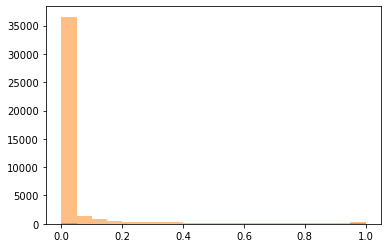

In [24]:
plt.hist(k, 20,alpha=0.5)
plt.hist(t, 20,alpha=0.5)
#plt.xticks([x * 0.05 for x in range(0, 20)])
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()

F1-score Method of checking best threshold

In [25]:
thresholds = []
for thresh in np.arange(0.01, 0.99, 0.001):
    thresh = np.round(thresh, 3)
    res = f1_score(preds['Actuals'], (preds['Active'] > thresh).astype(int))
    thresholds.append([thresh, res])
    print("F1 score at threshold {0} is {1}".format(thresh, res))
    
thresholds.sort(key=lambda x: x[1], reverse=True)
best_thresh = thresholds[0][0]
print("Best threshold: ", best_thresh, "Best F1: ", thresholds[0][1])

F1 score at threshold 0.01 is 0.1235803657362849
F1 score at threshold 0.011 is 0.12604628261939932
F1 score at threshold 0.012 is 0.1283443975055321
F1 score at threshold 0.013 is 0.1298249206511723
F1 score at threshold 0.014 is 0.13145833333333332
F1 score at threshold 0.015 is 0.1330372250423012
F1 score at threshold 0.016 is 0.13414764813029037
F1 score at threshold 0.017 is 0.1353203524420755
F1 score at threshold 0.018 is 0.1362584059089406
F1 score at threshold 0.019 is 0.13761467889908255
F1 score at threshold 0.02 is 0.1389550039669047
F1 score at threshold 0.021 is 0.14024600528796413
F1 score at threshold 0.022 is 0.141776277499709
F1 score at threshold 0.023 is 0.14324356109608374
F1 score at threshold 0.024 is 0.1441462835431014
F1 score at threshold 0.025 is 0.14518838492920566
F1 score at threshold 0.026 is 0.14658415240868827
F1 score at threshold 0.027 is 0.14814814814814814
F1 score at threshold 0.028 is 0.14956048037637737
F1 score at threshold 0.029 is 0.1507123219

F1 score at threshold 0.186 is 0.2321428571428571
F1 score at threshold 0.187 is 0.23235563703024747
F1 score at threshold 0.188 is 0.23294279807029633
F1 score at threshold 0.189 is 0.23353293413173654
F1 score at threshold 0.19 is 0.2340180013847219
F1 score at threshold 0.191 is 0.23393435043920482
F1 score at threshold 0.192 is 0.23401297497683038
F1 score at threshold 0.193 is 0.23420074349442377
F1 score at threshold 0.194 is 0.23469150174621653
F1 score at threshold 0.195 is 0.23529411764705882
F1 score at threshold 0.196 is 0.23567921440261866
F1 score at threshold 0.197 is 0.2355420276281901
F1 score at threshold 0.198 is 0.2355701548568747
F1 score at threshold 0.199 is 0.23623529411764707
F1 score at threshold 0.2 is 0.23673661872199953
F1 score at threshold 0.201 is 0.23693544573185152
F1 score at threshold 0.202 is 0.23738450604122247
F1 score at threshold 0.203 is 0.23752969121140138
F1 score at threshold 0.204 is 0.23803856224708403
F1 score at threshold 0.205 is 0.23812

F1 score at threshold 0.368 is 0.2884978001257071
F1 score at threshold 0.369 is 0.2890428211586902
F1 score at threshold 0.37 is 0.2892249527410208
F1 score at threshold 0.371 is 0.28986422481844015
F1 score at threshold 0.372 is 0.2905982905982906
F1 score at threshold 0.373 is 0.2907013646461441
F1 score at threshold 0.374 is 0.2915340547422024
F1 score at threshold 0.375 is 0.29171974522293
F1 score at threshold 0.376 is 0.29182630906768836
F1 score at threshold 0.377 is 0.2925736235595391
F1 score at threshold 0.378 is 0.29276105060858426
F1 score at threshold 0.379 is 0.29296498554449085
F1 score at threshold 0.38 is 0.29343629343629346
F1 score at threshold 0.381 is 0.2940038684719536
F1 score at threshold 0.382 is 0.29402261712439415
F1 score at threshold 0.383 is 0.2942127384416424
F1 score at threshold 0.384 is 0.2946891191709845
F1 score at threshold 0.385 is 0.2951670450859552
F1 score at threshold 0.386 is 0.2954545454545454
F1 score at threshold 0.387 is 0.295838751625487

F1 score at threshold 0.532 is 0.329253849190683
F1 score at threshold 0.533 is 0.3299050632911393
F1 score at threshold 0.534 is 0.33042789223454827
F1 score at threshold 0.535 is 0.33082110273700915
F1 score at threshold 0.536 is 0.33121525019857034
F1 score at threshold 0.537 is 0.3314785373608903
F1 score at threshold 0.538 is 0.3321385902031063
F1 score at threshold 0.539 is 0.33253588516746413
F1 score at threshold 0.54 is 0.33253588516746413
F1 score at threshold 0.541 is 0.332934131736527
F1 score at threshold 0.542 is 0.33346661335465816
F1 score at threshold 0.543 is 0.33359999999999995
F1 score at threshold 0.544 is 0.3325320512820513
F1 score at threshold 0.545 is 0.3330658105939005
F1 score at threshold 0.546 is 0.33333333333333337
F1 score at threshold 0.547 is 0.33360128617363344
F1 score at threshold 0.548 is 0.333869670152856
F1 score at threshold 0.549 is 0.33360193392425463
F1 score at threshold 0.55 is 0.3338709677419355
F1 score at threshold 0.551 is 0.334140435835

F1 score at threshold 0.701 is 0.35894941634241245
F1 score at threshold 0.702 is 0.3594739405747686
F1 score at threshold 0.703 is 0.3598244758654315
F1 score at threshold 0.704 is 0.3603515625
F1 score at threshold 0.705 is 0.36141038197845254
F1 score at threshold 0.706 is 0.36096125551741043
F1 score at threshold 0.707 is 0.3616707616707617
F1 score at threshold 0.708 is 0.36238306253077296
F1 score at threshold 0.709 is 0.36238306253077296
F1 score at threshold 0.71 is 0.36211149481993093
F1 score at threshold 0.711 is 0.36148148148148146
F1 score at threshold 0.712 is 0.36183885318833414
F1 score at threshold 0.713 is 0.36255572065378905
F1 score at threshold 0.714 is 0.36345580933465743
F1 score at threshold 0.715 is 0.36381709741550694
F1 score at threshold 0.716 is 0.3645418326693227
F1 score at threshold 0.717 is 0.36508728179551125
F1 score at threshold 0.718 is 0.36481759120439783
F1 score at threshold 0.719 is 0.36481759120439783
F1 score at threshold 0.72 is 0.36436436436

F1 score at threshold 0.871 is 0.3602800763844685
F1 score at threshold 0.872 is 0.3611997447351627
F1 score at threshold 0.873 is 0.3608445297504798
F1 score at threshold 0.874 is 0.3613068545803972
F1 score at threshold 0.875 is 0.3607188703465982
F1 score at threshold 0.876 is 0.36012861736334406
F1 score at threshold 0.877 is 0.3590733590733591
F1 score at threshold 0.878 is 0.35976789168278533
F1 score at threshold 0.879 is 0.36
F1 score at threshold 0.88 is 0.3588082901554404
F1 score at threshold 0.881 is 0.35927367055771725
F1 score at threshold 0.882 is 0.35997400909681615
F1 score at threshold 0.883 is 0.3598435462842242
F1 score at threshold 0.884 is 0.3600782778864971
F1 score at threshold 0.885 is 0.3607843137254902
F1 score at threshold 0.886 is 0.3610202746893395
F1 score at threshold 0.887 is 0.36041939711664484
F1 score at threshold 0.888 is 0.3611293499671701
F1 score at threshold 0.889 is 0.3616042077580539
F1 score at threshold 0.89 is 0.35968379446640314
F1 score a

<h4>Metrics</h4>

In [26]:
conditions = [(preds['Active']>=best_thresh),(preds['Active']<best_thresh)]
values = [1,0]
preds['Preds'] = np.select(conditions, values)
preds

molStripped    Active  Actuals  \
0         O=C(Nc1cccc2c1CCCC2)c1ccc(Cl)c([N+](=O)[O-])c1  0.180893        0   
1       CCOC(=O)CC1C(=O)NCCN1S(=O)(=O)c1cc(Cl)c(Cl)cc1Cl  0.000011        0   
2                      CCS(=O)(=O)c1nc2ccccc2n1Cc1ccccn1  0.000900        0   
3      COC(=O)C(CCCCNC(=O)c1ccc([N+](=O)[O-])cc1)NC(=...  0.011574        0   
4         O=C(N/N=C1\CCCc2ccccc21)c1ccc([N+](=O)[O-])cc1  0.059894        0   
...                                                  ...       ...      ...   
42897  O=[N+]([O-])c1cccc(S(=O)(=O)N2CCC(c3nc(-c4ccnc...  0.007203        0   
42898  O=C(COC(=O)c1cc(-c2ccccn2)nc2ccccc12)Nc1ncc(C(...  0.005337        0   
42899  COc1ccc(S(=O)(=O)N2CCN(C(=O)COc3ccc4c(C)cc(=O)...  0.000010        0   
42900                 CCCCNC(=O)c1cc([N+](=O)[O-])[nH]n1  0.005162        0   
42901  O=C(CSc1nnc(-c2ccncc2)n1-c1ccccc1)Nc1ccc(C(=O)...  0.000543        0   

       Preds  
0          0  
1          0  
2          0  
3          0  
4          0  
...      ...  
42897      0  
42898      0  
42899      0  
42900      0  
42901      0  

[42902 rows x 4 columns]

In [27]:
cf = confusion_matrix(preds['Actuals'], preds['Preds'])

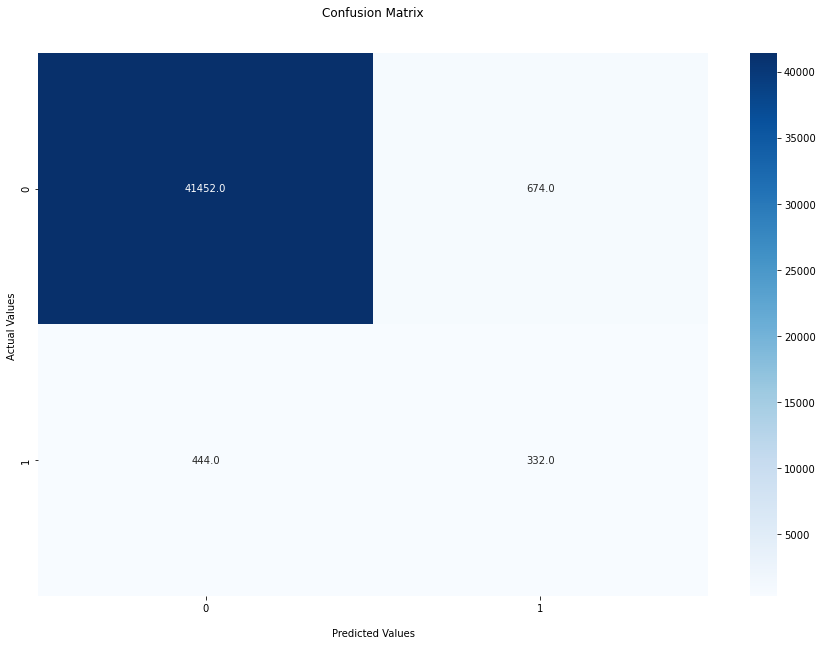

In [28]:
ax = sns.heatmap(cf, annot=True, cmap='Blues',fmt=".1f")
ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
plt.show()

In [29]:
labels = ['Balanced Accuracy','F1 Score','Accuracy Score','Precision Score','Recall Score']
metrics = [balanced_accuracy_score(preds['Actuals'], preds['Preds']),f1_score(preds['Actuals'], preds['Preds']),
           accuracy_score(preds['Actuals'], preds['Preds']),precision_score(preds['Actuals'], preds['Preds']),
           recall_score(preds['Actuals'], preds['Preds'])]

In [30]:
metrics_t = pd.DataFrame()
metrics_t['Metrics'] = labels
metrics_t['Values'] = metrics
metrics_t

Metrics    Values
0  Balanced Accuracy  0.705918
1           F1 Score  0.372615
2     Accuracy Score  0.973941
3    Precision Score  0.330020
4       Recall Score  0.427835

<h3>TAACF External Set</h3>

In [31]:
target = pd.read_csv("TAACF_CB2_Deduped.csv")
target.head()

MoleculeName                                             SMILES  \
0       7814291     CC(=O)NC1=CC=CC(NC(=S)NC2=CC=CC3=C2C=CC=C3)=C1   
1       7286788      ClC1=CC(Cl)=C(C=C1)C1=CSC(NC(=O)C2=CC=CO2)=N1   
2       7286793      CC1=C(C)N=C(NC(=O)CCCC(=O)NC2=NC(C)=C(C)S2)S1   
3       7286824  CCC(OC1=CC=CC=C1)C(=O)NC1=C(NC(=O)C(CC)OC2=CC=...   
4       7286875  O=C(N1CCCN(CC1)C(=O)C1=CC=C(C=C1)C1=CC=CC=C1)C...   

                                            RDKitMol  \
0  <rdkit.Chem.rdchem.Mol object at 0x00000232226...   
1  <rdkit.Chem.rdchem.Mol object at 0x00000232226...   
2  <rdkit.Chem.rdchem.Mol object at 0x00000232103...   
3  <rdkit.Chem.rdchem.Mol object at 0x00000232149...   
4  <rdkit.Chem.rdchem.Mol object at 0x00000232226...   

                                         molStripped strippedSalts  \
0             CC(=O)Nc1cccc(NC(=S)Nc2cccc3ccccc23)c1           NaN   
1              O=C(Nc1nc(-c2ccc(Cl)cc2Cl)cs1)c1ccco1           NaN   
2            Cc1nc(NC(=O)CCCC(=O)Nc2nc(C)c(C)s2)sc1C           NaN   
3   CCC(Oc1ccccc1)C(=O)Nc1ccccc1NC(=O)C(CC)Oc1ccccc1           NaN   
4  O=C(c1ccc(-c2ccccc2)cc1)N1CCCN(C(=O)c2ccc(-c3c...           NaN   

   MtbH37Rv-Inhibition  Active  
0                  0.0       0  
1                  0.0       0  
2                  0.0       0  
3                  0.0       0  
4                  0.0       0

In [32]:
train_ext = target[['molStripped']]
y_ext = target[['Active']]
train_ext.to_csv('exttrain.csv',index=False)

In [33]:
ext_parameters = ['--test_path','exttrain.csv',
                  '--preds_path','preds1.csv',
                  '--features_generator','rdkit_2d',
                 #'--no_features_scaling',
                 #'--individual_ensemble_predictions',
                  '--checkpoint_dir','checkpoints']

In [34]:
pred1 = chemprop.args.PredictArgs().parse_args(ext_parameters)

In [35]:
y_o = chemprop.train.make_predictions(args=pred1)

Loading training args
Setting molecule featurization parameters to default.
Loading data


100688it [00:00, 114329.30it/s]
100%|██████████| 100688/100688 [23:00<00:00, 72.91it/s]


Validating SMILES
Test size = 100,688


  0%|          | 0/1 [00:00<?, ?it/s]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".
Loading pretrained parameter "ffn.4.weight".
Loading pretrained parameter "ffn.4.bias".
Loading pretrained parameter "ffn.7.weight".
Loading pretrained parameter "ffn.7.bias".



 30%|██▉       | 597/2014 [00:56<02:14, 10.57it/s]


 59%|█████▉    | 1192/2014 [01:52<01:15, 10.89it/s]


 88%|████████▊ | 1781/2014 [02:48<00:19, 11.66it/s]


100%|██████████| 1/1 [03:08<00:00, 188.19s/it]     


Saving predictions to preds1.csv
Elapsed time = 0:26:12


In [36]:
preds_ext = pd.read_csv('preds1.csv')
preds_ext['Actuals'] = y_ext
preds_ext

molStripped        Active  \
0                  CC(=O)Nc1cccc(NC(=S)Nc2cccc3ccccc23)c1  1.700401e-01   
1                   O=C(Nc1nc(-c2ccc(Cl)cc2Cl)cs1)c1ccco1  5.001600e-01   
2                 Cc1nc(NC(=O)CCCC(=O)Nc2nc(C)c(C)s2)sc1C  5.018062e-09   
3        CCC(Oc1ccccc1)C(=O)Nc1ccccc1NC(=O)C(CC)Oc1ccccc1  2.118181e-02   
4       O=C(c1ccc(-c2ccccc2)cc1)N1CCCN(C(=O)c2ccc(-c3c...  4.398449e-06   
...                                                   ...           ...   
100683  O=c1c2c(-c3ccc(Cl)cc3)csc2nc2c3ccccc3c(NCCN3CC...  9.869299e-01   
100684    O=C(Oc1cccc2cccnc12)c1ccc(S(=O)(=O)N2CCCCC2)cc1  2.547270e-02   
100685             O=[N+]([O-])/C=C/c1ccc(-c2ccc(F)cc2)o1  2.974384e-01   
100686    O=C(CCN1C(=O)C2C3C=CC(C3)C2C1=O)Oc1cccc2cccnc12  8.713809e-01   
100687  Cc1cccc(-n2nc([N+](=O)[O-])c(NCCC3=CCCCC3)[n+]...  9.782478e-01   

        Actuals  
0             0  
1             0  
2             0  
3             0  
4             0  
...         ...  
100683        1  
100684        1  
100685        1  
100686        1  
100687        1  

[100688 rows x 3 columns]

In [37]:
conditions = [(preds_ext['Active']>=best_thresh),(preds_ext['Active']<best_thresh)]
values = [1,0]
preds_ext['Predicted'] = np.select(conditions, values)
preds_ext

molStripped        Active  \
0                  CC(=O)Nc1cccc(NC(=S)Nc2cccc3ccccc23)c1  1.700401e-01   
1                   O=C(Nc1nc(-c2ccc(Cl)cc2Cl)cs1)c1ccco1  5.001600e-01   
2                 Cc1nc(NC(=O)CCCC(=O)Nc2nc(C)c(C)s2)sc1C  5.018062e-09   
3        CCC(Oc1ccccc1)C(=O)Nc1ccccc1NC(=O)C(CC)Oc1ccccc1  2.118181e-02   
4       O=C(c1ccc(-c2ccccc2)cc1)N1CCCN(C(=O)c2ccc(-c3c...  4.398449e-06   
...                                                   ...           ...   
100683  O=c1c2c(-c3ccc(Cl)cc3)csc2nc2c3ccccc3c(NCCN3CC...  9.869299e-01   
100684    O=C(Oc1cccc2cccnc12)c1ccc(S(=O)(=O)N2CCCCC2)cc1  2.547270e-02   
100685             O=[N+]([O-])/C=C/c1ccc(-c2ccc(F)cc2)o1  2.974384e-01   
100686    O=C(CCN1C(=O)C2C3C=CC(C3)C2C1=O)Oc1cccc2cccnc12  8.713809e-01   
100687  Cc1cccc(-n2nc([N+](=O)[O-])c(NCCC3=CCCCC3)[n+]...  9.782478e-01   

        Actuals  Predicted  
0             0          0  
1             0          0  
2             0          0  
3             0          0  
4             0          0  
...         ...        ...  
100683        1          1  
100684        1          0  
100685        1          0  
100686        1          1  
100687        1          1  

[100688 rows x 4 columns]

In [38]:
cf_ext = confusion_matrix(preds_ext['Actuals'], preds_ext['Predicted'])

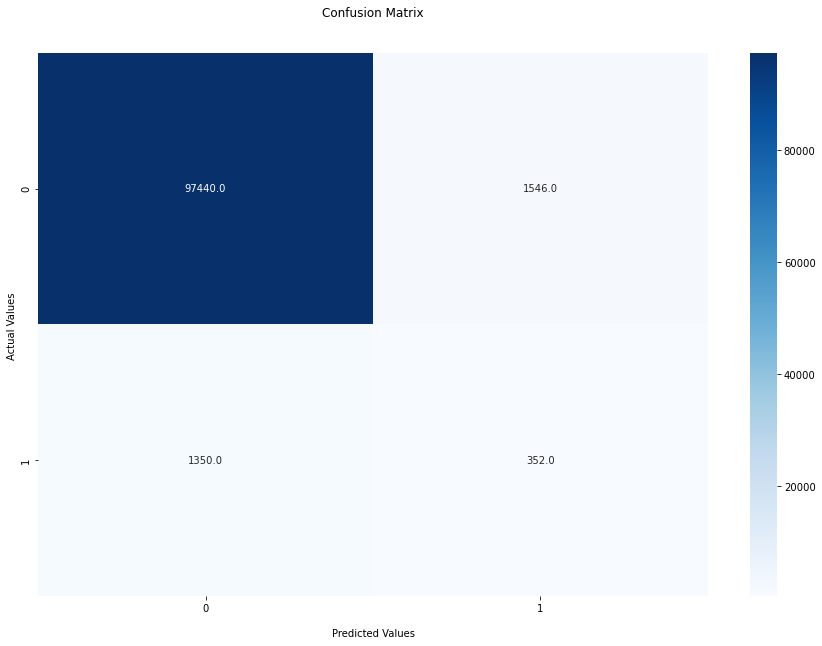

In [39]:
ax = sns.heatmap(cf_ext, annot=True, cmap='Blues', fmt=".1f")
ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
plt.show()

In [40]:
labels = ['Balanced Accuracy','F1 Score','Accuracy Score','Precision Score','Recall Score']
metrics = [balanced_accuracy_score(preds_ext['Actuals'], preds_ext['Predicted']),f1_score(preds_ext['Actuals'], preds_ext['Predicted']),
           accuracy_score(preds_ext['Actuals'], preds_ext['Predicted']),precision_score(preds_ext['Actuals'], preds_ext['Predicted']),
           recall_score(preds_ext['Actuals'], preds_ext['Predicted'])]

In [41]:
metrics_et = pd.DataFrame()
metrics_et['Metrics'] = labels
metrics_et['Values'] = metrics
metrics_et

Metrics    Values
0  Balanced Accuracy  0.595599
1           F1 Score  0.195556
2     Accuracy Score  0.971238
3    Precision Score  0.185458
4       Recall Score  0.206816

<h3>Docking Predictions</h3>

In [43]:
docking = pd.read_csv("KasADockedTop1000_2Descriptors.csv")

In [44]:
docking.head()

MoleculeId                                             SMILES  \
0   Z57030687  O=C(Nc1c(Cc2ccccc2)cccc1)C1CCN(c2ncnc3sc4c(c23...   
1   Z56823499  O=C1C(=CNN2C(=O)c3c(sc4c3CCCC4)N=C2)CCCC1=Cc1c...   
2   Z53786665  Clc1ccc(-c2nc3c(c(C(=O)OCC4=Nc5sc6c(c5C(=O)N4)...   
3  Z105382408  Fc1ccc(C(N2CCN(CC3=Nc4sc5c(c4C(=O)N3)CCC5)CC2)...   
4   Z56760621  O=C1NC(c2c3c(nc(-c4ccccc4)c2)cccc3)=Nc2sc3c(c1...   

                                            RDKitMol  \
0  <rdkit.Chem.rdchem.Mol object at 0x000001A7ABF...   
1  <rdkit.Chem.rdchem.Mol object at 0x000001A7ABF...   
2  <rdkit.Chem.rdchem.Mol object at 0x000001A7AF1...   
3  <rdkit.Chem.rdchem.Mol object at 0x000001A7AF1...   
4  <rdkit.Chem.rdchem.Mol object at 0x000001A7AF1...   

                                         molStripped  strippedSalts  Cluster  \
0  O=C(Nc1c(Cc2ccccc2)cccc1)C1CCN(c2ncnc3sc4c(c23...            NaN        0   
1  O=C1C(=CNN2C(=O)c3c(sc4c3CCCC4)N=C2)CCCC1=Cc1c...            NaN        0   
2  Clc1ccc(-c2nc3c(c(C(=O)OCC4=Nc5sc6c(c5C(=O)N4)...            NaN        0   
3  Fc1ccc(C(N2CCN(CC3=Nc4sc5c(c4C(=O)N3)CCC5)CC2)...            NaN        0   
4  O=C1NC(c2c3c(nc(-c4ccccc4)c2)cccc3)=Nc2sc3c(c1...            NaN        0   

        apol  arorings  ast_fraglike  ast_fraglike_ext  ...  vsa_acid  \
0  79.145790         4             0                 0  ...         0   
1  65.380241         2             0                 0  ...         0   
2  71.641861         4             0                 0  ...         0   
3  74.072617         3             0                 0  ...         0   
4  63.671066         4             0                 0  ...         0   

   vsa_base   vsa_don    vsa_hyd  vsa_other    vsa_pol     Weight  weinerPath  \
0         0  5.682576  343.89801  48.930611  30.614649  482.65198        4161   
1         0  9.421040  269.47348  46.198566  42.237457  417.53299        2677   
2         0  5.682576  318.73322  41.352348  44.181568  501.99399        3964   
3         0  5.682576  365.40448  24.140093  24.932074  492.59399        4073   
4         0  5.682576  278.38156  24.140093  30.614649  409.51300        2317   

   weinerPol  zagreb  
0         58     192  
1         50     164  
2         61     196  
3         58     196  
4         54     172  

[5 rows x 215 columns]

In [45]:
dock_smiles = docking[['molStripped']]

In [46]:
dock_smiles.to_csv('dock.csv',index=False)

In [47]:
dock_parameters = ['--test_path','dock.csv',
                  '--preds_path','preds2.csv',
                  '--features_generator','rdkit_2d',
                 #'--no_features_scaling',
                 #'--individual_ensemble_predictions',
                  '--checkpoint_dir','checkpoints']

In [48]:
pred2 = chemprop.args.PredictArgs().parse_args(dock_parameters)

In [49]:
y_d = chemprop.train.make_predictions(args=pred2)

Loading training args
Setting molecule featurization parameters to default.
Loading data


956it [00:00, 301168.29it/s]
100%|██████████| 956/956 [00:19<00:00, 50.17it/s]


Validating SMILES
Test size = 956


  0%|          | 0/1 [00:00<?, ?it/s]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".
Loading pretrained parameter "ffn.4.weight".
Loading pretrained parameter "ffn.4.bias".
Loading pretrained parameter "ffn.7.weight".
Loading pretrained parameter "ffn.7.bias".



100%|██████████| 1/1 [00:02<00:00,  2.80s/it]  

Saving predictions to preds2.csv
Elapsed time = 0:00:22


In [50]:
preds_dock = pd.read_csv('preds2.csv')
preds_dock

molStripped    Active
0    O=C(Nc1c(Cc2ccccc2)cccc1)C1CCN(c2ncnc3sc4c(c23...  0.018908
1    O=C1C(=CNN2C(=O)c3c(sc4c3CCCC4)N=C2)CCCC1=Cc1c...  0.514169
2    Clc1ccc(-c2nc3c(c(C(=O)OCC4=Nc5sc6c(c5C(=O)N4)...  0.001821
3    Fc1ccc(C(N2CCN(CC3=Nc4sc5c(c4C(=O)N3)CCC5)CC2)...  0.426268
4    O=C1NC(c2c3c(nc(-c4ccccc4)c2)cccc3)=Nc2sc3c(c1...  0.250345
..                                                 ...       ...
951  Clc1cc2nc(N3C(c4sccc4)CC(c4sccc4)=N3)nc(-c3ccc...  0.002514
952  Clc1cc2c(-c3ccccc3)nc(N3C(c4c(C)cccc4)CC(c4cc(...  0.223128
953  Clc1cc2c(-c3ccccc3)nc(N3C(c4ccc(OCC)cc4)CC(c4s...  0.191393
954  Brc1ccc(C2N(c3nc(-c4ccccc4)c4c(n3)ccc(Cl)c4)N=...  0.384635
955  Clc1cc2c(-c3ccccc3)nc(N3C(c4ccccc4)CC(c4occc4)...  0.494584

[956 rows x 2 columns]

In [51]:
conditions = [(preds_dock['Active']>=best_thresh),(preds_dock['Active']<best_thresh)]
values = [1,0]
preds_dock['Predicted'] = np.select(conditions, values)
preds_dock

molStripped    Active  Predicted
0    O=C(Nc1c(Cc2ccccc2)cccc1)C1CCN(c2ncnc3sc4c(c23...  0.018908          0
1    O=C1C(=CNN2C(=O)c3c(sc4c3CCCC4)N=C2)CCCC1=Cc1c...  0.514169          0
2    Clc1ccc(-c2nc3c(c(C(=O)OCC4=Nc5sc6c(c5C(=O)N4)...  0.001821          0
3    Fc1ccc(C(N2CCN(CC3=Nc4sc5c(c4C(=O)N3)CCC5)CC2)...  0.426268          0
4    O=C1NC(c2c3c(nc(-c4ccccc4)c2)cccc3)=Nc2sc3c(c1...  0.250345          0
..                                                 ...       ...        ...
951  Clc1cc2nc(N3C(c4sccc4)CC(c4sccc4)=N3)nc(-c3ccc...  0.002514          0
952  Clc1cc2c(-c3ccccc3)nc(N3C(c4c(C)cccc4)CC(c4cc(...  0.223128          0
953  Clc1cc2c(-c3ccccc3)nc(N3C(c4ccc(OCC)cc4)CC(c4s...  0.191393          0
954  Brc1ccc(C2N(c3nc(-c4ccccc4)c4c(n3)ccc(Cl)c4)N=...  0.384635          0
955  Clc1cc2c(-c3ccccc3)nc(N3C(c4ccccc4)CC(c4occc4)...  0.494584          0

[956 rows x 3 columns]

In [52]:
preds_dock['Predicted'].value_counts()

0    925
1     31
Name: Predicted, dtype: int64

In [53]:
preds_dock.to_csv('Dock_preds.csv')